# Speech Emotion Classification

###### Major Obstacles source: https://towardsdatascience.com/speech-emotion-recognition-with-convolution-neural-network-1e6bb7130ce3
- Emotions are subjective, people would interpret it differently. It is hard to define the notion of emotions.
- Annotating an audio recording is challenging. Should we label a single word, sentence or a whole conversation? How many emotions should we define to recognize?
- Collecting data is complex. There are lots of audio data can be achieved from films or news. However, both of them are biased since news reporting has to be neutral and actors’ emotions are imitated. It is hard to look for neutral audio recording without any bias.
- Labeling data require high human and time cost. Unlike drawing a bounding box on an image, it requires trained personnel to listen to the whole audio recording, analysis it and give an annotation. The annotation result has to be evaluated by multiple individuals due to its subjectivity.

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## 0. Dependencies

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
import os
import shutil
import pickle

In [0]:
import numpy as np
import torch
import pandas as pd

In [5]:
import keras
import fastai

Using TensorFlow backend.


In [0]:
from pathlib import Path

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# !pip install soundfile
import soundfile

In [0]:
# to play the sound
import IPython.display as ipd

In [0]:
import librosa
import librosa.display

In [0]:
from sklearn.metrics import confusion_matrix

In [0]:
# progress bar
from tqdm import tqdm

## 1. Data Collection

#### Dataset source: https://github.com/SenticNet/MELD

In [15]:
# !unzip drive/My\ Drive/emotion

Archive:  drive/My Drive/emotion.zip
   creating: meld/
   creating: meld/train/
   creating: meld/train/happy/
  inflating: meld/train/happy/MEL_dia526_utt5_positive_HAP.wav  
  inflating: meld/train/happy/MEL_dia839_utt4_positive_HAP.wav  
  inflating: meld/train/happy/MEL_dia916_utt0_positive_HAP.wav  
  inflating: meld/train/happy/MEL_dia260_utt0_positive_HAP.wav  
  inflating: meld/train/happy/MEL_dia165_utt19_positive_HAP.wav  
  inflating: meld/train/happy/MEL_dia646_utt4_positive_HAP.wav  
  inflating: meld/train/happy/MEL_dia517_utt6_positive_HAP.wav  
  inflating: meld/train/happy/MEL_dia822_utt4_positive_HAP.wav  
  inflating: meld/train/happy/MEL_dia498_utt2_positive_HAP.wav  
  inflating: meld/train/happy/MEL_dia844_utt8_positive_HAP.wav  
  inflating: meld/train/happy/MEL_dia898_utt1_positive_HAP.wav  
  inflating: meld/train/happy/MEL_dia237_utt10_positive_HAP.wav  
  inflating: meld/train/happy/MEL_dia710_utt0_positive_HAP.wav  
  inflating: meld/train/happy/MEL_dia742_

## check data imbalance

In [0]:
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.gridspec import GridSpec

In [0]:
t_path = Path('meld/train/')
v_path = Path('meld/val/')

In [0]:
classes = os.listdir('meld/train/')
train_samples = []
val_samples = []
for c in classes:
  train_samples.append(len(os.listdir('meld/train/'+c)))
  val_samples.append(len(os.listdir('meld/val/'+c)))

In [19]:
classes

['happy', 'fear', 'disgust', 'sad', 'neutral']

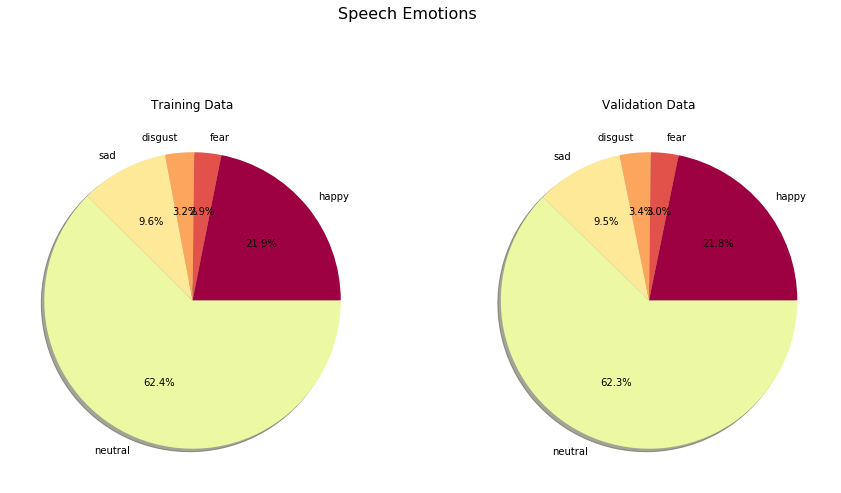

In [20]:
# Make square figures and axes
plt.figure(1, figsize=(15,15))
the_grid = GridSpec(2, 2)


cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, 8)]


plt.subplot(the_grid[0, 0], aspect=1, title='Training Data')
train_pie = plt.pie(train_samples, labels=classes, autopct='%.1f%%', shadow=True, colors=colors)

plt.subplot(the_grid[0, 1], aspect=1, title='Validation Data')
val_pie = plt.pie(val_samples,labels=classes, autopct='%.1f%%', shadow=True, colors=colors)


plt.suptitle('Speech Emotions', fontsize=16)


plt.show()


##### From the above plot we can say that data is imbalanced




In [21]:
print(classes)
print(train_samples)
print(val_samples)

['happy', 'fear', 'disgust', 'sad', 'neutral']
[1609, 216, 232, 705, 4592]
[181, 25, 28, 79, 517]


#### Implementation of: Promod Yenigalla et al. **Speech Emotion Recognition Using Spectrogram & Phoneme Embedding** 

### we will extract three features from the input audion files

In [0]:
y, sr = librosa.load('meld/train/disgust/MEL_dia1000_utt0_negative_DIS.wav')

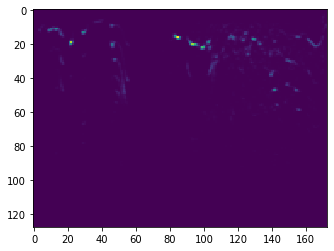

In [23]:
plt.imshow(librosa.feature.melspectrogram(y=y, sr=sr))

In [24]:
classes

['happy', 'fear', 'disgust', 'sad', 'neutral']

In [0]:
l = os.listdir(t_path/np.random.choice(classes))

In [0]:
# type(S_dB)

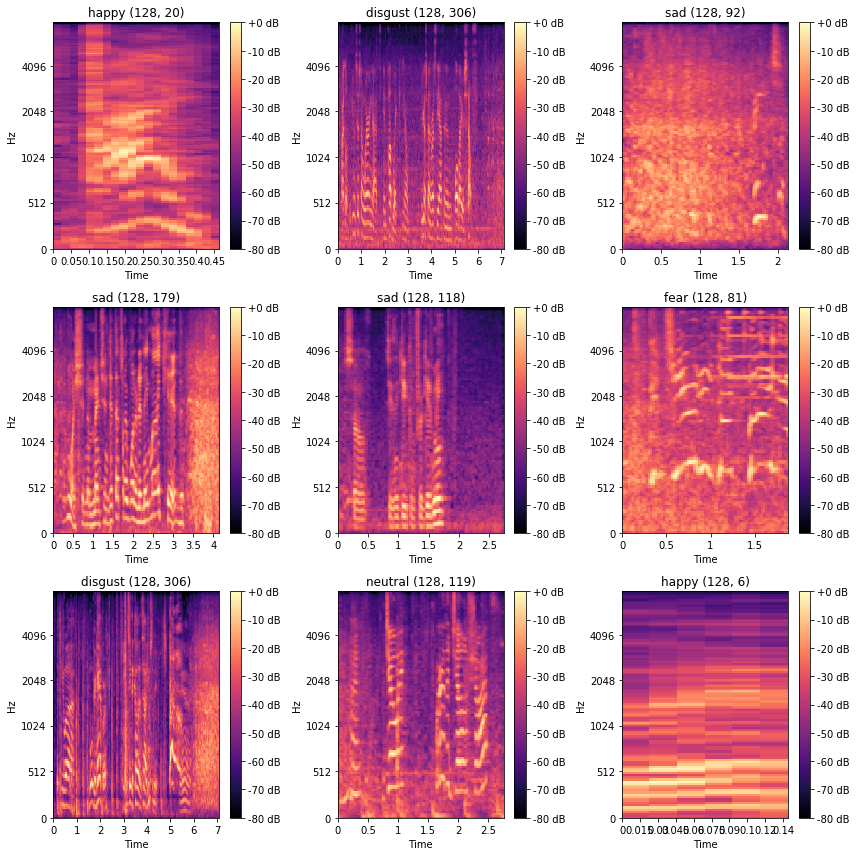

In [27]:
w=10
h=10
fig=plt.figure(figsize=(12, 12))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    c = np.random.choice(classes)
    file = np.random.choice(os.listdir(t_path/c))
    fig.add_subplot(rows, columns, i)
    
    y, sr = librosa.load(t_path/c/file)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title(c+" " + str(S.shape))
    plt.tight_layout()
plt.show()

## Speech Emotion Classification using Librosa Features
#### We will use three following features from input audio speech:
- mfcc: Mel Frequency Cepstral Coefficient, represents the short-term power spectrum of a sound
- chroma: Pertains to the 12 different pitch classes
- mel: Mel Spectrogram Frequency

In [0]:
classes = sorted(classes)
cls_to_idx = dict(zip(classes, np.linspace(0, 4, 5, dtype=np.int8)))
idx_to_cls = dict(zip(np.linspace(0, 4, 5, dtype=np.int8), classes))

In [79]:
cls_to_idx

{'disgust': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'sad': 4}

In [80]:
idx_to_cls

{0: 'disgust', 1: 'fear', 2: 'happy', 3: 'neutral', 4: 'sad'}

In [0]:
#DataFlair - Extract features (mfcc, chroma, mel) from a sound file
def extract_feature(file, mfcc, chroma, mel):
  
  #print(file)

  result=np.array([])

  y, sr = librosa.load(file)

  if mfcc:
      mfccs=np.mean(librosa.feature.mfcc(y=y, sr=sr).T, axis = 0)
      result=np.hstack((result, mfccs))
  if chroma:
      chroma=np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
      result=np.hstack((result, chroma))
#       print('error-1')
  if mel:
#       print(type(librosa.feature.melspectrogram(y=y, sr=sr)))
      mel= np.mean(librosa.feature.melspectrogram(y=y, sr=sr).T,axis=0)
#       print('error-2')
      result=np.hstack((result, mel))
      
  return result

In [0]:
#DataFlair - Load the data and extract features for each sound file
def load_data(path):
  
    x,y=[],[]
    
    for cls in tqdm(classes):
      for file in tqdm(os.listdir(path/cls)):
        emotion = cls
#         print(emotion)
        feature = extract_feature(path/cls/file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
        
    return x, y

In [118]:
x_train, y_train = load_data(t_path)



  0%|          | 0/5 [00:00<?, ?it/s]


  0%|          | 0/232 [00:00<?, ?it/s]


  0%|          | 1/232 [00:00<01:08,  3.36it/s]

<class 'numpy.ndarray'>





  1%|          | 2/232 [00:00<01:02,  3.69it/s]

<class 'numpy.ndarray'>





  1%|▏         | 3/232 [00:00<01:04,  3.55it/s]

<class 'numpy.ndarray'>





  2%|▏         | 4/232 [00:01<01:07,  3.40it/s]

<class 'numpy.ndarray'>





  2%|▏         | 5/232 [00:01<01:03,  3.57it/s]

<class 'numpy.ndarray'>





  3%|▎         | 6/232 [00:01<00:59,  3.80it/s]

<class 'numpy.ndarray'>





  3%|▎         | 7/232 [00:01<01:01,  3.67it/s]

<class 'numpy.ndarray'>





  3%|▎         | 8/232 [00:02<01:14,  3.00it/s]

<class 'numpy.ndarray'>





  4%|▍         | 9/232 [00:02<01:10,  3.15it/s]

<class 'numpy.ndarray'>





  4%|▍         | 10/232 [00:02<01:05,  3.38it/s]

<class 'numpy.ndarray'>





  5%|▍         | 11/232 [00:03<01:04,  3.45it/s]

<class 'numpy.ndarray'>





  5%|▌         | 12/232 [00:03<01:07,  3.26it/s]

<class 'numpy.ndarray'>





  6%|▌         | 13/232 [00:03<01:00,  3.61it/s]

<class 'numpy.ndarray'>





  6%|▌         | 14/232 [00:04<01:04,  3.39it/s]

<class 'numpy.ndarray'>





  6%|▋         | 15/232 [00:04<01:02,  3.45it/s]

<class 'numpy.ndarray'>





  7%|▋         | 16/232 [00:04<00:57,  3.77it/s]

<class 'numpy.ndarray'>





  7%|▋         | 17/232 [00:04<00:57,  3.73it/s]

<class 'numpy.ndarray'>





  8%|▊         | 18/232 [00:05<00:53,  3.96it/s]

<class 'numpy.ndarray'>





  8%|▊         | 19/232 [00:05<00:56,  3.75it/s]

<class 'numpy.ndarray'>





  9%|▊         | 20/232 [00:05<00:52,  4.03it/s]

<class 'numpy.ndarray'>





  9%|▉         | 21/232 [00:05<00:53,  3.93it/s]

<class 'numpy.ndarray'>





  9%|▉         | 22/232 [00:06<00:55,  3.81it/s]

<class 'numpy.ndarray'>





 10%|▉         | 23/232 [00:06<00:59,  3.52it/s]

<class 'numpy.ndarray'>





 10%|█         | 24/232 [00:06<01:02,  3.35it/s]

<class 'numpy.ndarray'>





 11%|█         | 25/232 [00:07<01:16,  2.70it/s]

<class 'numpy.ndarray'>





 11%|█         | 26/232 [00:07<01:06,  3.08it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 27/232 [00:07<01:08,  3.01it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 28/232 [00:08<01:12,  2.82it/s]

<class 'numpy.ndarray'>





 12%|█▎        | 29/232 [00:08<01:08,  2.96it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 30/232 [00:09<01:15,  2.67it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 31/232 [00:09<01:05,  3.08it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 32/232 [00:09<00:58,  3.45it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 33/232 [00:09<00:53,  3.69it/s]

<class 'numpy.ndarray'>





 15%|█▍        | 34/232 [00:10<01:06,  2.99it/s]

<class 'numpy.ndarray'>





 15%|█▌        | 35/232 [00:10<01:02,  3.18it/s]

<class 'numpy.ndarray'>





 16%|█▌        | 36/232 [00:10<01:02,  3.11it/s]

<class 'numpy.ndarray'>





 16%|█▌        | 37/232 [00:11<01:08,  2.84it/s]

<class 'numpy.ndarray'>





 16%|█▋        | 38/232 [00:11<01:10,  2.75it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 39/232 [00:11<01:05,  2.96it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 40/232 [00:12<01:11,  2.69it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 41/232 [00:12<01:09,  2.76it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 42/232 [00:12<01:00,  3.12it/s]

<class 'numpy.ndarray'>





 19%|█▊        | 43/232 [00:13<01:03,  2.99it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 44/232 [00:13<00:58,  3.20it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 45/232 [00:13<00:54,  3.45it/s]

<class 'numpy.ndarray'>





 20%|█▉        | 46/232 [00:13<00:50,  3.67it/s]

<class 'numpy.ndarray'>





 20%|██        | 47/232 [00:14<00:57,  3.23it/s]

<class 'numpy.ndarray'>





 21%|██        | 48/232 [00:14<01:01,  2.97it/s]

<class 'numpy.ndarray'>





 21%|██        | 49/232 [00:15<00:57,  3.20it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 50/232 [00:15<01:04,  2.83it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 51/232 [00:15<00:57,  3.16it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 52/232 [00:16<00:59,  3.02it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 53/232 [00:16<00:55,  3.21it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 54/232 [00:16<00:55,  3.21it/s]

<class 'numpy.ndarray'>





 24%|██▎       | 55/232 [00:17<00:58,  3.01it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 56/232 [00:17<00:52,  3.37it/s]

<class 'numpy.ndarray'>





 25%|██▍       | 57/232 [00:17<00:55,  3.14it/s]

<class 'numpy.ndarray'>





 25%|██▌       | 58/232 [00:17<00:51,  3.38it/s]

<class 'numpy.ndarray'>





 25%|██▌       | 59/232 [00:18<00:50,  3.41it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 60/232 [00:18<00:55,  3.11it/s]

<class 'numpy.ndarray'>





 26%|██▋       | 61/232 [00:18<00:52,  3.28it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 62/232 [00:19<00:57,  2.94it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 63/232 [00:19<00:51,  3.28it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 64/232 [00:19<00:51,  3.29it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 65/232 [00:19<00:46,  3.61it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 66/232 [00:20<00:43,  3.78it/s]

<class 'numpy.ndarray'>





 29%|██▉       | 67/232 [00:20<00:45,  3.59it/s]

<class 'numpy.ndarray'>





 29%|██▉       | 68/232 [00:20<00:51,  3.19it/s]

<class 'numpy.ndarray'>





 30%|██▉       | 69/232 [00:21<00:47,  3.44it/s]

<class 'numpy.ndarray'>





 30%|███       | 70/232 [00:21<00:47,  3.42it/s]

<class 'numpy.ndarray'>





 31%|███       | 71/232 [00:21<00:54,  2.97it/s]

<class 'numpy.ndarray'>





 31%|███       | 72/232 [00:22<00:53,  2.97it/s]

<class 'numpy.ndarray'>





 31%|███▏      | 73/232 [00:22<00:53,  2.99it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 74/232 [00:23<01:01,  2.57it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 75/232 [00:23<01:00,  2.58it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 76/232 [00:23<00:54,  2.85it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 77/232 [00:24<01:05,  2.36it/s]

<class 'numpy.ndarray'>





 34%|███▎      | 78/232 [00:24<01:15,  2.03it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 79/232 [00:25<01:04,  2.36it/s]


 34%|███▍      | 80/232 [00:25<00:53,  2.86it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 35%|███▍      | 81/232 [00:25<00:47,  3.16it/s]

<class 'numpy.ndarray'>





 35%|███▌      | 82/232 [00:25<00:49,  3.05it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 83/232 [00:26<00:47,  3.16it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 84/232 [00:26<00:41,  3.53it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 37%|███▋      | 85/232 [00:26<00:37,  3.88it/s]


 37%|███▋      | 86/232 [00:26<00:39,  3.74it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 87/232 [00:27<00:38,  3.74it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 88/232 [00:27<00:37,  3.87it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 89/232 [00:27<00:41,  3.43it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 90/232 [00:28<00:51,  2.78it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 91/232 [00:28<00:48,  2.91it/s]

<class 'numpy.ndarray'>





 40%|███▉      | 92/232 [00:28<00:45,  3.05it/s]

<class 'numpy.ndarray'>





 40%|████      | 93/232 [00:29<00:41,  3.32it/s]

<class 'numpy.ndarray'>





 41%|████      | 94/232 [00:29<00:42,  3.24it/s]

<class 'numpy.ndarray'>





 41%|████      | 95/232 [00:29<00:40,  3.36it/s]

<class 'numpy.ndarray'>





 41%|████▏     | 96/232 [00:30<00:42,  3.23it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 97/232 [00:30<00:40,  3.33it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 98/232 [00:30<00:46,  2.89it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 99/232 [00:31<00:41,  3.24it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 100/232 [00:31<00:47,  2.79it/s]

<class 'numpy.ndarray'>





 44%|████▎     | 101/232 [00:31<00:42,  3.05it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 102/232 [00:32<00:46,  2.78it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 103/232 [00:32<00:59,  2.16it/s]

<class 'numpy.ndarray'>





 45%|████▍     | 104/232 [00:33<00:59,  2.17it/s]

<class 'numpy.ndarray'>





 45%|████▌     | 105/232 [00:33<00:51,  2.48it/s]




<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


 46%|████▌     | 106/232 [00:33<00:42,  2.96it/s]


 46%|████▌     | 107/232 [00:34<00:38,  3.25it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 108/232 [00:34<00:36,  3.41it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 109/232 [00:34<00:34,  3.53it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 110/232 [00:35<00:38,  3.14it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 111/232 [00:35<00:39,  3.05it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 112/232 [00:35<00:36,  3.26it/s]




<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


 49%|████▊     | 113/232 [00:35<00:32,  3.70it/s]


 49%|████▉     | 114/232 [00:36<00:32,  3.58it/s]

<class 'numpy.ndarray'>





 50%|████▉     | 115/232 [00:36<00:37,  3.13it/s]

<class 'numpy.ndarray'>





 50%|█████     | 116/232 [00:37<00:43,  2.68it/s]

<class 'numpy.ndarray'>





 50%|█████     | 117/232 [00:37<00:47,  2.41it/s]

<class 'numpy.ndarray'>





 51%|█████     | 118/232 [00:37<00:42,  2.71it/s]

<class 'numpy.ndarray'>





 51%|█████▏    | 119/232 [00:38<00:39,  2.86it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 120/232 [00:38<00:39,  2.83it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 121/232 [00:39<00:51,  2.17it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 122/232 [00:39<00:43,  2.53it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 123/232 [00:39<00:39,  2.79it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 124/232 [00:39<00:36,  2.98it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 125/232 [00:40<00:36,  2.92it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 126/232 [00:40<00:35,  2.96it/s]

<class 'numpy.ndarray'>





 55%|█████▍    | 127/232 [00:40<00:32,  3.26it/s]

<class 'numpy.ndarray'>





 55%|█████▌    | 128/232 [00:41<00:36,  2.85it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 129/232 [00:41<00:35,  2.87it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 130/232 [00:42<00:36,  2.82it/s]

<class 'numpy.ndarray'>





 56%|█████▋    | 131/232 [00:42<00:33,  3.03it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 132/232 [00:42<00:32,  3.04it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 133/232 [00:42<00:31,  3.15it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 134/232 [00:43<00:33,  2.91it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 135/232 [00:43<00:29,  3.28it/s]

<class 'numpy.ndarray'>





 59%|█████▊    | 136/232 [00:43<00:30,  3.19it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 137/232 [00:44<00:27,  3.40it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 138/232 [00:44<00:32,  2.91it/s]

<class 'numpy.ndarray'>





 60%|█████▉    | 139/232 [00:44<00:29,  3.14it/s]

<class 'numpy.ndarray'>





 60%|██████    | 140/232 [00:45<00:31,  2.92it/s]

<class 'numpy.ndarray'>





 61%|██████    | 141/232 [00:45<00:31,  2.92it/s]

<class 'numpy.ndarray'>





 61%|██████    | 142/232 [00:45<00:29,  3.00it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 143/232 [00:46<00:26,  3.36it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 144/232 [00:46<00:24,  3.63it/s]

<class 'numpy.ndarray'>





 62%|██████▎   | 145/232 [00:46<00:29,  2.96it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 146/232 [00:47<00:28,  2.99it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 147/232 [00:47<00:31,  2.70it/s]

<class 'numpy.ndarray'>





 64%|██████▍   | 148/232 [00:48<00:33,  2.52it/s]

<class 'numpy.ndarray'>





 64%|██████▍   | 149/232 [00:48<00:29,  2.83it/s]

<class 'numpy.ndarray'>





 65%|██████▍   | 150/232 [00:48<00:27,  3.02it/s]

<class 'numpy.ndarray'>





 65%|██████▌   | 151/232 [00:48<00:23,  3.38it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 152/232 [00:49<00:24,  3.24it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 153/232 [00:49<00:29,  2.66it/s]

<class 'numpy.ndarray'>





 66%|██████▋   | 154/232 [00:50<00:28,  2.71it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 155/232 [00:50<00:27,  2.84it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 156/232 [00:50<00:23,  3.22it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 157/232 [00:51<00:42,  1.77it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 158/232 [00:52<00:45,  1.61it/s]

<class 'numpy.ndarray'>





 69%|██████▊   | 159/232 [00:52<00:36,  1.99it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 160/232 [00:53<00:31,  2.27it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 161/232 [00:53<00:29,  2.44it/s]

<class 'numpy.ndarray'>





 70%|██████▉   | 162/232 [00:53<00:25,  2.75it/s]




<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


 70%|███████   | 163/232 [00:53<00:21,  3.24it/s]


 71%|███████   | 164/232 [00:53<00:18,  3.70it/s]

<class 'numpy.ndarray'>





 71%|███████   | 165/232 [00:54<00:17,  3.85it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 166/232 [00:54<00:20,  3.27it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 167/232 [00:54<00:18,  3.51it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 168/232 [00:55<00:21,  2.99it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 169/232 [00:55<00:21,  2.89it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 170/232 [00:55<00:20,  3.01it/s]

<class 'numpy.ndarray'>





 74%|███████▎  | 171/232 [00:56<00:22,  2.75it/s]

<class 'numpy.ndarray'>





 74%|███████▍  | 172/232 [00:56<00:19,  3.04it/s]

<class 'numpy.ndarray'>





 75%|███████▍  | 173/232 [00:56<00:19,  3.07it/s]

<class 'numpy.ndarray'>





 75%|███████▌  | 174/232 [00:57<00:17,  3.38it/s]

<class 'numpy.ndarray'>





 75%|███████▌  | 175/232 [00:57<00:16,  3.48it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 176/232 [00:57<00:14,  3.77it/s]

<class 'numpy.ndarray'>





 76%|███████▋  | 177/232 [00:58<00:18,  3.00it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 178/232 [00:58<00:16,  3.22it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 179/232 [00:58<00:17,  3.02it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 180/232 [00:59<00:20,  2.58it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 181/232 [00:59<00:17,  2.89it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 182/232 [00:59<00:16,  3.02it/s]

<class 'numpy.ndarray'>





 79%|███████▉  | 183/232 [01:00<00:15,  3.12it/s]

<class 'numpy.ndarray'>





 79%|███████▉  | 184/232 [01:00<00:15,  3.17it/s]

<class 'numpy.ndarray'>





 80%|███████▉  | 185/232 [01:00<00:14,  3.21it/s]

<class 'numpy.ndarray'>





 80%|████████  | 186/232 [01:01<00:17,  2.65it/s]

<class 'numpy.ndarray'>





 81%|████████  | 187/232 [01:01<00:15,  2.88it/s]

<class 'numpy.ndarray'>





 81%|████████  | 188/232 [01:01<00:15,  2.93it/s]

<class 'numpy.ndarray'>





 81%|████████▏ | 189/232 [01:02<00:13,  3.23it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 190/232 [01:02<00:12,  3.28it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 191/232 [01:02<00:12,  3.36it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 83%|████████▎ | 192/232 [01:12<02:00,  3.01s/it]


 83%|████████▎ | 193/232 [01:12<01:27,  2.23s/it]

<class 'numpy.ndarray'>





 84%|████████▎ | 194/232 [01:12<01:01,  1.63s/it]

<class 'numpy.ndarray'>





 84%|████████▍ | 195/232 [01:12<00:45,  1.22s/it]

<class 'numpy.ndarray'>





 84%|████████▍ | 196/232 [01:13<00:34,  1.05it/s]

<class 'numpy.ndarray'>





 85%|████████▍ | 197/232 [01:13<00:25,  1.37it/s]

<class 'numpy.ndarray'>





 85%|████████▌ | 198/232 [01:13<00:19,  1.70it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 199/232 [01:14<00:16,  1.97it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 200/232 [01:14<00:17,  1.87it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 201/232 [01:15<00:15,  2.04it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 202/232 [01:15<00:12,  2.35it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 203/232 [01:15<00:11,  2.59it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 204/232 [01:16<00:11,  2.51it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 205/232 [01:16<00:09,  2.86it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 206/232 [01:16<00:08,  3.00it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 207/232 [01:16<00:08,  3.04it/s]

<class 'numpy.ndarray'>





 90%|████████▉ | 208/232 [01:17<00:07,  3.39it/s]

<class 'numpy.ndarray'>





 90%|█████████ | 209/232 [01:17<00:07,  3.14it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 210/232 [01:17<00:07,  2.84it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 211/232 [01:18<00:06,  3.06it/s]

<class 'numpy.ndarray'>





 91%|█████████▏| 212/232 [01:18<00:06,  3.30it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 213/232 [01:18<00:06,  2.91it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 214/232 [01:19<00:06,  2.87it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 215/232 [01:19<00:05,  2.94it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 216/232 [01:19<00:05,  3.10it/s]

<class 'numpy.ndarray'>





 94%|█████████▎| 217/232 [01:20<00:04,  3.31it/s]

<class 'numpy.ndarray'>





 94%|█████████▍| 218/232 [01:20<00:04,  2.94it/s]

<class 'numpy.ndarray'>





 94%|█████████▍| 219/232 [01:20<00:03,  3.32it/s]

<class 'numpy.ndarray'>





 95%|█████████▍| 220/232 [01:21<00:04,  2.89it/s]

<class 'numpy.ndarray'>





 95%|█████████▌| 221/232 [01:21<00:03,  3.11it/s]

<class 'numpy.ndarray'>





 96%|█████████▌| 222/232 [01:21<00:02,  3.40it/s]

<class 'numpy.ndarray'>





 96%|█████████▌| 223/232 [01:21<00:02,  3.48it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 224/232 [01:22<00:02,  2.93it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 225/232 [01:22<00:02,  3.13it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 97%|█████████▋| 226/232 [01:22<00:01,  3.55it/s]


 98%|█████████▊| 227/232 [01:23<00:01,  3.66it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 228/232 [01:23<00:01,  3.84it/s]

<class 'numpy.ndarray'>





 99%|█████████▊| 229/232 [01:23<00:00,  3.59it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 230/232 [01:23<00:00,  3.66it/s]

<class 'numpy.ndarray'>





100%|█████████▉| 231/232 [01:24<00:00,  3.79it/s]

<class 'numpy.ndarray'>





100%|██████████| 232/232 [01:24<00:00,  3.75it/s]




 20%|██        | 1/5 [01:24<05:37, 84.48s/it]


  0%|          | 0/216 [00:00<?, ?it/s]

<class 'numpy.ndarray'>





  0%|          | 1/216 [00:00<00:54,  3.95it/s]

<class 'numpy.ndarray'>





  1%|          | 2/216 [00:00<00:54,  3.95it/s]

<class 'numpy.ndarray'>





  1%|▏         | 3/216 [00:00<00:56,  3.78it/s]

<class 'numpy.ndarray'>





  2%|▏         | 4/216 [00:01<00:53,  3.93it/s]

<class 'numpy.ndarray'>





  2%|▏         | 5/216 [00:01<00:54,  3.90it/s]

<class 'numpy.ndarray'>





  3%|▎         | 6/216 [00:01<00:55,  3.80it/s]


  3%|▎         | 7/216 [00:01<00:49,  4.26it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





  4%|▎         | 8/216 [00:02<01:02,  3.32it/s]

<class 'numpy.ndarray'>





  4%|▍         | 9/216 [00:02<00:57,  3.58it/s]

<class 'numpy.ndarray'>





  5%|▍         | 10/216 [00:02<01:07,  3.04it/s]

<class 'numpy.ndarray'>





  5%|▌         | 11/216 [00:03<01:02,  3.26it/s]

<class 'numpy.ndarray'>





  6%|▌         | 12/216 [00:03<00:57,  3.52it/s]

<class 'numpy.ndarray'>





  6%|▌         | 13/216 [00:03<00:55,  3.64it/s]

<class 'numpy.ndarray'>





  6%|▋         | 14/216 [00:03<00:53,  3.81it/s]

<class 'numpy.ndarray'>





  7%|▋         | 15/216 [00:04<01:08,  2.94it/s]

<class 'numpy.ndarray'>





  7%|▋         | 16/216 [00:04<01:09,  2.88it/s]

<class 'numpy.ndarray'>





  8%|▊         | 17/216 [00:04<01:02,  3.16it/s]

<class 'numpy.ndarray'>





  8%|▊         | 18/216 [00:05<01:00,  3.27it/s]

<class 'numpy.ndarray'>





  9%|▉         | 19/216 [00:05<00:59,  3.30it/s]

<class 'numpy.ndarray'>





  9%|▉         | 20/216 [00:05<00:54,  3.61it/s]

<class 'numpy.ndarray'>





 10%|▉         | 21/216 [00:06<00:55,  3.54it/s]

<class 'numpy.ndarray'>





 10%|█         | 22/216 [00:06<00:52,  3.68it/s]

<class 'numpy.ndarray'>





 11%|█         | 23/216 [00:06<00:52,  3.64it/s]

<class 'numpy.ndarray'>





 11%|█         | 24/216 [00:06<00:50,  3.82it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 25/216 [00:07<00:52,  3.66it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 26/216 [00:07<00:50,  3.76it/s]

<class 'numpy.ndarray'>





 12%|█▎        | 27/216 [00:07<00:50,  3.76it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 28/216 [00:08<00:55,  3.37it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 29/216 [00:08<00:53,  3.50it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 30/216 [00:08<00:55,  3.36it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 31/216 [00:08<01:00,  3.06it/s]

<class 'numpy.ndarray'>





 15%|█▍        | 32/216 [00:09<01:07,  2.74it/s]

<class 'numpy.ndarray'>





 15%|█▌        | 33/216 [00:09<01:03,  2.89it/s]

<class 'numpy.ndarray'>





 16%|█▌        | 34/216 [00:10<01:02,  2.93it/s]

<class 'numpy.ndarray'>





 16%|█▌        | 35/216 [00:10<00:56,  3.19it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 36/216 [00:10<01:00,  2.96it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 37/216 [00:11<00:59,  3.00it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 38/216 [00:11<00:53,  3.33it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 39/216 [00:11<00:59,  2.99it/s]

<class 'numpy.ndarray'>





 19%|█▊        | 40/216 [00:12<01:04,  2.71it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 41/216 [00:12<01:03,  2.76it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 42/216 [00:12<00:54,  3.19it/s]

<class 'numpy.ndarray'>





 20%|█▉        | 43/216 [00:12<00:51,  3.37it/s]

<class 'numpy.ndarray'>





 20%|██        | 44/216 [00:13<00:57,  3.00it/s]

<class 'numpy.ndarray'>





 21%|██        | 45/216 [00:13<00:55,  3.10it/s]

<class 'numpy.ndarray'>





 21%|██▏       | 46/216 [00:13<00:56,  3.03it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 47/216 [00:14<00:56,  2.97it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 48/216 [00:14<00:55,  3.03it/s]


 23%|██▎       | 49/216 [00:14<00:47,  3.52it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 23%|██▎       | 50/216 [00:15<00:54,  3.03it/s]

<class 'numpy.ndarray'>





 24%|██▎       | 51/216 [00:15<00:53,  3.10it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 52/216 [00:15<00:50,  3.24it/s]

<class 'numpy.ndarray'>





 25%|██▍       | 53/216 [00:16<00:50,  3.26it/s]

<class 'numpy.ndarray'>





 25%|██▌       | 54/216 [00:16<00:52,  3.10it/s]

<class 'numpy.ndarray'>





 25%|██▌       | 55/216 [00:16<00:51,  3.12it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 56/216 [00:17<00:50,  3.17it/s]

<class 'numpy.ndarray'>





 26%|██▋       | 57/216 [00:17<00:58,  2.70it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 58/216 [00:17<00:55,  2.86it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 59/216 [00:18<00:54,  2.89it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 60/216 [00:18<00:57,  2.69it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 61/216 [00:19<00:57,  2.70it/s]

<class 'numpy.ndarray'>





 29%|██▊       | 62/216 [00:19<00:52,  2.92it/s]

<class 'numpy.ndarray'>





 29%|██▉       | 63/216 [00:19<00:48,  3.16it/s]

<class 'numpy.ndarray'>





 30%|██▉       | 64/216 [00:19<00:46,  3.30it/s]

<class 'numpy.ndarray'>





 30%|███       | 65/216 [00:20<00:43,  3.49it/s]

<class 'numpy.ndarray'>





 31%|███       | 66/216 [00:20<00:42,  3.54it/s]

<class 'numpy.ndarray'>





 31%|███       | 67/216 [00:20<00:40,  3.71it/s]

<class 'numpy.ndarray'>





 31%|███▏      | 68/216 [00:20<00:37,  3.94it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 69/216 [00:21<00:40,  3.66it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 70/216 [00:21<00:42,  3.46it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 71/216 [00:21<00:43,  3.33it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 72/216 [00:22<00:41,  3.44it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 73/216 [00:22<00:57,  2.49it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 74/216 [00:22<00:50,  2.83it/s]

<class 'numpy.ndarray'>





 35%|███▍      | 75/216 [00:23<00:47,  2.97it/s]

<class 'numpy.ndarray'>





 35%|███▌      | 76/216 [00:23<00:45,  3.10it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 77/216 [00:23<00:43,  3.22it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 78/216 [00:24<00:41,  3.33it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 79/216 [00:24<00:39,  3.48it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 80/216 [00:24<00:37,  3.59it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 81/216 [00:24<00:38,  3.50it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 82/216 [00:25<00:38,  3.50it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 83/216 [00:25<00:35,  3.78it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 84/216 [00:25<00:34,  3.82it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 85/216 [00:26<00:37,  3.53it/s]

<class 'numpy.ndarray'>





 40%|███▉      | 86/216 [00:26<00:47,  2.71it/s]

<class 'numpy.ndarray'>





 40%|████      | 87/216 [00:26<00:45,  2.81it/s]

<class 'numpy.ndarray'>





 41%|████      | 88/216 [00:27<00:42,  3.02it/s]

<class 'numpy.ndarray'>





 41%|████      | 89/216 [00:27<00:55,  2.28it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 90/216 [00:28<00:50,  2.49it/s]




<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


 42%|████▏     | 91/216 [00:28<00:41,  2.98it/s]


 43%|████▎     | 92/216 [00:28<00:35,  3.46it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 93/216 [00:28<00:39,  3.15it/s]

<class 'numpy.ndarray'>





 44%|████▎     | 94/216 [00:29<00:39,  3.10it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 95/216 [00:29<00:41,  2.94it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 96/216 [00:29<00:38,  3.15it/s]

<class 'numpy.ndarray'>





 45%|████▍     | 97/216 [00:30<00:34,  3.49it/s]

<class 'numpy.ndarray'>





 45%|████▌     | 98/216 [00:30<00:32,  3.65it/s]

<class 'numpy.ndarray'>





 46%|████▌     | 99/216 [00:30<00:34,  3.42it/s]

<class 'numpy.ndarray'>





 46%|████▋     | 100/216 [00:31<00:33,  3.43it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 101/216 [00:31<00:32,  3.49it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 102/216 [00:31<00:31,  3.65it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 103/216 [00:31<00:30,  3.75it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 104/216 [00:32<00:34,  3.28it/s]

<class 'numpy.ndarray'>





 49%|████▊     | 105/216 [00:32<00:30,  3.63it/s]

<class 'numpy.ndarray'>





 49%|████▉     | 106/216 [00:32<00:31,  3.52it/s]

<class 'numpy.ndarray'>





 50%|████▉     | 107/216 [00:33<00:33,  3.27it/s]

<class 'numpy.ndarray'>





 50%|█████     | 108/216 [00:33<00:38,  2.80it/s]

<class 'numpy.ndarray'>





 50%|█████     | 109/216 [00:33<00:33,  3.16it/s]

<class 'numpy.ndarray'>





 51%|█████     | 110/216 [00:34<00:36,  2.87it/s]

<class 'numpy.ndarray'>





 51%|█████▏    | 111/216 [00:34<00:36,  2.90it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 112/216 [00:34<00:38,  2.73it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 113/216 [00:35<00:38,  2.66it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 114/216 [00:35<00:37,  2.75it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 115/216 [00:35<00:34,  2.94it/s]

<class 'numpy.ndarray'>





 54%|█████▎    | 116/216 [00:36<00:31,  3.16it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 117/216 [00:36<00:31,  3.18it/s]

<class 'numpy.ndarray'>





 55%|█████▍    | 118/216 [00:37<00:37,  2.59it/s]

<class 'numpy.ndarray'>





 55%|█████▌    | 119/216 [00:37<00:36,  2.64it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 120/216 [00:37<00:31,  3.00it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 121/216 [00:37<00:30,  3.09it/s]

<class 'numpy.ndarray'>





 56%|█████▋    | 122/216 [00:38<00:28,  3.27it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 123/216 [00:38<00:25,  3.60it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 124/216 [00:38<00:26,  3.44it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 125/216 [00:39<00:29,  3.13it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 126/216 [00:39<00:30,  2.94it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 127/216 [00:39<00:27,  3.20it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 128/216 [00:40<00:28,  3.12it/s]

<class 'numpy.ndarray'>





 60%|█████▉    | 129/216 [00:40<00:34,  2.53it/s]

<class 'numpy.ndarray'>





 60%|██████    | 130/216 [00:41<00:34,  2.48it/s]

<class 'numpy.ndarray'>





 61%|██████    | 131/216 [00:41<00:31,  2.70it/s]

<class 'numpy.ndarray'>





 61%|██████    | 132/216 [00:41<00:31,  2.70it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 133/216 [00:42<00:28,  2.90it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 134/216 [00:42<00:29,  2.74it/s]

<class 'numpy.ndarray'>





 62%|██████▎   | 135/216 [00:42<00:25,  3.18it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 136/216 [00:42<00:22,  3.51it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 137/216 [00:43<00:24,  3.22it/s]

<class 'numpy.ndarray'>





 64%|██████▍   | 138/216 [00:43<00:29,  2.65it/s]

<class 'numpy.ndarray'>





 64%|██████▍   | 139/216 [00:44<00:26,  2.92it/s]

<class 'numpy.ndarray'>





 65%|██████▍   | 140/216 [00:44<00:27,  2.77it/s]

<class 'numpy.ndarray'>





 65%|██████▌   | 141/216 [00:44<00:28,  2.63it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 142/216 [00:45<00:28,  2.60it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 143/216 [00:45<00:25,  2.85it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 144/216 [00:45<00:22,  3.18it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 145/216 [00:46<00:26,  2.73it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 146/216 [00:46<00:27,  2.53it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 147/216 [00:47<00:30,  2.23it/s]

<class 'numpy.ndarray'>





 69%|██████▊   | 148/216 [00:47<00:28,  2.36it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 149/216 [00:47<00:24,  2.72it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 150/216 [00:48<00:22,  3.00it/s]

<class 'numpy.ndarray'>





 70%|██████▉   | 151/216 [00:48<00:19,  3.31it/s]

<class 'numpy.ndarray'>





 70%|███████   | 152/216 [00:48<00:17,  3.66it/s]

<class 'numpy.ndarray'>





 71%|███████   | 153/216 [00:48<00:16,  3.88it/s]

<class 'numpy.ndarray'>





 71%|███████▏  | 154/216 [00:49<00:16,  3.75it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 155/216 [00:49<00:15,  3.99it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 156/216 [00:49<00:14,  4.01it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 157/216 [00:49<00:14,  4.00it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 158/216 [00:50<00:14,  3.92it/s]

<class 'numpy.ndarray'>





 74%|███████▎  | 159/216 [00:50<00:15,  3.64it/s]

<class 'numpy.ndarray'>





 74%|███████▍  | 160/216 [00:50<00:15,  3.62it/s]

<class 'numpy.ndarray'>





 75%|███████▍  | 161/216 [00:50<00:15,  3.54it/s]

<class 'numpy.ndarray'>





 75%|███████▌  | 162/216 [00:51<00:19,  2.83it/s]

<class 'numpy.ndarray'>





 75%|███████▌  | 163/216 [00:51<00:17,  3.11it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 164/216 [00:52<00:17,  2.90it/s]

<class 'numpy.ndarray'>





 76%|███████▋  | 165/216 [00:52<00:19,  2.60it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 166/216 [00:52<00:17,  2.90it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 167/216 [00:53<00:16,  3.03it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 168/216 [00:53<00:16,  2.95it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 169/216 [00:53<00:14,  3.25it/s]

<class 'numpy.ndarray'>





 79%|███████▊  | 170/216 [00:54<00:13,  3.37it/s]

<class 'numpy.ndarray'>





 79%|███████▉  | 171/216 [00:54<00:12,  3.49it/s]

<class 'numpy.ndarray'>





 80%|███████▉  | 172/216 [00:54<00:11,  3.79it/s]

<class 'numpy.ndarray'>





 80%|████████  | 173/216 [00:54<00:10,  4.05it/s]

<class 'numpy.ndarray'>





 81%|████████  | 174/216 [00:54<00:10,  4.12it/s]

<class 'numpy.ndarray'>





 81%|████████  | 175/216 [00:55<00:12,  3.18it/s]

<class 'numpy.ndarray'>





 81%|████████▏ | 176/216 [00:55<00:11,  3.35it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 177/216 [00:56<00:11,  3.30it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 178/216 [00:56<00:10,  3.61it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 179/216 [00:56<00:12,  3.04it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 180/216 [00:56<00:11,  3.25it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 181/216 [00:57<00:11,  3.18it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 182/216 [00:57<00:10,  3.30it/s]

<class 'numpy.ndarray'>





 85%|████████▍ | 183/216 [00:57<00:09,  3.62it/s]

<class 'numpy.ndarray'>





 85%|████████▌ | 184/216 [00:58<00:08,  3.61it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 185/216 [00:58<00:08,  3.64it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 186/216 [00:58<00:09,  3.10it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 187/216 [00:59<00:09,  3.01it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 188/216 [00:59<00:09,  3.02it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 189/216 [00:59<00:08,  3.04it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 190/216 [01:00<00:08,  3.23it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 191/216 [01:00<00:10,  2.42it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 192/216 [01:00<00:09,  2.62it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 193/216 [01:01<00:10,  2.17it/s]

<class 'numpy.ndarray'>





 90%|████████▉ | 194/216 [01:01<00:09,  2.36it/s]

<class 'numpy.ndarray'>





 90%|█████████ | 195/216 [01:02<00:08,  2.51it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 196/216 [01:02<00:07,  2.77it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 197/216 [01:02<00:06,  2.94it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 198/216 [01:03<00:06,  2.99it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 199/216 [01:03<00:06,  2.74it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 200/216 [01:03<00:05,  3.01it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 201/216 [01:04<00:06,  2.21it/s]

<class 'numpy.ndarray'>





 94%|█████████▎| 202/216 [01:04<00:05,  2.34it/s]

<class 'numpy.ndarray'>





 94%|█████████▍| 203/216 [01:05<00:04,  2.65it/s]

<class 'numpy.ndarray'>





 94%|█████████▍| 204/216 [01:05<00:04,  2.86it/s]

<class 'numpy.ndarray'>





 95%|█████████▍| 205/216 [01:05<00:03,  3.23it/s]

<class 'numpy.ndarray'>





 95%|█████████▌| 206/216 [01:06<00:02,  3.34it/s]

<class 'numpy.ndarray'>





 96%|█████████▌| 207/216 [01:06<00:02,  3.53it/s]

<class 'numpy.ndarray'>





 96%|█████████▋| 208/216 [01:06<00:02,  3.62it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 209/216 [01:06<00:02,  3.49it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 210/216 [01:07<00:01,  3.66it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 211/216 [01:07<00:01,  3.89it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 212/216 [01:07<00:01,  3.49it/s]

<class 'numpy.ndarray'>





 99%|█████████▊| 213/216 [01:08<00:01,  2.68it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 214/216 [01:08<00:00,  2.88it/s]

<class 'numpy.ndarray'>





100%|█████████▉| 215/216 [01:08<00:00,  3.24it/s]

<class 'numpy.ndarray'>





100%|██████████| 216/216 [01:08<00:00,  3.38it/s]




 40%|████      | 2/5 [02:33<03:59, 79.83s/it]


  0%|          | 0/1609 [00:00<?, ?it/s]

<class 'numpy.ndarray'>





  0%|          | 1/1609 [00:00<07:50,  3.42it/s]

<class 'numpy.ndarray'>





  0%|          | 2/1609 [00:00<07:27,  3.59it/s]

<class 'numpy.ndarray'>





  0%|          | 3/1609 [00:00<07:54,  3.39it/s]

<class 'numpy.ndarray'>





  0%|          | 4/1609 [00:01<08:53,  3.01it/s]

<class 'numpy.ndarray'>





  0%|          | 5/1609 [00:01<09:49,  2.72it/s]

<class 'numpy.ndarray'>





  0%|          | 6/1609 [00:02<08:58,  2.98it/s]

<class 'numpy.ndarray'>





  0%|          | 7/1609 [00:02<08:25,  3.17it/s]

<class 'numpy.ndarray'>





  0%|          | 8/1609 [00:02<08:13,  3.24it/s]

<class 'numpy.ndarray'>





  1%|          | 9/1609 [00:02<07:36,  3.50it/s]

<class 'numpy.ndarray'>





  1%|          | 10/1609 [00:03<07:48,  3.41it/s]

<class 'numpy.ndarray'>





  1%|          | 11/1609 [00:03<07:29,  3.56it/s]

<class 'numpy.ndarray'>





  1%|          | 12/1609 [00:03<06:49,  3.90it/s]

<class 'numpy.ndarray'>





  1%|          | 13/1609 [00:03<06:28,  4.11it/s]

<class 'numpy.ndarray'>





  1%|          | 14/1609 [00:04<06:29,  4.09it/s]

<class 'numpy.ndarray'>





  1%|          | 15/1609 [00:04<07:02,  3.77it/s]

<class 'numpy.ndarray'>





  1%|          | 16/1609 [00:04<06:50,  3.88it/s]

<class 'numpy.ndarray'>





  1%|          | 17/1609 [00:04<06:46,  3.91it/s]

<class 'numpy.ndarray'>





  1%|          | 18/1609 [00:05<06:25,  4.13it/s]

<class 'numpy.ndarray'>





  1%|          | 19/1609 [00:05<09:20,  2.84it/s]

<class 'numpy.ndarray'>





  1%|          | 20/1609 [00:05<08:06,  3.26it/s]


  1%|▏         | 21/1609 [00:06<07:01,  3.76it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





  1%|▏         | 22/1609 [00:06<06:23,  4.14it/s]

<class 'numpy.ndarray'>





  1%|▏         | 23/1609 [00:06<06:50,  3.87it/s]

<class 'numpy.ndarray'>





  1%|▏         | 24/1609 [00:06<06:38,  3.98it/s]

<class 'numpy.ndarray'>





  2%|▏         | 25/1609 [00:07<07:02,  3.75it/s]

<class 'numpy.ndarray'>





  2%|▏         | 26/1609 [00:07<07:15,  3.64it/s]

<class 'numpy.ndarray'>





  2%|▏         | 27/1609 [00:07<08:55,  2.95it/s]

<class 'numpy.ndarray'>





  2%|▏         | 28/1609 [00:08<09:41,  2.72it/s]

<class 'numpy.ndarray'>





  2%|▏         | 29/1609 [00:08<11:19,  2.33it/s]

<class 'numpy.ndarray'>





  2%|▏         | 30/1609 [00:09<10:20,  2.55it/s]

<class 'numpy.ndarray'>





  2%|▏         | 31/1609 [00:09<08:55,  2.95it/s]

<class 'numpy.ndarray'>





  2%|▏         | 32/1609 [00:09<08:31,  3.08it/s]

<class 'numpy.ndarray'>





  2%|▏         | 33/1609 [00:10<08:58,  2.93it/s]

<class 'numpy.ndarray'>





  2%|▏         | 34/1609 [00:10<08:06,  3.24it/s]

<class 'numpy.ndarray'>





  2%|▏         | 35/1609 [00:10<07:34,  3.46it/s]

<class 'numpy.ndarray'>





  2%|▏         | 36/1609 [00:10<07:39,  3.42it/s]

<class 'numpy.ndarray'>





  2%|▏         | 37/1609 [00:11<07:51,  3.34it/s]

<class 'numpy.ndarray'>





  2%|▏         | 38/1609 [00:11<08:40,  3.02it/s]

<class 'numpy.ndarray'>





  2%|▏         | 39/1609 [00:11<07:51,  3.33it/s]

<class 'numpy.ndarray'>





  2%|▏         | 40/1609 [00:11<07:25,  3.52it/s]

<class 'numpy.ndarray'>





  3%|▎         | 41/1609 [00:12<07:23,  3.53it/s]

<class 'numpy.ndarray'>





  3%|▎         | 42/1609 [00:12<06:50,  3.82it/s]

<class 'numpy.ndarray'>





  3%|▎         | 43/1609 [00:12<07:06,  3.67it/s]

<class 'numpy.ndarray'>





  3%|▎         | 44/1609 [00:13<06:56,  3.76it/s]

<class 'numpy.ndarray'>





  3%|▎         | 45/1609 [00:13<06:59,  3.73it/s]

<class 'numpy.ndarray'>





  3%|▎         | 46/1609 [00:13<06:37,  3.93it/s]

<class 'numpy.ndarray'>





  3%|▎         | 47/1609 [00:13<08:11,  3.18it/s]

<class 'numpy.ndarray'>





  3%|▎         | 48/1609 [00:14<07:40,  3.39it/s]

<class 'numpy.ndarray'>





  3%|▎         | 49/1609 [00:14<07:33,  3.44it/s]

<class 'numpy.ndarray'>





  3%|▎         | 50/1609 [00:14<07:58,  3.26it/s]

<class 'numpy.ndarray'>





  3%|▎         | 51/1609 [00:15<08:52,  2.93it/s]

<class 'numpy.ndarray'>





  3%|▎         | 52/1609 [00:15<07:45,  3.35it/s]

<class 'numpy.ndarray'>





  3%|▎         | 53/1609 [00:15<07:04,  3.67it/s]

<class 'numpy.ndarray'>





  3%|▎         | 54/1609 [00:15<06:55,  3.74it/s]

<class 'numpy.ndarray'>





  3%|▎         | 55/1609 [00:16<07:01,  3.69it/s]

<class 'numpy.ndarray'>





  3%|▎         | 56/1609 [00:16<07:22,  3.51it/s]

<class 'numpy.ndarray'>





  4%|▎         | 57/1609 [00:16<06:56,  3.73it/s]

<class 'numpy.ndarray'>





  4%|▎         | 58/1609 [00:17<07:16,  3.55it/s]

<class 'numpy.ndarray'>





  4%|▎         | 59/1609 [00:17<06:39,  3.88it/s]

<class 'numpy.ndarray'>





  4%|▎         | 60/1609 [00:17<06:38,  3.89it/s]

<class 'numpy.ndarray'>





  4%|▍         | 61/1609 [00:17<06:27,  3.99it/s]

<class 'numpy.ndarray'>





  4%|▍         | 62/1609 [00:18<06:40,  3.86it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





  4%|▍         | 63/1609 [00:18<06:06,  4.22it/s]


  4%|▍         | 64/1609 [00:18<07:18,  3.52it/s]

<class 'numpy.ndarray'>





  4%|▍         | 65/1609 [00:18<07:21,  3.50it/s]


  4%|▍         | 66/1609 [00:19<06:28,  3.98it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





  4%|▍         | 67/1609 [00:19<06:34,  3.91it/s]

<class 'numpy.ndarray'>





  4%|▍         | 68/1609 [00:19<06:31,  3.93it/s]

<class 'numpy.ndarray'>





  4%|▍         | 69/1609 [00:19<07:20,  3.49it/s]

<class 'numpy.ndarray'>





  4%|▍         | 70/1609 [00:20<08:09,  3.14it/s]

<class 'numpy.ndarray'>





  4%|▍         | 71/1609 [00:20<07:45,  3.31it/s]

<class 'numpy.ndarray'>





  4%|▍         | 72/1609 [00:21<08:45,  2.92it/s]

<class 'numpy.ndarray'>





  5%|▍         | 73/1609 [00:21<07:44,  3.30it/s]

<class 'numpy.ndarray'>





  5%|▍         | 74/1609 [00:21<07:09,  3.57it/s]

<class 'numpy.ndarray'>





  5%|▍         | 75/1609 [00:21<06:40,  3.83it/s]

<class 'numpy.ndarray'>





  5%|▍         | 76/1609 [00:21<06:27,  3.96it/s]

<class 'numpy.ndarray'>





  5%|▍         | 77/1609 [00:22<06:15,  4.08it/s]

<class 'numpy.ndarray'>





  5%|▍         | 78/1609 [00:22<07:32,  3.38it/s]

<class 'numpy.ndarray'>





  5%|▍         | 79/1609 [00:22<08:04,  3.16it/s]

<class 'numpy.ndarray'>





  5%|▍         | 80/1609 [00:23<07:55,  3.21it/s]

<class 'numpy.ndarray'>





  5%|▌         | 81/1609 [00:23<07:21,  3.46it/s]

<class 'numpy.ndarray'>





  5%|▌         | 82/1609 [00:23<07:27,  3.41it/s]

<class 'numpy.ndarray'>





  5%|▌         | 83/1609 [00:24<07:31,  3.38it/s]

<class 'numpy.ndarray'>





  5%|▌         | 84/1609 [00:24<07:02,  3.61it/s]

<class 'numpy.ndarray'>





  5%|▌         | 85/1609 [00:24<07:01,  3.62it/s]

<class 'numpy.ndarray'>





  5%|▌         | 86/1609 [00:24<07:05,  3.58it/s]

<class 'numpy.ndarray'>





  5%|▌         | 87/1609 [00:25<06:31,  3.89it/s]

<class 'numpy.ndarray'>





  5%|▌         | 88/1609 [00:25<06:55,  3.66it/s]

<class 'numpy.ndarray'>





  6%|▌         | 89/1609 [00:25<07:16,  3.48it/s]

<class 'numpy.ndarray'>





  6%|▌         | 90/1609 [00:25<06:58,  3.63it/s]

<class 'numpy.ndarray'>





  6%|▌         | 91/1609 [00:26<06:45,  3.75it/s]

<class 'numpy.ndarray'>





  6%|▌         | 92/1609 [00:26<06:56,  3.64it/s]

<class 'numpy.ndarray'>





  6%|▌         | 93/1609 [00:26<06:31,  3.88it/s]

<class 'numpy.ndarray'>





  6%|▌         | 94/1609 [00:26<06:28,  3.90it/s]

<class 'numpy.ndarray'>





  6%|▌         | 95/1609 [00:27<06:20,  3.98it/s]

<class 'numpy.ndarray'>





  6%|▌         | 96/1609 [00:27<06:32,  3.85it/s]

<class 'numpy.ndarray'>





  6%|▌         | 97/1609 [00:27<06:33,  3.84it/s]

<class 'numpy.ndarray'>





  6%|▌         | 98/1609 [00:28<09:14,  2.73it/s]

<class 'numpy.ndarray'>





  6%|▌         | 99/1609 [00:28<09:51,  2.55it/s]

<class 'numpy.ndarray'>





  6%|▌         | 100/1609 [00:29<08:30,  2.95it/s]

<class 'numpy.ndarray'>





  6%|▋         | 101/1609 [00:29<08:43,  2.88it/s]

<class 'numpy.ndarray'>





  6%|▋         | 102/1609 [00:29<08:14,  3.05it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





  6%|▋         | 103/1609 [00:29<07:14,  3.47it/s]


  6%|▋         | 104/1609 [00:30<08:01,  3.13it/s]

<class 'numpy.ndarray'>





  7%|▋         | 105/1609 [00:30<09:03,  2.77it/s]

<class 'numpy.ndarray'>





  7%|▋         | 106/1609 [00:30<08:01,  3.12it/s]

<class 'numpy.ndarray'>





  7%|▋         | 107/1609 [00:31<08:04,  3.10it/s]

<class 'numpy.ndarray'>





  7%|▋         | 108/1609 [00:31<07:35,  3.30it/s]

<class 'numpy.ndarray'>





  7%|▋         | 109/1609 [00:31<07:52,  3.18it/s]

<class 'numpy.ndarray'>





  7%|▋         | 110/1609 [00:32<07:29,  3.34it/s]

<class 'numpy.ndarray'>





  7%|▋         | 111/1609 [00:32<06:49,  3.66it/s]

<class 'numpy.ndarray'>





  7%|▋         | 112/1609 [00:32<06:40,  3.74it/s]

<class 'numpy.ndarray'>





  7%|▋         | 113/1609 [00:33<09:04,  2.75it/s]

<class 'numpy.ndarray'>





  7%|▋         | 114/1609 [00:33<08:59,  2.77it/s]

<class 'numpy.ndarray'>





  7%|▋         | 115/1609 [00:33<08:48,  2.83it/s]

<class 'numpy.ndarray'>





  7%|▋         | 116/1609 [00:34<08:09,  3.05it/s]

<class 'numpy.ndarray'>





  7%|▋         | 117/1609 [00:34<08:16,  3.00it/s]

<class 'numpy.ndarray'>





  7%|▋         | 118/1609 [00:34<07:42,  3.23it/s]

<class 'numpy.ndarray'>





  7%|▋         | 119/1609 [00:35<07:06,  3.50it/s]

<class 'numpy.ndarray'>





  7%|▋         | 120/1609 [00:35<07:12,  3.45it/s]

<class 'numpy.ndarray'>





  8%|▊         | 121/1609 [00:35<07:25,  3.34it/s]

<class 'numpy.ndarray'>





  8%|▊         | 122/1609 [00:35<07:18,  3.39it/s]

<class 'numpy.ndarray'>





  8%|▊         | 123/1609 [00:36<07:16,  3.41it/s]

<class 'numpy.ndarray'>





  8%|▊         | 124/1609 [00:36<06:59,  3.54it/s]

<class 'numpy.ndarray'>





  8%|▊         | 125/1609 [00:36<07:36,  3.25it/s]

<class 'numpy.ndarray'>





  8%|▊         | 126/1609 [00:37<08:46,  2.82it/s]

<class 'numpy.ndarray'>





  8%|▊         | 127/1609 [00:37<08:20,  2.96it/s]

<class 'numpy.ndarray'>





  8%|▊         | 128/1609 [00:37<07:50,  3.15it/s]

<class 'numpy.ndarray'>





  8%|▊         | 129/1609 [00:38<07:25,  3.33it/s]

<class 'numpy.ndarray'>





  8%|▊         | 130/1609 [00:38<07:00,  3.52it/s]

<class 'numpy.ndarray'>





  8%|▊         | 131/1609 [00:38<07:14,  3.40it/s]

<class 'numpy.ndarray'>





  8%|▊         | 132/1609 [00:38<06:57,  3.54it/s]

<class 'numpy.ndarray'>





  8%|▊         | 133/1609 [00:39<06:35,  3.73it/s]

<class 'numpy.ndarray'>





  8%|▊         | 134/1609 [00:39<07:46,  3.16it/s]

<class 'numpy.ndarray'>





  8%|▊         | 135/1609 [00:39<07:12,  3.41it/s]

<class 'numpy.ndarray'>





  8%|▊         | 136/1609 [00:40<06:50,  3.59it/s]

<class 'numpy.ndarray'>





  9%|▊         | 137/1609 [00:40<06:48,  3.60it/s]

<class 'numpy.ndarray'>





  9%|▊         | 138/1609 [00:40<07:21,  3.33it/s]

<class 'numpy.ndarray'>





  9%|▊         | 139/1609 [00:41<07:55,  3.09it/s]

<class 'numpy.ndarray'>





  9%|▊         | 140/1609 [00:41<07:23,  3.31it/s]

<class 'numpy.ndarray'>





  9%|▉         | 141/1609 [00:41<07:04,  3.46it/s]

<class 'numpy.ndarray'>





  9%|▉         | 142/1609 [00:42<09:29,  2.58it/s]

<class 'numpy.ndarray'>





  9%|▉         | 143/1609 [00:42<08:37,  2.83it/s]

<class 'numpy.ndarray'>





  9%|▉         | 144/1609 [00:42<08:24,  2.91it/s]

<class 'numpy.ndarray'>





  9%|▉         | 145/1609 [00:43<07:49,  3.12it/s]

<class 'numpy.ndarray'>





  9%|▉         | 146/1609 [00:43<07:07,  3.42it/s]

<class 'numpy.ndarray'>





  9%|▉         | 147/1609 [00:43<07:15,  3.35it/s]

<class 'numpy.ndarray'>





  9%|▉         | 148/1609 [00:43<07:03,  3.45it/s]

<class 'numpy.ndarray'>





  9%|▉         | 149/1609 [00:44<08:48,  2.76it/s]

<class 'numpy.ndarray'>





  9%|▉         | 150/1609 [00:44<09:14,  2.63it/s]

<class 'numpy.ndarray'>





  9%|▉         | 151/1609 [00:45<09:28,  2.56it/s]

<class 'numpy.ndarray'>





  9%|▉         | 152/1609 [00:45<08:58,  2.71it/s]

<class 'numpy.ndarray'>





 10%|▉         | 153/1609 [00:46<10:19,  2.35it/s]

<class 'numpy.ndarray'>





 10%|▉         | 154/1609 [00:46<09:20,  2.59it/s]

<class 'numpy.ndarray'>





 10%|▉         | 155/1609 [00:46<08:08,  2.98it/s]


 10%|▉         | 156/1609 [00:46<06:59,  3.47it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 10%|▉         | 157/1609 [00:47<06:35,  3.67it/s]

<class 'numpy.ndarray'>





 10%|▉         | 158/1609 [00:47<06:17,  3.85it/s]

<class 'numpy.ndarray'>





 10%|▉         | 159/1609 [00:47<06:18,  3.83it/s]

<class 'numpy.ndarray'>





 10%|▉         | 160/1609 [00:47<05:53,  4.10it/s]


 10%|█         | 161/1609 [00:47<05:20,  4.52it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 10%|█         | 162/1609 [00:48<06:53,  3.50it/s]

<class 'numpy.ndarray'>





 10%|█         | 163/1609 [00:48<06:31,  3.69it/s]

<class 'numpy.ndarray'>





 10%|█         | 164/1609 [00:49<08:16,  2.91it/s]

<class 'numpy.ndarray'>





 10%|█         | 165/1609 [00:49<07:55,  3.04it/s]

<class 'numpy.ndarray'>





 10%|█         | 166/1609 [00:49<07:10,  3.35it/s]

<class 'numpy.ndarray'>





 10%|█         | 167/1609 [00:49<07:22,  3.26it/s]

<class 'numpy.ndarray'>





 10%|█         | 168/1609 [00:50<08:09,  2.95it/s]

<class 'numpy.ndarray'>





 11%|█         | 169/1609 [00:50<08:10,  2.94it/s]

<class 'numpy.ndarray'>





 11%|█         | 170/1609 [00:51<07:51,  3.05it/s]

<class 'numpy.ndarray'>





 11%|█         | 171/1609 [00:51<07:29,  3.20it/s]

<class 'numpy.ndarray'>





 11%|█         | 172/1609 [00:51<07:13,  3.32it/s]

<class 'numpy.ndarray'>





 11%|█         | 173/1609 [00:51<06:35,  3.64it/s]

<class 'numpy.ndarray'>





 11%|█         | 174/1609 [00:52<06:58,  3.43it/s]

<class 'numpy.ndarray'>





 11%|█         | 175/1609 [00:52<06:22,  3.75it/s]

<class 'numpy.ndarray'>





 11%|█         | 176/1609 [00:52<08:16,  2.89it/s]

<class 'numpy.ndarray'>





 11%|█         | 177/1609 [00:53<07:50,  3.05it/s]

<class 'numpy.ndarray'>





 11%|█         | 178/1609 [00:53<07:26,  3.21it/s]

<class 'numpy.ndarray'>





 11%|█         | 179/1609 [00:53<07:23,  3.22it/s]

<class 'numpy.ndarray'>





 11%|█         | 180/1609 [00:54<07:18,  3.26it/s]

<class 'numpy.ndarray'>





 11%|█         | 181/1609 [00:54<06:48,  3.50it/s]

<class 'numpy.ndarray'>





 11%|█▏        | 182/1609 [00:54<07:19,  3.25it/s]

<class 'numpy.ndarray'>





 11%|█▏        | 183/1609 [00:54<07:29,  3.18it/s]

<class 'numpy.ndarray'>





 11%|█▏        | 184/1609 [00:55<08:10,  2.90it/s]

<class 'numpy.ndarray'>





 11%|█▏        | 185/1609 [00:55<07:42,  3.08it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 186/1609 [00:56<09:24,  2.52it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 187/1609 [00:56<08:59,  2.64it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 188/1609 [00:56<08:16,  2.86it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 189/1609 [00:57<07:57,  2.98it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 190/1609 [00:57<07:38,  3.09it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 191/1609 [00:57<07:24,  3.19it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 192/1609 [00:58<08:03,  2.93it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 193/1609 [00:58<07:17,  3.24it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 194/1609 [00:58<07:10,  3.28it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 195/1609 [00:58<07:02,  3.35it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 196/1609 [00:59<08:22,  2.81it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 197/1609 [00:59<07:45,  3.03it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 198/1609 [00:59<07:13,  3.25it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 199/1609 [01:00<06:35,  3.57it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 200/1609 [01:00<06:23,  3.68it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 201/1609 [01:00<06:02,  3.89it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 202/1609 [01:00<05:50,  4.01it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 203/1609 [01:01<05:49,  4.02it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 204/1609 [01:01<05:31,  4.24it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 205/1609 [01:01<05:41,  4.11it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 206/1609 [01:01<06:38,  3.52it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 207/1609 [01:02<06:49,  3.42it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 208/1609 [01:02<06:57,  3.36it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 209/1609 [01:02<07:01,  3.33it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 210/1609 [01:03<06:19,  3.69it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 211/1609 [01:03<09:08,  2.55it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 212/1609 [01:03<07:47,  2.99it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 213/1609 [01:04<08:21,  2.79it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 214/1609 [01:04<07:52,  2.95it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 215/1609 [01:05<07:50,  2.97it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 216/1609 [01:05<07:40,  3.03it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 217/1609 [01:05<07:04,  3.28it/s]

<class 'numpy.ndarray'>





 14%|█▎        | 218/1609 [01:05<06:28,  3.58it/s]

<class 'numpy.ndarray'>





 14%|█▎        | 219/1609 [01:06<06:15,  3.71it/s]

<class 'numpy.ndarray'>





 14%|█▎        | 220/1609 [01:06<05:58,  3.88it/s]

<class 'numpy.ndarray'>





 14%|█▎        | 221/1609 [01:06<06:46,  3.41it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 222/1609 [01:06<06:20,  3.64it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 223/1609 [01:07<07:53,  2.93it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 224/1609 [01:07<07:58,  2.89it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 225/1609 [01:07<07:13,  3.20it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 226/1609 [01:08<06:51,  3.36it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 14%|█▍        | 227/1609 [01:08<06:07,  3.76it/s]


 14%|█▍        | 228/1609 [01:08<07:27,  3.09it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 229/1609 [01:09<07:01,  3.27it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 230/1609 [01:09<06:54,  3.32it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 231/1609 [01:09<07:00,  3.28it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 232/1609 [01:10<06:56,  3.31it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 233/1609 [01:10<06:37,  3.46it/s]

<class 'numpy.ndarray'>





 15%|█▍        | 234/1609 [01:10<06:06,  3.75it/s]

<class 'numpy.ndarray'>





 15%|█▍        | 235/1609 [01:10<06:18,  3.63it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 15%|█▍        | 236/1609 [01:11<05:41,  4.02it/s]


 15%|█▍        | 237/1609 [01:11<06:19,  3.61it/s]

<class 'numpy.ndarray'>





 15%|█▍        | 238/1609 [01:11<05:56,  3.84it/s]

<class 'numpy.ndarray'>





 15%|█▍        | 239/1609 [01:11<05:47,  3.94it/s]

<class 'numpy.ndarray'>





 15%|█▍        | 240/1609 [01:12<07:04,  3.22it/s]

<class 'numpy.ndarray'>





 15%|█▍        | 241/1609 [01:12<07:03,  3.23it/s]


 15%|█▌        | 242/1609 [01:12<06:08,  3.71it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 15%|█▌        | 243/1609 [01:12<05:46,  3.95it/s]

<class 'numpy.ndarray'>





 15%|█▌        | 244/1609 [01:13<06:17,  3.62it/s]

<class 'numpy.ndarray'>





 15%|█▌        | 245/1609 [01:13<07:49,  2.90it/s]

<class 'numpy.ndarray'>





 15%|█▌        | 246/1609 [01:14<07:01,  3.24it/s]

<class 'numpy.ndarray'>





 15%|█▌        | 247/1609 [01:14<06:46,  3.35it/s]

<class 'numpy.ndarray'>





 15%|█▌        | 248/1609 [01:14<06:19,  3.58it/s]

<class 'numpy.ndarray'>





 15%|█▌        | 249/1609 [01:14<06:01,  3.76it/s]

<class 'numpy.ndarray'>





 16%|█▌        | 250/1609 [01:15<06:12,  3.65it/s]

<class 'numpy.ndarray'>





 16%|█▌        | 251/1609 [01:15<06:08,  3.68it/s]

<class 'numpy.ndarray'>





 16%|█▌        | 252/1609 [01:15<06:48,  3.32it/s]

<class 'numpy.ndarray'>





 16%|█▌        | 253/1609 [01:15<06:44,  3.35it/s]

<class 'numpy.ndarray'>





 16%|█▌        | 254/1609 [01:16<07:50,  2.88it/s]

<class 'numpy.ndarray'>





 16%|█▌        | 255/1609 [01:17<09:49,  2.30it/s]

<class 'numpy.ndarray'>





 16%|█▌        | 256/1609 [01:17<08:30,  2.65it/s]

<class 'numpy.ndarray'>





 16%|█▌        | 257/1609 [01:18<10:43,  2.10it/s]

<class 'numpy.ndarray'>





 16%|█▌        | 258/1609 [01:18<08:54,  2.53it/s]

<class 'numpy.ndarray'>





 16%|█▌        | 259/1609 [01:18<10:10,  2.21it/s]

<class 'numpy.ndarray'>





 16%|█▌        | 260/1609 [01:19<08:57,  2.51it/s]

<class 'numpy.ndarray'>





 16%|█▌        | 261/1609 [01:19<07:48,  2.88it/s]

<class 'numpy.ndarray'>





 16%|█▋        | 262/1609 [01:19<06:57,  3.22it/s]

<class 'numpy.ndarray'>





 16%|█▋        | 263/1609 [01:19<06:17,  3.56it/s]


 16%|█▋        | 264/1609 [01:19<05:32,  4.04it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 16%|█▋        | 265/1609 [01:20<06:52,  3.26it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 266/1609 [01:20<08:31,  2.62it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 267/1609 [01:21<07:26,  3.01it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 268/1609 [01:21<06:36,  3.38it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 269/1609 [01:21<06:33,  3.41it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 270/1609 [01:21<06:47,  3.28it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 271/1609 [01:22<06:44,  3.31it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 272/1609 [01:22<06:59,  3.18it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 273/1609 [01:22<06:29,  3.43it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 274/1609 [01:23<06:06,  3.65it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 275/1609 [01:23<06:27,  3.45it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 276/1609 [01:23<06:15,  3.55it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 277/1609 [01:23<06:07,  3.62it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 278/1609 [01:24<06:16,  3.54it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 279/1609 [01:24<06:24,  3.45it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 280/1609 [01:25<08:02,  2.75it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 281/1609 [01:25<07:29,  2.95it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 282/1609 [01:25<07:06,  3.11it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 283/1609 [01:25<06:52,  3.21it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 284/1609 [01:26<06:33,  3.37it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 285/1609 [01:26<06:20,  3.48it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 286/1609 [01:26<07:21,  3.00it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 287/1609 [01:27<11:57,  1.84it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 288/1609 [01:28<10:04,  2.19it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 289/1609 [01:28<08:48,  2.50it/s]


 18%|█▊        | 290/1609 [01:28<07:21,  2.99it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 18%|█▊        | 291/1609 [01:28<06:48,  3.23it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 292/1609 [01:29<06:07,  3.58it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 18%|█▊        | 293/1609 [01:29<05:35,  3.92it/s]


 18%|█▊        | 294/1609 [01:29<05:02,  4.35it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 295/1609 [01:29<05:28,  4.00it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 296/1609 [01:30<05:48,  3.77it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 297/1609 [01:30<06:27,  3.39it/s]

<class 'numpy.ndarray'>





 19%|█▊        | 298/1609 [01:30<07:44,  2.82it/s]

<class 'numpy.ndarray'>





 19%|█▊        | 299/1609 [01:31<08:04,  2.70it/s]

<class 'numpy.ndarray'>





 19%|█▊        | 300/1609 [01:31<08:08,  2.68it/s]

<class 'numpy.ndarray'>





 19%|█▊        | 301/1609 [01:32<08:03,  2.71it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 302/1609 [01:32<07:14,  3.01it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 303/1609 [01:32<06:25,  3.39it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 304/1609 [01:32<06:31,  3.33it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 305/1609 [01:33<05:51,  3.71it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 306/1609 [01:33<05:47,  3.75it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 307/1609 [01:33<06:26,  3.37it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 308/1609 [01:34<07:35,  2.86it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 309/1609 [01:34<08:16,  2.62it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 310/1609 [01:34<07:34,  2.86it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 311/1609 [01:35<07:33,  2.87it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 312/1609 [01:35<07:20,  2.95it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 313/1609 [01:35<07:07,  3.03it/s]

<class 'numpy.ndarray'>





 20%|█▉        | 314/1609 [01:36<06:45,  3.19it/s]

<class 'numpy.ndarray'>





 20%|█▉        | 315/1609 [01:36<06:15,  3.44it/s]

<class 'numpy.ndarray'>





 20%|█▉        | 316/1609 [01:36<05:43,  3.77it/s]

<class 'numpy.ndarray'>





 20%|█▉        | 317/1609 [01:36<05:42,  3.78it/s]

<class 'numpy.ndarray'>





 20%|█▉        | 318/1609 [01:37<05:46,  3.73it/s]

<class 'numpy.ndarray'>





 20%|█▉        | 319/1609 [01:37<06:04,  3.54it/s]

<class 'numpy.ndarray'>





 20%|█▉        | 320/1609 [01:37<07:22,  2.91it/s]

<class 'numpy.ndarray'>





 20%|█▉        | 321/1609 [01:38<06:51,  3.13it/s]

<class 'numpy.ndarray'>





 20%|██        | 322/1609 [01:38<07:01,  3.05it/s]

<class 'numpy.ndarray'>





 20%|██        | 323/1609 [01:38<06:15,  3.42it/s]

<class 'numpy.ndarray'>





 20%|██        | 324/1609 [01:38<06:14,  3.44it/s]

<class 'numpy.ndarray'>





 20%|██        | 325/1609 [01:39<06:52,  3.11it/s]

<class 'numpy.ndarray'>





 20%|██        | 326/1609 [01:39<06:31,  3.27it/s]

<class 'numpy.ndarray'>





 20%|██        | 327/1609 [01:39<06:11,  3.45it/s]


 20%|██        | 328/1609 [01:40<05:30,  3.87it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 20%|██        | 329/1609 [01:40<05:38,  3.78it/s]

<class 'numpy.ndarray'>





 21%|██        | 330/1609 [01:40<06:08,  3.47it/s]

<class 'numpy.ndarray'>





 21%|██        | 331/1609 [01:41<06:09,  3.46it/s]

<class 'numpy.ndarray'>





 21%|██        | 332/1609 [01:41<05:38,  3.77it/s]

<class 'numpy.ndarray'>





 21%|██        | 333/1609 [01:41<05:50,  3.64it/s]

<class 'numpy.ndarray'>





 21%|██        | 334/1609 [01:41<05:40,  3.75it/s]

<class 'numpy.ndarray'>





 21%|██        | 335/1609 [01:41<05:29,  3.86it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 21%|██        | 336/1609 [01:42<05:03,  4.20it/s]


 21%|██        | 337/1609 [01:42<06:53,  3.08it/s]

<class 'numpy.ndarray'>





 21%|██        | 338/1609 [01:43<06:39,  3.18it/s]

<class 'numpy.ndarray'>





 21%|██        | 339/1609 [01:43<08:21,  2.53it/s]

<class 'numpy.ndarray'>





 21%|██        | 340/1609 [01:44<09:12,  2.30it/s]

<class 'numpy.ndarray'>





 21%|██        | 341/1609 [01:44<08:14,  2.56it/s]

<class 'numpy.ndarray'>





 21%|██▏       | 342/1609 [01:44<07:48,  2.70it/s]

<class 'numpy.ndarray'>





 21%|██▏       | 343/1609 [01:45<07:48,  2.70it/s]

<class 'numpy.ndarray'>





 21%|██▏       | 344/1609 [01:45<07:03,  2.99it/s]

<class 'numpy.ndarray'>





 21%|██▏       | 345/1609 [01:45<07:08,  2.95it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 346/1609 [01:45<06:43,  3.13it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 347/1609 [01:46<07:27,  2.82it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 348/1609 [01:46<06:46,  3.10it/s]




<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


 22%|██▏       | 349/1609 [01:46<05:55,  3.55it/s]


 22%|██▏       | 350/1609 [01:47<05:57,  3.52it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 351/1609 [01:47<09:02,  2.32it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 352/1609 [01:48<08:04,  2.59it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 353/1609 [01:48<07:20,  2.85it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 354/1609 [01:48<07:47,  2.68it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 355/1609 [01:49<07:03,  2.96it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 356/1609 [01:49<07:59,  2.61it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 357/1609 [01:49<07:05,  2.94it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 358/1609 [01:50<06:28,  3.22it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 359/1609 [01:50<07:01,  2.96it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 360/1609 [01:50<07:22,  2.83it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 361/1609 [01:51<07:15,  2.86it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 362/1609 [01:51<07:54,  2.63it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>




 23%|██▎       | 363/1609 [01:51<06:40,  3.11it/s]




 23%|██▎       | 364/1609 [01:52<06:57,  2.99it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 365/1609 [01:52<06:53,  3.01it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 366/1609 [01:52<06:16,  3.31it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 367/1609 [01:53<05:53,  3.51it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 368/1609 [01:53<05:32,  3.74it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 23%|██▎       | 369/1609 [01:53<05:05,  4.06it/s]


 23%|██▎       | 370/1609 [01:53<05:04,  4.06it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 371/1609 [01:54<05:19,  3.88it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 372/1609 [01:54<05:17,  3.90it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 373/1609 [01:54<05:13,  3.95it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 374/1609 [01:54<06:07,  3.36it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 375/1609 [01:55<06:01,  3.41it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 376/1609 [01:55<07:01,  2.93it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 377/1609 [01:55<06:19,  3.25it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 378/1609 [01:56<06:10,  3.32it/s]

<class 'numpy.ndarray'>





 24%|██▎       | 379/1609 [01:56<05:44,  3.57it/s]

<class 'numpy.ndarray'>





 24%|██▎       | 380/1609 [01:56<05:40,  3.61it/s]

<class 'numpy.ndarray'>





 24%|██▎       | 381/1609 [01:56<05:51,  3.49it/s]

<class 'numpy.ndarray'>





 24%|██▎       | 382/1609 [01:57<05:28,  3.74it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 383/1609 [01:57<07:22,  2.77it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 384/1609 [01:57<06:24,  3.18it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 385/1609 [01:58<05:45,  3.54it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 386/1609 [01:58<06:06,  3.34it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 387/1609 [01:58<06:20,  3.21it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 388/1609 [01:59<06:17,  3.23it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 389/1609 [01:59<07:50,  2.59it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 390/1609 [01:59<06:34,  3.09it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 391/1609 [02:00<06:30,  3.12it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 392/1609 [02:00<05:53,  3.45it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 393/1609 [02:00<06:06,  3.32it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 394/1609 [02:01<07:40,  2.64it/s]

<class 'numpy.ndarray'>





 25%|██▍       | 395/1609 [02:01<06:37,  3.06it/s]

<class 'numpy.ndarray'>





 25%|██▍       | 396/1609 [02:02<07:34,  2.67it/s]

<class 'numpy.ndarray'>





 25%|██▍       | 397/1609 [02:02<06:29,  3.11it/s]

<class 'numpy.ndarray'>





 25%|██▍       | 398/1609 [02:02<06:25,  3.14it/s]

<class 'numpy.ndarray'>





 25%|██▍       | 399/1609 [02:02<05:44,  3.51it/s]

<class 'numpy.ndarray'>





 25%|██▍       | 400/1609 [02:03<05:48,  3.47it/s]

<class 'numpy.ndarray'>





 25%|██▍       | 401/1609 [02:03<05:46,  3.49it/s]

<class 'numpy.ndarray'>





 25%|██▍       | 402/1609 [02:03<05:37,  3.58it/s]

<class 'numpy.ndarray'>





 25%|██▌       | 403/1609 [02:04<07:21,  2.73it/s]

<class 'numpy.ndarray'>





 25%|██▌       | 404/1609 [02:04<06:45,  2.97it/s]

<class 'numpy.ndarray'>





 25%|██▌       | 405/1609 [02:04<06:13,  3.22it/s]

<class 'numpy.ndarray'>





 25%|██▌       | 406/1609 [02:04<05:48,  3.46it/s]

<class 'numpy.ndarray'>





 25%|██▌       | 407/1609 [02:05<05:20,  3.75it/s]

<class 'numpy.ndarray'>





 25%|██▌       | 408/1609 [02:05<05:19,  3.75it/s]

<class 'numpy.ndarray'>





 25%|██▌       | 409/1609 [02:05<05:20,  3.74it/s]

<class 'numpy.ndarray'>





 25%|██▌       | 410/1609 [02:05<05:33,  3.60it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 411/1609 [02:06<06:49,  2.93it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 412/1609 [02:06<06:19,  3.15it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 413/1609 [02:07<08:27,  2.36it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 414/1609 [02:07<07:21,  2.71it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 415/1609 [02:07<07:02,  2.83it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 416/1609 [02:08<08:15,  2.41it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 417/1609 [02:08<06:56,  2.86it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 418/1609 [02:09<07:11,  2.76it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 419/1609 [02:09<06:41,  2.97it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 420/1609 [02:09<07:34,  2.62it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 421/1609 [02:10<09:03,  2.19it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 422/1609 [02:10<08:14,  2.40it/s]

<class 'numpy.ndarray'>





 26%|██▋       | 423/1609 [02:11<07:31,  2.63it/s]

<class 'numpy.ndarray'>





 26%|██▋       | 424/1609 [02:11<06:37,  2.98it/s]

<class 'numpy.ndarray'>





 26%|██▋       | 425/1609 [02:11<05:51,  3.37it/s]


 26%|██▋       | 426/1609 [02:11<05:12,  3.78it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 27%|██▋       | 427/1609 [02:11<05:03,  3.90it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 428/1609 [02:12<05:05,  3.87it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 429/1609 [02:12<05:32,  3.55it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 430/1609 [02:12<05:45,  3.41it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 431/1609 [02:13<05:20,  3.67it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 432/1609 [02:13<05:30,  3.56it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 433/1609 [02:13<06:27,  3.03it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 434/1609 [02:14<05:51,  3.34it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 435/1609 [02:14<05:52,  3.33it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 436/1609 [02:14<05:40,  3.44it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 437/1609 [02:14<05:24,  3.61it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 438/1609 [02:15<05:04,  3.85it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 439/1609 [02:15<05:51,  3.32it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 440/1609 [02:15<05:21,  3.63it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 441/1609 [02:16<05:21,  3.64it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 442/1609 [02:16<05:41,  3.42it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 443/1609 [02:16<05:28,  3.55it/s]


 28%|██▊       | 444/1609 [02:16<04:52,  3.98it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 28%|██▊       | 445/1609 [02:17<04:55,  3.94it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 446/1609 [02:17<04:46,  4.05it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 447/1609 [02:17<04:40,  4.14it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 448/1609 [02:17<04:38,  4.17it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 449/1609 [02:18<05:01,  3.84it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 450/1609 [02:18<04:57,  3.89it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 451/1609 [02:18<05:42,  3.38it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 452/1609 [02:19<06:47,  2.84it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 453/1609 [02:19<06:17,  3.06it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 454/1609 [02:19<05:40,  3.39it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 455/1609 [02:19<05:35,  3.44it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 456/1609 [02:20<05:12,  3.69it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 457/1609 [02:20<05:13,  3.67it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 458/1609 [02:20<05:17,  3.62it/s]


 29%|██▊       | 459/1609 [02:20<04:38,  4.13it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 29%|██▊       | 460/1609 [02:21<05:31,  3.46it/s]

<class 'numpy.ndarray'>





 29%|██▊       | 461/1609 [02:21<05:16,  3.63it/s]

<class 'numpy.ndarray'>





 29%|██▊       | 462/1609 [02:21<05:05,  3.76it/s]

<class 'numpy.ndarray'>





 29%|██▉       | 463/1609 [02:22<06:11,  3.09it/s]

<class 'numpy.ndarray'>





 29%|██▉       | 464/1609 [02:22<06:04,  3.14it/s]

<class 'numpy.ndarray'>





 29%|██▉       | 465/1609 [02:22<05:35,  3.41it/s]

<class 'numpy.ndarray'>





 29%|██▉       | 466/1609 [02:22<05:17,  3.59it/s]

<class 'numpy.ndarray'>





 29%|██▉       | 467/1609 [02:23<05:14,  3.63it/s]

<class 'numpy.ndarray'>





 29%|██▉       | 468/1609 [02:23<05:20,  3.56it/s]

<class 'numpy.ndarray'>





 29%|██▉       | 469/1609 [02:23<05:58,  3.18it/s]

<class 'numpy.ndarray'>





 29%|██▉       | 470/1609 [02:24<05:27,  3.48it/s]


 29%|██▉       | 471/1609 [02:24<04:49,  3.93it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 29%|██▉       | 472/1609 [02:24<04:57,  3.82it/s]

<class 'numpy.ndarray'>





 29%|██▉       | 473/1609 [02:24<04:53,  3.87it/s]




<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


 29%|██▉       | 474/1609 [02:25<04:27,  4.24it/s]


 30%|██▉       | 475/1609 [02:25<04:20,  4.35it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 30%|██▉       | 476/1609 [02:25<04:13,  4.48it/s]


 30%|██▉       | 477/1609 [02:25<04:10,  4.51it/s]

<class 'numpy.ndarray'>





 30%|██▉       | 478/1609 [02:26<04:41,  4.01it/s]

<class 'numpy.ndarray'>





 30%|██▉       | 479/1609 [02:26<05:15,  3.58it/s]

<class 'numpy.ndarray'>





 30%|██▉       | 480/1609 [02:26<05:03,  3.72it/s]


 30%|██▉       | 481/1609 [02:26<04:27,  4.22it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 30%|██▉       | 482/1609 [02:27<04:47,  3.92it/s]

<class 'numpy.ndarray'>





 30%|███       | 483/1609 [02:27<05:23,  3.48it/s]

<class 'numpy.ndarray'>





 30%|███       | 484/1609 [02:27<04:55,  3.81it/s]

<class 'numpy.ndarray'>





 30%|███       | 485/1609 [02:27<04:56,  3.79it/s]

<class 'numpy.ndarray'>





 30%|███       | 486/1609 [02:28<04:57,  3.78it/s]

<class 'numpy.ndarray'>





 30%|███       | 487/1609 [02:28<04:44,  3.95it/s]

<class 'numpy.ndarray'>





 30%|███       | 488/1609 [02:28<04:33,  4.10it/s]

<class 'numpy.ndarray'>





 30%|███       | 489/1609 [02:28<04:48,  3.88it/s]

<class 'numpy.ndarray'>





 30%|███       | 490/1609 [02:29<05:01,  3.71it/s]

<class 'numpy.ndarray'>





 31%|███       | 491/1609 [02:29<05:36,  3.32it/s]

<class 'numpy.ndarray'>





 31%|███       | 492/1609 [02:30<06:46,  2.75it/s]

<class 'numpy.ndarray'>





 31%|███       | 493/1609 [02:30<07:24,  2.51it/s]

<class 'numpy.ndarray'>





 31%|███       | 494/1609 [02:30<07:08,  2.60it/s]

<class 'numpy.ndarray'>





 31%|███       | 495/1609 [02:31<06:05,  3.05it/s]

<class 'numpy.ndarray'>





 31%|███       | 496/1609 [02:31<06:51,  2.71it/s]

<class 'numpy.ndarray'>





 31%|███       | 497/1609 [02:31<06:21,  2.92it/s]

<class 'numpy.ndarray'>





 31%|███       | 498/1609 [02:32<05:48,  3.18it/s]

<class 'numpy.ndarray'>





 31%|███       | 499/1609 [02:32<05:44,  3.22it/s]

<class 'numpy.ndarray'>





 31%|███       | 500/1609 [02:32<05:24,  3.42it/s]

<class 'numpy.ndarray'>





 31%|███       | 501/1609 [02:33<07:06,  2.60it/s]

<class 'numpy.ndarray'>





 31%|███       | 502/1609 [02:33<05:58,  3.08it/s]

<class 'numpy.ndarray'>





 31%|███▏      | 503/1609 [02:33<05:27,  3.37it/s]

<class 'numpy.ndarray'>





 31%|███▏      | 504/1609 [02:33<05:04,  3.63it/s]

<class 'numpy.ndarray'>





 31%|███▏      | 505/1609 [02:34<05:32,  3.32it/s]

<class 'numpy.ndarray'>





 31%|███▏      | 506/1609 [02:34<05:10,  3.56it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 507/1609 [02:34<05:15,  3.49it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 508/1609 [02:35<07:27,  2.46it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 509/1609 [02:35<07:30,  2.44it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 510/1609 [02:36<06:52,  2.66it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 511/1609 [02:36<06:04,  3.01it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 512/1609 [02:36<07:09,  2.56it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 513/1609 [02:37<07:17,  2.51it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 514/1609 [02:37<06:22,  2.87it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 515/1609 [02:37<06:01,  3.02it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 516/1609 [02:38<05:19,  3.42it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 517/1609 [02:38<05:51,  3.11it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 518/1609 [02:38<05:40,  3.20it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 519/1609 [02:39<05:27,  3.32it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 520/1609 [02:39<05:22,  3.38it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 521/1609 [02:39<05:18,  3.42it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 522/1609 [02:39<04:56,  3.67it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 523/1609 [02:40<04:40,  3.88it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 524/1609 [02:40<05:11,  3.48it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 525/1609 [02:40<05:21,  3.37it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 526/1609 [02:41<05:47,  3.12it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 527/1609 [02:41<05:43,  3.15it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 33%|███▎      | 528/1609 [02:41<05:02,  3.58it/s]


 33%|███▎      | 529/1609 [02:41<04:34,  3.93it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 530/1609 [02:42<04:35,  3.92it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 531/1609 [02:42<04:43,  3.80it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 532/1609 [02:42<04:43,  3.81it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 533/1609 [02:42<04:40,  3.84it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 534/1609 [02:43<07:21,  2.43it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 535/1609 [02:43<06:54,  2.59it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 536/1609 [02:44<06:13,  2.87it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 537/1609 [02:44<05:42,  3.13it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 538/1609 [02:45<06:54,  2.58it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 539/1609 [02:45<06:32,  2.73it/s]

<class 'numpy.ndarray'>





 34%|███▎      | 540/1609 [02:45<06:11,  2.88it/s]

<class 'numpy.ndarray'>





 34%|███▎      | 541/1609 [02:45<05:24,  3.29it/s]

<class 'numpy.ndarray'>





 34%|███▎      | 542/1609 [02:46<06:33,  2.71it/s]

<class 'numpy.ndarray'>





 34%|███▎      | 543/1609 [02:46<06:26,  2.76it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 544/1609 [02:47<05:58,  2.97it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 545/1609 [02:47<05:22,  3.30it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 546/1609 [02:47<05:10,  3.43it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 547/1609 [02:47<05:23,  3.28it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 548/1609 [02:48<05:38,  3.14it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 549/1609 [02:48<05:57,  2.96it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 550/1609 [02:48<05:44,  3.08it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 551/1609 [02:49<07:24,  2.38it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 552/1609 [02:49<07:36,  2.32it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 553/1609 [02:50<06:36,  2.66it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 554/1609 [02:50<06:04,  2.90it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 555/1609 [02:50<05:34,  3.15it/s]

<class 'numpy.ndarray'>





 35%|███▍      | 556/1609 [02:50<05:17,  3.32it/s]

<class 'numpy.ndarray'>





 35%|███▍      | 557/1609 [02:51<04:56,  3.55it/s]

<class 'numpy.ndarray'>





 35%|███▍      | 558/1609 [02:51<04:43,  3.71it/s]

<class 'numpy.ndarray'>





 35%|███▍      | 559/1609 [02:51<04:50,  3.61it/s]

<class 'numpy.ndarray'>





 35%|███▍      | 560/1609 [02:52<05:06,  3.42it/s]

<class 'numpy.ndarray'>





 35%|███▍      | 561/1609 [02:52<05:49,  3.00it/s]

<class 'numpy.ndarray'>





 35%|███▍      | 562/1609 [02:52<05:46,  3.02it/s]

<class 'numpy.ndarray'>





 35%|███▍      | 563/1609 [02:53<05:24,  3.22it/s]

<class 'numpy.ndarray'>





 35%|███▌      | 564/1609 [02:53<05:39,  3.08it/s]

<class 'numpy.ndarray'>





 35%|███▌      | 565/1609 [02:53<05:18,  3.28it/s]


 35%|███▌      | 566/1609 [02:53<04:37,  3.76it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 35%|███▌      | 567/1609 [02:54<04:28,  3.89it/s]

<class 'numpy.ndarray'>





 35%|███▌      | 568/1609 [02:54<04:33,  3.81it/s]

<class 'numpy.ndarray'>





 35%|███▌      | 569/1609 [02:54<05:03,  3.43it/s]

<class 'numpy.ndarray'>





 35%|███▌      | 570/1609 [02:55<05:04,  3.41it/s]

<class 'numpy.ndarray'>





 35%|███▌      | 571/1609 [02:55<05:36,  3.09it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 572/1609 [02:55<05:28,  3.16it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 573/1609 [02:56<05:19,  3.24it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 574/1609 [02:56<05:14,  3.29it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 575/1609 [02:56<05:07,  3.37it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 576/1609 [02:56<04:57,  3.47it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 577/1609 [02:57<05:09,  3.33it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 578/1609 [02:57<04:42,  3.65it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 579/1609 [02:57<04:33,  3.76it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 580/1609 [02:58<06:45,  2.54it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 581/1609 [02:58<06:19,  2.71it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 582/1609 [02:59<06:09,  2.78it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 583/1609 [02:59<05:33,  3.07it/s]

<class 'numpy.ndarray'>





 36%|███▋      | 584/1609 [02:59<05:00,  3.41it/s]

<class 'numpy.ndarray'>





 36%|███▋      | 585/1609 [02:59<05:27,  3.13it/s]

<class 'numpy.ndarray'>





 36%|███▋      | 586/1609 [03:00<05:19,  3.20it/s]

<class 'numpy.ndarray'>





 36%|███▋      | 587/1609 [03:00<04:51,  3.50it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 588/1609 [03:00<04:35,  3.71it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 589/1609 [03:00<04:54,  3.47it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 590/1609 [03:01<05:08,  3.31it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 591/1609 [03:01<04:47,  3.54it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 592/1609 [03:01<04:38,  3.65it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 593/1609 [03:02<04:31,  3.75it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 594/1609 [03:02<04:55,  3.44it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 595/1609 [03:02<04:56,  3.42it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 596/1609 [03:02<05:01,  3.36it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 597/1609 [03:03<04:37,  3.64it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 598/1609 [03:03<06:02,  2.79it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 599/1609 [03:04<06:40,  2.52it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 600/1609 [03:04<06:13,  2.70it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 601/1609 [03:04<06:07,  2.74it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 602/1609 [03:05<05:30,  3.05it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 603/1609 [03:05<05:24,  3.10it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 604/1609 [03:05<05:33,  3.01it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 605/1609 [03:06<05:00,  3.34it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 606/1609 [03:06<04:49,  3.47it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 607/1609 [03:06<05:56,  2.81it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 608/1609 [03:07<06:49,  2.45it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 609/1609 [03:07<06:13,  2.67it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 610/1609 [03:07<05:39,  2.94it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 611/1609 [03:08<05:15,  3.17it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 612/1609 [03:08<04:54,  3.38it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 613/1609 [03:08<04:48,  3.45it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>




 38%|███▊      | 614/1609 [03:08<04:21,  3.81it/s]




 38%|███▊      | 615/1609 [03:09<05:20,  3.10it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 616/1609 [03:09<05:45,  2.88it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 617/1609 [03:09<05:08,  3.21it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 618/1609 [03:10<04:47,  3.44it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 619/1609 [03:10<04:25,  3.73it/s]

<class 'numpy.ndarray'>





 39%|███▊      | 620/1609 [03:10<04:29,  3.67it/s]

<class 'numpy.ndarray'>





 39%|███▊      | 621/1609 [03:11<05:24,  3.04it/s]

<class 'numpy.ndarray'>





 39%|███▊      | 622/1609 [03:11<05:38,  2.92it/s]

<class 'numpy.ndarray'>





 39%|███▊      | 623/1609 [03:11<04:53,  3.35it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 624/1609 [03:12<05:15,  3.13it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 625/1609 [03:12<06:35,  2.49it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 626/1609 [03:12<06:01,  2.72it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 627/1609 [03:13<05:31,  2.96it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 628/1609 [03:13<06:43,  2.43it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 629/1609 [03:14<05:56,  2.75it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 630/1609 [03:14<05:15,  3.10it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 631/1609 [03:14<04:59,  3.27it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 632/1609 [03:14<04:48,  3.39it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 633/1609 [03:15<05:08,  3.16it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 634/1609 [03:15<05:54,  2.75it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 635/1609 [03:15<05:28,  2.97it/s]

<class 'numpy.ndarray'>





 40%|███▉      | 636/1609 [03:16<05:03,  3.20it/s]

<class 'numpy.ndarray'>





 40%|███▉      | 637/1609 [03:16<05:24,  3.00it/s]

<class 'numpy.ndarray'>





 40%|███▉      | 638/1609 [03:16<05:33,  2.91it/s]

<class 'numpy.ndarray'>





 40%|███▉      | 639/1609 [03:17<06:42,  2.41it/s]

<class 'numpy.ndarray'>





 40%|███▉      | 640/1609 [03:18<06:52,  2.35it/s]

<class 'numpy.ndarray'>





 40%|███▉      | 641/1609 [03:18<06:15,  2.58it/s]

<class 'numpy.ndarray'>





 40%|███▉      | 642/1609 [03:18<05:51,  2.75it/s]

<class 'numpy.ndarray'>





 40%|███▉      | 643/1609 [03:18<05:17,  3.04it/s]

<class 'numpy.ndarray'>





 40%|████      | 644/1609 [03:19<05:01,  3.20it/s]

<class 'numpy.ndarray'>





 40%|████      | 645/1609 [03:19<05:27,  2.94it/s]

<class 'numpy.ndarray'>





 40%|████      | 646/1609 [03:19<05:24,  2.97it/s]

<class 'numpy.ndarray'>





 40%|████      | 647/1609 [03:20<04:49,  3.33it/s]

<class 'numpy.ndarray'>





 40%|████      | 648/1609 [03:20<04:38,  3.45it/s]

<class 'numpy.ndarray'>





 40%|████      | 649/1609 [03:20<04:31,  3.54it/s]

<class 'numpy.ndarray'>





 40%|████      | 650/1609 [03:20<04:18,  3.70it/s]

<class 'numpy.ndarray'>





 40%|████      | 651/1609 [03:21<04:35,  3.47it/s]

<class 'numpy.ndarray'>





 41%|████      | 652/1609 [03:21<05:35,  2.85it/s]

<class 'numpy.ndarray'>





 41%|████      | 653/1609 [03:21<04:53,  3.25it/s]

<class 'numpy.ndarray'>





 41%|████      | 654/1609 [03:22<04:53,  3.26it/s]




<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


 41%|████      | 655/1609 [03:22<04:16,  3.72it/s]


 41%|████      | 656/1609 [03:22<05:03,  3.14it/s]

<class 'numpy.ndarray'>





 41%|████      | 657/1609 [03:23<04:32,  3.49it/s]

<class 'numpy.ndarray'>





 41%|████      | 658/1609 [03:23<04:42,  3.37it/s]

<class 'numpy.ndarray'>





 41%|████      | 659/1609 [03:23<04:31,  3.49it/s]

<class 'numpy.ndarray'>





 41%|████      | 660/1609 [03:23<04:21,  3.62it/s]

<class 'numpy.ndarray'>





 41%|████      | 661/1609 [03:24<04:54,  3.22it/s]

<class 'numpy.ndarray'>





 41%|████      | 662/1609 [03:24<04:55,  3.21it/s]

<class 'numpy.ndarray'>





 41%|████      | 663/1609 [03:24<04:51,  3.25it/s]

<class 'numpy.ndarray'>





 41%|████▏     | 664/1609 [03:25<05:01,  3.14it/s]

<class 'numpy.ndarray'>





 41%|████▏     | 665/1609 [03:25<04:47,  3.28it/s]

<class 'numpy.ndarray'>





 41%|████▏     | 666/1609 [03:25<04:47,  3.28it/s]

<class 'numpy.ndarray'>





 41%|████▏     | 667/1609 [03:25<04:22,  3.58it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 668/1609 [03:26<04:23,  3.57it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 669/1609 [03:26<06:16,  2.50it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 670/1609 [03:27<05:18,  2.95it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 671/1609 [03:27<05:12,  3.00it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 672/1609 [03:27<05:48,  2.69it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 673/1609 [03:28<05:04,  3.07it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 674/1609 [03:28<04:43,  3.30it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 675/1609 [03:28<04:28,  3.47it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 676/1609 [03:28<04:06,  3.79it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 677/1609 [03:29<04:06,  3.78it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 678/1609 [03:29<03:58,  3.90it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 679/1609 [03:29<03:56,  3.94it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 680/1609 [03:29<04:31,  3.43it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 681/1609 [03:30<04:20,  3.57it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 682/1609 [03:30<04:20,  3.56it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 683/1609 [03:30<04:40,  3.30it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 684/1609 [03:31<04:46,  3.22it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 685/1609 [03:31<04:28,  3.44it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 686/1609 [03:31<04:35,  3.35it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 687/1609 [03:32<04:33,  3.37it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 688/1609 [03:32<04:34,  3.36it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 689/1609 [03:32<04:27,  3.43it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 690/1609 [03:32<04:16,  3.58it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 691/1609 [03:33<04:21,  3.51it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 692/1609 [03:33<04:25,  3.45it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 693/1609 [03:33<04:28,  3.41it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 694/1609 [03:34<04:33,  3.34it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 695/1609 [03:34<04:09,  3.67it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 696/1609 [03:34<05:12,  2.92it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 697/1609 [03:35<05:42,  2.66it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 698/1609 [03:35<06:55,  2.19it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 699/1609 [03:36<05:46,  2.63it/s]

<class 'numpy.ndarray'>





 44%|████▎     | 700/1609 [03:36<05:20,  2.84it/s]

<class 'numpy.ndarray'>





 44%|████▎     | 701/1609 [03:36<04:42,  3.21it/s]

<class 'numpy.ndarray'>





 44%|████▎     | 702/1609 [03:37<05:02,  3.00it/s]

<class 'numpy.ndarray'>





 44%|████▎     | 703/1609 [03:37<04:55,  3.07it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 704/1609 [03:37<04:50,  3.12it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 705/1609 [03:37<04:33,  3.31it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 706/1609 [03:38<04:09,  3.62it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 707/1609 [03:38<04:18,  3.49it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 708/1609 [03:38<04:26,  3.38it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 709/1609 [03:38<04:03,  3.69it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 710/1609 [03:39<04:36,  3.25it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 711/1609 [03:39<04:19,  3.46it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 712/1609 [03:39<04:09,  3.60it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 713/1609 [03:40<04:19,  3.46it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 714/1609 [03:40<04:03,  3.68it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 715/1609 [03:40<05:32,  2.69it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 716/1609 [03:41<05:06,  2.92it/s]

<class 'numpy.ndarray'>





 45%|████▍     | 717/1609 [03:41<04:49,  3.08it/s]

<class 'numpy.ndarray'>





 45%|████▍     | 718/1609 [03:41<04:25,  3.36it/s]

<class 'numpy.ndarray'>





 45%|████▍     | 719/1609 [03:42<05:20,  2.78it/s]

<class 'numpy.ndarray'>





 45%|████▍     | 720/1609 [03:42<05:00,  2.96it/s]

<class 'numpy.ndarray'>





 45%|████▍     | 721/1609 [03:42<04:34,  3.24it/s]

<class 'numpy.ndarray'>





 45%|████▍     | 722/1609 [03:43<04:10,  3.55it/s]

<class 'numpy.ndarray'>





 45%|████▍     | 723/1609 [03:43<03:58,  3.72it/s]

<class 'numpy.ndarray'>





 45%|████▍     | 724/1609 [03:43<03:47,  3.88it/s]

<class 'numpy.ndarray'>





 45%|████▌     | 725/1609 [03:43<03:46,  3.90it/s]

<class 'numpy.ndarray'>





 45%|████▌     | 726/1609 [03:43<03:32,  4.15it/s]

<class 'numpy.ndarray'>





 45%|████▌     | 727/1609 [03:44<03:55,  3.75it/s]

<class 'numpy.ndarray'>





 45%|████▌     | 728/1609 [03:44<03:57,  3.71it/s]

<class 'numpy.ndarray'>





 45%|████▌     | 729/1609 [03:44<04:01,  3.64it/s]

<class 'numpy.ndarray'>





 45%|████▌     | 730/1609 [03:45<04:06,  3.56it/s]

<class 'numpy.ndarray'>





 45%|████▌     | 731/1609 [03:45<03:50,  3.81it/s]

<class 'numpy.ndarray'>





 45%|████▌     | 732/1609 [03:45<04:14,  3.45it/s]

<class 'numpy.ndarray'>





 46%|████▌     | 733/1609 [03:45<04:09,  3.51it/s]

<class 'numpy.ndarray'>





 46%|████▌     | 734/1609 [03:46<04:40,  3.12it/s]

<class 'numpy.ndarray'>





 46%|████▌     | 735/1609 [03:46<05:50,  2.49it/s]

<class 'numpy.ndarray'>





 46%|████▌     | 736/1609 [03:47<05:02,  2.89it/s]

<class 'numpy.ndarray'>





 46%|████▌     | 737/1609 [03:47<04:37,  3.14it/s]

<class 'numpy.ndarray'>





 46%|████▌     | 738/1609 [03:47<04:35,  3.16it/s]


 46%|████▌     | 739/1609 [03:47<03:58,  3.64it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 46%|████▌     | 740/1609 [03:48<03:45,  3.86it/s]

<class 'numpy.ndarray'>





 46%|████▌     | 741/1609 [03:48<03:52,  3.73it/s]

<class 'numpy.ndarray'>





 46%|████▌     | 742/1609 [03:49<05:44,  2.51it/s]

<class 'numpy.ndarray'>





 46%|████▌     | 743/1609 [03:49<05:02,  2.86it/s]

<class 'numpy.ndarray'>





 46%|████▌     | 744/1609 [03:49<04:52,  2.96it/s]

<class 'numpy.ndarray'>





 46%|████▋     | 745/1609 [03:50<05:01,  2.87it/s]

<class 'numpy.ndarray'>





 46%|████▋     | 746/1609 [03:50<04:24,  3.27it/s]

<class 'numpy.ndarray'>





 46%|████▋     | 747/1609 [03:50<05:10,  2.78it/s]

<class 'numpy.ndarray'>





 46%|████▋     | 748/1609 [03:50<04:30,  3.19it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 749/1609 [03:51<04:47,  2.99it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 750/1609 [03:51<04:09,  3.44it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 751/1609 [03:51<04:17,  3.33it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 752/1609 [03:52<04:02,  3.54it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 753/1609 [03:52<04:04,  3.50it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 754/1609 [03:52<03:59,  3.57it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 755/1609 [03:53<04:44,  3.00it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 756/1609 [03:53<04:26,  3.20it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 757/1609 [03:53<04:30,  3.15it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 758/1609 [03:54<05:14,  2.71it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 759/1609 [03:54<04:32,  3.12it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 760/1609 [03:54<04:23,  3.23it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 761/1609 [03:54<04:15,  3.32it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 762/1609 [03:55<04:11,  3.37it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 763/1609 [03:55<04:05,  3.44it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 764/1609 [03:56<04:54,  2.87it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 765/1609 [03:56<04:43,  2.98it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 766/1609 [03:56<04:31,  3.11it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 767/1609 [03:56<04:12,  3.33it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 768/1609 [03:57<04:55,  2.84it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 769/1609 [03:58<07:05,  1.97it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 770/1609 [03:58<06:25,  2.17it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 771/1609 [03:58<06:03,  2.30it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 772/1609 [03:59<05:19,  2.62it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 773/1609 [03:59<05:08,  2.71it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 774/1609 [03:59<04:52,  2.86it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 775/1609 [04:00<04:26,  3.13it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 776/1609 [04:00<04:46,  2.91it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 777/1609 [04:00<04:23,  3.16it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 778/1609 [04:01<04:11,  3.30it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 779/1609 [04:01<04:59,  2.77it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 780/1609 [04:01<04:29,  3.08it/s]

<class 'numpy.ndarray'>





 49%|████▊     | 781/1609 [04:02<04:16,  3.23it/s]

<class 'numpy.ndarray'>





 49%|████▊     | 782/1609 [04:02<03:59,  3.45it/s]

<class 'numpy.ndarray'>





 49%|████▊     | 783/1609 [04:02<03:53,  3.54it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>




 49%|████▊     | 784/1609 [04:02<03:32,  3.89it/s]




 49%|████▉     | 785/1609 [04:02<03:28,  3.94it/s]

<class 'numpy.ndarray'>





 49%|████▉     | 786/1609 [04:03<03:39,  3.74it/s]

<class 'numpy.ndarray'>





 49%|████▉     | 787/1609 [04:03<04:23,  3.11it/s]

<class 'numpy.ndarray'>





 49%|████▉     | 788/1609 [04:04<04:31,  3.03it/s]

<class 'numpy.ndarray'>





 49%|████▉     | 789/1609 [04:04<04:07,  3.32it/s]

<class 'numpy.ndarray'>





 49%|████▉     | 790/1609 [04:04<05:23,  2.53it/s]

<class 'numpy.ndarray'>





 49%|████▉     | 791/1609 [04:05<04:36,  2.95it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 49%|████▉     | 792/1609 [04:05<04:02,  3.37it/s]


 49%|████▉     | 793/1609 [04:05<03:56,  3.46it/s]

<class 'numpy.ndarray'>





 49%|████▉     | 794/1609 [04:05<03:35,  3.78it/s]

<class 'numpy.ndarray'>





 49%|████▉     | 795/1609 [04:06<03:37,  3.75it/s]

<class 'numpy.ndarray'>





 49%|████▉     | 796/1609 [04:06<04:27,  3.04it/s]

<class 'numpy.ndarray'>





 50%|████▉     | 797/1609 [04:06<04:09,  3.26it/s]

<class 'numpy.ndarray'>





 50%|████▉     | 798/1609 [04:07<04:48,  2.81it/s]

<class 'numpy.ndarray'>





 50%|████▉     | 799/1609 [04:07<04:17,  3.15it/s]

<class 'numpy.ndarray'>





 50%|████▉     | 800/1609 [04:07<03:51,  3.50it/s]

<class 'numpy.ndarray'>





 50%|████▉     | 801/1609 [04:08<03:55,  3.44it/s]

<class 'numpy.ndarray'>





 50%|████▉     | 802/1609 [04:08<04:40,  2.88it/s]

<class 'numpy.ndarray'>





 50%|████▉     | 803/1609 [04:08<04:14,  3.17it/s]

<class 'numpy.ndarray'>





 50%|████▉     | 804/1609 [04:09<03:56,  3.40it/s]

<class 'numpy.ndarray'>





 50%|█████     | 805/1609 [04:09<03:42,  3.61it/s]


 50%|█████     | 806/1609 [04:09<03:19,  4.03it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 50%|█████     | 807/1609 [04:09<04:36,  2.90it/s]

<class 'numpy.ndarray'>





 50%|█████     | 808/1609 [04:10<04:03,  3.29it/s]

<class 'numpy.ndarray'>





 50%|█████     | 809/1609 [04:10<04:04,  3.28it/s]

<class 'numpy.ndarray'>





 50%|█████     | 810/1609 [04:10<04:36,  2.88it/s]

<class 'numpy.ndarray'>





 50%|█████     | 811/1609 [04:11<04:17,  3.10it/s]

<class 'numpy.ndarray'>





 50%|█████     | 812/1609 [04:11<04:58,  2.67it/s]

<class 'numpy.ndarray'>





 51%|█████     | 813/1609 [04:12<05:26,  2.44it/s]

<class 'numpy.ndarray'>





 51%|█████     | 814/1609 [04:12<04:52,  2.72it/s]

<class 'numpy.ndarray'>





 51%|█████     | 815/1609 [04:12<04:50,  2.73it/s]

<class 'numpy.ndarray'>





 51%|█████     | 816/1609 [04:13<04:48,  2.75it/s]

<class 'numpy.ndarray'>





 51%|█████     | 817/1609 [04:13<04:22,  3.02it/s]

<class 'numpy.ndarray'>





 51%|█████     | 818/1609 [04:13<04:36,  2.86it/s]

<class 'numpy.ndarray'>





 51%|█████     | 819/1609 [04:14<04:27,  2.95it/s]

<class 'numpy.ndarray'>





 51%|█████     | 820/1609 [04:14<04:46,  2.75it/s]

<class 'numpy.ndarray'>





 51%|█████     | 821/1609 [04:14<04:14,  3.09it/s]

<class 'numpy.ndarray'>





 51%|█████     | 822/1609 [04:15<03:55,  3.34it/s]

<class 'numpy.ndarray'>





 51%|█████     | 823/1609 [04:15<03:55,  3.34it/s]

<class 'numpy.ndarray'>





 51%|█████     | 824/1609 [04:15<04:03,  3.23it/s]

<class 'numpy.ndarray'>





 51%|█████▏    | 825/1609 [04:16<05:21,  2.44it/s]

<class 'numpy.ndarray'>





 51%|█████▏    | 826/1609 [04:16<05:04,  2.57it/s]

<class 'numpy.ndarray'>





 51%|█████▏    | 827/1609 [04:16<04:32,  2.87it/s]

<class 'numpy.ndarray'>





 51%|█████▏    | 828/1609 [04:17<04:01,  3.23it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 829/1609 [04:17<03:56,  3.30it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 830/1609 [04:17<03:34,  3.63it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 831/1609 [04:17<03:20,  3.88it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 832/1609 [04:18<03:40,  3.52it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 833/1609 [04:18<03:45,  3.44it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 834/1609 [04:18<03:45,  3.44it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 835/1609 [04:19<04:19,  2.98it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 836/1609 [04:19<03:46,  3.42it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 837/1609 [04:19<04:34,  2.81it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 838/1609 [04:20<05:07,  2.51it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 839/1609 [04:20<04:37,  2.77it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 840/1609 [04:20<04:00,  3.20it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 841/1609 [04:21<03:44,  3.42it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 842/1609 [04:21<04:34,  2.80it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 843/1609 [04:21<04:27,  2.87it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 844/1609 [04:22<04:09,  3.07it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 845/1609 [04:22<03:43,  3.42it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 846/1609 [04:22<04:02,  3.14it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 847/1609 [04:23<04:48,  2.64it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 848/1609 [04:24<06:05,  2.08it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 849/1609 [04:24<05:17,  2.39it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 53%|█████▎    | 850/1609 [04:24<04:26,  2.84it/s]


 53%|█████▎    | 851/1609 [04:24<03:51,  3.28it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 852/1609 [04:24<03:31,  3.58it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 853/1609 [04:25<03:26,  3.66it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 854/1609 [04:25<03:40,  3.43it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 855/1609 [04:25<03:25,  3.68it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 856/1609 [04:26<03:33,  3.53it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 857/1609 [04:26<03:23,  3.70it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 858/1609 [04:26<03:11,  3.93it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 859/1609 [04:26<03:13,  3.88it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 860/1609 [04:27<03:00,  4.14it/s]

<class 'numpy.ndarray'>





 54%|█████▎    | 861/1609 [04:27<03:04,  4.05it/s]

<class 'numpy.ndarray'>





 54%|█████▎    | 862/1609 [04:27<03:44,  3.33it/s]

<class 'numpy.ndarray'>





 54%|█████▎    | 863/1609 [04:27<03:26,  3.62it/s]

<class 'numpy.ndarray'>





 54%|█████▎    | 864/1609 [04:28<03:14,  3.84it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 865/1609 [04:28<03:20,  3.71it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 866/1609 [04:28<03:11,  3.89it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 867/1609 [04:28<03:01,  4.08it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 868/1609 [04:29<03:22,  3.65it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 869/1609 [04:29<03:22,  3.65it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 870/1609 [04:29<03:24,  3.62it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 871/1609 [04:30<03:20,  3.68it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 872/1609 [04:30<03:17,  3.74it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 873/1609 [04:30<03:25,  3.59it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 874/1609 [04:30<03:16,  3.74it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 875/1609 [04:31<03:10,  3.85it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 876/1609 [04:31<03:18,  3.69it/s]

<class 'numpy.ndarray'>





 55%|█████▍    | 877/1609 [04:31<04:20,  2.81it/s]

<class 'numpy.ndarray'>





 55%|█████▍    | 878/1609 [04:32<04:02,  3.02it/s]

<class 'numpy.ndarray'>





 55%|█████▍    | 879/1609 [04:32<03:49,  3.18it/s]

<class 'numpy.ndarray'>





 55%|█████▍    | 880/1609 [04:32<03:47,  3.21it/s]


 55%|█████▍    | 881/1609 [04:32<03:14,  3.73it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 55%|█████▍    | 882/1609 [04:33<03:18,  3.67it/s]

<class 'numpy.ndarray'>





 55%|█████▍    | 883/1609 [04:33<03:27,  3.49it/s]

<class 'numpy.ndarray'>





 55%|█████▍    | 884/1609 [04:33<03:19,  3.64it/s]

<class 'numpy.ndarray'>





 55%|█████▌    | 885/1609 [04:34<03:07,  3.85it/s]

<class 'numpy.ndarray'>





 55%|█████▌    | 886/1609 [04:34<02:59,  4.03it/s]

<class 'numpy.ndarray'>





 55%|█████▌    | 887/1609 [04:34<02:52,  4.18it/s]

<class 'numpy.ndarray'>





 55%|█████▌    | 888/1609 [04:34<03:04,  3.91it/s]

<class 'numpy.ndarray'>





 55%|█████▌    | 889/1609 [04:35<03:31,  3.41it/s]

<class 'numpy.ndarray'>





 55%|█████▌    | 890/1609 [04:35<03:14,  3.70it/s]


 55%|█████▌    | 891/1609 [04:35<02:55,  4.10it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 55%|█████▌    | 892/1609 [04:35<02:57,  4.03it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 893/1609 [04:36<03:18,  3.60it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 894/1609 [04:36<03:35,  3.32it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 895/1609 [04:36<03:34,  3.32it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 896/1609 [04:37<03:34,  3.32it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 897/1609 [04:37<03:27,  3.44it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 898/1609 [04:37<03:20,  3.54it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 899/1609 [04:37<03:08,  3.76it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 900/1609 [04:38<03:03,  3.86it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 901/1609 [04:38<03:59,  2.96it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 56%|█████▌    | 902/1609 [04:38<03:24,  3.46it/s]


 56%|█████▌    | 903/1609 [04:39<03:06,  3.78it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 904/1609 [04:39<03:36,  3.26it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 905/1609 [04:39<03:45,  3.12it/s]

<class 'numpy.ndarray'>





 56%|█████▋    | 906/1609 [04:40<03:56,  2.97it/s]

<class 'numpy.ndarray'>





 56%|█████▋    | 907/1609 [04:40<04:19,  2.70it/s]

<class 'numpy.ndarray'>





 56%|█████▋    | 908/1609 [04:40<03:50,  3.05it/s]

<class 'numpy.ndarray'>





 56%|█████▋    | 909/1609 [04:41<03:37,  3.22it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 910/1609 [04:41<03:18,  3.53it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 911/1609 [04:41<03:09,  3.68it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 912/1609 [04:41<02:58,  3.91it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 913/1609 [04:41<02:46,  4.19it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 914/1609 [04:42<02:44,  4.23it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 915/1609 [04:42<03:29,  3.31it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 916/1609 [04:43<03:41,  3.13it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 917/1609 [04:43<03:37,  3.19it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 918/1609 [04:43<03:41,  3.12it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 919/1609 [04:44<04:11,  2.75it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 920/1609 [04:44<03:42,  3.09it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 921/1609 [04:44<03:28,  3.29it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 57%|█████▋    | 922/1609 [04:44<03:05,  3.70it/s]


 57%|█████▋    | 923/1609 [04:45<02:59,  3.83it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 924/1609 [04:45<03:04,  3.70it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 57%|█████▋    | 925/1609 [04:45<02:48,  4.06it/s]


 58%|█████▊    | 926/1609 [04:45<03:12,  3.55it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 927/1609 [04:46<03:35,  3.17it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 928/1609 [04:46<03:17,  3.45it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 929/1609 [04:46<03:44,  3.03it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 930/1609 [04:47<03:44,  3.02it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 931/1609 [04:47<03:19,  3.41it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 932/1609 [04:47<03:08,  3.58it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 933/1609 [04:47<03:01,  3.72it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 934/1609 [04:48<02:58,  3.77it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 935/1609 [04:48<03:27,  3.24it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 936/1609 [04:48<03:16,  3.42it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 937/1609 [04:49<03:26,  3.25it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 938/1609 [04:49<03:12,  3.49it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 939/1609 [04:50<05:05,  2.20it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 940/1609 [04:50<04:36,  2.42it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 941/1609 [04:51<04:29,  2.47it/s]

<class 'numpy.ndarray'>





 59%|█████▊    | 942/1609 [04:51<04:33,  2.44it/s]

<class 'numpy.ndarray'>





 59%|█████▊    | 943/1609 [04:51<03:58,  2.79it/s]

<class 'numpy.ndarray'>





 59%|█████▊    | 944/1609 [04:52<03:52,  2.86it/s]

<class 'numpy.ndarray'>





 59%|█████▊    | 945/1609 [04:52<03:35,  3.08it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 946/1609 [04:52<03:22,  3.27it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 947/1609 [04:52<03:13,  3.42it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 948/1609 [04:53<03:33,  3.10it/s]


 59%|█████▉    | 949/1609 [04:53<03:03,  3.60it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 59%|█████▉    | 950/1609 [04:53<03:10,  3.46it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 951/1609 [04:54<03:31,  3.12it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 952/1609 [04:54<03:37,  3.02it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 953/1609 [04:54<04:18,  2.54it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 954/1609 [04:55<04:00,  2.72it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 955/1609 [04:55<04:00,  2.72it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 956/1609 [04:56<04:18,  2.53it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 957/1609 [04:56<03:43,  2.92it/s]


 60%|█████▉    | 958/1609 [04:56<03:11,  3.40it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 60%|█████▉    | 959/1609 [04:56<03:18,  3.27it/s]

<class 'numpy.ndarray'>





 60%|█████▉    | 960/1609 [04:57<03:13,  3.35it/s]

<class 'numpy.ndarray'>





 60%|█████▉    | 961/1609 [04:57<03:05,  3.50it/s]

<class 'numpy.ndarray'>





 60%|█████▉    | 962/1609 [04:57<04:02,  2.67it/s]

<class 'numpy.ndarray'>





 60%|█████▉    | 963/1609 [04:58<03:23,  3.18it/s]

<class 'numpy.ndarray'>





 60%|█████▉    | 964/1609 [04:58<03:11,  3.36it/s]

<class 'numpy.ndarray'>





 60%|█████▉    | 965/1609 [04:58<03:02,  3.54it/s]

<class 'numpy.ndarray'>





 60%|██████    | 966/1609 [04:58<03:08,  3.41it/s]

<class 'numpy.ndarray'>





 60%|██████    | 967/1609 [04:59<02:52,  3.72it/s]

<class 'numpy.ndarray'>





 60%|██████    | 968/1609 [04:59<03:05,  3.46it/s]

<class 'numpy.ndarray'>





 60%|██████    | 969/1609 [04:59<02:50,  3.76it/s]

<class 'numpy.ndarray'>





 60%|██████    | 970/1609 [05:00<03:03,  3.49it/s]

<class 'numpy.ndarray'>





 60%|██████    | 971/1609 [05:00<03:36,  2.94it/s]

<class 'numpy.ndarray'>





 60%|██████    | 972/1609 [05:00<03:37,  2.92it/s]

<class 'numpy.ndarray'>





 60%|██████    | 973/1609 [05:01<03:54,  2.71it/s]

<class 'numpy.ndarray'>





 61%|██████    | 974/1609 [05:01<03:39,  2.90it/s]

<class 'numpy.ndarray'>





 61%|██████    | 975/1609 [05:01<03:23,  3.12it/s]

<class 'numpy.ndarray'>





 61%|██████    | 976/1609 [05:02<03:17,  3.20it/s]


 61%|██████    | 977/1609 [05:02<02:51,  3.69it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 61%|██████    | 978/1609 [05:02<02:39,  3.96it/s]

<class 'numpy.ndarray'>





 61%|██████    | 979/1609 [05:02<02:48,  3.73it/s]

<class 'numpy.ndarray'>





 61%|██████    | 980/1609 [05:03<02:52,  3.64it/s]

<class 'numpy.ndarray'>





 61%|██████    | 981/1609 [05:03<02:42,  3.87it/s]

<class 'numpy.ndarray'>





 61%|██████    | 982/1609 [05:03<02:40,  3.90it/s]

<class 'numpy.ndarray'>





 61%|██████    | 983/1609 [05:03<02:38,  3.94it/s]

<class 'numpy.ndarray'>





 61%|██████    | 984/1609 [05:04<02:34,  4.05it/s]

<class 'numpy.ndarray'>





 61%|██████    | 985/1609 [05:04<02:33,  4.08it/s]

<class 'numpy.ndarray'>





 61%|██████▏   | 986/1609 [05:04<02:53,  3.58it/s]

<class 'numpy.ndarray'>





 61%|██████▏   | 987/1609 [05:04<03:02,  3.41it/s]

<class 'numpy.ndarray'>





 61%|██████▏   | 988/1609 [05:05<02:51,  3.63it/s]

<class 'numpy.ndarray'>





 61%|██████▏   | 989/1609 [05:05<03:25,  3.02it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 990/1609 [05:05<03:11,  3.23it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 991/1609 [05:07<05:53,  1.75it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 992/1609 [05:07<04:54,  2.09it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 993/1609 [05:07<04:25,  2.32it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 994/1609 [05:07<03:55,  2.61it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 995/1609 [05:08<03:33,  2.88it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 996/1609 [05:08<03:20,  3.06it/s]


 62%|██████▏   | 997/1609 [05:08<02:49,  3.61it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 62%|██████▏   | 998/1609 [05:08<02:46,  3.67it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 999/1609 [05:09<02:40,  3.81it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 1000/1609 [05:09<03:23,  2.99it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 1001/1609 [05:10<03:19,  3.04it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 1002/1609 [05:10<03:12,  3.15it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 1003/1609 [05:10<03:13,  3.14it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 1004/1609 [05:10<02:52,  3.51it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 1005/1609 [05:11<03:05,  3.25it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 1006/1609 [05:11<03:00,  3.35it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 1007/1609 [05:11<02:54,  3.45it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 1008/1609 [05:11<02:44,  3.66it/s]


 63%|██████▎   | 1009/1609 [05:12<02:27,  4.07it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 63%|██████▎   | 1010/1609 [05:12<02:15,  4.41it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 1011/1609 [05:12<02:14,  4.44it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 1012/1609 [05:12<02:11,  4.55it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 1013/1609 [05:13<02:16,  4.37it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 1014/1609 [05:13<02:43,  3.63it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 1015/1609 [05:13<02:42,  3.65it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 1016/1609 [05:13<02:47,  3.53it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 1017/1609 [05:14<02:38,  3.74it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 1018/1609 [05:14<02:34,  3.83it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 1019/1609 [05:14<02:45,  3.56it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 1020/1609 [05:14<02:35,  3.79it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 1021/1609 [05:15<02:46,  3.53it/s]

<class 'numpy.ndarray'>





 64%|██████▎   | 1022/1609 [05:15<02:45,  3.55it/s]

<class 'numpy.ndarray'>





 64%|██████▎   | 1023/1609 [05:15<02:55,  3.35it/s]


 64%|██████▎   | 1024/1609 [05:16<02:32,  3.84it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 64%|██████▎   | 1025/1609 [05:16<02:32,  3.82it/s]

<class 'numpy.ndarray'>





 64%|██████▍   | 1026/1609 [05:16<03:05,  3.14it/s]

<class 'numpy.ndarray'>





 64%|██████▍   | 1027/1609 [05:17<02:48,  3.46it/s]

<class 'numpy.ndarray'>





 64%|██████▍   | 1028/1609 [05:17<02:50,  3.42it/s]

<class 'numpy.ndarray'>





 64%|██████▍   | 1029/1609 [05:17<03:01,  3.20it/s]

<class 'numpy.ndarray'>





 64%|██████▍   | 1030/1609 [05:18<03:05,  3.13it/s]

<class 'numpy.ndarray'>





 64%|██████▍   | 1031/1609 [05:18<03:22,  2.86it/s]

<class 'numpy.ndarray'>





 64%|██████▍   | 1032/1609 [05:18<03:11,  3.02it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>




 64%|██████▍   | 1033/1609 [05:18<02:47,  3.43it/s]


 64%|██████▍   | 1034/1609 [05:19<02:29,  3.85it/s]


<class 'numpy.ndarray'>





 64%|██████▍   | 1035/1609 [05:19<02:30,  3.81it/s]

<class 'numpy.ndarray'>





 64%|██████▍   | 1036/1609 [05:19<02:37,  3.64it/s]

<class 'numpy.ndarray'>





 64%|██████▍   | 1037/1609 [05:19<02:31,  3.77it/s]

<class 'numpy.ndarray'>





 65%|██████▍   | 1038/1609 [05:20<02:34,  3.70it/s]

<class 'numpy.ndarray'>





 65%|██████▍   | 1039/1609 [05:20<02:24,  3.94it/s]

<class 'numpy.ndarray'>





 65%|██████▍   | 1040/1609 [05:20<02:28,  3.84it/s]

<class 'numpy.ndarray'>





 65%|██████▍   | 1041/1609 [05:20<02:20,  4.04it/s]

<class 'numpy.ndarray'>





 65%|██████▍   | 1042/1609 [05:21<02:37,  3.60it/s]

<class 'numpy.ndarray'>





 65%|██████▍   | 1043/1609 [05:21<02:28,  3.82it/s]

<class 'numpy.ndarray'>





 65%|██████▍   | 1044/1609 [05:21<02:24,  3.90it/s]

<class 'numpy.ndarray'>





 65%|██████▍   | 1045/1609 [05:22<02:23,  3.94it/s]

<class 'numpy.ndarray'>





 65%|██████▌   | 1046/1609 [05:22<02:55,  3.20it/s]

<class 'numpy.ndarray'>





 65%|██████▌   | 1047/1609 [05:22<03:02,  3.08it/s]

<class 'numpy.ndarray'>





 65%|██████▌   | 1048/1609 [05:23<02:50,  3.30it/s]




<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


 65%|██████▌   | 1049/1609 [05:23<02:30,  3.73it/s]


 65%|██████▌   | 1050/1609 [05:23<02:48,  3.32it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 65%|██████▌   | 1051/1609 [05:23<02:28,  3.76it/s]


 65%|██████▌   | 1052/1609 [05:24<02:17,  4.04it/s]

<class 'numpy.ndarray'>





 65%|██████▌   | 1053/1609 [05:24<02:12,  4.20it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 1054/1609 [05:24<02:13,  4.17it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 1055/1609 [05:24<02:52,  3.21it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 1056/1609 [05:25<02:43,  3.38it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 1057/1609 [05:25<02:35,  3.55it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 1058/1609 [05:25<02:42,  3.40it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 1059/1609 [05:26<02:38,  3.47it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 1060/1609 [05:26<02:27,  3.72it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 1061/1609 [05:26<02:28,  3.68it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 1062/1609 [05:26<02:31,  3.60it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 1063/1609 [05:27<02:53,  3.14it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 1064/1609 [05:27<02:36,  3.47it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 1065/1609 [05:27<02:35,  3.50it/s]

<class 'numpy.ndarray'>





 66%|██████▋   | 1066/1609 [05:28<02:45,  3.29it/s]

<class 'numpy.ndarray'>





 66%|██████▋   | 1067/1609 [05:28<02:50,  3.18it/s]

<class 'numpy.ndarray'>





 66%|██████▋   | 1068/1609 [05:28<02:43,  3.32it/s]

<class 'numpy.ndarray'>





 66%|██████▋   | 1069/1609 [05:28<02:35,  3.48it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 1070/1609 [05:29<02:35,  3.46it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 1071/1609 [05:29<03:19,  2.70it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 1072/1609 [05:30<02:56,  3.04it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 1073/1609 [05:30<02:48,  3.19it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 1074/1609 [05:30<03:08,  2.85it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 1075/1609 [05:31<02:47,  3.19it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 1076/1609 [05:31<03:06,  2.85it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 1077/1609 [05:31<02:46,  3.20it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 1078/1609 [05:31<02:39,  3.33it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 1079/1609 [05:32<03:05,  2.86it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 1080/1609 [05:32<03:20,  2.64it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 1081/1609 [05:33<02:59,  2.95it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 67%|██████▋   | 1082/1609 [05:33<02:37,  3.34it/s]


 67%|██████▋   | 1083/1609 [05:33<02:36,  3.37it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 1084/1609 [05:33<02:21,  3.70it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 1085/1609 [05:34<02:22,  3.67it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 1086/1609 [05:34<02:59,  2.91it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 1087/1609 [05:34<02:34,  3.37it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 1088/1609 [05:35<02:48,  3.09it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 1089/1609 [05:35<02:42,  3.20it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 1090/1609 [05:35<02:28,  3.50it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 1091/1609 [05:36<02:39,  3.25it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 1092/1609 [05:36<02:28,  3.49it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 1093/1609 [05:36<02:28,  3.48it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 1094/1609 [05:36<02:40,  3.21it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 1095/1609 [05:37<02:24,  3.56it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 1096/1609 [05:37<02:37,  3.27it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 1097/1609 [05:37<02:23,  3.56it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 1098/1609 [05:38<02:41,  3.16it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 1099/1609 [05:38<02:32,  3.35it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 1100/1609 [05:38<02:41,  3.16it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 1101/1609 [05:40<06:25,  1.32it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 1102/1609 [05:40<05:09,  1.64it/s]

<class 'numpy.ndarray'>





 69%|██████▊   | 1103/1609 [05:41<04:13,  1.99it/s]

<class 'numpy.ndarray'>





 69%|██████▊   | 1104/1609 [05:41<03:38,  2.31it/s]

<class 'numpy.ndarray'>





 69%|██████▊   | 1105/1609 [05:41<03:13,  2.60it/s]

<class 'numpy.ndarray'>





 69%|██████▊   | 1106/1609 [05:41<02:48,  2.98it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 1107/1609 [05:42<02:37,  3.19it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 1108/1609 [05:42<02:26,  3.43it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 1109/1609 [05:42<02:32,  3.28it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 1110/1609 [05:43<02:56,  2.83it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 1111/1609 [05:43<02:40,  3.11it/s]


 69%|██████▉   | 1112/1609 [05:43<02:17,  3.61it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 69%|██████▉   | 1113/1609 [05:43<02:17,  3.60it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 1114/1609 [05:44<02:30,  3.28it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 1115/1609 [05:44<02:30,  3.27it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 1116/1609 [05:44<02:36,  3.15it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 1117/1609 [05:45<02:57,  2.77it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 1118/1609 [05:45<02:45,  2.96it/s]

<class 'numpy.ndarray'>





 70%|██████▉   | 1119/1609 [05:45<02:54,  2.81it/s]

<class 'numpy.ndarray'>





 70%|██████▉   | 1120/1609 [05:46<02:48,  2.91it/s]

<class 'numpy.ndarray'>





 70%|██████▉   | 1121/1609 [05:46<02:37,  3.11it/s]

<class 'numpy.ndarray'>





 70%|██████▉   | 1122/1609 [05:46<02:21,  3.44it/s]

<class 'numpy.ndarray'>





 70%|██████▉   | 1123/1609 [05:47<02:30,  3.23it/s]

<class 'numpy.ndarray'>





 70%|██████▉   | 1124/1609 [05:47<02:20,  3.45it/s]

<class 'numpy.ndarray'>





 70%|██████▉   | 1125/1609 [05:48<03:12,  2.52it/s]

<class 'numpy.ndarray'>





 70%|██████▉   | 1126/1609 [05:48<02:54,  2.77it/s]

<class 'numpy.ndarray'>





 70%|███████   | 1127/1609 [05:48<02:36,  3.08it/s]

<class 'numpy.ndarray'>





 70%|███████   | 1128/1609 [05:48<02:35,  3.10it/s]

<class 'numpy.ndarray'>





 70%|███████   | 1129/1609 [05:49<02:18,  3.46it/s]

<class 'numpy.ndarray'>





 70%|███████   | 1130/1609 [05:49<02:35,  3.09it/s]

<class 'numpy.ndarray'>





 70%|███████   | 1131/1609 [05:50<03:04,  2.59it/s]

<class 'numpy.ndarray'>





 70%|███████   | 1132/1609 [05:50<02:41,  2.96it/s]

<class 'numpy.ndarray'>





 70%|███████   | 1133/1609 [05:50<02:30,  3.16it/s]

<class 'numpy.ndarray'>





 70%|███████   | 1134/1609 [05:50<02:20,  3.38it/s]

<class 'numpy.ndarray'>





 71%|███████   | 1135/1609 [05:50<02:08,  3.70it/s]

<class 'numpy.ndarray'>





 71%|███████   | 1136/1609 [05:51<02:29,  3.17it/s]

<class 'numpy.ndarray'>





 71%|███████   | 1137/1609 [05:51<02:13,  3.55it/s]

<class 'numpy.ndarray'>





 71%|███████   | 1138/1609 [05:51<02:30,  3.14it/s]

<class 'numpy.ndarray'>





 71%|███████   | 1139/1609 [05:52<02:13,  3.53it/s]

<class 'numpy.ndarray'>





 71%|███████   | 1140/1609 [05:52<02:22,  3.30it/s]

<class 'numpy.ndarray'>





 71%|███████   | 1141/1609 [05:52<02:18,  3.37it/s]

<class 'numpy.ndarray'>





 71%|███████   | 1142/1609 [05:53<02:24,  3.23it/s]

<class 'numpy.ndarray'>





 71%|███████   | 1143/1609 [05:53<02:19,  3.35it/s]

<class 'numpy.ndarray'>





 71%|███████   | 1144/1609 [05:53<02:46,  2.79it/s]

<class 'numpy.ndarray'>





 71%|███████   | 1145/1609 [05:54<02:32,  3.03it/s]

<class 'numpy.ndarray'>





 71%|███████   | 1146/1609 [05:54<02:21,  3.26it/s]

<class 'numpy.ndarray'>





 71%|███████▏  | 1147/1609 [05:54<02:20,  3.28it/s]

<class 'numpy.ndarray'>





 71%|███████▏  | 1148/1609 [05:55<02:18,  3.32it/s]

<class 'numpy.ndarray'>





 71%|███████▏  | 1149/1609 [05:55<02:46,  2.77it/s]

<class 'numpy.ndarray'>





 71%|███████▏  | 1150/1609 [05:55<02:29,  3.07it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 1151/1609 [05:55<02:11,  3.48it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 1152/1609 [05:56<02:03,  3.69it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 1153/1609 [05:56<02:19,  3.27it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 1154/1609 [05:56<02:14,  3.38it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 1155/1609 [05:57<02:14,  3.36it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 1156/1609 [05:57<02:06,  3.59it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 1157/1609 [05:57<02:01,  3.71it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 1158/1609 [05:57<02:03,  3.66it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 1159/1609 [05:58<02:05,  3.59it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 1160/1609 [05:58<02:04,  3.61it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 1161/1609 [05:58<01:54,  3.90it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 1162/1609 [05:59<02:01,  3.69it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 1163/1609 [05:59<02:11,  3.40it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 1164/1609 [05:59<02:04,  3.58it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 1165/1609 [05:59<02:02,  3.63it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 1166/1609 [06:00<01:55,  3.83it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 1167/1609 [06:00<02:01,  3.62it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 1168/1609 [06:00<01:54,  3.86it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 1169/1609 [06:00<01:58,  3.72it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 1170/1609 [06:01<01:54,  3.82it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 73%|███████▎  | 1171/1609 [06:01<01:46,  4.11it/s]


 73%|███████▎  | 1172/1609 [06:01<02:22,  3.06it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 1173/1609 [06:02<02:13,  3.25it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 1174/1609 [06:02<03:03,  2.36it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 1175/1609 [06:03<02:43,  2.66it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 1176/1609 [06:03<02:24,  3.01it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 1177/1609 [06:03<02:20,  3.07it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 1178/1609 [06:03<02:10,  3.31it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 1179/1609 [06:04<02:10,  3.30it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 1180/1609 [06:04<02:13,  3.21it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 1181/1609 [06:05<02:44,  2.60it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 1182/1609 [06:05<02:27,  2.89it/s]

<class 'numpy.ndarray'>





 74%|███████▎  | 1183/1609 [06:05<02:27,  2.88it/s]

<class 'numpy.ndarray'>





 74%|███████▎  | 1184/1609 [06:05<02:11,  3.23it/s]

<class 'numpy.ndarray'>





 74%|███████▎  | 1185/1609 [06:06<02:09,  3.26it/s]

<class 'numpy.ndarray'>





 74%|███████▎  | 1186/1609 [06:06<02:02,  3.44it/s]

<class 'numpy.ndarray'>





 74%|███████▍  | 1187/1609 [06:06<01:51,  3.77it/s]

<class 'numpy.ndarray'>





 74%|███████▍  | 1188/1609 [06:07<02:18,  3.03it/s]

<class 'numpy.ndarray'>





 74%|███████▍  | 1189/1609 [06:07<02:41,  2.60it/s]

<class 'numpy.ndarray'>





 74%|███████▍  | 1190/1609 [06:08<02:35,  2.69it/s]

<class 'numpy.ndarray'>





 74%|███████▍  | 1191/1609 [06:08<03:02,  2.29it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 74%|███████▍  | 1192/1609 [06:08<02:29,  2.80it/s]


 74%|███████▍  | 1193/1609 [06:08<02:10,  3.19it/s]


 74%|███████▍  | 1194/1609 [06:09<01:53,  3.67it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 74%|███████▍  | 1195/1609 [06:09<01:52,  3.68it/s]

<class 'numpy.ndarray'>





 74%|███████▍  | 1196/1609 [06:09<01:50,  3.75it/s]

<class 'numpy.ndarray'>





 74%|███████▍  | 1197/1609 [06:09<01:42,  4.01it/s]

<class 'numpy.ndarray'>





 74%|███████▍  | 1198/1609 [06:10<01:54,  3.60it/s]

<class 'numpy.ndarray'>





 75%|███████▍  | 1199/1609 [06:10<01:56,  3.52it/s]

<class 'numpy.ndarray'>





 75%|███████▍  | 1200/1609 [06:10<02:16,  2.99it/s]

<class 'numpy.ndarray'>





 75%|███████▍  | 1201/1609 [06:11<02:05,  3.25it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 75%|███████▍  | 1202/1609 [06:11<01:51,  3.64it/s]


 75%|███████▍  | 1203/1609 [06:11<01:50,  3.66it/s]

<class 'numpy.ndarray'>





 75%|███████▍  | 1204/1609 [06:12<02:09,  3.12it/s]

<class 'numpy.ndarray'>





 75%|███████▍  | 1205/1609 [06:12<02:34,  2.62it/s]

<class 'numpy.ndarray'>





 75%|███████▍  | 1206/1609 [06:12<02:21,  2.84it/s]

<class 'numpy.ndarray'>





 75%|███████▌  | 1207/1609 [06:13<02:07,  3.16it/s]

<class 'numpy.ndarray'>





 75%|███████▌  | 1208/1609 [06:13<02:04,  3.22it/s]

<class 'numpy.ndarray'>





 75%|███████▌  | 1209/1609 [06:14<02:47,  2.39it/s]

<class 'numpy.ndarray'>





 75%|███████▌  | 1210/1609 [06:14<02:34,  2.58it/s]

<class 'numpy.ndarray'>





 75%|███████▌  | 1211/1609 [06:14<02:22,  2.80it/s]

<class 'numpy.ndarray'>





 75%|███████▌  | 1212/1609 [06:15<02:22,  2.80it/s]

<class 'numpy.ndarray'>





 75%|███████▌  | 1213/1609 [06:15<02:07,  3.12it/s]

<class 'numpy.ndarray'>





 75%|███████▌  | 1214/1609 [06:15<02:42,  2.43it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 1215/1609 [06:16<02:17,  2.87it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 1216/1609 [06:16<02:04,  3.15it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 1217/1609 [06:16<02:05,  3.12it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 1218/1609 [06:17<02:31,  2.59it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 1219/1609 [06:17<02:07,  3.07it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 1220/1609 [06:17<01:58,  3.27it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 1221/1609 [06:17<01:53,  3.42it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 76%|███████▌  | 1222/1609 [06:18<01:42,  3.78it/s]


 76%|███████▌  | 1223/1609 [06:18<01:47,  3.60it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 1224/1609 [06:18<01:41,  3.79it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 1225/1609 [06:18<01:41,  3.77it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 1226/1609 [06:19<01:58,  3.22it/s]

<class 'numpy.ndarray'>





 76%|███████▋  | 1227/1609 [06:19<02:20,  2.72it/s]

<class 'numpy.ndarray'>





 76%|███████▋  | 1228/1609 [06:20<02:05,  3.04it/s]


 76%|███████▋  | 1229/1609 [06:20<01:47,  3.53it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 76%|███████▋  | 1230/1609 [06:20<01:40,  3.77it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 1231/1609 [06:20<01:38,  3.85it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 1232/1609 [06:21<01:42,  3.69it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 1233/1609 [06:21<02:02,  3.08it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 1234/1609 [06:21<01:49,  3.43it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 1235/1609 [06:21<01:42,  3.65it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 1236/1609 [06:22<01:39,  3.75it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 1237/1609 [06:22<01:33,  3.96it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 1238/1609 [06:22<01:30,  4.08it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 1239/1609 [06:22<01:35,  3.86it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 1240/1609 [06:23<01:30,  4.07it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 1241/1609 [06:23<01:26,  4.24it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 1242/1609 [06:23<01:47,  3.41it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 1243/1609 [06:24<01:42,  3.59it/s]


 77%|███████▋  | 1244/1609 [06:24<01:30,  4.06it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 77%|███████▋  | 1245/1609 [06:24<01:32,  3.93it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 1246/1609 [06:25<01:59,  3.04it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 78%|███████▊  | 1247/1609 [06:25<01:42,  3.54it/s]


 78%|███████▊  | 1248/1609 [06:25<01:41,  3.55it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 1249/1609 [06:25<01:49,  3.29it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 1250/1609 [06:26<02:15,  2.65it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 1251/1609 [06:26<02:04,  2.88it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 1252/1609 [06:26<01:57,  3.05it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 1253/1609 [06:27<02:02,  2.90it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 1254/1609 [06:27<01:55,  3.08it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 1255/1609 [06:28<02:02,  2.88it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 1256/1609 [06:28<01:49,  3.22it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 1257/1609 [06:28<02:02,  2.88it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 1258/1609 [06:29<02:05,  2.80it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 1259/1609 [06:29<01:56,  3.00it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 1260/1609 [06:29<01:53,  3.07it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 1261/1609 [06:29<01:45,  3.31it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 1262/1609 [06:30<01:59,  2.91it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 1263/1609 [06:30<01:56,  2.97it/s]

<class 'numpy.ndarray'>





 79%|███████▊  | 1264/1609 [06:30<01:43,  3.33it/s]

<class 'numpy.ndarray'>





 79%|███████▊  | 1265/1609 [06:31<01:39,  3.45it/s]

<class 'numpy.ndarray'>





 79%|███████▊  | 1266/1609 [06:31<01:43,  3.31it/s]

<class 'numpy.ndarray'>





 79%|███████▊  | 1267/1609 [06:31<01:44,  3.27it/s]

<class 'numpy.ndarray'>





 79%|███████▉  | 1268/1609 [06:32<01:37,  3.49it/s]

<class 'numpy.ndarray'>





 79%|███████▉  | 1269/1609 [06:32<01:34,  3.61it/s]

<class 'numpy.ndarray'>





 79%|███████▉  | 1270/1609 [06:32<01:46,  3.18it/s]

<class 'numpy.ndarray'>





 79%|███████▉  | 1271/1609 [06:32<01:41,  3.33it/s]

<class 'numpy.ndarray'>





 79%|███████▉  | 1272/1609 [06:33<02:30,  2.24it/s]

<class 'numpy.ndarray'>





 79%|███████▉  | 1273/1609 [06:33<02:04,  2.70it/s]

<class 'numpy.ndarray'>





 79%|███████▉  | 1274/1609 [06:34<01:54,  2.92it/s]

<class 'numpy.ndarray'>





 79%|███████▉  | 1275/1609 [06:34<01:42,  3.26it/s]


 79%|███████▉  | 1276/1609 [06:34<01:29,  3.70it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 79%|███████▉  | 1277/1609 [06:34<01:24,  3.95it/s]

<class 'numpy.ndarray'>





 79%|███████▉  | 1278/1609 [06:35<01:27,  3.80it/s]

<class 'numpy.ndarray'>





 79%|███████▉  | 1279/1609 [06:35<01:20,  4.08it/s]

<class 'numpy.ndarray'>





 80%|███████▉  | 1280/1609 [06:35<01:29,  3.68it/s]

<class 'numpy.ndarray'>





 80%|███████▉  | 1281/1609 [06:36<01:44,  3.12it/s]

<class 'numpy.ndarray'>





 80%|███████▉  | 1282/1609 [06:36<01:42,  3.19it/s]

<class 'numpy.ndarray'>





 80%|███████▉  | 1283/1609 [06:37<02:30,  2.17it/s]

<class 'numpy.ndarray'>





 80%|███████▉  | 1284/1609 [06:37<02:14,  2.41it/s]

<class 'numpy.ndarray'>





 80%|███████▉  | 1285/1609 [06:37<02:20,  2.31it/s]

<class 'numpy.ndarray'>





 80%|███████▉  | 1286/1609 [06:38<02:05,  2.57it/s]

<class 'numpy.ndarray'>





 80%|███████▉  | 1287/1609 [06:38<01:56,  2.77it/s]

<class 'numpy.ndarray'>





 80%|████████  | 1288/1609 [06:38<01:51,  2.89it/s]

<class 'numpy.ndarray'>





 80%|████████  | 1289/1609 [06:39<01:50,  2.89it/s]

<class 'numpy.ndarray'>





 80%|████████  | 1290/1609 [06:39<01:37,  3.28it/s]

<class 'numpy.ndarray'>





 80%|████████  | 1291/1609 [06:39<01:32,  3.43it/s]

<class 'numpy.ndarray'>





 80%|████████  | 1292/1609 [06:40<01:43,  3.07it/s]

<class 'numpy.ndarray'>





 80%|████████  | 1293/1609 [06:40<01:41,  3.10it/s]

<class 'numpy.ndarray'>





 80%|████████  | 1294/1609 [06:40<01:33,  3.38it/s]

<class 'numpy.ndarray'>





 80%|████████  | 1295/1609 [06:40<01:32,  3.40it/s]

<class 'numpy.ndarray'>





 81%|████████  | 1296/1609 [06:41<01:30,  3.47it/s]

<class 'numpy.ndarray'>





 81%|████████  | 1297/1609 [06:41<01:29,  3.47it/s]

<class 'numpy.ndarray'>





 81%|████████  | 1298/1609 [06:41<01:32,  3.35it/s]

<class 'numpy.ndarray'>





 81%|████████  | 1299/1609 [06:42<01:25,  3.61it/s]

<class 'numpy.ndarray'>





 81%|████████  | 1300/1609 [06:42<01:53,  2.72it/s]

<class 'numpy.ndarray'>





 81%|████████  | 1301/1609 [06:42<01:44,  2.94it/s]

<class 'numpy.ndarray'>





 81%|████████  | 1302/1609 [06:43<01:52,  2.73it/s]

<class 'numpy.ndarray'>





 81%|████████  | 1303/1609 [06:43<02:04,  2.45it/s]

<class 'numpy.ndarray'>





 81%|████████  | 1304/1609 [06:44<01:50,  2.77it/s]

<class 'numpy.ndarray'>





 81%|████████  | 1305/1609 [06:44<01:36,  3.14it/s]

<class 'numpy.ndarray'>





 81%|████████  | 1306/1609 [06:44<01:36,  3.12it/s]

<class 'numpy.ndarray'>





 81%|████████  | 1307/1609 [06:44<01:40,  3.00it/s]

<class 'numpy.ndarray'>





 81%|████████▏ | 1308/1609 [06:45<01:30,  3.31it/s]

<class 'numpy.ndarray'>





 81%|████████▏ | 1309/1609 [06:45<01:26,  3.48it/s]

<class 'numpy.ndarray'>





 81%|████████▏ | 1310/1609 [06:45<01:35,  3.13it/s]

<class 'numpy.ndarray'>





 81%|████████▏ | 1311/1609 [06:46<01:59,  2.49it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 1312/1609 [06:46<01:44,  2.84it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 1313/1609 [06:46<01:38,  3.00it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 1314/1609 [06:47<01:32,  3.18it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 1315/1609 [06:47<01:25,  3.45it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 1316/1609 [06:47<01:25,  3.44it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 1317/1609 [06:47<01:17,  3.77it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 1318/1609 [06:48<01:18,  3.69it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 1319/1609 [06:48<01:18,  3.67it/s]


 82%|████████▏ | 1320/1609 [06:48<01:09,  4.17it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 82%|████████▏ | 1321/1609 [06:48<01:08,  4.20it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 1322/1609 [06:49<01:08,  4.20it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 1323/1609 [06:49<01:16,  3.76it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 1324/1609 [06:49<01:17,  3.69it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 1325/1609 [06:50<01:35,  2.97it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 1326/1609 [06:50<01:37,  2.91it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 1327/1609 [06:51<01:49,  2.57it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 1328/1609 [06:51<01:35,  2.96it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 1329/1609 [06:51<01:27,  3.19it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 1330/1609 [06:51<01:20,  3.47it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 1331/1609 [06:52<01:18,  3.52it/s]


 83%|████████▎ | 1332/1609 [06:52<01:09,  3.98it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 83%|████████▎ | 1333/1609 [06:52<01:23,  3.32it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 1334/1609 [06:52<01:18,  3.49it/s]


 83%|████████▎ | 1335/1609 [06:53<01:09,  3.92it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 83%|████████▎ | 1336/1609 [06:53<01:07,  4.06it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 1337/1609 [06:53<01:09,  3.92it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 1338/1609 [06:53<01:05,  4.13it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 1339/1609 [06:54<01:11,  3.78it/s]




<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


 83%|████████▎ | 1340/1609 [06:54<01:04,  4.19it/s]


 83%|████████▎ | 1341/1609 [06:54<01:11,  3.72it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 1342/1609 [06:54<01:15,  3.53it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 1343/1609 [06:55<01:13,  3.62it/s]

<class 'numpy.ndarray'>





 84%|████████▎ | 1344/1609 [06:55<01:12,  3.67it/s]

<class 'numpy.ndarray'>





 84%|████████▎ | 1345/1609 [06:55<01:17,  3.41it/s]

<class 'numpy.ndarray'>





 84%|████████▎ | 1346/1609 [06:56<01:19,  3.32it/s]

<class 'numpy.ndarray'>





 84%|████████▎ | 1347/1609 [06:56<01:14,  3.54it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 84%|████████▍ | 1348/1609 [06:56<01:07,  3.89it/s]


 84%|████████▍ | 1349/1609 [06:56<01:11,  3.62it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 1350/1609 [06:57<01:19,  3.28it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 1351/1609 [06:57<01:20,  3.20it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 1352/1609 [06:57<01:13,  3.50it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 1353/1609 [06:58<01:11,  3.59it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 1354/1609 [06:58<01:23,  3.06it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 1355/1609 [06:58<01:22,  3.08it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 1356/1609 [06:59<01:22,  3.07it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 1357/1609 [06:59<01:20,  3.14it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 1358/1609 [06:59<01:21,  3.09it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 1359/1609 [07:00<01:18,  3.17it/s]

<class 'numpy.ndarray'>





 85%|████████▍ | 1360/1609 [07:00<01:21,  3.06it/s]

<class 'numpy.ndarray'>





 85%|████████▍ | 1361/1609 [07:00<01:15,  3.29it/s]

<class 'numpy.ndarray'>





 85%|████████▍ | 1362/1609 [07:01<01:30,  2.72it/s]

<class 'numpy.ndarray'>





 85%|████████▍ | 1363/1609 [07:01<01:28,  2.77it/s]

<class 'numpy.ndarray'>





 85%|████████▍ | 1364/1609 [07:01<01:17,  3.18it/s]

<class 'numpy.ndarray'>





 85%|████████▍ | 1365/1609 [07:02<01:21,  3.00it/s]

<class 'numpy.ndarray'>





 85%|████████▍ | 1366/1609 [07:02<01:11,  3.38it/s]

<class 'numpy.ndarray'>





 85%|████████▍ | 1367/1609 [07:02<01:09,  3.51it/s]

<class 'numpy.ndarray'>





 85%|████████▌ | 1368/1609 [07:02<01:05,  3.71it/s]

<class 'numpy.ndarray'>





 85%|████████▌ | 1369/1609 [07:03<01:01,  3.92it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 85%|████████▌ | 1370/1609 [07:03<00:56,  4.20it/s]


 85%|████████▌ | 1371/1609 [07:03<00:57,  4.12it/s]

<class 'numpy.ndarray'>





 85%|████████▌ | 1372/1609 [07:03<00:56,  4.20it/s]

<class 'numpy.ndarray'>





 85%|████████▌ | 1373/1609 [07:04<01:06,  3.57it/s]

<class 'numpy.ndarray'>





 85%|████████▌ | 1374/1609 [07:04<01:02,  3.76it/s]

<class 'numpy.ndarray'>





 85%|████████▌ | 1375/1609 [07:04<01:02,  3.72it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 1376/1609 [07:04<01:02,  3.72it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 1377/1609 [07:05<00:58,  3.98it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 1378/1609 [07:05<01:03,  3.64it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 1379/1609 [07:05<00:58,  3.90it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 1380/1609 [07:05<00:56,  4.05it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 1381/1609 [07:06<01:22,  2.76it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 1382/1609 [07:06<01:20,  2.82it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 1383/1609 [07:07<01:11,  3.17it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 1384/1609 [07:07<01:06,  3.36it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 86%|████████▌ | 1385/1609 [07:07<00:59,  3.76it/s]


 86%|████████▌ | 1386/1609 [07:07<00:56,  3.95it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 1387/1609 [07:08<00:58,  3.81it/s]

<class 'numpy.ndarray'>





 86%|████████▋ | 1388/1609 [07:08<00:57,  3.85it/s]

<class 'numpy.ndarray'>





 86%|████████▋ | 1389/1609 [07:08<01:06,  3.33it/s]

<class 'numpy.ndarray'>





 86%|████████▋ | 1390/1609 [07:08<01:04,  3.39it/s]

<class 'numpy.ndarray'>





 86%|████████▋ | 1391/1609 [07:09<01:03,  3.45it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 1392/1609 [07:09<01:03,  3.39it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 87%|████████▋ | 1393/1609 [07:09<00:57,  3.78it/s]


 87%|████████▋ | 1394/1609 [07:10<00:54,  3.94it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 1395/1609 [07:10<01:08,  3.11it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 1396/1609 [07:10<01:14,  2.86it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 1397/1609 [07:11<01:11,  2.95it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 1398/1609 [07:11<01:08,  3.07it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 1399/1609 [07:11<01:07,  3.11it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 1400/1609 [07:12<01:10,  2.97it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 1401/1609 [07:12<01:05,  3.16it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 1402/1609 [07:12<01:10,  2.93it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 1403/1609 [07:13<01:02,  3.27it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 1404/1609 [07:13<00:56,  3.62it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 1405/1609 [07:13<00:55,  3.64it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 1406/1609 [07:13<01:04,  3.14it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 1407/1609 [07:14<00:59,  3.37it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 1408/1609 [07:14<00:56,  3.55it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 1409/1609 [07:15<01:27,  2.30it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 1410/1609 [07:15<01:18,  2.52it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 1411/1609 [07:15<01:07,  2.94it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 1412/1609 [07:16<00:59,  3.29it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 1413/1609 [07:16<00:53,  3.64it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 1414/1609 [07:16<00:57,  3.38it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 1415/1609 [07:17<01:06,  2.91it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 1416/1609 [07:17<01:01,  3.12it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 1417/1609 [07:17<01:01,  3.13it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 1418/1609 [07:17<00:57,  3.32it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 1419/1609 [07:18<00:58,  3.26it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 1420/1609 [07:18<01:04,  2.95it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 1421/1609 [07:18<00:58,  3.23it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 1422/1609 [07:19<00:53,  3.47it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 1423/1609 [07:19<01:13,  2.52it/s]

<class 'numpy.ndarray'>





 89%|████████▊ | 1424/1609 [07:19<01:04,  2.89it/s]

<class 'numpy.ndarray'>





 89%|████████▊ | 1425/1609 [07:20<01:02,  2.93it/s]

<class 'numpy.ndarray'>





 89%|████████▊ | 1426/1609 [07:20<00:56,  3.25it/s]

<class 'numpy.ndarray'>





 89%|████████▊ | 1427/1609 [07:20<00:51,  3.56it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 1428/1609 [07:21<00:54,  3.32it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 1429/1609 [07:21<01:11,  2.53it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 1430/1609 [07:22<01:07,  2.64it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 1431/1609 [07:22<01:03,  2.81it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 1432/1609 [07:22<00:57,  3.10it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 1433/1609 [07:22<00:56,  3.13it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 1434/1609 [07:23<00:51,  3.40it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 1435/1609 [07:23<00:49,  3.49it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 1436/1609 [07:23<00:47,  3.65it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 1437/1609 [07:23<00:45,  3.76it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 1438/1609 [07:24<00:55,  3.06it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 1439/1609 [07:24<00:50,  3.39it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 1440/1609 [07:24<00:48,  3.49it/s]

<class 'numpy.ndarray'>





 90%|████████▉ | 1441/1609 [07:25<00:54,  3.07it/s]

<class 'numpy.ndarray'>





 90%|████████▉ | 1442/1609 [07:25<00:50,  3.32it/s]

<class 'numpy.ndarray'>





 90%|████████▉ | 1443/1609 [07:25<00:49,  3.35it/s]

<class 'numpy.ndarray'>





 90%|████████▉ | 1444/1609 [07:26<00:54,  3.04it/s]

<class 'numpy.ndarray'>





 90%|████████▉ | 1445/1609 [07:26<00:48,  3.37it/s]


 90%|████████▉ | 1446/1609 [07:26<00:42,  3.86it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 90%|████████▉ | 1447/1609 [07:26<00:39,  4.09it/s]

<class 'numpy.ndarray'>





 90%|████████▉ | 1448/1609 [07:27<00:38,  4.14it/s]

<class 'numpy.ndarray'>





 90%|█████████ | 1449/1609 [07:27<00:39,  4.03it/s]

<class 'numpy.ndarray'>





 90%|█████████ | 1450/1609 [07:27<00:52,  3.04it/s]

<class 'numpy.ndarray'>





 90%|█████████ | 1451/1609 [07:28<00:59,  2.67it/s]

<class 'numpy.ndarray'>





 90%|█████████ | 1452/1609 [07:28<00:55,  2.83it/s]

<class 'numpy.ndarray'>





 90%|█████████ | 1453/1609 [07:28<00:53,  2.90it/s]

<class 'numpy.ndarray'>





 90%|█████████ | 1454/1609 [07:29<00:49,  3.12it/s]


 90%|█████████ | 1455/1609 [07:29<00:42,  3.58it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 90%|█████████ | 1456/1609 [07:29<00:41,  3.67it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 1457/1609 [07:29<00:42,  3.57it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 1458/1609 [07:30<00:40,  3.75it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 1459/1609 [07:30<00:47,  3.19it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 1460/1609 [07:30<00:43,  3.44it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 1461/1609 [07:31<00:41,  3.54it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 1462/1609 [07:31<00:40,  3.63it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 1463/1609 [07:31<00:38,  3.77it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 1464/1609 [07:31<00:38,  3.76it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 1465/1609 [07:32<00:37,  3.81it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 1466/1609 [07:32<00:36,  3.89it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 1467/1609 [07:32<00:46,  3.06it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 1468/1609 [07:33<00:50,  2.78it/s]

<class 'numpy.ndarray'>





 91%|█████████▏| 1469/1609 [07:33<00:45,  3.10it/s]

<class 'numpy.ndarray'>





 91%|█████████▏| 1470/1609 [07:33<00:43,  3.21it/s]

<class 'numpy.ndarray'>





 91%|█████████▏| 1471/1609 [07:33<00:38,  3.60it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 91%|█████████▏| 1472/1609 [07:34<00:34,  3.94it/s]


 92%|█████████▏| 1473/1609 [07:34<00:35,  3.84it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 1474/1609 [07:34<00:35,  3.81it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 1475/1609 [07:35<00:35,  3.73it/s]




<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


 92%|█████████▏| 1476/1609 [07:35<00:32,  4.13it/s]


 92%|█████████▏| 1477/1609 [07:35<00:33,  3.94it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 1478/1609 [07:35<00:31,  4.18it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 1479/1609 [07:35<00:31,  4.13it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 1480/1609 [07:36<00:31,  4.14it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 1481/1609 [07:36<00:29,  4.30it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 1482/1609 [07:36<00:37,  3.42it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 1483/1609 [07:37<00:36,  3.50it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 1484/1609 [07:37<00:45,  2.76it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 1485/1609 [07:37<00:38,  3.19it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 1486/1609 [07:38<00:35,  3.49it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 1487/1609 [07:38<00:33,  3.62it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 1488/1609 [07:38<00:31,  3.84it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 1489/1609 [07:38<00:31,  3.77it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 1490/1609 [07:39<00:30,  3.92it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 1491/1609 [07:39<00:32,  3.65it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 1492/1609 [07:39<00:31,  3.72it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 1493/1609 [07:40<00:35,  3.24it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 1494/1609 [07:40<00:39,  2.88it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 1495/1609 [07:40<00:39,  2.87it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 1496/1609 [07:41<00:34,  3.24it/s]




<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


 93%|█████████▎| 1497/1609 [07:41<00:30,  3.67it/s]


 93%|█████████▎| 1498/1609 [07:41<00:28,  3.91it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 1499/1609 [07:42<00:52,  2.10it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 1500/1609 [07:42<00:46,  2.34it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 1501/1609 [07:42<00:40,  2.70it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 1502/1609 [07:43<00:35,  3.04it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 1503/1609 [07:43<00:31,  3.41it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 1504/1609 [07:43<00:32,  3.24it/s]

<class 'numpy.ndarray'>





 94%|█████████▎| 1505/1609 [07:44<00:36,  2.88it/s]

<class 'numpy.ndarray'>





 94%|█████████▎| 1506/1609 [07:44<00:32,  3.17it/s]


 94%|█████████▎| 1507/1609 [07:44<00:27,  3.64it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 94%|█████████▎| 1508/1609 [07:45<00:37,  2.70it/s]

<class 'numpy.ndarray'>





 94%|█████████▍| 1509/1609 [07:45<00:33,  3.01it/s]

<class 'numpy.ndarray'>





 94%|█████████▍| 1510/1609 [07:45<00:29,  3.32it/s]




<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


 94%|█████████▍| 1511/1609 [07:45<00:26,  3.73it/s]


 94%|█████████▍| 1512/1609 [07:46<00:26,  3.59it/s]

<class 'numpy.ndarray'>





 94%|█████████▍| 1513/1609 [07:46<00:25,  3.82it/s]

<class 'numpy.ndarray'>





 94%|█████████▍| 1514/1609 [07:46<00:29,  3.19it/s]

<class 'numpy.ndarray'>





 94%|█████████▍| 1515/1609 [07:47<00:31,  2.98it/s]

<class 'numpy.ndarray'>





 94%|█████████▍| 1516/1609 [07:47<00:30,  3.01it/s]

<class 'numpy.ndarray'>





 94%|█████████▍| 1517/1609 [07:47<00:30,  3.02it/s]

<class 'numpy.ndarray'>





 94%|█████████▍| 1518/1609 [07:48<00:28,  3.24it/s]

<class 'numpy.ndarray'>





 94%|█████████▍| 1519/1609 [07:48<00:25,  3.54it/s]

<class 'numpy.ndarray'>





 94%|█████████▍| 1520/1609 [07:48<00:25,  3.53it/s]

<class 'numpy.ndarray'>





 95%|█████████▍| 1521/1609 [07:48<00:24,  3.64it/s]

<class 'numpy.ndarray'>





 95%|█████████▍| 1522/1609 [07:49<00:23,  3.75it/s]

<class 'numpy.ndarray'>





 95%|█████████▍| 1523/1609 [07:49<00:22,  3.89it/s]

<class 'numpy.ndarray'>





 95%|█████████▍| 1524/1609 [07:49<00:22,  3.81it/s]

<class 'numpy.ndarray'>





 95%|█████████▍| 1525/1609 [07:50<00:25,  3.24it/s]

<class 'numpy.ndarray'>





 95%|█████████▍| 1526/1609 [07:50<00:23,  3.56it/s]

<class 'numpy.ndarray'>





 95%|█████████▍| 1527/1609 [07:50<00:23,  3.56it/s]

<class 'numpy.ndarray'>





 95%|█████████▍| 1528/1609 [07:50<00:22,  3.61it/s]

<class 'numpy.ndarray'>





 95%|█████████▌| 1529/1609 [07:51<00:21,  3.70it/s]

<class 'numpy.ndarray'>





 95%|█████████▌| 1530/1609 [07:51<00:27,  2.92it/s]

<class 'numpy.ndarray'>





 95%|█████████▌| 1531/1609 [07:51<00:23,  3.25it/s]

<class 'numpy.ndarray'>





 95%|█████████▌| 1532/1609 [07:52<00:23,  3.24it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>




 95%|█████████▌| 1533/1609 [07:52<00:20,  3.63it/s]




 95%|█████████▌| 1534/1609 [07:52<00:22,  3.33it/s]

<class 'numpy.ndarray'>





 95%|█████████▌| 1535/1609 [07:53<00:25,  2.91it/s]

<class 'numpy.ndarray'>





 95%|█████████▌| 1536/1609 [07:53<00:23,  3.16it/s]

<class 'numpy.ndarray'>





 96%|█████████▌| 1537/1609 [07:53<00:21,  3.31it/s]


 96%|█████████▌| 1538/1609 [07:53<00:18,  3.79it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 96%|█████████▌| 1539/1609 [07:54<00:16,  4.14it/s]

<class 'numpy.ndarray'>





 96%|█████████▌| 1540/1609 [07:54<00:17,  4.00it/s]

<class 'numpy.ndarray'>





 96%|█████████▌| 1541/1609 [07:54<00:20,  3.38it/s]

<class 'numpy.ndarray'>





 96%|█████████▌| 1542/1609 [07:54<00:18,  3.60it/s]




<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


 96%|█████████▌| 1543/1609 [07:55<00:16,  3.99it/s]


 96%|█████████▌| 1544/1609 [07:55<00:16,  3.98it/s]

<class 'numpy.ndarray'>





 96%|█████████▌| 1545/1609 [07:55<00:15,  4.12it/s]

<class 'numpy.ndarray'>





 96%|█████████▌| 1546/1609 [07:56<00:23,  2.68it/s]

<class 'numpy.ndarray'>





 96%|█████████▌| 1547/1609 [07:56<00:22,  2.75it/s]

<class 'numpy.ndarray'>





 96%|█████████▌| 1548/1609 [07:56<00:22,  2.72it/s]

<class 'numpy.ndarray'>





 96%|█████████▋| 1549/1609 [07:57<00:21,  2.86it/s]

<class 'numpy.ndarray'>





 96%|█████████▋| 1550/1609 [07:57<00:24,  2.38it/s]

<class 'numpy.ndarray'>





 96%|█████████▋| 1551/1609 [07:58<00:21,  2.68it/s]

<class 'numpy.ndarray'>





 96%|█████████▋| 1552/1609 [07:58<00:23,  2.47it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 1553/1609 [07:58<00:20,  2.68it/s]




<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


 97%|█████████▋| 1554/1609 [07:59<00:17,  3.17it/s]


 97%|█████████▋| 1555/1609 [07:59<00:14,  3.64it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 1556/1609 [07:59<00:15,  3.52it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 97%|█████████▋| 1557/1609 [07:59<00:13,  3.94it/s]


 97%|█████████▋| 1558/1609 [08:00<00:12,  4.00it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 1559/1609 [08:00<00:13,  3.78it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 1560/1609 [08:00<00:14,  3.45it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 1561/1609 [08:00<00:13,  3.63it/s]


 97%|█████████▋| 1562/1609 [08:01<00:11,  4.03it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 97%|█████████▋| 1563/1609 [08:01<00:11,  3.86it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 1564/1609 [08:01<00:13,  3.43it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 1565/1609 [08:01<00:11,  3.74it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 1566/1609 [08:02<00:10,  3.93it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 1567/1609 [08:02<00:10,  4.05it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 1568/1609 [08:02<00:10,  3.96it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 1569/1609 [08:02<00:10,  3.78it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 1570/1609 [08:03<00:11,  3.41it/s]




<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


 98%|█████████▊| 1571/1609 [08:03<00:09,  3.86it/s]


 98%|█████████▊| 1572/1609 [08:03<00:09,  3.83it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 1573/1609 [08:03<00:09,  3.90it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 1574/1609 [08:04<00:09,  3.86it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 1575/1609 [08:04<00:09,  3.42it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 1576/1609 [08:04<00:09,  3.41it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 1577/1609 [08:05<00:08,  3.61it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 1578/1609 [08:05<00:08,  3.69it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 1579/1609 [08:06<00:12,  2.49it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 1580/1609 [08:06<00:10,  2.88it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 1581/1609 [08:06<00:08,  3.22it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 1582/1609 [08:06<00:08,  3.03it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 1583/1609 [08:07<00:09,  2.64it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 1584/1609 [08:07<00:08,  3.03it/s]

<class 'numpy.ndarray'>





 99%|█████████▊| 1585/1609 [08:07<00:07,  3.41it/s]

<class 'numpy.ndarray'>





 99%|█████████▊| 1586/1609 [08:08<00:06,  3.63it/s]

<class 'numpy.ndarray'>





 99%|█████████▊| 1587/1609 [08:08<00:06,  3.57it/s]

<class 'numpy.ndarray'>





 99%|█████████▊| 1588/1609 [08:08<00:05,  3.72it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 1589/1609 [08:08<00:05,  3.37it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 1590/1609 [08:09<00:06,  3.11it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 1591/1609 [08:09<00:05,  3.44it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 1592/1609 [08:09<00:05,  3.12it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 1593/1609 [08:10<00:06,  2.49it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 1594/1609 [08:10<00:05,  2.91it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 1595/1609 [08:10<00:04,  3.28it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 1596/1609 [08:11<00:03,  3.52it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 1597/1609 [08:11<00:03,  3.16it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 1598/1609 [08:11<00:03,  3.49it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 1599/1609 [08:12<00:02,  3.66it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 1600/1609 [08:12<00:02,  3.52it/s]

<class 'numpy.ndarray'>





100%|█████████▉| 1601/1609 [08:12<00:02,  3.09it/s]

<class 'numpy.ndarray'>





100%|█████████▉| 1602/1609 [08:13<00:02,  2.84it/s]

<class 'numpy.ndarray'>





100%|█████████▉| 1603/1609 [08:13<00:02,  2.89it/s]

<class 'numpy.ndarray'>





100%|█████████▉| 1604/1609 [08:13<00:01,  2.81it/s]

<class 'numpy.ndarray'>





100%|█████████▉| 1605/1609 [08:14<00:01,  3.10it/s]

<class 'numpy.ndarray'>





100%|█████████▉| 1606/1609 [08:14<00:00,  3.27it/s]

<class 'numpy.ndarray'>





100%|█████████▉| 1607/1609 [08:14<00:00,  3.08it/s]

<class 'numpy.ndarray'>





100%|█████████▉| 1608/1609 [08:15<00:00,  3.26it/s]

<class 'numpy.ndarray'>





100%|██████████| 1609/1609 [08:15<00:00,  3.55it/s]




 60%|██████    | 3/5 [10:48<06:48, 204.48s/it]


  0%|          | 0/4592 [00:00<?, ?it/s]

<class 'numpy.ndarray'>





  0%|          | 1/4592 [00:00<30:34,  2.50it/s]

<class 'numpy.ndarray'>





  0%|          | 2/4592 [00:00<27:02,  2.83it/s]

<class 'numpy.ndarray'>





  0%|          | 3/4592 [00:00<25:10,  3.04it/s]

<class 'numpy.ndarray'>





  0%|          | 4/4592 [00:01<25:43,  2.97it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





  0%|          | 5/4592 [00:01<22:20,  3.42it/s]


  0%|          | 6/4592 [00:01<22:11,  3.44it/s]

<class 'numpy.ndarray'>





  0%|          | 7/4592 [00:02<23:23,  3.27it/s]

<class 'numpy.ndarray'>





  0%|          | 8/4592 [00:02<22:26,  3.41it/s]

<class 'numpy.ndarray'>





  0%|          | 9/4592 [00:02<22:59,  3.32it/s]

<class 'numpy.ndarray'>





  0%|          | 10/4592 [00:02<22:58,  3.32it/s]

<class 'numpy.ndarray'>





  0%|          | 11/4592 [00:03<20:54,  3.65it/s]

<class 'numpy.ndarray'>





  0%|          | 12/4592 [00:03<24:40,  3.09it/s]

<class 'numpy.ndarray'>





  0%|          | 13/4592 [00:03<21:36,  3.53it/s]

<class 'numpy.ndarray'>





  0%|          | 14/4592 [00:04<23:33,  3.24it/s]

<class 'numpy.ndarray'>





  0%|          | 15/4592 [00:04<24:42,  3.09it/s]

<class 'numpy.ndarray'>





  0%|          | 16/4592 [00:04<24:04,  3.17it/s]

<class 'numpy.ndarray'>





  0%|          | 17/4592 [00:05<21:51,  3.49it/s]

<class 'numpy.ndarray'>





  0%|          | 18/4592 [00:05<22:10,  3.44it/s]

<class 'numpy.ndarray'>





  0%|          | 19/4592 [00:05<21:17,  3.58it/s]

<class 'numpy.ndarray'>





  0%|          | 20/4592 [00:05<19:47,  3.85it/s]

<class 'numpy.ndarray'>





  0%|          | 21/4592 [00:06<18:39,  4.08it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





  0%|          | 22/4592 [00:06<17:26,  4.37it/s]


  1%|          | 23/4592 [00:06<16:43,  4.55it/s]

<class 'numpy.ndarray'>





  1%|          | 24/4592 [00:06<16:29,  4.62it/s]

<class 'numpy.ndarray'>





  1%|          | 25/4592 [00:06<17:02,  4.47it/s]

<class 'numpy.ndarray'>





  1%|          | 26/4592 [00:07<16:56,  4.49it/s]

<class 'numpy.ndarray'>





  1%|          | 27/4592 [00:07<20:40,  3.68it/s]

<class 'numpy.ndarray'>





  1%|          | 28/4592 [00:07<22:34,  3.37it/s]

<class 'numpy.ndarray'>





  1%|          | 29/4592 [00:08<21:09,  3.59it/s]

<class 'numpy.ndarray'>





  1%|          | 30/4592 [00:08<22:58,  3.31it/s]

<class 'numpy.ndarray'>





  1%|          | 31/4592 [00:08<21:19,  3.57it/s]

<class 'numpy.ndarray'>





  1%|          | 32/4592 [00:09<25:23,  2.99it/s]

<class 'numpy.ndarray'>





  1%|          | 33/4592 [00:09<25:31,  2.98it/s]

<class 'numpy.ndarray'>





  1%|          | 34/4592 [00:09<24:24,  3.11it/s]

<class 'numpy.ndarray'>





  1%|          | 35/4592 [00:09<22:19,  3.40it/s]

<class 'numpy.ndarray'>





  1%|          | 36/4592 [00:10<21:26,  3.54it/s]

<class 'numpy.ndarray'>





  1%|          | 37/4592 [00:10<23:05,  3.29it/s]

<class 'numpy.ndarray'>





  1%|          | 38/4592 [00:10<22:46,  3.33it/s]

<class 'numpy.ndarray'>





  1%|          | 39/4592 [00:11<23:36,  3.21it/s]

<class 'numpy.ndarray'>





  1%|          | 40/4592 [00:11<22:19,  3.40it/s]


  1%|          | 41/4592 [00:11<19:42,  3.85it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





  1%|          | 42/4592 [00:11<19:32,  3.88it/s]

<class 'numpy.ndarray'>





  1%|          | 43/4592 [00:12<19:06,  3.97it/s]

<class 'numpy.ndarray'>





  1%|          | 44/4592 [00:12<20:13,  3.75it/s]

<class 'numpy.ndarray'>





  1%|          | 45/4592 [00:12<20:34,  3.68it/s]

<class 'numpy.ndarray'>





  1%|          | 46/4592 [00:13<22:31,  3.36it/s]

<class 'numpy.ndarray'>





  1%|          | 47/4592 [00:13<20:56,  3.62it/s]

<class 'numpy.ndarray'>





  1%|          | 48/4592 [00:13<21:48,  3.47it/s]

<class 'numpy.ndarray'>





  1%|          | 49/4592 [00:13<22:39,  3.34it/s]

<class 'numpy.ndarray'>





  1%|          | 50/4592 [00:14<22:55,  3.30it/s]

<class 'numpy.ndarray'>





  1%|          | 51/4592 [00:14<21:00,  3.60it/s]

<class 'numpy.ndarray'>





  1%|          | 52/4592 [00:14<21:05,  3.59it/s]

<class 'numpy.ndarray'>





  1%|          | 53/4592 [00:15<21:25,  3.53it/s]

<class 'numpy.ndarray'>





  1%|          | 54/4592 [00:15<19:42,  3.84it/s]

<class 'numpy.ndarray'>





  1%|          | 55/4592 [00:15<21:09,  3.57it/s]

<class 'numpy.ndarray'>





  1%|          | 56/4592 [00:15<20:22,  3.71it/s]

<class 'numpy.ndarray'>





  1%|          | 57/4592 [00:16<18:54,  4.00it/s]

<class 'numpy.ndarray'>





  1%|▏         | 58/4592 [00:16<23:19,  3.24it/s]

<class 'numpy.ndarray'>





  1%|▏         | 59/4592 [00:16<27:46,  2.72it/s]

<class 'numpy.ndarray'>





  1%|▏         | 60/4592 [00:17<27:26,  2.75it/s]

<class 'numpy.ndarray'>





  1%|▏         | 61/4592 [00:18<34:26,  2.19it/s]

<class 'numpy.ndarray'>





  1%|▏         | 62/4592 [00:18<34:21,  2.20it/s]

<class 'numpy.ndarray'>





  1%|▏         | 63/4592 [00:18<31:00,  2.43it/s]

<class 'numpy.ndarray'>





  1%|▏         | 64/4592 [00:18<26:38,  2.83it/s]

<class 'numpy.ndarray'>





  1%|▏         | 65/4592 [00:19<25:49,  2.92it/s]

<class 'numpy.ndarray'>





  1%|▏         | 66/4592 [00:19<29:48,  2.53it/s]

<class 'numpy.ndarray'>





  1%|▏         | 67/4592 [00:20<32:38,  2.31it/s]

<class 'numpy.ndarray'>





  1%|▏         | 68/4592 [00:20<30:06,  2.50it/s]

<class 'numpy.ndarray'>





  2%|▏         | 69/4592 [00:20<25:49,  2.92it/s]

<class 'numpy.ndarray'>





  2%|▏         | 70/4592 [00:21<24:32,  3.07it/s]

<class 'numpy.ndarray'>





  2%|▏         | 71/4592 [00:21<22:41,  3.32it/s]

<class 'numpy.ndarray'>





  2%|▏         | 72/4592 [00:21<21:09,  3.56it/s]

<class 'numpy.ndarray'>





  2%|▏         | 73/4592 [00:21<19:49,  3.80it/s]

<class 'numpy.ndarray'>





  2%|▏         | 74/4592 [00:22<19:37,  3.84it/s]

<class 'numpy.ndarray'>





  2%|▏         | 75/4592 [00:22<20:23,  3.69it/s]

<class 'numpy.ndarray'>





  2%|▏         | 76/4592 [00:22<20:43,  3.63it/s]

<class 'numpy.ndarray'>





  2%|▏         | 77/4592 [00:22<20:54,  3.60it/s]

<class 'numpy.ndarray'>





  2%|▏         | 78/4592 [00:23<28:27,  2.64it/s]

<class 'numpy.ndarray'>





  2%|▏         | 79/4592 [00:23<27:39,  2.72it/s]

<class 'numpy.ndarray'>





  2%|▏         | 80/4592 [00:24<25:59,  2.89it/s]

<class 'numpy.ndarray'>





  2%|▏         | 81/4592 [00:24<29:01,  2.59it/s]

<class 'numpy.ndarray'>





  2%|▏         | 82/4592 [00:24<26:27,  2.84it/s]

<class 'numpy.ndarray'>





  2%|▏         | 83/4592 [00:25<24:41,  3.04it/s]

<class 'numpy.ndarray'>





  2%|▏         | 84/4592 [00:25<22:21,  3.36it/s]

<class 'numpy.ndarray'>





  2%|▏         | 85/4592 [00:25<21:38,  3.47it/s]

<class 'numpy.ndarray'>





  2%|▏         | 86/4592 [00:26<23:25,  3.21it/s]

<class 'numpy.ndarray'>





  2%|▏         | 87/4592 [00:26<27:35,  2.72it/s]

<class 'numpy.ndarray'>





  2%|▏         | 88/4592 [00:26<27:32,  2.73it/s]

<class 'numpy.ndarray'>





  2%|▏         | 89/4592 [00:27<25:16,  2.97it/s]

<class 'numpy.ndarray'>





  2%|▏         | 90/4592 [00:27<25:42,  2.92it/s]

<class 'numpy.ndarray'>





  2%|▏         | 91/4592 [00:27<24:44,  3.03it/s]

<class 'numpy.ndarray'>





  2%|▏         | 92/4592 [00:28<22:28,  3.34it/s]

<class 'numpy.ndarray'>





  2%|▏         | 93/4592 [00:28<20:36,  3.64it/s]

<class 'numpy.ndarray'>





  2%|▏         | 94/4592 [00:28<19:02,  3.94it/s]

<class 'numpy.ndarray'>





  2%|▏         | 95/4592 [00:28<19:53,  3.77it/s]

<class 'numpy.ndarray'>





  2%|▏         | 96/4592 [00:29<22:23,  3.35it/s]

<class 'numpy.ndarray'>





  2%|▏         | 97/4592 [00:29<23:30,  3.19it/s]

<class 'numpy.ndarray'>





  2%|▏         | 98/4592 [00:29<24:12,  3.09it/s]

<class 'numpy.ndarray'>





  2%|▏         | 99/4592 [00:30<22:11,  3.37it/s]

<class 'numpy.ndarray'>





  2%|▏         | 100/4592 [00:30<20:50,  3.59it/s]

<class 'numpy.ndarray'>





  2%|▏         | 101/4592 [00:30<20:55,  3.58it/s]

<class 'numpy.ndarray'>





  2%|▏         | 102/4592 [00:30<21:29,  3.48it/s]

<class 'numpy.ndarray'>





  2%|▏         | 103/4592 [00:31<21:40,  3.45it/s]

<class 'numpy.ndarray'>





  2%|▏         | 104/4592 [00:31<20:58,  3.57it/s]

<class 'numpy.ndarray'>





  2%|▏         | 105/4592 [00:31<19:50,  3.77it/s]

<class 'numpy.ndarray'>





  2%|▏         | 106/4592 [00:31<19:05,  3.91it/s]

<class 'numpy.ndarray'>





  2%|▏         | 107/4592 [00:32<20:06,  3.72it/s]

<class 'numpy.ndarray'>





  2%|▏         | 108/4592 [00:32<21:31,  3.47it/s]

<class 'numpy.ndarray'>





  2%|▏         | 109/4592 [00:32<22:16,  3.35it/s]

<class 'numpy.ndarray'>





  2%|▏         | 110/4592 [00:33<23:40,  3.16it/s]

<class 'numpy.ndarray'>





  2%|▏         | 111/4592 [00:33<21:23,  3.49it/s]

<class 'numpy.ndarray'>





  2%|▏         | 112/4592 [00:33<24:24,  3.06it/s]

<class 'numpy.ndarray'>





  2%|▏         | 113/4592 [00:34<28:30,  2.62it/s]

<class 'numpy.ndarray'>





  2%|▏         | 114/4592 [00:34<26:29,  2.82it/s]

<class 'numpy.ndarray'>





  3%|▎         | 115/4592 [00:35<25:25,  2.93it/s]

<class 'numpy.ndarray'>





  3%|▎         | 116/4592 [00:35<23:01,  3.24it/s]

<class 'numpy.ndarray'>





  3%|▎         | 117/4592 [00:35<22:37,  3.30it/s]

<class 'numpy.ndarray'>





  3%|▎         | 118/4592 [00:35<23:58,  3.11it/s]

<class 'numpy.ndarray'>





  3%|▎         | 119/4592 [00:36<25:37,  2.91it/s]

<class 'numpy.ndarray'>





  3%|▎         | 120/4592 [00:36<24:22,  3.06it/s]

<class 'numpy.ndarray'>





  3%|▎         | 121/4592 [00:37<26:41,  2.79it/s]

<class 'numpy.ndarray'>





  3%|▎         | 122/4592 [00:37<23:55,  3.11it/s]

<class 'numpy.ndarray'>





  3%|▎         | 123/4592 [00:37<26:16,  2.83it/s]

<class 'numpy.ndarray'>





  3%|▎         | 124/4592 [00:38<25:01,  2.98it/s]

<class 'numpy.ndarray'>





  3%|▎         | 125/4592 [00:38<22:29,  3.31it/s]

<class 'numpy.ndarray'>





  3%|▎         | 126/4592 [00:38<23:28,  3.17it/s]

<class 'numpy.ndarray'>





  3%|▎         | 127/4592 [00:38<22:54,  3.25it/s]

<class 'numpy.ndarray'>





  3%|▎         | 128/4592 [00:39<23:20,  3.19it/s]

<class 'numpy.ndarray'>





  3%|▎         | 129/4592 [00:39<20:42,  3.59it/s]

<class 'numpy.ndarray'>





  3%|▎         | 130/4592 [00:39<20:23,  3.65it/s]

<class 'numpy.ndarray'>





  3%|▎         | 131/4592 [00:39<20:05,  3.70it/s]

<class 'numpy.ndarray'>





  3%|▎         | 132/4592 [00:40<20:18,  3.66it/s]

<class 'numpy.ndarray'>





  3%|▎         | 133/4592 [00:40<26:40,  2.79it/s]

<class 'numpy.ndarray'>





  3%|▎         | 134/4592 [00:41<24:17,  3.06it/s]

<class 'numpy.ndarray'>





  3%|▎         | 135/4592 [00:41<23:23,  3.18it/s]

<class 'numpy.ndarray'>





  3%|▎         | 136/4592 [00:41<23:40,  3.14it/s]

<class 'numpy.ndarray'>





  3%|▎         | 137/4592 [00:41<21:56,  3.38it/s]

<class 'numpy.ndarray'>





  3%|▎         | 138/4592 [00:42<19:59,  3.71it/s]

<class 'numpy.ndarray'>





  3%|▎         | 139/4592 [00:42<18:34,  3.99it/s]

<class 'numpy.ndarray'>





  3%|▎         | 140/4592 [00:42<19:59,  3.71it/s]

<class 'numpy.ndarray'>





  3%|▎         | 141/4592 [00:42<20:01,  3.71it/s]

<class 'numpy.ndarray'>





  3%|▎         | 142/4592 [00:43<23:11,  3.20it/s]

<class 'numpy.ndarray'>





  3%|▎         | 143/4592 [00:43<20:51,  3.55it/s]

<class 'numpy.ndarray'>





  3%|▎         | 144/4592 [00:43<22:35,  3.28it/s]

<class 'numpy.ndarray'>





  3%|▎         | 145/4592 [00:44<22:02,  3.36it/s]

<class 'numpy.ndarray'>





  3%|▎         | 146/4592 [00:44<25:22,  2.92it/s]

<class 'numpy.ndarray'>





  3%|▎         | 147/4592 [00:44<21:51,  3.39it/s]

<class 'numpy.ndarray'>





  3%|▎         | 148/4592 [00:45<22:01,  3.36it/s]

<class 'numpy.ndarray'>





  3%|▎         | 149/4592 [00:45<20:39,  3.58it/s]

<class 'numpy.ndarray'>





  3%|▎         | 150/4592 [00:45<21:26,  3.45it/s]

<class 'numpy.ndarray'>





  3%|▎         | 151/4592 [00:46<25:51,  2.86it/s]

<class 'numpy.ndarray'>





  3%|▎         | 152/4592 [00:46<25:27,  2.91it/s]

<class 'numpy.ndarray'>





  3%|▎         | 153/4592 [00:46<22:43,  3.25it/s]

<class 'numpy.ndarray'>





  3%|▎         | 154/4592 [00:46<23:12,  3.19it/s]

<class 'numpy.ndarray'>





  3%|▎         | 155/4592 [00:47<21:44,  3.40it/s]

<class 'numpy.ndarray'>





  3%|▎         | 156/4592 [00:47<21:25,  3.45it/s]

<class 'numpy.ndarray'>





  3%|▎         | 157/4592 [00:47<20:10,  3.66it/s]

<class 'numpy.ndarray'>





  3%|▎         | 158/4592 [00:48<22:03,  3.35it/s]

<class 'numpy.ndarray'>





  3%|▎         | 159/4592 [00:48<21:05,  3.50it/s]

<class 'numpy.ndarray'>





  3%|▎         | 160/4592 [00:48<22:56,  3.22it/s]

<class 'numpy.ndarray'>





  4%|▎         | 161/4592 [00:49<23:59,  3.08it/s]

<class 'numpy.ndarray'>





  4%|▎         | 162/4592 [00:49<22:05,  3.34it/s]

<class 'numpy.ndarray'>





  4%|▎         | 163/4592 [00:49<21:44,  3.40it/s]

<class 'numpy.ndarray'>





  4%|▎         | 164/4592 [00:50<27:19,  2.70it/s]

<class 'numpy.ndarray'>





  4%|▎         | 165/4592 [00:50<25:44,  2.87it/s]

<class 'numpy.ndarray'>





  4%|▎         | 166/4592 [00:50<25:13,  2.93it/s]

<class 'numpy.ndarray'>





  4%|▎         | 167/4592 [00:51<22:59,  3.21it/s]

<class 'numpy.ndarray'>





  4%|▎         | 168/4592 [00:51<20:56,  3.52it/s]

<class 'numpy.ndarray'>





  4%|▎         | 169/4592 [00:51<21:13,  3.47it/s]

<class 'numpy.ndarray'>





  4%|▎         | 170/4592 [00:51<20:16,  3.63it/s]

<class 'numpy.ndarray'>





  4%|▎         | 171/4592 [00:52<22:01,  3.35it/s]

<class 'numpy.ndarray'>





  4%|▎         | 172/4592 [00:52<22:39,  3.25it/s]

<class 'numpy.ndarray'>





  4%|▍         | 173/4592 [00:52<20:44,  3.55it/s]

<class 'numpy.ndarray'>





  4%|▍         | 174/4592 [00:53<22:52,  3.22it/s]

<class 'numpy.ndarray'>





  4%|▍         | 175/4592 [00:53<24:40,  2.98it/s]

<class 'numpy.ndarray'>





  4%|▍         | 176/4592 [00:53<26:30,  2.78it/s]

<class 'numpy.ndarray'>





  4%|▍         | 177/4592 [00:54<28:29,  2.58it/s]

<class 'numpy.ndarray'>





  4%|▍         | 178/4592 [00:54<27:47,  2.65it/s]

<class 'numpy.ndarray'>





  4%|▍         | 179/4592 [00:54<25:38,  2.87it/s]

<class 'numpy.ndarray'>





  4%|▍         | 180/4592 [00:55<23:36,  3.12it/s]

<class 'numpy.ndarray'>





  4%|▍         | 181/4592 [00:55<22:41,  3.24it/s]

<class 'numpy.ndarray'>





  4%|▍         | 182/4592 [00:55<20:44,  3.54it/s]

<class 'numpy.ndarray'>





  4%|▍         | 183/4592 [00:55<19:13,  3.82it/s]

<class 'numpy.ndarray'>





  4%|▍         | 184/4592 [00:56<20:27,  3.59it/s]

<class 'numpy.ndarray'>





  4%|▍         | 185/4592 [00:56<19:13,  3.82it/s]

<class 'numpy.ndarray'>





  4%|▍         | 186/4592 [00:56<21:55,  3.35it/s]

<class 'numpy.ndarray'>





  4%|▍         | 187/4592 [00:57<21:42,  3.38it/s]

<class 'numpy.ndarray'>





  4%|▍         | 188/4592 [00:57<23:03,  3.18it/s]

<class 'numpy.ndarray'>





  4%|▍         | 189/4592 [00:57<22:45,  3.22it/s]

<class 'numpy.ndarray'>





  4%|▍         | 190/4592 [00:58<23:30,  3.12it/s]

<class 'numpy.ndarray'>





  4%|▍         | 191/4592 [00:58<20:43,  3.54it/s]

<class 'numpy.ndarray'>





  4%|▍         | 192/4592 [00:58<21:08,  3.47it/s]

<class 'numpy.ndarray'>





  4%|▍         | 193/4592 [00:58<22:06,  3.32it/s]

<class 'numpy.ndarray'>





  4%|▍         | 194/4592 [00:59<22:13,  3.30it/s]

<class 'numpy.ndarray'>





  4%|▍         | 195/4592 [00:59<20:49,  3.52it/s]

<class 'numpy.ndarray'>





  4%|▍         | 196/4592 [00:59<20:41,  3.54it/s]

<class 'numpy.ndarray'>





  4%|▍         | 197/4592 [01:00<23:32,  3.11it/s]

<class 'numpy.ndarray'>





  4%|▍         | 198/4592 [01:00<23:27,  3.12it/s]

<class 'numpy.ndarray'>





  4%|▍         | 199/4592 [01:00<21:01,  3.48it/s]

<class 'numpy.ndarray'>





  4%|▍         | 200/4592 [01:01<21:00,  3.48it/s]

<class 'numpy.ndarray'>





  4%|▍         | 201/4592 [01:01<22:40,  3.23it/s]

<class 'numpy.ndarray'>





  4%|▍         | 202/4592 [01:01<27:28,  2.66it/s]

<class 'numpy.ndarray'>





  4%|▍         | 203/4592 [01:02<26:35,  2.75it/s]

<class 'numpy.ndarray'>





  4%|▍         | 204/4592 [01:02<27:23,  2.67it/s]

<class 'numpy.ndarray'>





  4%|▍         | 205/4592 [01:03<28:19,  2.58it/s]

<class 'numpy.ndarray'>





  4%|▍         | 206/4592 [01:03<24:31,  2.98it/s]

<class 'numpy.ndarray'>





  5%|▍         | 207/4592 [01:03<24:58,  2.93it/s]

<class 'numpy.ndarray'>





  5%|▍         | 208/4592 [01:03<23:56,  3.05it/s]

<class 'numpy.ndarray'>





  5%|▍         | 209/4592 [01:04<27:04,  2.70it/s]

<class 'numpy.ndarray'>





  5%|▍         | 210/4592 [01:04<25:59,  2.81it/s]

<class 'numpy.ndarray'>





  5%|▍         | 211/4592 [01:04<22:57,  3.18it/s]

<class 'numpy.ndarray'>





  5%|▍         | 212/4592 [01:05<23:38,  3.09it/s]

<class 'numpy.ndarray'>





  5%|▍         | 213/4592 [01:05<24:38,  2.96it/s]

<class 'numpy.ndarray'>





  5%|▍         | 214/4592 [01:05<23:28,  3.11it/s]

<class 'numpy.ndarray'>





  5%|▍         | 215/4592 [01:06<31:01,  2.35it/s]

<class 'numpy.ndarray'>





  5%|▍         | 216/4592 [01:06<27:59,  2.61it/s]

<class 'numpy.ndarray'>





  5%|▍         | 217/4592 [01:07<26:06,  2.79it/s]

<class 'numpy.ndarray'>





  5%|▍         | 218/4592 [01:07<25:59,  2.80it/s]

<class 'numpy.ndarray'>





  5%|▍         | 219/4592 [01:08<31:56,  2.28it/s]

<class 'numpy.ndarray'>





  5%|▍         | 220/4592 [01:08<34:49,  2.09it/s]

<class 'numpy.ndarray'>





  5%|▍         | 221/4592 [01:09<33:17,  2.19it/s]

<class 'numpy.ndarray'>





  5%|▍         | 222/4592 [01:09<28:38,  2.54it/s]

<class 'numpy.ndarray'>





  5%|▍         | 223/4592 [01:09<27:09,  2.68it/s]

<class 'numpy.ndarray'>





  5%|▍         | 224/4592 [01:09<24:18,  2.99it/s]

<class 'numpy.ndarray'>





  5%|▍         | 225/4592 [01:10<22:24,  3.25it/s]

<class 'numpy.ndarray'>





  5%|▍         | 226/4592 [01:10<20:48,  3.50it/s]

<class 'numpy.ndarray'>





  5%|▍         | 227/4592 [01:10<21:10,  3.44it/s]

<class 'numpy.ndarray'>





  5%|▍         | 228/4592 [01:11<20:46,  3.50it/s]

<class 'numpy.ndarray'>





  5%|▍         | 229/4592 [01:11<19:22,  3.75it/s]

<class 'numpy.ndarray'>





  5%|▌         | 230/4592 [01:11<19:37,  3.70it/s]

<class 'numpy.ndarray'>





  5%|▌         | 231/4592 [01:11<19:39,  3.70it/s]

<class 'numpy.ndarray'>





  5%|▌         | 232/4592 [01:12<20:06,  3.61it/s]

<class 'numpy.ndarray'>





  5%|▌         | 233/4592 [01:12<19:47,  3.67it/s]

<class 'numpy.ndarray'>





  5%|▌         | 234/4592 [01:12<18:44,  3.88it/s]

<class 'numpy.ndarray'>





  5%|▌         | 235/4592 [01:12<18:55,  3.84it/s]

<class 'numpy.ndarray'>





  5%|▌         | 236/4592 [01:13<21:39,  3.35it/s]

<class 'numpy.ndarray'>





  5%|▌         | 237/4592 [01:13<21:42,  3.34it/s]

<class 'numpy.ndarray'>





  5%|▌         | 238/4592 [01:13<21:11,  3.43it/s]

<class 'numpy.ndarray'>





  5%|▌         | 239/4592 [01:14<20:08,  3.60it/s]

<class 'numpy.ndarray'>





  5%|▌         | 240/4592 [01:14<21:18,  3.40it/s]

<class 'numpy.ndarray'>





  5%|▌         | 241/4592 [01:14<27:11,  2.67it/s]

<class 'numpy.ndarray'>





  5%|▌         | 242/4592 [01:15<26:02,  2.78it/s]

<class 'numpy.ndarray'>





  5%|▌         | 243/4592 [01:15<24:29,  2.96it/s]

<class 'numpy.ndarray'>





  5%|▌         | 244/4592 [01:15<21:57,  3.30it/s]

<class 'numpy.ndarray'>





  5%|▌         | 245/4592 [01:16<21:05,  3.44it/s]

<class 'numpy.ndarray'>





  5%|▌         | 246/4592 [01:16<23:31,  3.08it/s]

<class 'numpy.ndarray'>





  5%|▌         | 247/4592 [01:16<24:11,  2.99it/s]

<class 'numpy.ndarray'>





  5%|▌         | 248/4592 [01:17<26:23,  2.74it/s]

<class 'numpy.ndarray'>





  5%|▌         | 249/4592 [01:17<27:22,  2.64it/s]

<class 'numpy.ndarray'>





  5%|▌         | 250/4592 [01:17<25:28,  2.84it/s]

<class 'numpy.ndarray'>





  5%|▌         | 251/4592 [01:18<24:39,  2.93it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





  5%|▌         | 252/4592 [01:18<21:10,  3.41it/s]


  6%|▌         | 253/4592 [01:18<26:26,  2.73it/s]

<class 'numpy.ndarray'>





  6%|▌         | 254/4592 [01:19<24:22,  2.97it/s]


  6%|▌         | 255/4592 [01:19<20:43,  3.49it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





  6%|▌         | 256/4592 [01:19<19:21,  3.73it/s]

<class 'numpy.ndarray'>





  6%|▌         | 257/4592 [01:20<23:19,  3.10it/s]

<class 'numpy.ndarray'>





  6%|▌         | 258/4592 [01:20<24:29,  2.95it/s]

<class 'numpy.ndarray'>





  6%|▌         | 259/4592 [01:20<23:08,  3.12it/s]

<class 'numpy.ndarray'>





  6%|▌         | 260/4592 [01:21<23:46,  3.04it/s]

<class 'numpy.ndarray'>





  6%|▌         | 261/4592 [01:21<29:12,  2.47it/s]

<class 'numpy.ndarray'>





  6%|▌         | 262/4592 [01:22<28:09,  2.56it/s]

<class 'numpy.ndarray'>





  6%|▌         | 263/4592 [01:22<28:01,  2.57it/s]

<class 'numpy.ndarray'>





  6%|▌         | 264/4592 [01:22<27:12,  2.65it/s]

<class 'numpy.ndarray'>





  6%|▌         | 265/4592 [01:23<25:28,  2.83it/s]

<class 'numpy.ndarray'>





  6%|▌         | 266/4592 [01:23<23:04,  3.12it/s]

<class 'numpy.ndarray'>





  6%|▌         | 267/4592 [01:23<22:15,  3.24it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>




  6%|▌         | 268/4592 [01:23<19:49,  3.63it/s]




  6%|▌         | 269/4592 [01:24<23:55,  3.01it/s]

<class 'numpy.ndarray'>





  6%|▌         | 270/4592 [01:24<21:26,  3.36it/s]

<class 'numpy.ndarray'>





  6%|▌         | 271/4592 [01:25<28:16,  2.55it/s]

<class 'numpy.ndarray'>





  6%|▌         | 272/4592 [01:25<26:03,  2.76it/s]

<class 'numpy.ndarray'>





  6%|▌         | 273/4592 [01:25<24:50,  2.90it/s]




<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


  6%|▌         | 274/4592 [01:25<21:18,  3.38it/s]


  6%|▌         | 275/4592 [01:26<22:02,  3.26it/s]

<class 'numpy.ndarray'>





  6%|▌         | 276/4592 [01:26<20:04,  3.58it/s]

<class 'numpy.ndarray'>





  6%|▌         | 277/4592 [01:26<20:26,  3.52it/s]

<class 'numpy.ndarray'>





  6%|▌         | 278/4592 [01:27<20:53,  3.44it/s]

<class 'numpy.ndarray'>





  6%|▌         | 279/4592 [01:27<19:45,  3.64it/s]

<class 'numpy.ndarray'>





  6%|▌         | 280/4592 [01:27<19:25,  3.70it/s]

<class 'numpy.ndarray'>





  6%|▌         | 281/4592 [01:27<21:31,  3.34it/s]

<class 'numpy.ndarray'>





  6%|▌         | 282/4592 [01:28<20:05,  3.57it/s]

<class 'numpy.ndarray'>





  6%|▌         | 283/4592 [01:28<20:20,  3.53it/s]

<class 'numpy.ndarray'>





  6%|▌         | 284/4592 [01:28<23:44,  3.02it/s]

<class 'numpy.ndarray'>





  6%|▌         | 285/4592 [01:29<22:32,  3.18it/s]

<class 'numpy.ndarray'>





  6%|▌         | 286/4592 [01:29<21:25,  3.35it/s]

<class 'numpy.ndarray'>





  6%|▋         | 287/4592 [01:29<22:56,  3.13it/s]

<class 'numpy.ndarray'>





  6%|▋         | 288/4592 [01:29<20:57,  3.42it/s]

<class 'numpy.ndarray'>





  6%|▋         | 289/4592 [01:30<20:10,  3.55it/s]

<class 'numpy.ndarray'>





  6%|▋         | 290/4592 [01:30<19:44,  3.63it/s]

<class 'numpy.ndarray'>





  6%|▋         | 291/4592 [01:30<21:30,  3.33it/s]

<class 'numpy.ndarray'>





  6%|▋         | 292/4592 [01:31<27:17,  2.63it/s]

<class 'numpy.ndarray'>





  6%|▋         | 293/4592 [01:31<25:55,  2.76it/s]

<class 'numpy.ndarray'>





  6%|▋         | 294/4592 [01:32<23:57,  2.99it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





  6%|▋         | 295/4592 [01:32<20:58,  3.41it/s]


  6%|▋         | 296/4592 [01:32<21:35,  3.32it/s]

<class 'numpy.ndarray'>





  6%|▋         | 297/4592 [01:32<23:02,  3.11it/s]

<class 'numpy.ndarray'>





  6%|▋         | 298/4592 [01:33<23:50,  3.00it/s]

<class 'numpy.ndarray'>





  7%|▋         | 299/4592 [01:33<21:57,  3.26it/s]

<class 'numpy.ndarray'>





  7%|▋         | 300/4592 [01:33<19:59,  3.58it/s]

<class 'numpy.ndarray'>





  7%|▋         | 301/4592 [01:33<19:23,  3.69it/s]

<class 'numpy.ndarray'>





  7%|▋         | 302/4592 [01:34<20:41,  3.46it/s]

<class 'numpy.ndarray'>





  7%|▋         | 303/4592 [01:34<20:02,  3.57it/s]

<class 'numpy.ndarray'>





  7%|▋         | 304/4592 [01:34<21:20,  3.35it/s]

<class 'numpy.ndarray'>





  7%|▋         | 305/4592 [01:35<23:27,  3.05it/s]

<class 'numpy.ndarray'>





  7%|▋         | 306/4592 [01:35<20:59,  3.40it/s]

<class 'numpy.ndarray'>





  7%|▋         | 307/4592 [01:35<20:58,  3.40it/s]

<class 'numpy.ndarray'>





  7%|▋         | 308/4592 [01:36<20:54,  3.41it/s]

<class 'numpy.ndarray'>





  7%|▋         | 309/4592 [01:36<20:29,  3.48it/s]

<class 'numpy.ndarray'>





  7%|▋         | 310/4592 [01:36<18:55,  3.77it/s]

<class 'numpy.ndarray'>





  7%|▋         | 311/4592 [01:36<18:27,  3.87it/s]

<class 'numpy.ndarray'>





  7%|▋         | 312/4592 [01:37<17:42,  4.03it/s]

<class 'numpy.ndarray'>





  7%|▋         | 313/4592 [01:37<18:14,  3.91it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





  7%|▋         | 314/4592 [01:37<16:58,  4.20it/s]


  7%|▋         | 315/4592 [01:37<21:20,  3.34it/s]

<class 'numpy.ndarray'>





  7%|▋         | 316/4592 [01:38<20:35,  3.46it/s]

<class 'numpy.ndarray'>





  7%|▋         | 317/4592 [01:38<19:24,  3.67it/s]

<class 'numpy.ndarray'>





  7%|▋         | 318/4592 [01:38<18:19,  3.89it/s]

<class 'numpy.ndarray'>





  7%|▋         | 319/4592 [01:39<22:48,  3.12it/s]

<class 'numpy.ndarray'>





  7%|▋         | 320/4592 [01:39<22:45,  3.13it/s]

<class 'numpy.ndarray'>





  7%|▋         | 321/4592 [01:39<21:36,  3.29it/s]

<class 'numpy.ndarray'>





  7%|▋         | 322/4592 [01:40<26:21,  2.70it/s]

<class 'numpy.ndarray'>





  7%|▋         | 323/4592 [01:40<26:50,  2.65it/s]

<class 'numpy.ndarray'>





  7%|▋         | 324/4592 [01:40<24:56,  2.85it/s]

<class 'numpy.ndarray'>





  7%|▋         | 325/4592 [01:41<25:28,  2.79it/s]

<class 'numpy.ndarray'>





  7%|▋         | 326/4592 [01:41<29:12,  2.43it/s]

<class 'numpy.ndarray'>





  7%|▋         | 327/4592 [01:42<27:31,  2.58it/s]

<class 'numpy.ndarray'>





  7%|▋         | 328/4592 [01:42<23:56,  2.97it/s]

<class 'numpy.ndarray'>





  7%|▋         | 329/4592 [01:42<21:09,  3.36it/s]

<class 'numpy.ndarray'>





  7%|▋         | 330/4592 [01:42<21:02,  3.38it/s]

<class 'numpy.ndarray'>





  7%|▋         | 331/4592 [01:43<19:26,  3.65it/s]

<class 'numpy.ndarray'>





  7%|▋         | 332/4592 [01:43<19:03,  3.73it/s]

<class 'numpy.ndarray'>





  7%|▋         | 333/4592 [01:43<18:41,  3.80it/s]

<class 'numpy.ndarray'>





  7%|▋         | 334/4592 [01:43<20:17,  3.50it/s]

<class 'numpy.ndarray'>





  7%|▋         | 335/4592 [01:44<19:03,  3.72it/s]

<class 'numpy.ndarray'>





  7%|▋         | 336/4592 [01:44<20:25,  3.47it/s]

<class 'numpy.ndarray'>





  7%|▋         | 337/4592 [01:44<21:31,  3.29it/s]

<class 'numpy.ndarray'>





  7%|▋         | 338/4592 [01:45<19:29,  3.64it/s]

<class 'numpy.ndarray'>





  7%|▋         | 339/4592 [01:45<20:52,  3.40it/s]

<class 'numpy.ndarray'>





  7%|▋         | 340/4592 [01:45<19:34,  3.62it/s]

<class 'numpy.ndarray'>





  7%|▋         | 341/4592 [01:45<20:15,  3.50it/s]

<class 'numpy.ndarray'>





  7%|▋         | 342/4592 [01:46<18:41,  3.79it/s]

<class 'numpy.ndarray'>





  7%|▋         | 343/4592 [01:46<21:43,  3.26it/s]

<class 'numpy.ndarray'>





  7%|▋         | 344/4592 [01:46<22:25,  3.16it/s]

<class 'numpy.ndarray'>





  8%|▊         | 345/4592 [01:47<19:51,  3.57it/s]

<class 'numpy.ndarray'>





  8%|▊         | 346/4592 [01:47<19:09,  3.69it/s]

<class 'numpy.ndarray'>





  8%|▊         | 347/4592 [01:47<19:41,  3.59it/s]

<class 'numpy.ndarray'>





  8%|▊         | 348/4592 [01:47<20:27,  3.46it/s]

<class 'numpy.ndarray'>





  8%|▊         | 349/4592 [01:48<19:25,  3.64it/s]

<class 'numpy.ndarray'>





  8%|▊         | 350/4592 [01:48<17:59,  3.93it/s]

<class 'numpy.ndarray'>





  8%|▊         | 351/4592 [01:48<19:48,  3.57it/s]

<class 'numpy.ndarray'>





  8%|▊         | 352/4592 [01:49<20:16,  3.48it/s]

<class 'numpy.ndarray'>





  8%|▊         | 353/4592 [01:49<20:29,  3.45it/s]

<class 'numpy.ndarray'>





  8%|▊         | 354/4592 [01:49<21:59,  3.21it/s]

<class 'numpy.ndarray'>





  8%|▊         | 355/4592 [01:50<21:54,  3.22it/s]

<class 'numpy.ndarray'>





  8%|▊         | 356/4592 [01:50<21:08,  3.34it/s]

<class 'numpy.ndarray'>





  8%|▊         | 357/4592 [01:51<29:36,  2.38it/s]

<class 'numpy.ndarray'>





  8%|▊         | 358/4592 [01:51<26:01,  2.71it/s]

<class 'numpy.ndarray'>





  8%|▊         | 359/4592 [01:51<23:03,  3.06it/s]

<class 'numpy.ndarray'>





  8%|▊         | 360/4592 [01:51<23:43,  2.97it/s]

<class 'numpy.ndarray'>





  8%|▊         | 361/4592 [01:52<24:21,  2.89it/s]

<class 'numpy.ndarray'>





  8%|▊         | 362/4592 [01:52<25:00,  2.82it/s]

<class 'numpy.ndarray'>





  8%|▊         | 363/4592 [01:52<25:22,  2.78it/s]

<class 'numpy.ndarray'>





  8%|▊         | 364/4592 [01:53<22:55,  3.07it/s]

<class 'numpy.ndarray'>





  8%|▊         | 365/4592 [01:53<20:19,  3.47it/s]

<class 'numpy.ndarray'>





  8%|▊         | 366/4592 [01:53<19:55,  3.53it/s]

<class 'numpy.ndarray'>





  8%|▊         | 367/4592 [01:53<18:45,  3.75it/s]

<class 'numpy.ndarray'>





  8%|▊         | 368/4592 [01:54<19:41,  3.57it/s]

<class 'numpy.ndarray'>





  8%|▊         | 369/4592 [01:54<18:54,  3.72it/s]

<class 'numpy.ndarray'>





  8%|▊         | 370/4592 [01:54<21:01,  3.35it/s]

<class 'numpy.ndarray'>





  8%|▊         | 371/4592 [01:55<21:44,  3.24it/s]

<class 'numpy.ndarray'>





  8%|▊         | 372/4592 [01:55<20:50,  3.38it/s]

<class 'numpy.ndarray'>





  8%|▊         | 373/4592 [01:55<19:10,  3.67it/s]

<class 'numpy.ndarray'>





  8%|▊         | 374/4592 [01:56<21:12,  3.32it/s]

<class 'numpy.ndarray'>





  8%|▊         | 375/4592 [01:56<25:17,  2.78it/s]

<class 'numpy.ndarray'>





  8%|▊         | 376/4592 [01:56<22:10,  3.17it/s]

<class 'numpy.ndarray'>





  8%|▊         | 377/4592 [01:57<21:29,  3.27it/s]

<class 'numpy.ndarray'>





  8%|▊         | 378/4592 [01:57<20:00,  3.51it/s]

<class 'numpy.ndarray'>





  8%|▊         | 379/4592 [01:57<19:57,  3.52it/s]

<class 'numpy.ndarray'>





  8%|▊         | 380/4592 [01:57<18:26,  3.81it/s]

<class 'numpy.ndarray'>





  8%|▊         | 381/4592 [01:57<18:17,  3.84it/s]

<class 'numpy.ndarray'>





  8%|▊         | 382/4592 [01:58<18:46,  3.74it/s]

<class 'numpy.ndarray'>





  8%|▊         | 383/4592 [01:58<18:07,  3.87it/s]

<class 'numpy.ndarray'>





  8%|▊         | 384/4592 [01:58<22:14,  3.15it/s]

<class 'numpy.ndarray'>





  8%|▊         | 385/4592 [01:59<22:57,  3.05it/s]

<class 'numpy.ndarray'>





  8%|▊         | 386/4592 [01:59<20:42,  3.39it/s]

<class 'numpy.ndarray'>





  8%|▊         | 387/4592 [01:59<19:39,  3.56it/s]

<class 'numpy.ndarray'>





  8%|▊         | 388/4592 [02:00<19:26,  3.60it/s]

<class 'numpy.ndarray'>





  8%|▊         | 389/4592 [02:00<19:36,  3.57it/s]

<class 'numpy.ndarray'>





  8%|▊         | 390/4592 [02:00<19:40,  3.56it/s]

<class 'numpy.ndarray'>





  9%|▊         | 391/4592 [02:01<24:54,  2.81it/s]

<class 'numpy.ndarray'>





  9%|▊         | 392/4592 [02:01<22:53,  3.06it/s]

<class 'numpy.ndarray'>





  9%|▊         | 393/4592 [02:01<20:28,  3.42it/s]

<class 'numpy.ndarray'>





  9%|▊         | 394/4592 [02:01<20:37,  3.39it/s]

<class 'numpy.ndarray'>





  9%|▊         | 395/4592 [02:02<20:05,  3.48it/s]

<class 'numpy.ndarray'>





  9%|▊         | 396/4592 [02:02<22:48,  3.07it/s]

<class 'numpy.ndarray'>





  9%|▊         | 397/4592 [02:02<20:50,  3.35it/s]

<class 'numpy.ndarray'>





  9%|▊         | 398/4592 [02:03<18:54,  3.70it/s]

<class 'numpy.ndarray'>





  9%|▊         | 399/4592 [02:03<18:34,  3.76it/s]

<class 'numpy.ndarray'>





  9%|▊         | 400/4592 [02:03<18:29,  3.78it/s]

<class 'numpy.ndarray'>





  9%|▊         | 401/4592 [02:03<17:21,  4.02it/s]

<class 'numpy.ndarray'>





  9%|▉         | 402/4592 [02:04<17:40,  3.95it/s]

<class 'numpy.ndarray'>





  9%|▉         | 403/4592 [02:04<18:07,  3.85it/s]

<class 'numpy.ndarray'>





  9%|▉         | 404/4592 [02:04<25:01,  2.79it/s]

<class 'numpy.ndarray'>





  9%|▉         | 405/4592 [02:05<22:40,  3.08it/s]

<class 'numpy.ndarray'>





  9%|▉         | 406/4592 [02:05<21:22,  3.26it/s]

<class 'numpy.ndarray'>





  9%|▉         | 407/4592 [02:05<20:43,  3.37it/s]

<class 'numpy.ndarray'>





  9%|▉         | 408/4592 [02:06<23:23,  2.98it/s]

<class 'numpy.ndarray'>





  9%|▉         | 409/4592 [02:06<21:48,  3.20it/s]

<class 'numpy.ndarray'>





  9%|▉         | 410/4592 [02:06<22:42,  3.07it/s]

<class 'numpy.ndarray'>





  9%|▉         | 411/4592 [02:07<24:29,  2.85it/s]

<class 'numpy.ndarray'>





  9%|▉         | 412/4592 [02:07<22:23,  3.11it/s]

<class 'numpy.ndarray'>





  9%|▉         | 413/4592 [02:07<21:04,  3.30it/s]

<class 'numpy.ndarray'>





  9%|▉         | 414/4592 [02:07<19:28,  3.58it/s]

<class 'numpy.ndarray'>





  9%|▉         | 415/4592 [02:08<19:34,  3.56it/s]

<class 'numpy.ndarray'>





  9%|▉         | 416/4592 [02:08<19:12,  3.62it/s]

<class 'numpy.ndarray'>





  9%|▉         | 417/4592 [02:08<18:58,  3.67it/s]


  9%|▉         | 418/4592 [02:08<16:47,  4.14it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





  9%|▉         | 419/4592 [02:09<18:15,  3.81it/s]

<class 'numpy.ndarray'>





  9%|▉         | 420/4592 [02:09<17:14,  4.03it/s]

<class 'numpy.ndarray'>





  9%|▉         | 421/4592 [02:09<17:25,  3.99it/s]

<class 'numpy.ndarray'>





  9%|▉         | 422/4592 [02:09<18:26,  3.77it/s]

<class 'numpy.ndarray'>





  9%|▉         | 423/4592 [02:10<17:56,  3.87it/s]

<class 'numpy.ndarray'>





  9%|▉         | 424/4592 [02:10<19:11,  3.62it/s]

<class 'numpy.ndarray'>





  9%|▉         | 425/4592 [02:10<18:30,  3.75it/s]

<class 'numpy.ndarray'>





  9%|▉         | 426/4592 [02:10<17:37,  3.94it/s]

<class 'numpy.ndarray'>





  9%|▉         | 427/4592 [02:11<17:54,  3.87it/s]

<class 'numpy.ndarray'>





  9%|▉         | 428/4592 [02:11<18:41,  3.71it/s]

<class 'numpy.ndarray'>





  9%|▉         | 429/4592 [02:11<18:43,  3.71it/s]

<class 'numpy.ndarray'>





  9%|▉         | 430/4592 [02:12<22:33,  3.07it/s]

<class 'numpy.ndarray'>





  9%|▉         | 431/4592 [02:12<20:08,  3.44it/s]

<class 'numpy.ndarray'>





  9%|▉         | 432/4592 [02:12<20:21,  3.41it/s]

<class 'numpy.ndarray'>





  9%|▉         | 433/4592 [02:13<20:32,  3.37it/s]

<class 'numpy.ndarray'>





  9%|▉         | 434/4592 [02:13<19:46,  3.51it/s]

<class 'numpy.ndarray'>





  9%|▉         | 435/4592 [02:13<18:08,  3.82it/s]

<class 'numpy.ndarray'>





  9%|▉         | 436/4592 [02:13<17:18,  4.00it/s]

<class 'numpy.ndarray'>





 10%|▉         | 437/4592 [02:13<16:22,  4.23it/s]

<class 'numpy.ndarray'>





 10%|▉         | 438/4592 [02:14<16:08,  4.29it/s]

<class 'numpy.ndarray'>





 10%|▉         | 439/4592 [02:14<16:30,  4.19it/s]

<class 'numpy.ndarray'>





 10%|▉         | 440/4592 [02:14<17:57,  3.85it/s]

<class 'numpy.ndarray'>





 10%|▉         | 441/4592 [02:14<17:06,  4.04it/s]

<class 'numpy.ndarray'>





 10%|▉         | 442/4592 [02:15<17:10,  4.03it/s]

<class 'numpy.ndarray'>





 10%|▉         | 443/4592 [02:15<18:07,  3.81it/s]

<class 'numpy.ndarray'>





 10%|▉         | 444/4592 [02:15<21:04,  3.28it/s]

<class 'numpy.ndarray'>





 10%|▉         | 445/4592 [02:16<19:51,  3.48it/s]

<class 'numpy.ndarray'>





 10%|▉         | 446/4592 [02:16<19:43,  3.50it/s]

<class 'numpy.ndarray'>





 10%|▉         | 447/4592 [02:17<25:54,  2.67it/s]

<class 'numpy.ndarray'>





 10%|▉         | 448/4592 [02:17<22:33,  3.06it/s]

<class 'numpy.ndarray'>





 10%|▉         | 449/4592 [02:17<25:18,  2.73it/s]

<class 'numpy.ndarray'>





 10%|▉         | 450/4592 [02:17<23:09,  2.98it/s]

<class 'numpy.ndarray'>





 10%|▉         | 451/4592 [02:18<22:57,  3.01it/s]

<class 'numpy.ndarray'>





 10%|▉         | 452/4592 [02:18<22:46,  3.03it/s]

<class 'numpy.ndarray'>





 10%|▉         | 453/4592 [02:18<20:42,  3.33it/s]

<class 'numpy.ndarray'>





 10%|▉         | 454/4592 [02:19<18:47,  3.67it/s]

<class 'numpy.ndarray'>





 10%|▉         | 455/4592 [02:19<19:33,  3.52it/s]

<class 'numpy.ndarray'>





 10%|▉         | 456/4592 [02:19<23:48,  2.90it/s]

<class 'numpy.ndarray'>





 10%|▉         | 457/4592 [02:20<24:35,  2.80it/s]

<class 'numpy.ndarray'>





 10%|▉         | 458/4592 [02:20<22:54,  3.01it/s]

<class 'numpy.ndarray'>





 10%|▉         | 459/4592 [02:20<20:27,  3.37it/s]

<class 'numpy.ndarray'>





 10%|█         | 460/4592 [02:21<23:52,  2.88it/s]

<class 'numpy.ndarray'>





 10%|█         | 461/4592 [02:21<26:12,  2.63it/s]

<class 'numpy.ndarray'>





 10%|█         | 462/4592 [02:21<22:16,  3.09it/s]

<class 'numpy.ndarray'>





 10%|█         | 463/4592 [02:22<22:36,  3.04it/s]

<class 'numpy.ndarray'>





 10%|█         | 464/4592 [02:22<19:50,  3.47it/s]

<class 'numpy.ndarray'>





 10%|█         | 465/4592 [02:22<26:33,  2.59it/s]

<class 'numpy.ndarray'>





 10%|█         | 466/4592 [02:23<24:05,  2.85it/s]

<class 'numpy.ndarray'>





 10%|█         | 467/4592 [02:23<28:15,  2.43it/s]

<class 'numpy.ndarray'>





 10%|█         | 468/4592 [02:24<31:24,  2.19it/s]

<class 'numpy.ndarray'>





 10%|█         | 469/4592 [02:24<31:07,  2.21it/s]




<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


 10%|█         | 470/4592 [02:24<25:14,  2.72it/s]


 10%|█         | 471/4592 [02:25<24:06,  2.85it/s]

<class 'numpy.ndarray'>





 10%|█         | 472/4592 [02:25<22:57,  2.99it/s]

<class 'numpy.ndarray'>





 10%|█         | 473/4592 [02:25<22:52,  3.00it/s]

<class 'numpy.ndarray'>





 10%|█         | 474/4592 [02:26<21:06,  3.25it/s]

<class 'numpy.ndarray'>





 10%|█         | 475/4592 [02:26<20:11,  3.40it/s]

<class 'numpy.ndarray'>





 10%|█         | 476/4592 [02:26<18:47,  3.65it/s]

<class 'numpy.ndarray'>





 10%|█         | 477/4592 [02:26<19:10,  3.58it/s]

<class 'numpy.ndarray'>





 10%|█         | 478/4592 [02:27<17:36,  3.89it/s]

<class 'numpy.ndarray'>





 10%|█         | 479/4592 [02:27<19:47,  3.46it/s]

<class 'numpy.ndarray'>





 10%|█         | 480/4592 [02:27<19:46,  3.47it/s]

<class 'numpy.ndarray'>





 10%|█         | 481/4592 [02:28<23:11,  2.95it/s]

<class 'numpy.ndarray'>





 10%|█         | 482/4592 [02:28<21:09,  3.24it/s]

<class 'numpy.ndarray'>





 11%|█         | 483/4592 [02:28<20:37,  3.32it/s]

<class 'numpy.ndarray'>





 11%|█         | 484/4592 [02:29<20:25,  3.35it/s]

<class 'numpy.ndarray'>





 11%|█         | 485/4592 [02:29<19:19,  3.54it/s]

<class 'numpy.ndarray'>





 11%|█         | 486/4592 [02:29<18:22,  3.72it/s]

<class 'numpy.ndarray'>





 11%|█         | 487/4592 [02:29<20:25,  3.35it/s]

<class 'numpy.ndarray'>





 11%|█         | 488/4592 [02:30<19:32,  3.50it/s]

<class 'numpy.ndarray'>





 11%|█         | 489/4592 [02:30<22:49,  3.00it/s]

<class 'numpy.ndarray'>





 11%|█         | 490/4592 [02:30<21:59,  3.11it/s]

<class 'numpy.ndarray'>





 11%|█         | 491/4592 [02:31<21:25,  3.19it/s]

<class 'numpy.ndarray'>





 11%|█         | 492/4592 [02:31<21:46,  3.14it/s]

<class 'numpy.ndarray'>





 11%|█         | 493/4592 [02:32<27:37,  2.47it/s]

<class 'numpy.ndarray'>





 11%|█         | 494/4592 [02:32<23:16,  2.93it/s]

<class 'numpy.ndarray'>





 11%|█         | 495/4592 [02:32<21:14,  3.21it/s]

<class 'numpy.ndarray'>





 11%|█         | 496/4592 [02:32<19:45,  3.45it/s]

<class 'numpy.ndarray'>





 11%|█         | 497/4592 [02:33<19:13,  3.55it/s]

<class 'numpy.ndarray'>





 11%|█         | 498/4592 [02:33<23:31,  2.90it/s]

<class 'numpy.ndarray'>





 11%|█         | 499/4592 [02:33<23:01,  2.96it/s]

<class 'numpy.ndarray'>





 11%|█         | 500/4592 [02:34<21:31,  3.17it/s]

<class 'numpy.ndarray'>





 11%|█         | 501/4592 [02:34<20:32,  3.32it/s]

<class 'numpy.ndarray'>





 11%|█         | 502/4592 [02:34<25:39,  2.66it/s]

<class 'numpy.ndarray'>





 11%|█         | 503/4592 [02:35<30:28,  2.24it/s]

<class 'numpy.ndarray'>





 11%|█         | 504/4592 [02:35<29:12,  2.33it/s]

<class 'numpy.ndarray'>





 11%|█         | 505/4592 [02:36<29:12,  2.33it/s]

<class 'numpy.ndarray'>





 11%|█         | 506/4592 [02:36<27:38,  2.46it/s]

<class 'numpy.ndarray'>





 11%|█         | 507/4592 [02:37<25:53,  2.63it/s]

<class 'numpy.ndarray'>





 11%|█         | 508/4592 [02:37<23:12,  2.93it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 11%|█         | 509/4592 [02:37<20:26,  3.33it/s]


 11%|█         | 510/4592 [02:37<23:01,  2.95it/s]

<class 'numpy.ndarray'>





 11%|█         | 511/4592 [02:38<23:10,  2.93it/s]

<class 'numpy.ndarray'>





 11%|█         | 512/4592 [02:38<21:27,  3.17it/s]

<class 'numpy.ndarray'>





 11%|█         | 513/4592 [02:38<21:25,  3.17it/s]

<class 'numpy.ndarray'>





 11%|█         | 514/4592 [02:39<19:13,  3.54it/s]

<class 'numpy.ndarray'>





 11%|█         | 515/4592 [02:39<18:48,  3.61it/s]

<class 'numpy.ndarray'>





 11%|█         | 516/4592 [02:39<19:16,  3.52it/s]

<class 'numpy.ndarray'>





 11%|█▏        | 517/4592 [02:39<19:53,  3.41it/s]

<class 'numpy.ndarray'>





 11%|█▏        | 518/4592 [02:40<18:22,  3.69it/s]

<class 'numpy.ndarray'>





 11%|█▏        | 519/4592 [02:40<17:12,  3.94it/s]

<class 'numpy.ndarray'>





 11%|█▏        | 520/4592 [02:40<16:54,  4.01it/s]

<class 'numpy.ndarray'>





 11%|█▏        | 521/4592 [02:40<16:05,  4.22it/s]

<class 'numpy.ndarray'>





 11%|█▏        | 522/4592 [02:41<17:43,  3.83it/s]

<class 'numpy.ndarray'>





 11%|█▏        | 523/4592 [02:41<17:39,  3.84it/s]




<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


 11%|█▏        | 524/4592 [02:41<16:01,  4.23it/s]


 11%|█▏        | 525/4592 [02:42<19:10,  3.54it/s]

<class 'numpy.ndarray'>





 11%|█▏        | 526/4592 [02:42<19:26,  3.49it/s]

<class 'numpy.ndarray'>





 11%|█▏        | 527/4592 [02:42<19:00,  3.57it/s]

<class 'numpy.ndarray'>





 11%|█▏        | 528/4592 [02:42<17:47,  3.81it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 529/4592 [02:43<17:02,  3.97it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 530/4592 [02:43<19:10,  3.53it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 531/4592 [02:43<19:29,  3.47it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 532/4592 [02:44<21:22,  3.17it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 533/4592 [02:44<20:05,  3.37it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 534/4592 [02:44<20:35,  3.28it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 535/4592 [02:44<19:33,  3.46it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 536/4592 [02:45<18:05,  3.74it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 537/4592 [02:45<20:23,  3.32it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 538/4592 [02:45<19:26,  3.48it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 539/4592 [02:46<21:56,  3.08it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 540/4592 [02:46<20:59,  3.22it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 541/4592 [02:46<24:57,  2.71it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 542/4592 [02:47<22:56,  2.94it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 543/4592 [02:47<20:45,  3.25it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 544/4592 [02:47<19:05,  3.53it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 545/4592 [02:47<18:44,  3.60it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 546/4592 [02:48<18:48,  3.59it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 547/4592 [02:48<20:09,  3.34it/s]


 12%|█▏        | 548/4592 [02:48<17:35,  3.83it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 12%|█▏        | 549/4592 [02:48<17:34,  3.83it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 550/4592 [02:49<18:34,  3.63it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 551/4592 [02:49<17:03,  3.95it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 552/4592 [02:49<18:08,  3.71it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 553/4592 [02:50<17:32,  3.84it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 554/4592 [02:50<18:13,  3.69it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 555/4592 [02:50<17:48,  3.78it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 556/4592 [02:50<17:31,  3.84it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 557/4592 [02:51<18:22,  3.66it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 558/4592 [02:51<18:39,  3.60it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 559/4592 [02:51<18:57,  3.54it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 560/4592 [02:52<20:33,  3.27it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 561/4592 [02:52<22:59,  2.92it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 562/4592 [02:52<24:00,  2.80it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 563/4592 [02:53<22:23,  3.00it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 564/4592 [02:53<21:04,  3.19it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 565/4592 [02:53<24:16,  2.76it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 566/4592 [02:54<22:41,  2.96it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 567/4592 [02:54<21:55,  3.06it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 12%|█▏        | 568/4592 [02:54<19:13,  3.49it/s]


 12%|█▏        | 569/4592 [02:54<19:16,  3.48it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 570/4592 [02:55<18:33,  3.61it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 571/4592 [02:55<16:57,  3.95it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 572/4592 [02:55<19:32,  3.43it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 573/4592 [02:56<21:43,  3.08it/s]

<class 'numpy.ndarray'>





 12%|█▎        | 574/4592 [02:56<20:42,  3.23it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 575/4592 [02:56<21:35,  3.10it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 576/4592 [02:57<20:51,  3.21it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 577/4592 [02:57<20:11,  3.31it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 578/4592 [02:57<20:43,  3.23it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 579/4592 [02:58<20:04,  3.33it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 580/4592 [02:58<20:51,  3.20it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 581/4592 [02:58<19:52,  3.36it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 582/4592 [02:58<20:55,  3.19it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 583/4592 [02:59<19:56,  3.35it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 584/4592 [02:59<17:57,  3.72it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 585/4592 [02:59<20:48,  3.21it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 586/4592 [03:00<25:18,  2.64it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 587/4592 [03:00<25:13,  2.65it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 588/4592 [03:01<26:16,  2.54it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 589/4592 [03:01<23:09,  2.88it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 590/4592 [03:01<21:30,  3.10it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 591/4592 [03:02<23:27,  2.84it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 592/4592 [03:02<22:34,  2.95it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 593/4592 [03:02<23:14,  2.87it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 594/4592 [03:03<24:21,  2.73it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 595/4592 [03:03<23:37,  2.82it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 596/4592 [03:03<21:22,  3.11it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 597/4592 [03:04<19:41,  3.38it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 598/4592 [03:04<18:41,  3.56it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 599/4592 [03:04<17:56,  3.71it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 13%|█▎        | 600/4592 [03:04<16:25,  4.05it/s]


 13%|█▎        | 601/4592 [03:05<20:22,  3.26it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 602/4592 [03:05<18:45,  3.55it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 603/4592 [03:05<18:18,  3.63it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 604/4592 [03:05<19:45,  3.36it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 605/4592 [03:06<18:59,  3.50it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 606/4592 [03:06<18:12,  3.65it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 607/4592 [03:06<17:27,  3.80it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 608/4592 [03:07<19:33,  3.39it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 609/4592 [03:07<19:19,  3.43it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 610/4592 [03:07<21:05,  3.15it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 611/4592 [03:08<20:48,  3.19it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 612/4592 [03:08<21:11,  3.13it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 613/4592 [03:08<21:41,  3.06it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 614/4592 [03:08<20:30,  3.23it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 615/4592 [03:09<20:03,  3.30it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 616/4592 [03:09<25:58,  2.55it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 617/4592 [03:10<23:13,  2.85it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 618/4592 [03:10<25:28,  2.60it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 619/4592 [03:10<24:29,  2.70it/s]

<class 'numpy.ndarray'>





 14%|█▎        | 620/4592 [03:11<28:29,  2.32it/s]

<class 'numpy.ndarray'>





 14%|█▎        | 621/4592 [03:11<26:15,  2.52it/s]

<class 'numpy.ndarray'>





 14%|█▎        | 622/4592 [03:12<24:32,  2.70it/s]

<class 'numpy.ndarray'>





 14%|█▎        | 623/4592 [03:12<22:31,  2.94it/s]

<class 'numpy.ndarray'>





 14%|█▎        | 624/4592 [03:12<21:46,  3.04it/s]


 14%|█▎        | 625/4592 [03:12<18:40,  3.54it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 14%|█▎        | 626/4592 [03:13<19:54,  3.32it/s]

<class 'numpy.ndarray'>





 14%|█▎        | 627/4592 [03:13<19:18,  3.42it/s]

<class 'numpy.ndarray'>





 14%|█▎        | 628/4592 [03:13<19:53,  3.32it/s]

<class 'numpy.ndarray'>





 14%|█▎        | 629/4592 [03:14<19:54,  3.32it/s]

<class 'numpy.ndarray'>





 14%|█▎        | 630/4592 [03:14<17:55,  3.68it/s]

<class 'numpy.ndarray'>





 14%|█▎        | 631/4592 [03:14<19:27,  3.39it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 632/4592 [03:15<21:12,  3.11it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 633/4592 [03:15<20:16,  3.25it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 634/4592 [03:15<19:23,  3.40it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 635/4592 [03:15<17:57,  3.67it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 636/4592 [03:16<17:11,  3.84it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 637/4592 [03:16<16:53,  3.90it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 638/4592 [03:16<15:52,  4.15it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 639/4592 [03:17<25:06,  2.62it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 640/4592 [03:17<22:49,  2.89it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 641/4592 [03:17<23:13,  2.83it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 642/4592 [03:18<30:00,  2.19it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 643/4592 [03:18<28:18,  2.32it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 644/4592 [03:19<24:38,  2.67it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 645/4592 [03:19<30:32,  2.15it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 646/4592 [03:20<26:53,  2.45it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 647/4592 [03:20<27:55,  2.35it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 648/4592 [03:20<25:06,  2.62it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 649/4592 [03:21<23:18,  2.82it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 650/4592 [03:21<21:16,  3.09it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 651/4592 [03:21<19:50,  3.31it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 652/4592 [03:22<23:16,  2.82it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 653/4592 [03:22<20:53,  3.14it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 654/4592 [03:22<20:29,  3.20it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 655/4592 [03:23<23:34,  2.78it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 656/4592 [03:23<21:54,  2.99it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 657/4592 [03:23<23:43,  2.76it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 658/4592 [03:24<21:33,  3.04it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 659/4592 [03:24<20:59,  3.12it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 660/4592 [03:24<20:08,  3.25it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 661/4592 [03:25<23:50,  2.75it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 662/4592 [03:25<21:38,  3.03it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 14%|█▍        | 663/4592 [03:25<18:56,  3.46it/s]


 14%|█▍        | 664/4592 [03:25<17:44,  3.69it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 665/4592 [03:26<21:28,  3.05it/s]

<class 'numpy.ndarray'>





 15%|█▍        | 666/4592 [03:26<20:16,  3.23it/s]

<class 'numpy.ndarray'>





 15%|█▍        | 667/4592 [03:26<21:34,  3.03it/s]

<class 'numpy.ndarray'>





 15%|█▍        | 668/4592 [03:27<21:33,  3.03it/s]

<class 'numpy.ndarray'>





 15%|█▍        | 669/4592 [03:27<20:42,  3.16it/s]

<class 'numpy.ndarray'>





 15%|█▍        | 670/4592 [03:27<19:02,  3.43it/s]

<class 'numpy.ndarray'>





 15%|█▍        | 671/4592 [03:28<24:11,  2.70it/s]

<class 'numpy.ndarray'>





 15%|█▍        | 672/4592 [03:28<21:57,  2.98it/s]

<class 'numpy.ndarray'>





 15%|█▍        | 673/4592 [03:28<21:06,  3.10it/s]

<class 'numpy.ndarray'>





 15%|█▍        | 674/4592 [03:29<19:39,  3.32it/s]

<class 'numpy.ndarray'>





 15%|█▍        | 675/4592 [03:29<18:37,  3.51it/s]

<class 'numpy.ndarray'>





 15%|█▍        | 676/4592 [03:29<20:00,  3.26it/s]

<class 'numpy.ndarray'>





 15%|█▍        | 677/4592 [03:30<20:43,  3.15it/s]

<class 'numpy.ndarray'>





 15%|█▍        | 678/4592 [03:30<20:07,  3.24it/s]

<class 'numpy.ndarray'>





 15%|█▍        | 679/4592 [03:30<19:36,  3.33it/s]

<class 'numpy.ndarray'>





 15%|█▍        | 680/4592 [03:30<20:04,  3.25it/s]

<class 'numpy.ndarray'>





 15%|█▍        | 681/4592 [03:31<18:32,  3.52it/s]

<class 'numpy.ndarray'>





 15%|█▍        | 682/4592 [03:31<17:43,  3.68it/s]

<class 'numpy.ndarray'>





 15%|█▍        | 683/4592 [03:31<17:41,  3.68it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 15%|█▍        | 684/4592 [03:31<16:02,  4.06it/s]


 15%|█▍        | 685/4592 [03:32<16:41,  3.90it/s]

<class 'numpy.ndarray'>





 15%|█▍        | 686/4592 [03:32<16:27,  3.95it/s]

<class 'numpy.ndarray'>





 15%|█▍        | 687/4592 [03:32<17:24,  3.74it/s]

<class 'numpy.ndarray'>





 15%|█▍        | 688/4592 [03:33<17:36,  3.69it/s]

<class 'numpy.ndarray'>





 15%|█▌        | 689/4592 [03:33<17:26,  3.73it/s]

<class 'numpy.ndarray'>





 15%|█▌        | 690/4592 [03:33<19:04,  3.41it/s]

<class 'numpy.ndarray'>





 15%|█▌        | 691/4592 [03:33<17:42,  3.67it/s]

<class 'numpy.ndarray'>





 15%|█▌        | 692/4592 [03:34<17:08,  3.79it/s]

<class 'numpy.ndarray'>





 15%|█▌        | 693/4592 [03:34<21:23,  3.04it/s]

<class 'numpy.ndarray'>





 15%|█▌        | 694/4592 [03:34<19:54,  3.26it/s]

<class 'numpy.ndarray'>





 15%|█▌        | 695/4592 [03:35<24:01,  2.70it/s]

<class 'numpy.ndarray'>





 15%|█▌        | 696/4592 [03:35<22:59,  2.82it/s]

<class 'numpy.ndarray'>





 15%|█▌        | 697/4592 [03:36<28:46,  2.26it/s]

<class 'numpy.ndarray'>





 15%|█▌        | 698/4592 [03:36<24:59,  2.60it/s]

<class 'numpy.ndarray'>





 15%|█▌        | 699/4592 [03:36<25:12,  2.57it/s]

<class 'numpy.ndarray'>





 15%|█▌        | 700/4592 [03:37<24:59,  2.60it/s]

<class 'numpy.ndarray'>





 15%|█▌        | 701/4592 [03:37<24:34,  2.64it/s]

<class 'numpy.ndarray'>





 15%|█▌        | 702/4592 [03:37<23:01,  2.81it/s]

<class 'numpy.ndarray'>





 15%|█▌        | 703/4592 [03:38<20:51,  3.11it/s]

<class 'numpy.ndarray'>





 15%|█▌        | 704/4592 [03:38<23:53,  2.71it/s]

<class 'numpy.ndarray'>





 15%|█▌        | 705/4592 [03:38<21:26,  3.02it/s]

<class 'numpy.ndarray'>





 15%|█▌        | 706/4592 [03:39<19:38,  3.30it/s]

<class 'numpy.ndarray'>





 15%|█▌        | 707/4592 [03:39<17:56,  3.61it/s]

<class 'numpy.ndarray'>





 15%|█▌        | 708/4592 [03:39<17:18,  3.74it/s]

<class 'numpy.ndarray'>





 15%|█▌        | 709/4592 [03:39<18:18,  3.54it/s]

<class 'numpy.ndarray'>





 15%|█▌        | 710/4592 [03:40<19:45,  3.27it/s]

<class 'numpy.ndarray'>





 15%|█▌        | 711/4592 [03:40<20:05,  3.22it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 16%|█▌        | 712/4592 [03:40<17:33,  3.68it/s]


 16%|█▌        | 713/4592 [03:41<23:13,  2.78it/s]

<class 'numpy.ndarray'>





 16%|█▌        | 714/4592 [03:41<20:27,  3.16it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 16%|█▌        | 715/4592 [03:41<18:09,  3.56it/s]


 16%|█▌        | 716/4592 [03:42<20:43,  3.12it/s]

<class 'numpy.ndarray'>





 16%|█▌        | 717/4592 [03:42<20:33,  3.14it/s]

<class 'numpy.ndarray'>





 16%|█▌        | 718/4592 [03:42<21:52,  2.95it/s]

<class 'numpy.ndarray'>





 16%|█▌        | 719/4592 [03:43<21:48,  2.96it/s]

<class 'numpy.ndarray'>





 16%|█▌        | 720/4592 [03:43<20:27,  3.15it/s]

<class 'numpy.ndarray'>





 16%|█▌        | 721/4592 [03:43<18:46,  3.44it/s]

<class 'numpy.ndarray'>





 16%|█▌        | 722/4592 [03:44<19:16,  3.35it/s]

<class 'numpy.ndarray'>





 16%|█▌        | 723/4592 [03:44<19:05,  3.38it/s]

<class 'numpy.ndarray'>





 16%|█▌        | 724/4592 [03:44<19:18,  3.34it/s]

<class 'numpy.ndarray'>





 16%|█▌        | 725/4592 [03:44<19:00,  3.39it/s]

<class 'numpy.ndarray'>





 16%|█▌        | 726/4592 [03:45<18:29,  3.48it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 16%|█▌        | 727/4592 [03:45<16:45,  3.84it/s]


 16%|█▌        | 728/4592 [03:45<22:25,  2.87it/s]

<class 'numpy.ndarray'>





 16%|█▌        | 729/4592 [03:46<21:10,  3.04it/s]

<class 'numpy.ndarray'>





 16%|█▌        | 730/4592 [03:46<19:35,  3.28it/s]

<class 'numpy.ndarray'>





 16%|█▌        | 731/4592 [03:46<20:00,  3.22it/s]

<class 'numpy.ndarray'>





 16%|█▌        | 732/4592 [03:47<19:05,  3.37it/s]

<class 'numpy.ndarray'>





 16%|█▌        | 733/4592 [03:47<17:45,  3.62it/s]

<class 'numpy.ndarray'>





 16%|█▌        | 734/4592 [03:47<17:48,  3.61it/s]

<class 'numpy.ndarray'>





 16%|█▌        | 735/4592 [03:47<16:17,  3.95it/s]

<class 'numpy.ndarray'>





 16%|█▌        | 736/4592 [03:48<17:35,  3.65it/s]

<class 'numpy.ndarray'>





 16%|█▌        | 737/4592 [03:48<17:44,  3.62it/s]

<class 'numpy.ndarray'>





 16%|█▌        | 738/4592 [03:48<16:18,  3.94it/s]

<class 'numpy.ndarray'>





 16%|█▌        | 739/4592 [03:48<17:02,  3.77it/s]

<class 'numpy.ndarray'>





 16%|█▌        | 740/4592 [03:49<20:49,  3.08it/s]

<class 'numpy.ndarray'>





 16%|█▌        | 741/4592 [03:49<21:09,  3.03it/s]

<class 'numpy.ndarray'>





 16%|█▌        | 742/4592 [03:49<19:55,  3.22it/s]

<class 'numpy.ndarray'>





 16%|█▌        | 743/4592 [03:50<18:12,  3.52it/s]

<class 'numpy.ndarray'>





 16%|█▌        | 744/4592 [03:50<17:24,  3.68it/s]

<class 'numpy.ndarray'>





 16%|█▌        | 745/4592 [03:50<20:33,  3.12it/s]

<class 'numpy.ndarray'>





 16%|█▌        | 746/4592 [03:51<18:20,  3.50it/s]

<class 'numpy.ndarray'>





 16%|█▋        | 747/4592 [03:51<18:08,  3.53it/s]

<class 'numpy.ndarray'>





 16%|█▋        | 748/4592 [03:51<17:19,  3.70it/s]

<class 'numpy.ndarray'>





 16%|█▋        | 749/4592 [03:52<22:33,  2.84it/s]

<class 'numpy.ndarray'>





 16%|█▋        | 750/4592 [03:53<32:22,  1.98it/s]

<class 'numpy.ndarray'>





 16%|█▋        | 751/4592 [03:53<28:13,  2.27it/s]

<class 'numpy.ndarray'>





 16%|█▋        | 752/4592 [03:53<26:07,  2.45it/s]

<class 'numpy.ndarray'>





 16%|█▋        | 753/4592 [03:53<24:45,  2.58it/s]

<class 'numpy.ndarray'>





 16%|█▋        | 754/4592 [03:54<21:27,  2.98it/s]

<class 'numpy.ndarray'>





 16%|█▋        | 755/4592 [03:54<21:48,  2.93it/s]

<class 'numpy.ndarray'>





 16%|█▋        | 756/4592 [03:54<19:06,  3.35it/s]

<class 'numpy.ndarray'>





 16%|█▋        | 757/4592 [03:55<18:53,  3.38it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 758/4592 [03:55<23:57,  2.67it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 759/4592 [03:55<20:59,  3.04it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 760/4592 [03:56<25:27,  2.51it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 761/4592 [03:56<24:33,  2.60it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 762/4592 [03:57<23:01,  2.77it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 763/4592 [03:57<20:44,  3.08it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 764/4592 [03:57<20:03,  3.18it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 17%|█▋        | 765/4592 [03:57<17:47,  3.59it/s]


 17%|█▋        | 766/4592 [03:58<20:04,  3.18it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 767/4592 [03:58<19:40,  3.24it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 17%|█▋        | 768/4592 [03:58<17:18,  3.68it/s]


 17%|█▋        | 769/4592 [03:58<17:08,  3.72it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 770/4592 [03:59<17:10,  3.71it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 771/4592 [03:59<17:01,  3.74it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 772/4592 [03:59<19:36,  3.25it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 773/4592 [04:00<18:29,  3.44it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 774/4592 [04:00<19:20,  3.29it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 775/4592 [04:00<18:20,  3.47it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 776/4592 [04:00<17:44,  3.58it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 777/4592 [04:01<17:30,  3.63it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 778/4592 [04:01<17:13,  3.69it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 779/4592 [04:01<17:17,  3.68it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 780/4592 [04:02<18:18,  3.47it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 781/4592 [04:02<17:33,  3.62it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 782/4592 [04:02<16:49,  3.77it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 783/4592 [04:02<16:33,  3.83it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 784/4592 [04:03<18:52,  3.36it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 785/4592 [04:03<19:04,  3.33it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 786/4592 [04:03<19:41,  3.22it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 787/4592 [04:04<18:58,  3.34it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 788/4592 [04:04<18:22,  3.45it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 789/4592 [04:04<16:42,  3.79it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 790/4592 [04:04<17:02,  3.72it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 791/4592 [04:05<16:34,  3.82it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 792/4592 [04:05<16:11,  3.91it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 793/4592 [04:05<16:48,  3.77it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 794/4592 [04:06<23:18,  2.72it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 795/4592 [04:06<20:32,  3.08it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 796/4592 [04:06<19:15,  3.29it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 797/4592 [04:07<21:46,  2.90it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 798/4592 [04:07<19:57,  3.17it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 799/4592 [04:07<19:16,  3.28it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 800/4592 [04:07<18:25,  3.43it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 801/4592 [04:08<17:23,  3.63it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 802/4592 [04:08<17:18,  3.65it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 803/4592 [04:08<16:44,  3.77it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 804/4592 [04:09<20:40,  3.05it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 805/4592 [04:09<20:10,  3.13it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 806/4592 [04:09<18:26,  3.42it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 807/4592 [04:09<17:59,  3.51it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 808/4592 [04:10<17:22,  3.63it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 809/4592 [04:10<18:49,  3.35it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 810/4592 [04:10<17:34,  3.59it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 811/4592 [04:11<21:18,  2.96it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 812/4592 [04:11<19:37,  3.21it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 813/4592 [04:11<18:46,  3.35it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 814/4592 [04:12<19:19,  3.26it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 815/4592 [04:12<19:32,  3.22it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 816/4592 [04:12<21:59,  2.86it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 817/4592 [04:13<21:50,  2.88it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 818/4592 [04:13<20:13,  3.11it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 819/4592 [04:13<18:29,  3.40it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 820/4592 [04:13<18:35,  3.38it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 821/4592 [04:14<17:52,  3.52it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 822/4592 [04:14<17:43,  3.55it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 823/4592 [04:14<20:09,  3.12it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 824/4592 [04:15<17:29,  3.59it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 825/4592 [04:15<17:05,  3.67it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 826/4592 [04:15<16:42,  3.76it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 827/4592 [04:15<18:25,  3.41it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 828/4592 [04:16<20:31,  3.06it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 829/4592 [04:17<27:08,  2.31it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 830/4592 [04:17<24:21,  2.57it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 831/4592 [04:17<22:30,  2.78it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 832/4592 [04:17<21:38,  2.90it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 833/4592 [04:18<19:11,  3.26it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 834/4592 [04:18<17:49,  3.51it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 835/4592 [04:18<17:21,  3.61it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 836/4592 [04:18<17:00,  3.68it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 837/4592 [04:19<17:53,  3.50it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 838/4592 [04:19<20:36,  3.04it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 839/4592 [04:19<18:01,  3.47it/s]


 18%|█▊        | 840/4592 [04:20<16:05,  3.89it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 18%|█▊        | 841/4592 [04:20<19:14,  3.25it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 842/4592 [04:20<19:12,  3.25it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 843/4592 [04:21<18:52,  3.31it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 844/4592 [04:21<18:47,  3.33it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 845/4592 [04:21<17:15,  3.62it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 846/4592 [04:21<16:38,  3.75it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 847/4592 [04:22<16:41,  3.74it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 848/4592 [04:22<15:57,  3.91it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 849/4592 [04:22<16:18,  3.83it/s]

<class 'numpy.ndarray'>





 19%|█▊        | 850/4592 [04:22<18:26,  3.38it/s]

<class 'numpy.ndarray'>





 19%|█▊        | 851/4592 [04:23<18:43,  3.33it/s]

<class 'numpy.ndarray'>





 19%|█▊        | 852/4592 [04:23<18:29,  3.37it/s]

<class 'numpy.ndarray'>





 19%|█▊        | 853/4592 [04:23<18:05,  3.44it/s]

<class 'numpy.ndarray'>





 19%|█▊        | 854/4592 [04:24<21:00,  2.97it/s]

<class 'numpy.ndarray'>





 19%|█▊        | 855/4592 [04:24<21:37,  2.88it/s]

<class 'numpy.ndarray'>





 19%|█▊        | 856/4592 [04:25<22:02,  2.83it/s]

<class 'numpy.ndarray'>





 19%|█▊        | 857/4592 [04:25<21:11,  2.94it/s]

<class 'numpy.ndarray'>





 19%|█▊        | 858/4592 [04:25<20:11,  3.08it/s]

<class 'numpy.ndarray'>





 19%|█▊        | 859/4592 [04:25<18:47,  3.31it/s]

<class 'numpy.ndarray'>





 19%|█▊        | 860/4592 [04:26<19:25,  3.20it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 861/4592 [04:26<18:16,  3.40it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 862/4592 [04:26<19:56,  3.12it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 863/4592 [04:27<18:21,  3.39it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 864/4592 [04:27<22:53,  2.71it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 865/4592 [04:27<20:07,  3.09it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 866/4592 [04:28<19:48,  3.14it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 867/4592 [04:28<22:24,  2.77it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 868/4592 [04:28<21:46,  2.85it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 869/4592 [04:29<26:16,  2.36it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 870/4592 [04:29<23:14,  2.67it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 871/4592 [04:30<20:49,  2.98it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 872/4592 [04:30<18:23,  3.37it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 873/4592 [04:30<17:08,  3.62it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 874/4592 [04:30<16:37,  3.73it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 875/4592 [04:31<20:19,  3.05it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 876/4592 [04:31<23:38,  2.62it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 877/4592 [04:31<20:50,  2.97it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 878/4592 [04:32<20:19,  3.05it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 879/4592 [04:32<18:50,  3.29it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 880/4592 [04:32<17:51,  3.46it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 881/4592 [04:33<18:39,  3.31it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 882/4592 [04:33<17:50,  3.47it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 883/4592 [04:33<17:37,  3.51it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 884/4592 [04:33<16:58,  3.64it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 885/4592 [04:34<23:36,  2.62it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 886/4592 [04:34<21:52,  2.82it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 887/4592 [04:35<21:09,  2.92it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 888/4592 [04:35<20:01,  3.08it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 889/4592 [04:35<19:00,  3.25it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 890/4592 [04:35<17:55,  3.44it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 891/4592 [04:36<16:58,  3.63it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 892/4592 [04:36<18:30,  3.33it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 893/4592 [04:36<18:10,  3.39it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 894/4592 [04:37<24:54,  2.47it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 895/4592 [04:37<23:13,  2.65it/s]

<class 'numpy.ndarray'>





 20%|█▉        | 896/4592 [04:38<21:11,  2.91it/s]

<class 'numpy.ndarray'>





 20%|█▉        | 897/4592 [04:38<22:19,  2.76it/s]

<class 'numpy.ndarray'>





 20%|█▉        | 898/4592 [04:38<22:26,  2.74it/s]

<class 'numpy.ndarray'>





 20%|█▉        | 899/4592 [04:39<20:13,  3.04it/s]

<class 'numpy.ndarray'>





 20%|█▉        | 900/4592 [04:39<19:32,  3.15it/s]

<class 'numpy.ndarray'>





 20%|█▉        | 901/4592 [04:39<19:21,  3.18it/s]

<class 'numpy.ndarray'>





 20%|█▉        | 902/4592 [04:39<19:10,  3.21it/s]


 20%|█▉        | 903/4592 [04:40<16:41,  3.68it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 20%|█▉        | 904/4592 [04:40<18:34,  3.31it/s]

<class 'numpy.ndarray'>





 20%|█▉        | 905/4592 [04:40<19:10,  3.21it/s]

<class 'numpy.ndarray'>





 20%|█▉        | 906/4592 [04:41<17:18,  3.55it/s]

<class 'numpy.ndarray'>





 20%|█▉        | 907/4592 [04:41<16:36,  3.70it/s]

<class 'numpy.ndarray'>





 20%|█▉        | 908/4592 [04:41<16:29,  3.72it/s]

<class 'numpy.ndarray'>





 20%|█▉        | 909/4592 [04:41<16:49,  3.65it/s]

<class 'numpy.ndarray'>





 20%|█▉        | 910/4592 [04:42<15:34,  3.94it/s]

<class 'numpy.ndarray'>





 20%|█▉        | 911/4592 [04:42<16:35,  3.70it/s]

<class 'numpy.ndarray'>





 20%|█▉        | 912/4592 [04:42<21:17,  2.88it/s]

<class 'numpy.ndarray'>





 20%|█▉        | 913/4592 [04:43<20:19,  3.02it/s]

<class 'numpy.ndarray'>





 20%|█▉        | 914/4592 [04:43<21:09,  2.90it/s]

<class 'numpy.ndarray'>





 20%|█▉        | 915/4592 [04:43<20:37,  2.97it/s]

<class 'numpy.ndarray'>





 20%|█▉        | 916/4592 [04:44<19:23,  3.16it/s]

<class 'numpy.ndarray'>





 20%|█▉        | 917/4592 [04:44<20:29,  2.99it/s]

<class 'numpy.ndarray'>





 20%|█▉        | 918/4592 [04:44<18:59,  3.22it/s]

<class 'numpy.ndarray'>





 20%|██        | 919/4592 [04:45<20:58,  2.92it/s]

<class 'numpy.ndarray'>





 20%|██        | 920/4592 [04:45<21:12,  2.88it/s]

<class 'numpy.ndarray'>





 20%|██        | 921/4592 [04:45<19:48,  3.09it/s]

<class 'numpy.ndarray'>





 20%|██        | 922/4592 [04:46<19:25,  3.15it/s]

<class 'numpy.ndarray'>





 20%|██        | 923/4592 [04:46<19:17,  3.17it/s]

<class 'numpy.ndarray'>





 20%|██        | 924/4592 [04:46<21:09,  2.89it/s]

<class 'numpy.ndarray'>





 20%|██        | 925/4592 [04:47<18:44,  3.26it/s]

<class 'numpy.ndarray'>





 20%|██        | 926/4592 [04:47<18:01,  3.39it/s]

<class 'numpy.ndarray'>





 20%|██        | 927/4592 [04:47<16:45,  3.65it/s]

<class 'numpy.ndarray'>





 20%|██        | 928/4592 [04:47<16:52,  3.62it/s]

<class 'numpy.ndarray'>





 20%|██        | 929/4592 [04:48<16:55,  3.61it/s]

<class 'numpy.ndarray'>





 20%|██        | 930/4592 [04:48<18:23,  3.32it/s]

<class 'numpy.ndarray'>





 20%|██        | 931/4592 [04:48<17:11,  3.55it/s]

<class 'numpy.ndarray'>





 20%|██        | 932/4592 [04:49<18:44,  3.26it/s]

<class 'numpy.ndarray'>





 20%|██        | 933/4592 [04:49<21:04,  2.89it/s]

<class 'numpy.ndarray'>





 20%|██        | 934/4592 [04:49<18:49,  3.24it/s]

<class 'numpy.ndarray'>





 20%|██        | 935/4592 [04:50<23:47,  2.56it/s]

<class 'numpy.ndarray'>





 20%|██        | 936/4592 [04:50<21:25,  2.84it/s]

<class 'numpy.ndarray'>





 20%|██        | 937/4592 [04:50<22:32,  2.70it/s]

<class 'numpy.ndarray'>





 20%|██        | 938/4592 [04:51<20:20,  2.99it/s]

<class 'numpy.ndarray'>





 20%|██        | 939/4592 [04:51<19:24,  3.14it/s]

<class 'numpy.ndarray'>





 20%|██        | 940/4592 [04:51<18:01,  3.38it/s]

<class 'numpy.ndarray'>





 20%|██        | 941/4592 [04:52<17:37,  3.45it/s]

<class 'numpy.ndarray'>





 21%|██        | 942/4592 [04:52<18:52,  3.22it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 21%|██        | 943/4592 [04:52<16:41,  3.64it/s]


 21%|██        | 944/4592 [04:52<17:01,  3.57it/s]

<class 'numpy.ndarray'>





 21%|██        | 945/4592 [04:53<16:33,  3.67it/s]

<class 'numpy.ndarray'>





 21%|██        | 946/4592 [04:53<15:47,  3.85it/s]

<class 'numpy.ndarray'>





 21%|██        | 947/4592 [04:53<20:08,  3.02it/s]

<class 'numpy.ndarray'>





 21%|██        | 948/4592 [04:54<19:25,  3.13it/s]

<class 'numpy.ndarray'>





 21%|██        | 949/4592 [04:54<18:46,  3.23it/s]

<class 'numpy.ndarray'>





 21%|██        | 950/4592 [04:54<18:36,  3.26it/s]

<class 'numpy.ndarray'>





 21%|██        | 951/4592 [04:54<17:16,  3.51it/s]

<class 'numpy.ndarray'>





 21%|██        | 952/4592 [04:55<16:41,  3.63it/s]

<class 'numpy.ndarray'>





 21%|██        | 953/4592 [04:55<18:14,  3.32it/s]

<class 'numpy.ndarray'>





 21%|██        | 954/4592 [04:55<17:54,  3.39it/s]

<class 'numpy.ndarray'>





 21%|██        | 955/4592 [04:56<16:13,  3.74it/s]


 21%|██        | 956/4592 [04:56<14:43,  4.12it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 21%|██        | 957/4592 [04:56<16:40,  3.63it/s]

<class 'numpy.ndarray'>





 21%|██        | 958/4592 [04:56<16:11,  3.74it/s]

<class 'numpy.ndarray'>





 21%|██        | 959/4592 [04:57<16:39,  3.63it/s]

<class 'numpy.ndarray'>





 21%|██        | 960/4592 [04:57<16:44,  3.61it/s]

<class 'numpy.ndarray'>





 21%|██        | 961/4592 [04:57<15:50,  3.82it/s]

<class 'numpy.ndarray'>





 21%|██        | 962/4592 [04:57<15:36,  3.87it/s]

<class 'numpy.ndarray'>





 21%|██        | 963/4592 [04:58<16:56,  3.57it/s]

<class 'numpy.ndarray'>





 21%|██        | 964/4592 [04:58<17:53,  3.38it/s]

<class 'numpy.ndarray'>





 21%|██        | 965/4592 [04:58<18:13,  3.32it/s]

<class 'numpy.ndarray'>





 21%|██        | 966/4592 [04:59<17:38,  3.42it/s]

<class 'numpy.ndarray'>





 21%|██        | 967/4592 [04:59<20:17,  2.98it/s]

<class 'numpy.ndarray'>





 21%|██        | 968/4592 [04:59<20:13,  2.99it/s]

<class 'numpy.ndarray'>





 21%|██        | 969/4592 [05:00<17:56,  3.36it/s]

<class 'numpy.ndarray'>





 21%|██        | 970/4592 [05:00<16:40,  3.62it/s]

<class 'numpy.ndarray'>





 21%|██        | 971/4592 [05:00<15:50,  3.81it/s]


 21%|██        | 972/4592 [05:00<14:16,  4.23it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 21%|██        | 973/4592 [05:01<16:07,  3.74it/s]

<class 'numpy.ndarray'>





 21%|██        | 974/4592 [05:01<14:56,  4.04it/s]

<class 'numpy.ndarray'>





 21%|██        | 975/4592 [05:01<15:07,  3.98it/s]

<class 'numpy.ndarray'>





 21%|██▏       | 976/4592 [05:01<16:56,  3.56it/s]

<class 'numpy.ndarray'>





 21%|██▏       | 977/4592 [05:02<16:40,  3.61it/s]

<class 'numpy.ndarray'>





 21%|██▏       | 978/4592 [05:02<18:17,  3.29it/s]

<class 'numpy.ndarray'>





 21%|██▏       | 979/4592 [05:02<17:13,  3.50it/s]

<class 'numpy.ndarray'>





 21%|██▏       | 980/4592 [05:03<18:35,  3.24it/s]

<class 'numpy.ndarray'>





 21%|██▏       | 981/4592 [05:03<21:29,  2.80it/s]

<class 'numpy.ndarray'>





 21%|██▏       | 982/4592 [05:03<20:03,  3.00it/s]

<class 'numpy.ndarray'>





 21%|██▏       | 983/4592 [05:04<18:08,  3.31it/s]

<class 'numpy.ndarray'>





 21%|██▏       | 984/4592 [05:04<16:52,  3.56it/s]

<class 'numpy.ndarray'>





 21%|██▏       | 985/4592 [05:04<16:43,  3.59it/s]

<class 'numpy.ndarray'>





 21%|██▏       | 986/4592 [05:04<17:04,  3.52it/s]

<class 'numpy.ndarray'>





 21%|██▏       | 987/4592 [05:05<16:18,  3.69it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 988/4592 [05:05<15:20,  3.92it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 989/4592 [05:05<14:51,  4.04it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 990/4592 [05:05<15:15,  3.93it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 991/4592 [05:06<15:54,  3.77it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 992/4592 [05:06<17:27,  3.44it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 993/4592 [05:06<18:42,  3.21it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 994/4592 [05:07<17:46,  3.37it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 995/4592 [05:07<18:35,  3.23it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 996/4592 [05:07<20:43,  2.89it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 997/4592 [05:08<19:02,  3.15it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 22%|██▏       | 998/4592 [05:08<16:41,  3.59it/s]


 22%|██▏       | 999/4592 [05:08<15:22,  3.89it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 1000/4592 [05:08<16:09,  3.71it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 1001/4592 [05:09<15:27,  3.87it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 1002/4592 [05:09<15:28,  3.87it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 1003/4592 [05:09<15:39,  3.82it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 1004/4592 [05:09<14:55,  4.01it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 1005/4592 [05:10<16:53,  3.54it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 1006/4592 [05:10<16:29,  3.63it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 1007/4592 [05:10<16:14,  3.68it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 1008/4592 [05:10<15:09,  3.94it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 1009/4592 [05:11<15:05,  3.96it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 1010/4592 [05:12<27:57,  2.14it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 1011/4592 [05:12<24:16,  2.46it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 1012/4592 [05:12<21:16,  2.80it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 1013/4592 [05:12<19:13,  3.10it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 1014/4592 [05:13<19:41,  3.03it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 1015/4592 [05:13<18:18,  3.26it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 1016/4592 [05:13<19:46,  3.01it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 1017/4592 [05:14<22:49,  2.61it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 1018/4592 [05:14<19:16,  3.09it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 1019/4592 [05:14<18:39,  3.19it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 1020/4592 [05:15<17:53,  3.33it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 1021/4592 [05:15<16:39,  3.57it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 1022/4592 [05:15<16:14,  3.66it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 1023/4592 [05:15<15:25,  3.86it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 1024/4592 [05:16<17:07,  3.47it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 1025/4592 [05:16<16:24,  3.62it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 22%|██▏       | 1026/4592 [05:16<14:56,  3.98it/s]


 22%|██▏       | 1027/4592 [05:16<14:14,  4.17it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 1028/4592 [05:17<17:41,  3.36it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 1029/4592 [05:17<17:37,  3.37it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 1030/4592 [05:17<18:14,  3.26it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 1031/4592 [05:18<18:38,  3.18it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 1032/4592 [05:18<17:52,  3.32it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 1033/4592 [05:18<18:59,  3.12it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 23%|██▎       | 1034/4592 [05:19<16:46,  3.54it/s]


 23%|██▎       | 1035/4592 [05:19<15:38,  3.79it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 1036/4592 [05:19<15:41,  3.78it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 1037/4592 [05:19<15:33,  3.81it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 1038/4592 [05:20<21:39,  2.73it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 1039/4592 [05:20<19:44,  3.00it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 1040/4592 [05:20<17:38,  3.36it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 1041/4592 [05:21<17:01,  3.48it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 1042/4592 [05:21<22:11,  2.67it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 1043/4592 [05:22<28:25,  2.08it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 1044/4592 [05:22<23:18,  2.54it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 1045/4592 [05:23<22:38,  2.61it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 1046/4592 [05:23<23:28,  2.52it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 1047/4592 [05:23<20:49,  2.84it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 1048/4592 [05:24<19:23,  3.05it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 1049/4592 [05:24<22:25,  2.63it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 1050/4592 [05:24<20:11,  2.92it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 1051/4592 [05:25<18:33,  3.18it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 1052/4592 [05:25<17:37,  3.35it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 1053/4592 [05:25<17:22,  3.40it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 1054/4592 [05:25<17:16,  3.41it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 1055/4592 [05:26<21:50,  2.70it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 1056/4592 [05:26<19:34,  3.01it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 1057/4592 [05:26<19:15,  3.06it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 1058/4592 [05:27<19:11,  3.07it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 1059/4592 [05:27<19:18,  3.05it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 1060/4592 [05:27<16:56,  3.47it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 1061/4592 [05:28<16:58,  3.47it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 1062/4592 [05:28<16:30,  3.56it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 1063/4592 [05:28<16:37,  3.54it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 1064/4592 [05:28<16:00,  3.67it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 1065/4592 [05:29<16:30,  3.56it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 1066/4592 [05:29<16:54,  3.47it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 1067/4592 [05:29<15:31,  3.79it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 1068/4592 [05:29<14:54,  3.94it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 1069/4592 [05:30<16:19,  3.60it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 1070/4592 [05:30<15:48,  3.71it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 1071/4592 [05:30<16:08,  3.63it/s]


 23%|██▎       | 1072/4592 [05:30<14:18,  4.10it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 23%|██▎       | 1073/4592 [05:31<15:10,  3.87it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 1074/4592 [05:31<14:16,  4.11it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 1075/4592 [05:31<14:28,  4.05it/s]




<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


 23%|██▎       | 1076/4592 [05:31<13:18,  4.40it/s]


 23%|██▎       | 1077/4592 [05:32<13:25,  4.36it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 1078/4592 [05:32<14:43,  3.98it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 1079/4592 [05:32<14:52,  3.94it/s]

<class 'numpy.ndarray'>





 24%|██▎       | 1080/4592 [05:32<15:03,  3.89it/s]

<class 'numpy.ndarray'>





 24%|██▎       | 1081/4592 [05:33<15:24,  3.80it/s]

<class 'numpy.ndarray'>





 24%|██▎       | 1082/4592 [05:33<14:55,  3.92it/s]

<class 'numpy.ndarray'>





 24%|██▎       | 1083/4592 [05:34<19:20,  3.02it/s]

<class 'numpy.ndarray'>





 24%|██▎       | 1084/4592 [05:34<18:48,  3.11it/s]

<class 'numpy.ndarray'>





 24%|██▎       | 1085/4592 [05:34<20:22,  2.87it/s]

<class 'numpy.ndarray'>





 24%|██▎       | 1086/4592 [05:35<23:33,  2.48it/s]

<class 'numpy.ndarray'>





 24%|██▎       | 1087/4592 [05:35<22:14,  2.63it/s]

<class 'numpy.ndarray'>





 24%|██▎       | 1088/4592 [05:35<21:00,  2.78it/s]

<class 'numpy.ndarray'>





 24%|██▎       | 1089/4592 [05:36<18:53,  3.09it/s]

<class 'numpy.ndarray'>





 24%|██▎       | 1090/4592 [05:36<18:16,  3.19it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 1091/4592 [05:36<16:38,  3.51it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 1092/4592 [05:36<16:12,  3.60it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 1093/4592 [05:37<16:35,  3.52it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 1094/4592 [05:37<15:33,  3.75it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 1095/4592 [05:37<19:04,  3.06it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 1096/4592 [05:38<17:54,  3.25it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 1097/4592 [05:38<19:36,  2.97it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 1098/4592 [05:38<19:07,  3.05it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 1099/4592 [05:39<17:37,  3.30it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 1100/4592 [05:39<16:41,  3.49it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 1101/4592 [05:39<15:40,  3.71it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 1102/4592 [05:39<17:07,  3.40it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 1103/4592 [05:40<15:27,  3.76it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 1104/4592 [05:40<15:45,  3.69it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 1105/4592 [05:40<15:14,  3.81it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 1106/4592 [05:40<15:11,  3.82it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 1107/4592 [05:41<14:41,  3.95it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 1108/4592 [05:41<14:04,  4.12it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 1109/4592 [05:41<14:20,  4.05it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 1110/4592 [05:41<13:37,  4.26it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 1111/4592 [05:42<17:12,  3.37it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 1112/4592 [05:42<16:32,  3.51it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 1113/4592 [05:42<15:11,  3.82it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 1114/4592 [05:43<18:04,  3.21it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 1115/4592 [05:43<16:37,  3.49it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 1116/4592 [05:43<18:48,  3.08it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 1117/4592 [05:44<16:31,  3.50it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 1118/4592 [05:44<16:56,  3.42it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 1119/4592 [05:44<16:22,  3.54it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 1120/4592 [05:44<15:54,  3.64it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 1121/4592 [05:45<15:15,  3.79it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 1122/4592 [05:45<15:16,  3.79it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 1123/4592 [05:45<14:23,  4.02it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 1124/4592 [05:45<13:55,  4.15it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 24%|██▍       | 1125/4592 [05:45<13:08,  4.40it/s]


 25%|██▍       | 1126/4592 [05:46<13:36,  4.25it/s]

<class 'numpy.ndarray'>





 25%|██▍       | 1127/4592 [05:46<14:26,  4.00it/s]

<class 'numpy.ndarray'>





 25%|██▍       | 1128/4592 [05:46<13:37,  4.24it/s]

<class 'numpy.ndarray'>





 25%|██▍       | 1129/4592 [05:46<14:34,  3.96it/s]

<class 'numpy.ndarray'>





 25%|██▍       | 1130/4592 [05:47<17:35,  3.28it/s]

<class 'numpy.ndarray'>





 25%|██▍       | 1131/4592 [05:47<17:44,  3.25it/s]

<class 'numpy.ndarray'>





 25%|██▍       | 1132/4592 [05:47<16:34,  3.48it/s]

<class 'numpy.ndarray'>





 25%|██▍       | 1133/4592 [05:48<15:56,  3.62it/s]

<class 'numpy.ndarray'>





 25%|██▍       | 1134/4592 [05:48<15:02,  3.83it/s]

<class 'numpy.ndarray'>





 25%|██▍       | 1135/4592 [05:48<15:31,  3.71it/s]

<class 'numpy.ndarray'>





 25%|██▍       | 1136/4592 [05:49<15:41,  3.67it/s]

<class 'numpy.ndarray'>





 25%|██▍       | 1137/4592 [05:49<15:44,  3.66it/s]

<class 'numpy.ndarray'>





 25%|██▍       | 1138/4592 [05:49<15:34,  3.69it/s]

<class 'numpy.ndarray'>





 25%|██▍       | 1139/4592 [05:49<17:03,  3.38it/s]

<class 'numpy.ndarray'>





 25%|██▍       | 1140/4592 [05:50<19:56,  2.88it/s]

<class 'numpy.ndarray'>





 25%|██▍       | 1141/4592 [05:50<17:54,  3.21it/s]

<class 'numpy.ndarray'>





 25%|██▍       | 1142/4592 [05:50<16:30,  3.48it/s]

<class 'numpy.ndarray'>





 25%|██▍       | 1143/4592 [05:51<15:45,  3.65it/s]

<class 'numpy.ndarray'>





 25%|██▍       | 1144/4592 [05:51<15:00,  3.83it/s]

<class 'numpy.ndarray'>





 25%|██▍       | 1145/4592 [05:51<15:06,  3.80it/s]

<class 'numpy.ndarray'>





 25%|██▍       | 1146/4592 [05:51<14:24,  3.99it/s]

<class 'numpy.ndarray'>





 25%|██▍       | 1147/4592 [05:52<15:54,  3.61it/s]

<class 'numpy.ndarray'>





 25%|██▌       | 1148/4592 [05:52<15:21,  3.74it/s]

<class 'numpy.ndarray'>





 25%|██▌       | 1149/4592 [05:52<14:52,  3.86it/s]

<class 'numpy.ndarray'>





 25%|██▌       | 1150/4592 [05:52<13:54,  4.13it/s]

<class 'numpy.ndarray'>





 25%|██▌       | 1151/4592 [05:53<13:56,  4.11it/s]

<class 'numpy.ndarray'>





 25%|██▌       | 1152/4592 [05:53<14:28,  3.96it/s]

<class 'numpy.ndarray'>





 25%|██▌       | 1153/4592 [05:53<18:23,  3.12it/s]

<class 'numpy.ndarray'>





 25%|██▌       | 1154/4592 [05:54<17:31,  3.27it/s]

<class 'numpy.ndarray'>





 25%|██▌       | 1155/4592 [05:54<21:11,  2.70it/s]

<class 'numpy.ndarray'>





 25%|██▌       | 1156/4592 [05:54<19:50,  2.89it/s]

<class 'numpy.ndarray'>





 25%|██▌       | 1157/4592 [05:55<19:23,  2.95it/s]

<class 'numpy.ndarray'>





 25%|██▌       | 1158/4592 [05:55<18:20,  3.12it/s]

<class 'numpy.ndarray'>





 25%|██▌       | 1159/4592 [05:55<19:19,  2.96it/s]

<class 'numpy.ndarray'>





 25%|██▌       | 1160/4592 [05:56<19:22,  2.95it/s]

<class 'numpy.ndarray'>





 25%|██▌       | 1161/4592 [05:56<19:17,  2.96it/s]

<class 'numpy.ndarray'>





 25%|██▌       | 1162/4592 [05:56<18:45,  3.05it/s]

<class 'numpy.ndarray'>





 25%|██▌       | 1163/4592 [05:57<18:48,  3.04it/s]

<class 'numpy.ndarray'>





 25%|██▌       | 1164/4592 [05:57<18:22,  3.11it/s]

<class 'numpy.ndarray'>





 25%|██▌       | 1165/4592 [05:57<16:33,  3.45it/s]

<class 'numpy.ndarray'>





 25%|██▌       | 1166/4592 [05:58<19:04,  2.99it/s]

<class 'numpy.ndarray'>





 25%|██▌       | 1167/4592 [05:58<17:10,  3.32it/s]

<class 'numpy.ndarray'>





 25%|██▌       | 1168/4592 [05:58<17:23,  3.28it/s]

<class 'numpy.ndarray'>





 25%|██▌       | 1169/4592 [05:59<17:47,  3.21it/s]

<class 'numpy.ndarray'>





 25%|██▌       | 1170/4592 [05:59<16:15,  3.51it/s]


 26%|██▌       | 1171/4592 [05:59<14:19,  3.98it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 26%|██▌       | 1172/4592 [05:59<13:14,  4.30it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 1173/4592 [05:59<14:16,  3.99it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 1174/4592 [06:00<14:43,  3.87it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 1175/4592 [06:00<15:41,  3.63it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 1176/4592 [06:00<16:11,  3.52it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 1177/4592 [06:01<15:19,  3.71it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 1178/4592 [06:01<21:39,  2.63it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 1179/4592 [06:02<26:37,  2.14it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 1180/4592 [06:02<22:11,  2.56it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 1181/4592 [06:03<27:36,  2.06it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 1182/4592 [06:03<24:18,  2.34it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 1183/4592 [06:04<24:57,  2.28it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 1184/4592 [06:04<21:56,  2.59it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 1185/4592 [06:04<20:22,  2.79it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 1186/4592 [06:04<18:42,  3.03it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 1187/4592 [06:05<16:51,  3.37it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 1188/4592 [06:05<17:01,  3.33it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 1189/4592 [06:05<20:55,  2.71it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 1190/4592 [06:06<18:58,  2.99it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 1191/4592 [06:06<22:00,  2.58it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 1192/4592 [06:06<19:07,  2.96it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 1193/4592 [06:07<19:35,  2.89it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 1194/4592 [06:07<19:11,  2.95it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 1195/4592 [06:07<17:40,  3.20it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 1196/4592 [06:08<18:13,  3.10it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 1197/4592 [06:08<17:31,  3.23it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 1198/4592 [06:08<17:42,  3.19it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 1199/4592 [06:08<15:47,  3.58it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 1200/4592 [06:09<14:33,  3.89it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 1201/4592 [06:09<14:46,  3.82it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 1202/4592 [06:09<14:47,  3.82it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 1203/4592 [06:09<14:55,  3.78it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 1204/4592 [06:10<16:39,  3.39it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 1205/4592 [06:10<16:17,  3.46it/s]

<class 'numpy.ndarray'>





 26%|██▋       | 1206/4592 [06:10<15:18,  3.68it/s]

<class 'numpy.ndarray'>





 26%|██▋       | 1207/4592 [06:11<15:45,  3.58it/s]

<class 'numpy.ndarray'>





 26%|██▋       | 1208/4592 [06:11<15:13,  3.71it/s]

<class 'numpy.ndarray'>





 26%|██▋       | 1209/4592 [06:11<14:34,  3.87it/s]

<class 'numpy.ndarray'>





 26%|██▋       | 1210/4592 [06:11<16:19,  3.45it/s]

<class 'numpy.ndarray'>





 26%|██▋       | 1211/4592 [06:12<16:16,  3.46it/s]

<class 'numpy.ndarray'>





 26%|██▋       | 1212/4592 [06:12<16:24,  3.43it/s]

<class 'numpy.ndarray'>





 26%|██▋       | 1213/4592 [06:12<15:55,  3.54it/s]

<class 'numpy.ndarray'>





 26%|██▋       | 1214/4592 [06:13<19:11,  2.93it/s]

<class 'numpy.ndarray'>





 26%|██▋       | 1215/4592 [06:13<17:34,  3.20it/s]

<class 'numpy.ndarray'>





 26%|██▋       | 1216/4592 [06:13<16:21,  3.44it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 1217/4592 [06:14<17:18,  3.25it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 1218/4592 [06:14<16:27,  3.42it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 1219/4592 [06:14<15:29,  3.63it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 1220/4592 [06:15<16:55,  3.32it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 1221/4592 [06:15<16:05,  3.49it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 1222/4592 [06:15<19:14,  2.92it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 1223/4592 [06:15<17:47,  3.16it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 1224/4592 [06:16<18:14,  3.08it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 1225/4592 [06:16<16:18,  3.44it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 1226/4592 [06:16<15:17,  3.67it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 1227/4592 [06:17<16:35,  3.38it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 1228/4592 [06:17<15:55,  3.52it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 1229/4592 [06:17<15:53,  3.53it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 1230/4592 [06:17<15:11,  3.69it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 1231/4592 [06:18<19:31,  2.87it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 1232/4592 [06:18<17:39,  3.17it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 1233/4592 [06:18<16:15,  3.44it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 1234/4592 [06:19<18:08,  3.09it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 1235/4592 [06:19<17:30,  3.19it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 1236/4592 [06:19<16:11,  3.45it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 1237/4592 [06:20<15:06,  3.70it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 1238/4592 [06:20<14:57,  3.74it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 1239/4592 [06:20<16:01,  3.49it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 1240/4592 [06:20<16:19,  3.42it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 1241/4592 [06:21<16:29,  3.39it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 1242/4592 [06:21<16:23,  3.40it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 1243/4592 [06:22<20:26,  2.73it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 1244/4592 [06:22<17:52,  3.12it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 1245/4592 [06:22<16:49,  3.32it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 1246/4592 [06:22<16:06,  3.46it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 1247/4592 [06:23<16:12,  3.44it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 1248/4592 [06:23<18:21,  3.04it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 1249/4592 [06:23<17:01,  3.27it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 1250/4592 [06:24<17:14,  3.23it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 1251/4592 [06:24<17:13,  3.23it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 1252/4592 [06:24<15:56,  3.49it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 1253/4592 [06:24<14:49,  3.75it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 1254/4592 [06:25<15:40,  3.55it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 1255/4592 [06:25<16:10,  3.44it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 1256/4592 [06:25<15:39,  3.55it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 1257/4592 [06:25<14:31,  3.83it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 1258/4592 [06:26<13:32,  4.10it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 1259/4592 [06:26<17:27,  3.18it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 1260/4592 [06:26<16:30,  3.36it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 27%|██▋       | 1261/4592 [06:27<14:49,  3.75it/s]


 27%|██▋       | 1262/4592 [06:27<15:17,  3.63it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 1263/4592 [06:27<15:32,  3.57it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 1264/4592 [06:28<17:56,  3.09it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 1265/4592 [06:28<15:50,  3.50it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 1266/4592 [06:28<15:13,  3.64it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 1267/4592 [06:28<16:47,  3.30it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 1268/4592 [06:29<16:59,  3.26it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 1269/4592 [06:29<16:18,  3.40it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 1270/4592 [06:29<16:16,  3.40it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 1271/4592 [06:30<14:59,  3.69it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 1272/4592 [06:30<14:40,  3.77it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 1273/4592 [06:30<15:36,  3.54it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 1274/4592 [06:30<15:08,  3.65it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 1275/4592 [06:31<17:37,  3.14it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 1276/4592 [06:31<17:45,  3.11it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 1277/4592 [06:31<16:05,  3.43it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 1278/4592 [06:32<15:54,  3.47it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 1279/4592 [06:32<15:28,  3.57it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 1280/4592 [06:32<17:23,  3.17it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 1281/4592 [06:33<21:28,  2.57it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 1282/4592 [06:33<18:41,  2.95it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 1283/4592 [06:34<22:59,  2.40it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 1284/4592 [06:34<19:41,  2.80it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 1285/4592 [06:34<21:51,  2.52it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 1286/4592 [06:35<21:12,  2.60it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 1287/4592 [06:35<23:09,  2.38it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 1288/4592 [06:35<20:21,  2.70it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 1289/4592 [06:36<19:53,  2.77it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 1290/4592 [06:36<18:13,  3.02it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 1291/4592 [06:36<17:05,  3.22it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 1292/4592 [06:37<17:31,  3.14it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 1293/4592 [06:37<17:44,  3.10it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 1294/4592 [06:37<18:30,  2.97it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 1295/4592 [06:38<17:06,  3.21it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 1296/4592 [06:38<17:11,  3.20it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 28%|██▊       | 1297/4592 [06:38<15:07,  3.63it/s]


 28%|██▊       | 1298/4592 [06:38<15:09,  3.62it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 1299/4592 [06:39<17:16,  3.18it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 1300/4592 [06:39<15:49,  3.47it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 1301/4592 [06:39<15:25,  3.55it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 1302/4592 [06:40<17:47,  3.08it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 1303/4592 [06:40<18:53,  2.90it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 1304/4592 [06:40<16:22,  3.35it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 1305/4592 [06:41<16:55,  3.24it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 1306/4592 [06:41<15:49,  3.46it/s]


 28%|██▊       | 1307/4592 [06:41<14:01,  3.90it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 28%|██▊       | 1308/4592 [06:41<14:02,  3.90it/s]

<class 'numpy.ndarray'>





 29%|██▊       | 1309/4592 [06:42<14:16,  3.83it/s]

<class 'numpy.ndarray'>





 29%|██▊       | 1310/4592 [06:42<14:29,  3.78it/s]

<class 'numpy.ndarray'>





 29%|██▊       | 1311/4592 [06:42<14:03,  3.89it/s]

<class 'numpy.ndarray'>





 29%|██▊       | 1312/4592 [06:42<16:18,  3.35it/s]

<class 'numpy.ndarray'>





 29%|██▊       | 1313/4592 [06:43<15:07,  3.61it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 29%|██▊       | 1314/4592 [06:43<13:50,  3.95it/s]


 29%|██▊       | 1315/4592 [06:43<12:38,  4.32it/s]

<class 'numpy.ndarray'>





 29%|██▊       | 1316/4592 [06:43<13:10,  4.14it/s]

<class 'numpy.ndarray'>





 29%|██▊       | 1317/4592 [06:44<12:49,  4.26it/s]

<class 'numpy.ndarray'>





 29%|██▊       | 1318/4592 [06:44<15:15,  3.58it/s]

<class 'numpy.ndarray'>





 29%|██▊       | 1319/4592 [06:44<15:08,  3.60it/s]

<class 'numpy.ndarray'>





 29%|██▊       | 1320/4592 [06:45<15:17,  3.56it/s]

<class 'numpy.ndarray'>





 29%|██▉       | 1321/4592 [06:45<17:16,  3.16it/s]

<class 'numpy.ndarray'>





 29%|██▉       | 1322/4592 [06:45<17:33,  3.10it/s]

<class 'numpy.ndarray'>





 29%|██▉       | 1323/4592 [06:46<16:42,  3.26it/s]

<class 'numpy.ndarray'>





 29%|██▉       | 1324/4592 [06:46<16:10,  3.37it/s]

<class 'numpy.ndarray'>





 29%|██▉       | 1325/4592 [06:46<16:00,  3.40it/s]

<class 'numpy.ndarray'>





 29%|██▉       | 1326/4592 [06:46<17:29,  3.11it/s]

<class 'numpy.ndarray'>





 29%|██▉       | 1327/4592 [06:47<16:51,  3.23it/s]

<class 'numpy.ndarray'>





 29%|██▉       | 1328/4592 [06:47<16:05,  3.38it/s]

<class 'numpy.ndarray'>





 29%|██▉       | 1329/4592 [06:47<15:05,  3.60it/s]

<class 'numpy.ndarray'>





 29%|██▉       | 1330/4592 [06:48<14:47,  3.68it/s]

<class 'numpy.ndarray'>





 29%|██▉       | 1331/4592 [06:48<16:09,  3.36it/s]


 29%|██▉       | 1332/4592 [06:48<14:01,  3.87it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 29%|██▉       | 1333/4592 [06:48<13:55,  3.90it/s]

<class 'numpy.ndarray'>





 29%|██▉       | 1334/4592 [06:49<17:52,  3.04it/s]

<class 'numpy.ndarray'>





 29%|██▉       | 1335/4592 [06:49<16:54,  3.21it/s]

<class 'numpy.ndarray'>





 29%|██▉       | 1336/4592 [06:50<21:52,  2.48it/s]

<class 'numpy.ndarray'>





 29%|██▉       | 1337/4592 [06:50<19:13,  2.82it/s]

<class 'numpy.ndarray'>





 29%|██▉       | 1338/4592 [06:50<17:23,  3.12it/s]

<class 'numpy.ndarray'>





 29%|██▉       | 1339/4592 [06:50<16:01,  3.38it/s]

<class 'numpy.ndarray'>





 29%|██▉       | 1340/4592 [06:51<17:40,  3.07it/s]

<class 'numpy.ndarray'>





 29%|██▉       | 1341/4592 [06:51<17:48,  3.04it/s]

<class 'numpy.ndarray'>





 29%|██▉       | 1342/4592 [06:52<18:35,  2.91it/s]

<class 'numpy.ndarray'>





 29%|██▉       | 1343/4592 [06:52<18:03,  3.00it/s]

<class 'numpy.ndarray'>





 29%|██▉       | 1344/4592 [06:52<18:53,  2.86it/s]

<class 'numpy.ndarray'>





 29%|██▉       | 1345/4592 [06:52<17:34,  3.08it/s]

<class 'numpy.ndarray'>





 29%|██▉       | 1346/4592 [06:53<16:22,  3.30it/s]

<class 'numpy.ndarray'>





 29%|██▉       | 1347/4592 [06:53<19:42,  2.75it/s]

<class 'numpy.ndarray'>





 29%|██▉       | 1348/4592 [06:53<17:13,  3.14it/s]

<class 'numpy.ndarray'>





 29%|██▉       | 1349/4592 [06:54<17:35,  3.07it/s]

<class 'numpy.ndarray'>





 29%|██▉       | 1350/4592 [06:54<15:49,  3.41it/s]

<class 'numpy.ndarray'>





 29%|██▉       | 1351/4592 [06:54<15:15,  3.54it/s]

<class 'numpy.ndarray'>





 29%|██▉       | 1352/4592 [06:55<15:40,  3.44it/s]

<class 'numpy.ndarray'>





 29%|██▉       | 1353/4592 [06:55<15:07,  3.57it/s]

<class 'numpy.ndarray'>





 29%|██▉       | 1354/4592 [06:55<15:48,  3.41it/s]

<class 'numpy.ndarray'>





 30%|██▉       | 1355/4592 [06:55<14:58,  3.60it/s]

<class 'numpy.ndarray'>





 30%|██▉       | 1356/4592 [06:56<21:03,  2.56it/s]

<class 'numpy.ndarray'>





 30%|██▉       | 1357/4592 [06:56<19:05,  2.83it/s]

<class 'numpy.ndarray'>





 30%|██▉       | 1358/4592 [06:57<17:06,  3.15it/s]

<class 'numpy.ndarray'>





 30%|██▉       | 1359/4592 [06:57<16:56,  3.18it/s]

<class 'numpy.ndarray'>





 30%|██▉       | 1360/4592 [06:57<15:35,  3.45it/s]

<class 'numpy.ndarray'>





 30%|██▉       | 1361/4592 [06:57<16:09,  3.33it/s]

<class 'numpy.ndarray'>





 30%|██▉       | 1362/4592 [06:58<20:02,  2.69it/s]

<class 'numpy.ndarray'>





 30%|██▉       | 1363/4592 [06:58<20:26,  2.63it/s]

<class 'numpy.ndarray'>





 30%|██▉       | 1364/4592 [06:59<22:00,  2.45it/s]

<class 'numpy.ndarray'>





 30%|██▉       | 1365/4592 [06:59<19:23,  2.77it/s]

<class 'numpy.ndarray'>





 30%|██▉       | 1366/4592 [06:59<17:17,  3.11it/s]

<class 'numpy.ndarray'>





 30%|██▉       | 1367/4592 [07:00<17:39,  3.04it/s]

<class 'numpy.ndarray'>





 30%|██▉       | 1368/4592 [07:00<17:38,  3.05it/s]

<class 'numpy.ndarray'>





 30%|██▉       | 1369/4592 [07:00<17:16,  3.11it/s]

<class 'numpy.ndarray'>





 30%|██▉       | 1370/4592 [07:01<16:34,  3.24it/s]

<class 'numpy.ndarray'>





 30%|██▉       | 1371/4592 [07:01<16:23,  3.28it/s]

<class 'numpy.ndarray'>





 30%|██▉       | 1372/4592 [07:01<14:48,  3.63it/s]

<class 'numpy.ndarray'>





 30%|██▉       | 1373/4592 [07:01<14:33,  3.68it/s]

<class 'numpy.ndarray'>





 30%|██▉       | 1374/4592 [07:02<17:19,  3.10it/s]

<class 'numpy.ndarray'>





 30%|██▉       | 1375/4592 [07:02<16:25,  3.27it/s]

<class 'numpy.ndarray'>





 30%|██▉       | 1376/4592 [07:02<15:49,  3.39it/s]

<class 'numpy.ndarray'>





 30%|██▉       | 1377/4592 [07:03<16:09,  3.32it/s]

<class 'numpy.ndarray'>





 30%|███       | 1378/4592 [07:03<15:30,  3.45it/s]

<class 'numpy.ndarray'>





 30%|███       | 1379/4592 [07:03<16:16,  3.29it/s]

<class 'numpy.ndarray'>





 30%|███       | 1380/4592 [07:04<17:13,  3.11it/s]

<class 'numpy.ndarray'>





 30%|███       | 1381/4592 [07:04<18:12,  2.94it/s]

<class 'numpy.ndarray'>





 30%|███       | 1382/4592 [07:04<18:07,  2.95it/s]

<class 'numpy.ndarray'>





 30%|███       | 1383/4592 [07:05<21:55,  2.44it/s]

<class 'numpy.ndarray'>





 30%|███       | 1384/4592 [07:05<19:39,  2.72it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 30%|███       | 1385/4592 [07:05<16:43,  3.20it/s]


 30%|███       | 1386/4592 [07:06<18:21,  2.91it/s]

<class 'numpy.ndarray'>





 30%|███       | 1387/4592 [07:06<16:05,  3.32it/s]

<class 'numpy.ndarray'>





 30%|███       | 1388/4592 [07:06<14:52,  3.59it/s]

<class 'numpy.ndarray'>





 30%|███       | 1389/4592 [07:06<14:42,  3.63it/s]

<class 'numpy.ndarray'>





 30%|███       | 1390/4592 [07:07<14:57,  3.57it/s]

<class 'numpy.ndarray'>





 30%|███       | 1391/4592 [07:07<13:41,  3.90it/s]

<class 'numpy.ndarray'>





 30%|███       | 1392/4592 [07:07<13:19,  4.00it/s]

<class 'numpy.ndarray'>





 30%|███       | 1393/4592 [07:07<14:09,  3.77it/s]

<class 'numpy.ndarray'>





 30%|███       | 1394/4592 [07:08<14:57,  3.56it/s]

<class 'numpy.ndarray'>





 30%|███       | 1395/4592 [07:08<15:25,  3.45it/s]

<class 'numpy.ndarray'>





 30%|███       | 1396/4592 [07:08<14:46,  3.60it/s]

<class 'numpy.ndarray'>





 30%|███       | 1397/4592 [07:09<15:12,  3.50it/s]

<class 'numpy.ndarray'>





 30%|███       | 1398/4592 [07:09<15:07,  3.52it/s]

<class 'numpy.ndarray'>





 30%|███       | 1399/4592 [07:09<14:13,  3.74it/s]

<class 'numpy.ndarray'>





 30%|███       | 1400/4592 [07:09<15:23,  3.46it/s]

<class 'numpy.ndarray'>





 31%|███       | 1401/4592 [07:10<14:15,  3.73it/s]

<class 'numpy.ndarray'>





 31%|███       | 1402/4592 [07:10<14:43,  3.61it/s]

<class 'numpy.ndarray'>





 31%|███       | 1403/4592 [07:10<15:23,  3.45it/s]

<class 'numpy.ndarray'>





 31%|███       | 1404/4592 [07:11<14:21,  3.70it/s]

<class 'numpy.ndarray'>





 31%|███       | 1405/4592 [07:11<13:26,  3.95it/s]

<class 'numpy.ndarray'>





 31%|███       | 1406/4592 [07:11<13:10,  4.03it/s]

<class 'numpy.ndarray'>





 31%|███       | 1407/4592 [07:11<12:45,  4.16it/s]

<class 'numpy.ndarray'>





 31%|███       | 1408/4592 [07:11<12:11,  4.35it/s]

<class 'numpy.ndarray'>





 31%|███       | 1409/4592 [07:12<12:47,  4.14it/s]

<class 'numpy.ndarray'>





 31%|███       | 1410/4592 [07:12<12:24,  4.28it/s]

<class 'numpy.ndarray'>





 31%|███       | 1411/4592 [07:12<17:02,  3.11it/s]

<class 'numpy.ndarray'>





 31%|███       | 1412/4592 [07:13<15:09,  3.50it/s]

<class 'numpy.ndarray'>





 31%|███       | 1413/4592 [07:13<14:43,  3.60it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 31%|███       | 1414/4592 [07:13<13:22,  3.96it/s]


 31%|███       | 1415/4592 [07:13<12:52,  4.12it/s]

<class 'numpy.ndarray'>





 31%|███       | 1416/4592 [07:14<14:44,  3.59it/s]

<class 'numpy.ndarray'>





 31%|███       | 1417/4592 [07:14<14:40,  3.61it/s]

<class 'numpy.ndarray'>





 31%|███       | 1418/4592 [07:14<13:50,  3.82it/s]

<class 'numpy.ndarray'>





 31%|███       | 1419/4592 [07:15<16:27,  3.21it/s]

<class 'numpy.ndarray'>





 31%|███       | 1420/4592 [07:15<18:35,  2.84it/s]

<class 'numpy.ndarray'>





 31%|███       | 1421/4592 [07:15<17:59,  2.94it/s]

<class 'numpy.ndarray'>





 31%|███       | 1422/4592 [07:16<16:41,  3.17it/s]

<class 'numpy.ndarray'>





 31%|███       | 1423/4592 [07:16<21:06,  2.50it/s]

<class 'numpy.ndarray'>





 31%|███       | 1424/4592 [07:16<19:01,  2.78it/s]

<class 'numpy.ndarray'>





 31%|███       | 1425/4592 [07:17<17:02,  3.10it/s]

<class 'numpy.ndarray'>





 31%|███       | 1426/4592 [07:17<18:42,  2.82it/s]

<class 'numpy.ndarray'>





 31%|███       | 1427/4592 [07:17<17:57,  2.94it/s]

<class 'numpy.ndarray'>





 31%|███       | 1428/4592 [07:18<19:25,  2.72it/s]

<class 'numpy.ndarray'>





 31%|███       | 1429/4592 [07:18<17:43,  2.97it/s]

<class 'numpy.ndarray'>





 31%|███       | 1430/4592 [07:19<22:09,  2.38it/s]

<class 'numpy.ndarray'>





 31%|███       | 1431/4592 [07:19<22:02,  2.39it/s]

<class 'numpy.ndarray'>





 31%|███       | 1432/4592 [07:19<19:34,  2.69it/s]




<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


 31%|███       | 1433/4592 [07:20<16:36,  3.17it/s]


 31%|███       | 1434/4592 [07:20<16:30,  3.19it/s]

<class 'numpy.ndarray'>





 31%|███▏      | 1435/4592 [07:20<14:51,  3.54it/s]

<class 'numpy.ndarray'>





 31%|███▏      | 1436/4592 [07:20<14:38,  3.59it/s]

<class 'numpy.ndarray'>





 31%|███▏      | 1437/4592 [07:21<14:40,  3.58it/s]

<class 'numpy.ndarray'>





 31%|███▏      | 1438/4592 [07:21<16:08,  3.26it/s]

<class 'numpy.ndarray'>





 31%|███▏      | 1439/4592 [07:21<15:23,  3.41it/s]

<class 'numpy.ndarray'>





 31%|███▏      | 1440/4592 [07:22<14:40,  3.58it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 31%|███▏      | 1441/4592 [07:22<13:25,  3.91it/s]


 31%|███▏      | 1442/4592 [07:22<12:36,  4.16it/s]

<class 'numpy.ndarray'>





 31%|███▏      | 1443/4592 [07:22<12:53,  4.07it/s]

<class 'numpy.ndarray'>





 31%|███▏      | 1444/4592 [07:22<12:41,  4.13it/s]

<class 'numpy.ndarray'>





 31%|███▏      | 1445/4592 [07:24<27:48,  1.89it/s]

<class 'numpy.ndarray'>





 31%|███▏      | 1446/4592 [07:24<23:30,  2.23it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 1447/4592 [07:24<20:40,  2.54it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 1448/4592 [07:25<23:09,  2.26it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 1449/4592 [07:25<19:29,  2.69it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 1450/4592 [07:25<17:16,  3.03it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 1451/4592 [07:26<18:06,  2.89it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 1452/4592 [07:26<19:17,  2.71it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 1453/4592 [07:26<16:55,  3.09it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 1454/4592 [07:27<16:46,  3.12it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 1455/4592 [07:27<15:33,  3.36it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 1456/4592 [07:27<14:40,  3.56it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 1457/4592 [07:27<17:01,  3.07it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 1458/4592 [07:28<17:35,  2.97it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 1459/4592 [07:28<19:24,  2.69it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 1460/4592 [07:29<17:51,  2.92it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 1461/4592 [07:29<16:59,  3.07it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 1462/4592 [07:29<15:45,  3.31it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 1463/4592 [07:29<14:05,  3.70it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 1464/4592 [07:30<18:14,  2.86it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 1465/4592 [07:30<21:28,  2.43it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 1466/4592 [07:31<19:13,  2.71it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 1467/4592 [07:31<17:47,  2.93it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 1468/4592 [07:31<18:56,  2.75it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 1469/4592 [07:32<17:12,  3.02it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 1470/4592 [07:32<18:36,  2.80it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 1471/4592 [07:32<16:51,  3.09it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 1472/4592 [07:33<16:02,  3.24it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 1473/4592 [07:33<15:05,  3.44it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 1474/4592 [07:33<17:46,  2.92it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 1475/4592 [07:33<15:44,  3.30it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 1476/4592 [07:34<15:31,  3.35it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 1477/4592 [07:34<14:06,  3.68it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 1478/4592 [07:34<13:59,  3.71it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 1479/4592 [07:34<13:31,  3.84it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 1480/4592 [07:35<14:08,  3.67it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 1481/4592 [07:35<14:21,  3.61it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 1482/4592 [07:35<14:16,  3.63it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 1483/4592 [07:36<13:39,  3.79it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 1484/4592 [07:36<13:28,  3.85it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 1485/4592 [07:36<14:27,  3.58it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 1486/4592 [07:36<13:54,  3.72it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 1487/4592 [07:37<16:44,  3.09it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 1488/4592 [07:37<15:23,  3.36it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 1489/4592 [07:37<15:30,  3.33it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 1490/4592 [07:38<15:44,  3.28it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 1491/4592 [07:38<14:46,  3.50it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 1492/4592 [07:38<15:09,  3.41it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 1493/4592 [07:39<16:25,  3.14it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 1494/4592 [07:39<15:31,  3.32it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 1495/4592 [07:39<14:58,  3.45it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 1496/4592 [07:40<16:18,  3.16it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 1497/4592 [07:40<16:33,  3.12it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 1498/4592 [07:40<16:28,  3.13it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 1499/4592 [07:40<15:32,  3.32it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 1500/4592 [07:41<16:29,  3.12it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 1501/4592 [07:41<15:50,  3.25it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 1502/4592 [07:41<16:14,  3.17it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 1503/4592 [07:42<15:42,  3.28it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 1504/4592 [07:42<16:17,  3.16it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 1505/4592 [07:42<15:44,  3.27it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 1506/4592 [07:43<15:03,  3.41it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 1507/4592 [07:43<15:22,  3.34it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 1508/4592 [07:43<17:00,  3.02it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 1509/4592 [07:44<15:58,  3.22it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 1510/4592 [07:44<17:15,  2.98it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 1511/4592 [07:44<16:41,  3.08it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 1512/4592 [07:44<15:33,  3.30it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 1513/4592 [07:45<15:15,  3.36it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 1514/4592 [07:45<16:25,  3.12it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 1515/4592 [07:45<15:01,  3.41it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 1516/4592 [07:46<14:10,  3.62it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 1517/4592 [07:46<13:22,  3.83it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 1518/4592 [07:46<13:38,  3.76it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 1519/4592 [07:47<17:17,  2.96it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 1520/4592 [07:47<16:12,  3.16it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 1521/4592 [07:47<14:55,  3.43it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 1522/4592 [07:47<13:38,  3.75it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 1523/4592 [07:48<13:27,  3.80it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 1524/4592 [07:48<14:09,  3.61it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 1525/4592 [07:48<14:55,  3.42it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 1526/4592 [07:49<15:34,  3.28it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 1527/4592 [07:49<13:52,  3.68it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 1528/4592 [07:49<15:53,  3.21it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 1529/4592 [07:50<16:35,  3.08it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 1530/4592 [07:50<15:03,  3.39it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 1531/4592 [07:50<15:56,  3.20it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 1532/4592 [07:51<19:35,  2.60it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 1533/4592 [07:51<18:36,  2.74it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 1534/4592 [07:51<16:23,  3.11it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 1535/4592 [07:51<16:20,  3.12it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 1536/4592 [07:52<15:48,  3.22it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 1537/4592 [07:52<14:41,  3.46it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 1538/4592 [07:52<13:37,  3.74it/s]

<class 'numpy.ndarray'>





 34%|███▎      | 1539/4592 [07:53<15:01,  3.39it/s]

<class 'numpy.ndarray'>





 34%|███▎      | 1540/4592 [07:53<14:03,  3.62it/s]

<class 'numpy.ndarray'>





 34%|███▎      | 1541/4592 [07:53<13:51,  3.67it/s]

<class 'numpy.ndarray'>





 34%|███▎      | 1542/4592 [07:54<16:37,  3.06it/s]

<class 'numpy.ndarray'>





 34%|███▎      | 1543/4592 [07:54<18:12,  2.79it/s]


 34%|███▎      | 1544/4592 [07:54<15:17,  3.32it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 34%|███▎      | 1545/4592 [07:55<19:55,  2.55it/s]

<class 'numpy.ndarray'>





 34%|███▎      | 1546/4592 [07:55<17:52,  2.84it/s]

<class 'numpy.ndarray'>





 34%|███▎      | 1547/4592 [07:55<17:18,  2.93it/s]

<class 'numpy.ndarray'>





 34%|███▎      | 1548/4592 [07:56<16:39,  3.05it/s]

<class 'numpy.ndarray'>





 34%|███▎      | 1549/4592 [07:56<16:39,  3.04it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 1550/4592 [07:56<16:02,  3.16it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 1551/4592 [07:56<14:46,  3.43it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 1552/4592 [07:57<14:51,  3.41it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 1553/4592 [07:57<14:08,  3.58it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 1554/4592 [07:57<14:17,  3.54it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 1555/4592 [07:58<17:42,  2.86it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 1556/4592 [07:58<16:56,  2.99it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 1557/4592 [07:58<16:00,  3.16it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 1558/4592 [07:59<14:31,  3.48it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 1559/4592 [07:59<14:58,  3.38it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 1560/4592 [07:59<16:31,  3.06it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 1561/4592 [08:00<14:47,  3.42it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 1562/4592 [08:00<14:50,  3.40it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 1563/4592 [08:00<16:37,  3.04it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 1564/4592 [08:00<15:11,  3.32it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 1565/4592 [08:01<16:03,  3.14it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 1566/4592 [08:01<18:40,  2.70it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 1567/4592 [08:02<20:07,  2.51it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 1568/4592 [08:02<18:29,  2.73it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 1569/4592 [08:02<17:13,  2.93it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 1570/4592 [08:03<20:24,  2.47it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 1571/4592 [08:03<18:34,  2.71it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 1572/4592 [08:03<16:01,  3.14it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 1573/4592 [08:04<15:59,  3.15it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 1574/4592 [08:04<14:48,  3.40it/s]


 34%|███▍      | 1575/4592 [08:04<12:58,  3.88it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 34%|███▍      | 1576/4592 [08:04<12:45,  3.94it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 1577/4592 [08:05<12:35,  3.99it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 1578/4592 [08:05<13:10,  3.81it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 1579/4592 [08:05<12:32,  4.00it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 1580/4592 [08:05<13:55,  3.61it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 1581/4592 [08:06<14:23,  3.49it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 1582/4592 [08:06<19:08,  2.62it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 1583/4592 [08:07<18:21,  2.73it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 1584/4592 [08:07<17:40,  2.84it/s]

<class 'numpy.ndarray'>





 35%|███▍      | 1585/4592 [08:07<16:18,  3.07it/s]

<class 'numpy.ndarray'>





 35%|███▍      | 1586/4592 [08:08<14:45,  3.39it/s]

<class 'numpy.ndarray'>





 35%|███▍      | 1587/4592 [08:08<14:03,  3.56it/s]

<class 'numpy.ndarray'>





 35%|███▍      | 1588/4592 [08:08<13:37,  3.67it/s]

<class 'numpy.ndarray'>





 35%|███▍      | 1589/4592 [08:08<14:17,  3.50it/s]

<class 'numpy.ndarray'>





 35%|███▍      | 1590/4592 [08:09<13:05,  3.82it/s]

<class 'numpy.ndarray'>





 35%|███▍      | 1591/4592 [08:09<13:25,  3.73it/s]

<class 'numpy.ndarray'>





 35%|███▍      | 1592/4592 [08:09<13:15,  3.77it/s]

<class 'numpy.ndarray'>





 35%|███▍      | 1593/4592 [08:09<12:57,  3.86it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 35%|███▍      | 1594/4592 [08:10<11:59,  4.17it/s]


 35%|███▍      | 1595/4592 [08:10<12:18,  4.06it/s]

<class 'numpy.ndarray'>





 35%|███▍      | 1596/4592 [08:10<11:48,  4.23it/s]

<class 'numpy.ndarray'>





 35%|███▍      | 1597/4592 [08:10<12:19,  4.05it/s]

<class 'numpy.ndarray'>





 35%|███▍      | 1598/4592 [08:11<12:26,  4.01it/s]

<class 'numpy.ndarray'>





 35%|███▍      | 1599/4592 [08:11<17:09,  2.91it/s]

<class 'numpy.ndarray'>





 35%|███▍      | 1600/4592 [08:12<18:36,  2.68it/s]




<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


 35%|███▍      | 1601/4592 [08:12<15:31,  3.21it/s]


 35%|███▍      | 1602/4592 [08:12<16:06,  3.09it/s]

<class 'numpy.ndarray'>





 35%|███▍      | 1603/4592 [08:12<15:09,  3.29it/s]

<class 'numpy.ndarray'>





 35%|███▍      | 1604/4592 [08:13<14:33,  3.42it/s]

<class 'numpy.ndarray'>





 35%|███▍      | 1605/4592 [08:13<14:14,  3.50it/s]

<class 'numpy.ndarray'>





 35%|███▍      | 1606/4592 [08:13<13:45,  3.62it/s]

<class 'numpy.ndarray'>





 35%|███▍      | 1607/4592 [08:13<15:03,  3.30it/s]

<class 'numpy.ndarray'>





 35%|███▌      | 1608/4592 [08:14<14:47,  3.36it/s]

<class 'numpy.ndarray'>





 35%|███▌      | 1609/4592 [08:14<14:27,  3.44it/s]

<class 'numpy.ndarray'>





 35%|███▌      | 1610/4592 [08:14<14:40,  3.39it/s]

<class 'numpy.ndarray'>





 35%|███▌      | 1611/4592 [08:15<16:11,  3.07it/s]

<class 'numpy.ndarray'>





 35%|███▌      | 1612/4592 [08:15<14:19,  3.47it/s]

<class 'numpy.ndarray'>





 35%|███▌      | 1613/4592 [08:15<15:42,  3.16it/s]

<class 'numpy.ndarray'>





 35%|███▌      | 1614/4592 [08:16<14:20,  3.46it/s]

<class 'numpy.ndarray'>





 35%|███▌      | 1615/4592 [08:16<13:11,  3.76it/s]

<class 'numpy.ndarray'>





 35%|███▌      | 1616/4592 [08:16<14:57,  3.31it/s]

<class 'numpy.ndarray'>





 35%|███▌      | 1617/4592 [08:16<13:58,  3.55it/s]

<class 'numpy.ndarray'>





 35%|███▌      | 1618/4592 [08:17<17:03,  2.90it/s]

<class 'numpy.ndarray'>





 35%|███▌      | 1619/4592 [08:17<15:29,  3.20it/s]

<class 'numpy.ndarray'>





 35%|███▌      | 1620/4592 [08:17<15:09,  3.27it/s]

<class 'numpy.ndarray'>





 35%|███▌      | 1621/4592 [08:18<14:12,  3.48it/s]

<class 'numpy.ndarray'>





 35%|███▌      | 1622/4592 [08:18<14:15,  3.47it/s]

<class 'numpy.ndarray'>





 35%|███▌      | 1623/4592 [08:18<14:09,  3.50it/s]

<class 'numpy.ndarray'>





 35%|███▌      | 1624/4592 [08:19<21:26,  2.31it/s]

<class 'numpy.ndarray'>





 35%|███▌      | 1625/4592 [08:19<19:14,  2.57it/s]

<class 'numpy.ndarray'>





 35%|███▌      | 1626/4592 [08:20<18:19,  2.70it/s]

<class 'numpy.ndarray'>





 35%|███▌      | 1627/4592 [08:20<16:45,  2.95it/s]

<class 'numpy.ndarray'>





 35%|███▌      | 1628/4592 [08:20<15:12,  3.25it/s]

<class 'numpy.ndarray'>





 35%|███▌      | 1629/4592 [08:20<15:37,  3.16it/s]

<class 'numpy.ndarray'>





 35%|███▌      | 1630/4592 [08:21<15:04,  3.27it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 1631/4592 [08:21<15:00,  3.29it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 1632/4592 [08:21<16:02,  3.07it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 1633/4592 [08:22<14:31,  3.40it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 1634/4592 [08:22<16:52,  2.92it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 1635/4592 [08:22<17:48,  2.77it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 1636/4592 [08:23<16:27,  2.99it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 1637/4592 [08:23<15:19,  3.22it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 36%|███▌      | 1638/4592 [08:23<13:40,  3.60it/s]


 36%|███▌      | 1639/4592 [08:24<14:12,  3.46it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 1640/4592 [08:24<13:56,  3.53it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 1641/4592 [08:24<15:44,  3.12it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 1642/4592 [08:24<15:02,  3.27it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 1643/4592 [08:25<14:54,  3.30it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 1644/4592 [08:25<19:17,  2.55it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 1645/4592 [08:26<16:35,  2.96it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 1646/4592 [08:26<15:28,  3.17it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 1647/4592 [08:26<17:17,  2.84it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 1648/4592 [08:27<19:48,  2.48it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 1649/4592 [08:27<19:41,  2.49it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 1650/4592 [08:28<20:25,  2.40it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 1651/4592 [08:28<17:27,  2.81it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 1652/4592 [08:28<15:41,  3.12it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 1653/4592 [08:28<14:54,  3.29it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 1654/4592 [08:29<22:22,  2.19it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 1655/4592 [08:30<23:46,  2.06it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 1656/4592 [08:30<20:28,  2.39it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 1657/4592 [08:30<18:16,  2.68it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 1658/4592 [08:30<16:20,  2.99it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 1659/4592 [08:31<16:00,  3.05it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 1660/4592 [08:31<14:54,  3.28it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 1661/4592 [08:31<14:17,  3.42it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 1662/4592 [08:32<14:34,  3.35it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 1663/4592 [08:32<13:52,  3.52it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 1664/4592 [08:32<14:23,  3.39it/s]

<class 'numpy.ndarray'>





 36%|███▋      | 1665/4592 [08:33<15:02,  3.24it/s]

<class 'numpy.ndarray'>





 36%|███▋      | 1666/4592 [08:33<14:45,  3.30it/s]

<class 'numpy.ndarray'>





 36%|███▋      | 1667/4592 [08:33<13:38,  3.58it/s]

<class 'numpy.ndarray'>





 36%|███▋      | 1668/4592 [08:34<17:37,  2.77it/s]

<class 'numpy.ndarray'>





 36%|███▋      | 1669/4592 [08:34<16:00,  3.04it/s]

<class 'numpy.ndarray'>





 36%|███▋      | 1670/4592 [08:34<15:56,  3.06it/s]

<class 'numpy.ndarray'>





 36%|███▋      | 1671/4592 [08:34<14:07,  3.45it/s]

<class 'numpy.ndarray'>





 36%|███▋      | 1672/4592 [08:35<13:38,  3.57it/s]

<class 'numpy.ndarray'>





 36%|███▋      | 1673/4592 [08:35<13:16,  3.67it/s]

<class 'numpy.ndarray'>





 36%|███▋      | 1674/4592 [08:35<13:31,  3.59it/s]

<class 'numpy.ndarray'>





 36%|███▋      | 1675/4592 [08:35<13:35,  3.58it/s]

<class 'numpy.ndarray'>





 36%|███▋      | 1676/4592 [08:36<15:56,  3.05it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 1677/4592 [08:36<14:02,  3.46it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 1678/4592 [08:37<21:28,  2.26it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 1679/4592 [08:37<23:08,  2.10it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 1680/4592 [08:38<21:25,  2.27it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 1681/4592 [08:38<19:46,  2.45it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 1682/4592 [08:38<17:29,  2.77it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 1683/4592 [08:39<16:43,  2.90it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 1684/4592 [08:39<15:12,  3.19it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 37%|███▋      | 1685/4592 [08:39<13:22,  3.62it/s]


 37%|███▋      | 1686/4592 [08:39<13:32,  3.58it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 1687/4592 [08:40<14:37,  3.31it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 1688/4592 [08:40<14:53,  3.25it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 1689/4592 [08:41<18:06,  2.67it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 1690/4592 [08:41<18:46,  2.58it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 1691/4592 [08:41<17:12,  2.81it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 1692/4592 [08:42<15:19,  3.15it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 1693/4592 [08:42<16:25,  2.94it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 1694/4592 [08:42<15:20,  3.15it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 1695/4592 [08:43<14:51,  3.25it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 1696/4592 [08:43<14:32,  3.32it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 1697/4592 [08:43<13:56,  3.46it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 1698/4592 [08:43<14:44,  3.27it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 1699/4592 [08:44<14:53,  3.24it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 1700/4592 [08:44<14:42,  3.28it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 1701/4592 [08:44<14:56,  3.23it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 1702/4592 [08:45<14:11,  3.39it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 1703/4592 [08:45<18:04,  2.66it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 1704/4592 [08:45<16:55,  2.84it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 1705/4592 [08:46<14:53,  3.23it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 1706/4592 [08:46<14:58,  3.21it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 1707/4592 [08:46<13:35,  3.54it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 1708/4592 [08:46<13:10,  3.65it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 1709/4592 [08:47<15:54,  3.02it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 1710/4592 [08:47<18:47,  2.56it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 1711/4592 [08:48<19:50,  2.42it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 1712/4592 [08:48<18:32,  2.59it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 1713/4592 [08:49<18:08,  2.65it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 1714/4592 [08:49<15:52,  3.02it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 1715/4592 [08:49<15:07,  3.17it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 1716/4592 [08:49<13:27,  3.56it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 1717/4592 [08:50<12:51,  3.73it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 1718/4592 [08:50<14:46,  3.24it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 1719/4592 [08:50<14:24,  3.32it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 1720/4592 [08:50<13:48,  3.47it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 1721/4592 [08:51<13:32,  3.54it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 1722/4592 [08:51<13:24,  3.57it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 1723/4592 [08:51<13:23,  3.57it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 1724/4592 [08:52<13:55,  3.43it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 1725/4592 [08:52<14:08,  3.38it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 1726/4592 [08:52<13:50,  3.45it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 1727/4592 [08:52<12:40,  3.77it/s]


 38%|███▊      | 1728/4592 [08:53<11:28,  4.16it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 38%|███▊      | 1729/4592 [08:53<11:22,  4.19it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 38%|███▊      | 1730/4592 [08:53<10:48,  4.42it/s]


 38%|███▊      | 1731/4592 [08:53<10:39,  4.47it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 1732/4592 [08:54<13:37,  3.50it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 1733/4592 [08:54<15:49,  3.01it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 1734/4592 [08:54<14:21,  3.32it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 1735/4592 [08:55<15:54,  2.99it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 1736/4592 [08:55<16:31,  2.88it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 1737/4592 [08:55<15:19,  3.10it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 1738/4592 [08:56<14:14,  3.34it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 1739/4592 [08:56<14:37,  3.25it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 1740/4592 [08:56<14:03,  3.38it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 1741/4592 [08:57<13:30,  3.52it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 1742/4592 [08:57<14:15,  3.33it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 1743/4592 [08:57<17:08,  2.77it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 1744/4592 [08:58<18:52,  2.52it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 1745/4592 [08:58<16:24,  2.89it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 1746/4592 [08:58<16:17,  2.91it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 1747/4592 [08:59<19:12,  2.47it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 1748/4592 [08:59<18:09,  2.61it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 1749/4592 [09:00<17:31,  2.70it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 1750/4592 [09:00<15:55,  2.97it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 1751/4592 [09:00<14:43,  3.22it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 1752/4592 [09:00<14:16,  3.31it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 1753/4592 [09:01<17:43,  2.67it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 1754/4592 [09:01<15:57,  2.97it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 1755/4592 [09:01<14:48,  3.19it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 38%|███▊      | 1756/4592 [09:02<13:06,  3.60it/s]


 38%|███▊      | 1757/4592 [09:02<12:55,  3.66it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 1758/4592 [09:03<19:03,  2.48it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 1759/4592 [09:03<18:24,  2.57it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 1760/4592 [09:03<19:19,  2.44it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 1761/4592 [09:04<18:44,  2.52it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 1762/4592 [09:05<24:39,  1.91it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 1763/4592 [09:05<24:06,  1.96it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 1764/4592 [09:05<22:33,  2.09it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 38%|███▊      | 1765/4592 [09:06<18:14,  2.58it/s]


 38%|███▊      | 1766/4592 [09:06<16:38,  2.83it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 1767/4592 [09:06<16:29,  2.85it/s]

<class 'numpy.ndarray'>





 39%|███▊      | 1768/4592 [09:07<17:35,  2.68it/s]

<class 'numpy.ndarray'>





 39%|███▊      | 1769/4592 [09:07<18:00,  2.61it/s]

<class 'numpy.ndarray'>





 39%|███▊      | 1770/4592 [09:07<16:18,  2.88it/s]

<class 'numpy.ndarray'>





 39%|███▊      | 1771/4592 [09:08<16:36,  2.83it/s]

<class 'numpy.ndarray'>





 39%|███▊      | 1772/4592 [09:08<15:37,  3.01it/s]

<class 'numpy.ndarray'>





 39%|███▊      | 1773/4592 [09:08<14:30,  3.24it/s]

<class 'numpy.ndarray'>





 39%|███▊      | 1774/4592 [09:09<14:06,  3.33it/s]

<class 'numpy.ndarray'>





 39%|███▊      | 1775/4592 [09:09<12:46,  3.68it/s]

<class 'numpy.ndarray'>





 39%|███▊      | 1776/4592 [09:09<12:03,  3.89it/s]

<class 'numpy.ndarray'>





 39%|███▊      | 1777/4592 [09:09<14:14,  3.29it/s]

<class 'numpy.ndarray'>





 39%|███▊      | 1778/4592 [09:10<15:25,  3.04it/s]

<class 'numpy.ndarray'>





 39%|███▊      | 1779/4592 [09:10<17:07,  2.74it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 1780/4592 [09:11<16:23,  2.86it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 1781/4592 [09:11<17:55,  2.61it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 1782/4592 [09:11<15:46,  2.97it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 1783/4592 [09:12<14:45,  3.17it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 1784/4592 [09:12<14:43,  3.18it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 1785/4592 [09:12<16:11,  2.89it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 1786/4592 [09:12<14:23,  3.25it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 1787/4592 [09:13<12:59,  3.60it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 1788/4592 [09:13<13:31,  3.45it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 1789/4592 [09:13<14:19,  3.26it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 1790/4592 [09:14<13:42,  3.41it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 1791/4592 [09:14<15:18,  3.05it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 1792/4592 [09:15<19:07,  2.44it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 1793/4592 [09:15<16:58,  2.75it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 1794/4592 [09:15<16:01,  2.91it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 1795/4592 [09:16<16:39,  2.80it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 1796/4592 [09:16<15:25,  3.02it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 1797/4592 [09:16<15:01,  3.10it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 1798/4592 [09:16<13:51,  3.36it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 1799/4592 [09:17<12:37,  3.69it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 1800/4592 [09:17<12:03,  3.86it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 1801/4592 [09:17<12:51,  3.62it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 1802/4592 [09:17<12:13,  3.81it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 1803/4592 [09:18<13:10,  3.53it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 1804/4592 [09:18<12:30,  3.71it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 1805/4592 [09:18<13:30,  3.44it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 1806/4592 [09:19<14:15,  3.26it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 1807/4592 [09:19<13:46,  3.37it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 1808/4592 [09:19<15:48,  2.94it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 1809/4592 [09:20<16:50,  2.76it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 1810/4592 [09:20<16:32,  2.80it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 1811/4592 [09:20<16:53,  2.74it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 1812/4592 [09:21<15:38,  2.96it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 1813/4592 [09:21<13:55,  3.33it/s]

<class 'numpy.ndarray'>





 40%|███▉      | 1814/4592 [09:21<13:16,  3.49it/s]

<class 'numpy.ndarray'>





 40%|███▉      | 1815/4592 [09:21<13:09,  3.52it/s]

<class 'numpy.ndarray'>





 40%|███▉      | 1816/4592 [09:22<14:05,  3.28it/s]

<class 'numpy.ndarray'>





 40%|███▉      | 1817/4592 [09:22<13:17,  3.48it/s]

<class 'numpy.ndarray'>





 40%|███▉      | 1818/4592 [09:22<12:58,  3.56it/s]

<class 'numpy.ndarray'>





 40%|███▉      | 1819/4592 [09:23<11:53,  3.89it/s]

<class 'numpy.ndarray'>





 40%|███▉      | 1820/4592 [09:23<13:01,  3.55it/s]

<class 'numpy.ndarray'>





 40%|███▉      | 1821/4592 [09:23<11:50,  3.90it/s]

<class 'numpy.ndarray'>





 40%|███▉      | 1822/4592 [09:23<12:03,  3.83it/s]

<class 'numpy.ndarray'>





 40%|███▉      | 1823/4592 [09:24<11:23,  4.05it/s]

<class 'numpy.ndarray'>





 40%|███▉      | 1824/4592 [09:24<14:22,  3.21it/s]

<class 'numpy.ndarray'>





 40%|███▉      | 1825/4592 [09:24<15:21,  3.00it/s]

<class 'numpy.ndarray'>





 40%|███▉      | 1826/4592 [09:25<13:52,  3.32it/s]

<class 'numpy.ndarray'>





 40%|███▉      | 1827/4592 [09:25<14:01,  3.29it/s]

<class 'numpy.ndarray'>





 40%|███▉      | 1828/4592 [09:25<13:19,  3.46it/s]

<class 'numpy.ndarray'>





 40%|███▉      | 1829/4592 [09:26<13:18,  3.46it/s]

<class 'numpy.ndarray'>





 40%|███▉      | 1830/4592 [09:26<13:03,  3.53it/s]

<class 'numpy.ndarray'>





 40%|███▉      | 1831/4592 [09:26<12:59,  3.54it/s]

<class 'numpy.ndarray'>





 40%|███▉      | 1832/4592 [09:26<12:15,  3.75it/s]

<class 'numpy.ndarray'>





 40%|███▉      | 1833/4592 [09:27<15:50,  2.90it/s]

<class 'numpy.ndarray'>





 40%|███▉      | 1834/4592 [09:27<14:45,  3.12it/s]

<class 'numpy.ndarray'>





 40%|███▉      | 1835/4592 [09:28<16:28,  2.79it/s]

<class 'numpy.ndarray'>





 40%|███▉      | 1836/4592 [09:28<17:00,  2.70it/s]

<class 'numpy.ndarray'>





 40%|████      | 1837/4592 [09:28<15:48,  2.91it/s]

<class 'numpy.ndarray'>





 40%|████      | 1838/4592 [09:28<14:39,  3.13it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 40%|████      | 1839/4592 [09:29<12:53,  3.56it/s]


 40%|████      | 1840/4592 [09:29<12:56,  3.54it/s]

<class 'numpy.ndarray'>





 40%|████      | 1841/4592 [09:29<13:44,  3.34it/s]

<class 'numpy.ndarray'>





 40%|████      | 1842/4592 [09:29<12:29,  3.67it/s]

<class 'numpy.ndarray'>





 40%|████      | 1843/4592 [09:30<13:45,  3.33it/s]

<class 'numpy.ndarray'>





 40%|████      | 1844/4592 [09:30<14:27,  3.17it/s]

<class 'numpy.ndarray'>





 40%|████      | 1845/4592 [09:30<13:59,  3.27it/s]

<class 'numpy.ndarray'>





 40%|████      | 1846/4592 [09:31<12:52,  3.55it/s]

<class 'numpy.ndarray'>





 40%|████      | 1847/4592 [09:31<12:52,  3.55it/s]

<class 'numpy.ndarray'>





 40%|████      | 1848/4592 [09:31<12:25,  3.68it/s]

<class 'numpy.ndarray'>





 40%|████      | 1849/4592 [09:32<12:39,  3.61it/s]

<class 'numpy.ndarray'>





 40%|████      | 1850/4592 [09:32<12:12,  3.74it/s]

<class 'numpy.ndarray'>





 40%|████      | 1851/4592 [09:32<17:14,  2.65it/s]

<class 'numpy.ndarray'>





 40%|████      | 1852/4592 [09:33<15:10,  3.01it/s]

<class 'numpy.ndarray'>





 40%|████      | 1853/4592 [09:33<16:08,  2.83it/s]

<class 'numpy.ndarray'>





 40%|████      | 1854/4592 [09:33<14:58,  3.05it/s]

<class 'numpy.ndarray'>





 40%|████      | 1855/4592 [09:34<17:10,  2.65it/s]

<class 'numpy.ndarray'>





 40%|████      | 1856/4592 [09:34<18:48,  2.43it/s]

<class 'numpy.ndarray'>





 40%|████      | 1857/4592 [09:35<18:48,  2.42it/s]

<class 'numpy.ndarray'>





 40%|████      | 1858/4592 [09:35<17:49,  2.56it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 40%|████      | 1859/4592 [09:35<15:06,  3.01it/s]


 41%|████      | 1860/4592 [09:36<14:15,  3.19it/s]

<class 'numpy.ndarray'>





 41%|████      | 1861/4592 [09:36<17:37,  2.58it/s]

<class 'numpy.ndarray'>





 41%|████      | 1862/4592 [09:36<17:33,  2.59it/s]

<class 'numpy.ndarray'>





 41%|████      | 1863/4592 [09:37<15:33,  2.92it/s]

<class 'numpy.ndarray'>





 41%|████      | 1864/4592 [09:37<16:49,  2.70it/s]

<class 'numpy.ndarray'>





 41%|████      | 1865/4592 [09:37<15:18,  2.97it/s]

<class 'numpy.ndarray'>





 41%|████      | 1866/4592 [09:38<14:23,  3.16it/s]

<class 'numpy.ndarray'>





 41%|████      | 1867/4592 [09:38<13:44,  3.31it/s]

<class 'numpy.ndarray'>





 41%|████      | 1868/4592 [09:38<15:28,  2.93it/s]

<class 'numpy.ndarray'>





 41%|████      | 1869/4592 [09:39<14:29,  3.13it/s]

<class 'numpy.ndarray'>





 41%|████      | 1870/4592 [09:39<14:33,  3.11it/s]

<class 'numpy.ndarray'>





 41%|████      | 1871/4592 [09:39<13:04,  3.47it/s]

<class 'numpy.ndarray'>





 41%|████      | 1872/4592 [09:40<14:35,  3.11it/s]

<class 'numpy.ndarray'>





 41%|████      | 1873/4592 [09:40<15:53,  2.85it/s]

<class 'numpy.ndarray'>





 41%|████      | 1874/4592 [09:40<14:17,  3.17it/s]

<class 'numpy.ndarray'>





 41%|████      | 1875/4592 [09:41<14:34,  3.11it/s]

<class 'numpy.ndarray'>





 41%|████      | 1876/4592 [09:41<12:55,  3.50it/s]

<class 'numpy.ndarray'>





 41%|████      | 1877/4592 [09:41<13:26,  3.36it/s]

<class 'numpy.ndarray'>





 41%|████      | 1878/4592 [09:41<14:02,  3.22it/s]

<class 'numpy.ndarray'>





 41%|████      | 1879/4592 [09:42<15:32,  2.91it/s]

<class 'numpy.ndarray'>





 41%|████      | 1880/4592 [09:42<15:08,  2.99it/s]

<class 'numpy.ndarray'>





 41%|████      | 1881/4592 [09:42<14:58,  3.02it/s]

<class 'numpy.ndarray'>





 41%|████      | 1882/4592 [09:43<14:12,  3.18it/s]

<class 'numpy.ndarray'>





 41%|████      | 1883/4592 [09:43<15:05,  2.99it/s]

<class 'numpy.ndarray'>





 41%|████      | 1884/4592 [09:43<15:00,  3.01it/s]

<class 'numpy.ndarray'>





 41%|████      | 1885/4592 [09:44<13:59,  3.22it/s]

<class 'numpy.ndarray'>





 41%|████      | 1886/4592 [09:44<13:35,  3.32it/s]

<class 'numpy.ndarray'>





 41%|████      | 1887/4592 [09:44<13:42,  3.29it/s]

<class 'numpy.ndarray'>





 41%|████      | 1888/4592 [09:45<16:20,  2.76it/s]

<class 'numpy.ndarray'>





 41%|████      | 1889/4592 [09:45<14:28,  3.11it/s]

<class 'numpy.ndarray'>





 41%|████      | 1890/4592 [09:46<19:55,  2.26it/s]

<class 'numpy.ndarray'>





 41%|████      | 1891/4592 [09:46<16:27,  2.73it/s]

<class 'numpy.ndarray'>





 41%|████      | 1892/4592 [09:46<15:13,  2.96it/s]

<class 'numpy.ndarray'>





 41%|████      | 1893/4592 [09:46<14:01,  3.21it/s]

<class 'numpy.ndarray'>





 41%|████      | 1894/4592 [09:47<17:58,  2.50it/s]

<class 'numpy.ndarray'>





 41%|████▏     | 1895/4592 [09:47<17:36,  2.55it/s]

<class 'numpy.ndarray'>





 41%|████▏     | 1896/4592 [09:48<15:18,  2.94it/s]

<class 'numpy.ndarray'>





 41%|████▏     | 1897/4592 [09:48<16:33,  2.71it/s]

<class 'numpy.ndarray'>





 41%|████▏     | 1898/4592 [09:48<15:35,  2.88it/s]

<class 'numpy.ndarray'>





 41%|████▏     | 1899/4592 [09:49<15:01,  2.99it/s]

<class 'numpy.ndarray'>





 41%|████▏     | 1900/4592 [09:49<13:33,  3.31it/s]

<class 'numpy.ndarray'>





 41%|████▏     | 1901/4592 [09:49<14:15,  3.15it/s]

<class 'numpy.ndarray'>





 41%|████▏     | 1902/4592 [09:50<13:59,  3.20it/s]

<class 'numpy.ndarray'>





 41%|████▏     | 1903/4592 [09:50<13:41,  3.28it/s]

<class 'numpy.ndarray'>





 41%|████▏     | 1904/4592 [09:50<13:04,  3.43it/s]

<class 'numpy.ndarray'>





 41%|████▏     | 1905/4592 [09:50<12:32,  3.57it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 1906/4592 [09:51<14:25,  3.10it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 1907/4592 [09:51<14:19,  3.12it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 1908/4592 [09:52<15:45,  2.84it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 1909/4592 [09:52<14:59,  2.98it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 1910/4592 [09:52<13:37,  3.28it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 1911/4592 [09:52<12:44,  3.51it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 1912/4592 [09:53<13:27,  3.32it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 1913/4592 [09:53<16:42,  2.67it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 1914/4592 [09:54<17:06,  2.61it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 1915/4592 [09:54<15:41,  2.84it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 1916/4592 [09:54<16:09,  2.76it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 1917/4592 [09:55<14:20,  3.11it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 1918/4592 [09:55<15:40,  2.84it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 1919/4592 [09:55<14:07,  3.15it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 1920/4592 [09:56<14:48,  3.01it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 1921/4592 [09:56<15:02,  2.96it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 1922/4592 [09:56<14:25,  3.08it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 1923/4592 [09:56<13:38,  3.26it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 1924/4592 [09:57<14:32,  3.06it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 1925/4592 [09:57<13:36,  3.27it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 1926/4592 [09:57<13:15,  3.35it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 1927/4592 [09:58<13:34,  3.27it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 1928/4592 [09:58<15:21,  2.89it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 1929/4592 [09:58<14:44,  3.01it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 1930/4592 [09:59<13:33,  3.27it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 1931/4592 [09:59<13:19,  3.33it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 1932/4592 [09:59<12:34,  3.53it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 1933/4592 [10:00<15:13,  2.91it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 1934/4592 [10:00<14:33,  3.04it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 1935/4592 [10:00<15:17,  2.90it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 1936/4592 [10:01<13:40,  3.24it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 1937/4592 [10:01<15:41,  2.82it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 1938/4592 [10:01<15:02,  2.94it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 1939/4592 [10:02<13:31,  3.27it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 1940/4592 [10:02<15:12,  2.91it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 1941/4592 [10:02<13:33,  3.26it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 1942/4592 [10:02<12:35,  3.51it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 1943/4592 [10:03<13:22,  3.30it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 1944/4592 [10:03<12:16,  3.60it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 1945/4592 [10:03<12:49,  3.44it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 1946/4592 [10:04<12:23,  3.56it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 1947/4592 [10:04<16:15,  2.71it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 1948/4592 [10:05<16:40,  2.64it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 1949/4592 [10:05<14:36,  3.02it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 1950/4592 [10:05<14:15,  3.09it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 1951/4592 [10:05<13:01,  3.38it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 1952/4592 [10:06<13:23,  3.29it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 1953/4592 [10:06<12:22,  3.55it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 1954/4592 [10:06<12:11,  3.60it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 1955/4592 [10:06<11:59,  3.67it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 1956/4592 [10:07<11:58,  3.67it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 1957/4592 [10:07<11:59,  3.66it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 1958/4592 [10:07<11:28,  3.83it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 1959/4592 [10:07<10:46,  4.07it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 1960/4592 [10:08<11:44,  3.74it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 1961/4592 [10:08<11:12,  3.91it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 1962/4592 [10:08<14:16,  3.07it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 1963/4592 [10:09<13:22,  3.28it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 1964/4592 [10:09<12:57,  3.38it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 1965/4592 [10:09<13:44,  3.19it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 1966/4592 [10:10<12:30,  3.50it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 1967/4592 [10:10<16:16,  2.69it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 1968/4592 [10:10<14:40,  2.98it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>




 43%|████▎     | 1969/4592 [10:11<12:51,  3.40it/s]




 43%|████▎     | 1970/4592 [10:11<11:53,  3.67it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 1971/4592 [10:11<13:49,  3.16it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 1972/4592 [10:12<15:17,  2.86it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 1973/4592 [10:12<17:40,  2.47it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 1974/4592 [10:12<16:26,  2.65it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 1975/4592 [10:13<15:03,  2.90it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 1976/4592 [10:13<15:11,  2.87it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 1977/4592 [10:13<15:27,  2.82it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 1978/4592 [10:14<15:32,  2.80it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 1979/4592 [10:14<14:22,  3.03it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 1980/4592 [10:14<14:17,  3.05it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 1981/4592 [10:15<12:44,  3.42it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 1982/4592 [10:15<11:33,  3.76it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 1983/4592 [10:15<11:34,  3.75it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 1984/4592 [10:15<11:07,  3.91it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 1985/4592 [10:16<12:15,  3.55it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 1986/4592 [10:16<14:15,  3.05it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 1987/4592 [10:16<13:04,  3.32it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 1988/4592 [10:17<12:02,  3.61it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 1989/4592 [10:17<11:21,  3.82it/s]




<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


 43%|████▎     | 1990/4592 [10:17<10:22,  4.18it/s]


 43%|████▎     | 1991/4592 [10:17<12:09,  3.56it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 1992/4592 [10:18<11:47,  3.67it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 1993/4592 [10:18<11:59,  3.61it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 1994/4592 [10:18<12:56,  3.34it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 1995/4592 [10:19<12:48,  3.38it/s]


 43%|████▎     | 1996/4592 [10:19<11:11,  3.86it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 43%|████▎     | 1997/4592 [10:19<10:26,  4.14it/s]

<class 'numpy.ndarray'>





 44%|████▎     | 1998/4592 [10:19<10:09,  4.25it/s]

<class 'numpy.ndarray'>





 44%|████▎     | 1999/4592 [10:19<10:07,  4.27it/s]

<class 'numpy.ndarray'>





 44%|████▎     | 2000/4592 [10:20<10:00,  4.32it/s]

<class 'numpy.ndarray'>





 44%|████▎     | 2001/4592 [10:20<10:12,  4.23it/s]

<class 'numpy.ndarray'>





 44%|████▎     | 2002/4592 [10:21<16:15,  2.66it/s]

<class 'numpy.ndarray'>





 44%|████▎     | 2003/4592 [10:21<17:08,  2.52it/s]

<class 'numpy.ndarray'>





 44%|████▎     | 2004/4592 [10:21<17:01,  2.53it/s]

<class 'numpy.ndarray'>





 44%|████▎     | 2005/4592 [10:22<16:41,  2.58it/s]

<class 'numpy.ndarray'>





 44%|████▎     | 2006/4592 [10:22<14:42,  2.93it/s]

<class 'numpy.ndarray'>





 44%|████▎     | 2007/4592 [10:22<13:40,  3.15it/s]

<class 'numpy.ndarray'>





 44%|████▎     | 2008/4592 [10:23<14:47,  2.91it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 2009/4592 [10:23<13:43,  3.14it/s]


 44%|████▍     | 2010/4592 [10:23<11:54,  3.62it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 44%|████▍     | 2011/4592 [10:23<13:19,  3.23it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 2012/4592 [10:24<12:38,  3.40it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 2013/4592 [10:24<12:36,  3.41it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 2014/4592 [10:24<11:26,  3.75it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 2015/4592 [10:25<12:11,  3.52it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 2016/4592 [10:25<11:30,  3.73it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 2017/4592 [10:25<12:02,  3.56it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 2018/4592 [10:25<12:19,  3.48it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 2019/4592 [10:26<12:08,  3.53it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 2020/4592 [10:26<11:33,  3.71it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 2021/4592 [10:26<12:11,  3.52it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 2022/4592 [10:26<11:42,  3.66it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 2023/4592 [10:27<13:22,  3.20it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 2024/4592 [10:27<13:02,  3.28it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 2025/4592 [10:27<13:04,  3.27it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 2026/4592 [10:28<13:15,  3.23it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 2027/4592 [10:28<15:34,  2.74it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 2028/4592 [10:29<14:51,  2.88it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 2029/4592 [10:29<13:10,  3.24it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 2030/4592 [10:29<13:00,  3.28it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 2031/4592 [10:29<12:24,  3.44it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 2032/4592 [10:30<11:13,  3.80it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 2033/4592 [10:30<13:44,  3.11it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 2034/4592 [10:30<12:56,  3.29it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 2035/4592 [10:31<13:15,  3.21it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 2036/4592 [10:31<14:08,  3.01it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 2037/4592 [10:31<14:34,  2.92it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 2038/4592 [10:32<13:11,  3.23it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 2039/4592 [10:32<12:03,  3.53it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 2040/4592 [10:32<12:09,  3.50it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 2041/4592 [10:32<12:18,  3.46it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 2042/4592 [10:33<12:23,  3.43it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 2043/4592 [10:33<14:06,  3.01it/s]

<class 'numpy.ndarray'>





 45%|████▍     | 2044/4592 [10:34<15:41,  2.71it/s]

<class 'numpy.ndarray'>





 45%|████▍     | 2045/4592 [10:34<18:40,  2.27it/s]

<class 'numpy.ndarray'>





 45%|████▍     | 2046/4592 [10:34<16:12,  2.62it/s]

<class 'numpy.ndarray'>





 45%|████▍     | 2047/4592 [10:35<14:52,  2.85it/s]

<class 'numpy.ndarray'>





 45%|████▍     | 2048/4592 [10:35<13:45,  3.08it/s]

<class 'numpy.ndarray'>





 45%|████▍     | 2049/4592 [10:35<14:48,  2.86it/s]

<class 'numpy.ndarray'>





 45%|████▍     | 2050/4592 [10:36<13:30,  3.14it/s]

<class 'numpy.ndarray'>





 45%|████▍     | 2051/4592 [10:36<12:41,  3.34it/s]

<class 'numpy.ndarray'>





 45%|████▍     | 2052/4592 [10:36<13:13,  3.20it/s]

<class 'numpy.ndarray'>





 45%|████▍     | 2053/4592 [10:36<12:02,  3.52it/s]

<class 'numpy.ndarray'>





 45%|████▍     | 2054/4592 [10:37<11:42,  3.61it/s]

<class 'numpy.ndarray'>





 45%|████▍     | 2055/4592 [10:37<11:45,  3.60it/s]

<class 'numpy.ndarray'>





 45%|████▍     | 2056/4592 [10:37<12:56,  3.27it/s]

<class 'numpy.ndarray'>





 45%|████▍     | 2057/4592 [10:38<12:32,  3.37it/s]

<class 'numpy.ndarray'>





 45%|████▍     | 2058/4592 [10:38<11:40,  3.62it/s]

<class 'numpy.ndarray'>





 45%|████▍     | 2059/4592 [10:38<11:57,  3.53it/s]

<class 'numpy.ndarray'>





 45%|████▍     | 2060/4592 [10:38<11:26,  3.69it/s]

<class 'numpy.ndarray'>





 45%|████▍     | 2061/4592 [10:39<13:45,  3.07it/s]

<class 'numpy.ndarray'>





 45%|████▍     | 2062/4592 [10:39<12:58,  3.25it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 45%|████▍     | 2063/4592 [10:39<11:33,  3.65it/s]


 45%|████▍     | 2064/4592 [10:40<17:02,  2.47it/s]

<class 'numpy.ndarray'>





 45%|████▍     | 2065/4592 [10:40<15:29,  2.72it/s]

<class 'numpy.ndarray'>





 45%|████▍     | 2066/4592 [10:41<14:24,  2.92it/s]

<class 'numpy.ndarray'>





 45%|████▌     | 2067/4592 [10:41<13:38,  3.08it/s]

<class 'numpy.ndarray'>





 45%|████▌     | 2068/4592 [10:41<15:00,  2.80it/s]

<class 'numpy.ndarray'>





 45%|████▌     | 2069/4592 [10:42<14:24,  2.92it/s]

<class 'numpy.ndarray'>





 45%|████▌     | 2070/4592 [10:42<13:01,  3.23it/s]

<class 'numpy.ndarray'>





 45%|████▌     | 2071/4592 [10:42<12:47,  3.29it/s]

<class 'numpy.ndarray'>





 45%|████▌     | 2072/4592 [10:43<14:17,  2.94it/s]

<class 'numpy.ndarray'>





 45%|████▌     | 2073/4592 [10:43<14:02,  2.99it/s]

<class 'numpy.ndarray'>





 45%|████▌     | 2074/4592 [10:43<14:09,  2.96it/s]

<class 'numpy.ndarray'>





 45%|████▌     | 2075/4592 [10:44<15:26,  2.72it/s]

<class 'numpy.ndarray'>





 45%|████▌     | 2076/4592 [10:44<15:07,  2.77it/s]


 45%|████▌     | 2077/4592 [10:44<12:42,  3.30it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 45%|████▌     | 2078/4592 [10:44<11:56,  3.51it/s]

<class 'numpy.ndarray'>





 45%|████▌     | 2079/4592 [10:45<11:22,  3.68it/s]

<class 'numpy.ndarray'>





 45%|████▌     | 2080/4592 [10:45<10:44,  3.90it/s]

<class 'numpy.ndarray'>





 45%|████▌     | 2081/4592 [10:45<11:23,  3.67it/s]

<class 'numpy.ndarray'>





 45%|████▌     | 2082/4592 [10:45<11:23,  3.67it/s]

<class 'numpy.ndarray'>





 45%|████▌     | 2083/4592 [10:46<12:16,  3.41it/s]

<class 'numpy.ndarray'>





 45%|████▌     | 2084/4592 [10:46<13:28,  3.10it/s]

<class 'numpy.ndarray'>





 45%|████▌     | 2085/4592 [10:46<12:53,  3.24it/s]

<class 'numpy.ndarray'>





 45%|████▌     | 2086/4592 [10:47<12:21,  3.38it/s]

<class 'numpy.ndarray'>





 45%|████▌     | 2087/4592 [10:47<11:23,  3.66it/s]

<class 'numpy.ndarray'>





 45%|████▌     | 2088/4592 [10:47<12:10,  3.43it/s]

<class 'numpy.ndarray'>





 45%|████▌     | 2089/4592 [10:48<13:00,  3.21it/s]

<class 'numpy.ndarray'>





 46%|████▌     | 2090/4592 [10:48<12:58,  3.21it/s]

<class 'numpy.ndarray'>





 46%|████▌     | 2091/4592 [10:48<12:18,  3.39it/s]

<class 'numpy.ndarray'>





 46%|████▌     | 2092/4592 [10:48<11:32,  3.61it/s]

<class 'numpy.ndarray'>





 46%|████▌     | 2093/4592 [10:49<12:01,  3.46it/s]

<class 'numpy.ndarray'>





 46%|████▌     | 2094/4592 [10:49<11:21,  3.67it/s]

<class 'numpy.ndarray'>





 46%|████▌     | 2095/4592 [10:49<10:42,  3.89it/s]

<class 'numpy.ndarray'>





 46%|████▌     | 2096/4592 [10:50<11:00,  3.78it/s]

<class 'numpy.ndarray'>





 46%|████▌     | 2097/4592 [10:50<10:41,  3.89it/s]

<class 'numpy.ndarray'>





 46%|████▌     | 2098/4592 [10:50<11:37,  3.57it/s]

<class 'numpy.ndarray'>





 46%|████▌     | 2099/4592 [10:50<11:19,  3.67it/s]

<class 'numpy.ndarray'>





 46%|████▌     | 2100/4592 [10:51<15:47,  2.63it/s]

<class 'numpy.ndarray'>





 46%|████▌     | 2101/4592 [10:51<14:05,  2.95it/s]

<class 'numpy.ndarray'>





 46%|████▌     | 2102/4592 [10:52<16:33,  2.51it/s]

<class 'numpy.ndarray'>





 46%|████▌     | 2103/4592 [10:52<16:17,  2.55it/s]

<class 'numpy.ndarray'>





 46%|████▌     | 2104/4592 [10:52<14:26,  2.87it/s]

<class 'numpy.ndarray'>





 46%|████▌     | 2105/4592 [10:53<14:24,  2.88it/s]

<class 'numpy.ndarray'>





 46%|████▌     | 2106/4592 [10:53<15:43,  2.63it/s]

<class 'numpy.ndarray'>





 46%|████▌     | 2107/4592 [10:53<14:02,  2.95it/s]

<class 'numpy.ndarray'>





 46%|████▌     | 2108/4592 [10:54<13:21,  3.10it/s]

<class 'numpy.ndarray'>





 46%|████▌     | 2109/4592 [10:54<12:27,  3.32it/s]

<class 'numpy.ndarray'>





 46%|████▌     | 2110/4592 [10:54<14:17,  2.89it/s]

<class 'numpy.ndarray'>





 46%|████▌     | 2111/4592 [10:55<15:34,  2.66it/s]

<class 'numpy.ndarray'>





 46%|████▌     | 2112/4592 [10:55<14:10,  2.92it/s]

<class 'numpy.ndarray'>





 46%|████▌     | 2113/4592 [10:55<12:22,  3.34it/s]

<class 'numpy.ndarray'>





 46%|████▌     | 2114/4592 [10:56<11:43,  3.52it/s]

<class 'numpy.ndarray'>





 46%|████▌     | 2115/4592 [10:56<11:32,  3.58it/s]

<class 'numpy.ndarray'>





 46%|████▌     | 2116/4592 [10:56<14:59,  2.75it/s]

<class 'numpy.ndarray'>





 46%|████▌     | 2117/4592 [10:57<13:32,  3.05it/s]

<class 'numpy.ndarray'>





 46%|████▌     | 2118/4592 [10:57<14:47,  2.79it/s]

<class 'numpy.ndarray'>





 46%|████▌     | 2119/4592 [10:57<12:46,  3.23it/s]

<class 'numpy.ndarray'>





 46%|████▌     | 2120/4592 [10:58<12:57,  3.18it/s]

<class 'numpy.ndarray'>





 46%|████▌     | 2121/4592 [10:58<11:58,  3.44it/s]

<class 'numpy.ndarray'>





 46%|████▌     | 2122/4592 [10:58<12:06,  3.40it/s]

<class 'numpy.ndarray'>





 46%|████▌     | 2123/4592 [10:59<13:53,  2.96it/s]

<class 'numpy.ndarray'>





 46%|████▋     | 2124/4592 [10:59<13:01,  3.16it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 46%|████▋     | 2125/4592 [10:59<11:31,  3.57it/s]


 46%|████▋     | 2126/4592 [10:59<11:11,  3.67it/s]

<class 'numpy.ndarray'>





 46%|████▋     | 2127/4592 [11:00<10:40,  3.85it/s]

<class 'numpy.ndarray'>





 46%|████▋     | 2128/4592 [11:00<10:40,  3.85it/s]

<class 'numpy.ndarray'>





 46%|████▋     | 2129/4592 [11:00<11:20,  3.62it/s]

<class 'numpy.ndarray'>





 46%|████▋     | 2130/4592 [11:00<11:21,  3.61it/s]

<class 'numpy.ndarray'>





 46%|████▋     | 2131/4592 [11:01<11:54,  3.45it/s]

<class 'numpy.ndarray'>





 46%|████▋     | 2132/4592 [11:01<13:49,  2.96it/s]

<class 'numpy.ndarray'>





 46%|████▋     | 2133/4592 [11:01<12:39,  3.24it/s]

<class 'numpy.ndarray'>





 46%|████▋     | 2134/4592 [11:02<14:44,  2.78it/s]

<class 'numpy.ndarray'>





 46%|████▋     | 2135/4592 [11:02<13:18,  3.08it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 2136/4592 [11:02<12:18,  3.33it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 2137/4592 [11:03<13:35,  3.01it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 2138/4592 [11:03<13:53,  2.94it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 2139/4592 [11:03<12:51,  3.18it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 2140/4592 [11:04<15:00,  2.72it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 2141/4592 [11:04<14:51,  2.75it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 2142/4592 [11:04<13:34,  3.01it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 2143/4592 [11:05<12:54,  3.16it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 2144/4592 [11:05<12:01,  3.39it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 2145/4592 [11:05<12:22,  3.29it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 2146/4592 [11:06<11:31,  3.53it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 2147/4592 [11:06<11:15,  3.62it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 2148/4592 [11:06<11:17,  3.61it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 2149/4592 [11:06<12:41,  3.21it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 2150/4592 [11:07<11:53,  3.42it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 2151/4592 [11:07<11:55,  3.41it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 2152/4592 [11:07<13:46,  2.95it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 2153/4592 [11:08<12:19,  3.30it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 2154/4592 [11:08<15:13,  2.67it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 2155/4592 [11:09<16:50,  2.41it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 2156/4592 [11:09<14:43,  2.76it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 2157/4592 [11:09<13:02,  3.11it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 2158/4592 [11:10<13:20,  3.04it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 2159/4592 [11:10<14:12,  2.85it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 2160/4592 [11:10<12:52,  3.15it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 2161/4592 [11:10<12:06,  3.35it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 2162/4592 [11:11<11:14,  3.60it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 2163/4592 [11:11<12:17,  3.30it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 2164/4592 [11:11<11:35,  3.49it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 47%|████▋     | 2165/4592 [11:11<10:30,  3.85it/s]


 47%|████▋     | 2166/4592 [11:12<10:50,  3.73it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 2167/4592 [11:12<11:22,  3.55it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 2168/4592 [11:12<12:39,  3.19it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 2169/4592 [11:13<11:55,  3.39it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 2170/4592 [11:13<11:10,  3.61it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 2171/4592 [11:13<12:07,  3.33it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 2172/4592 [11:14<11:39,  3.46it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 2173/4592 [11:14<11:12,  3.60it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 2174/4592 [11:14<11:16,  3.57it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 2175/4592 [11:14<10:40,  3.78it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 2176/4592 [11:15<10:35,  3.80it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 2177/4592 [11:15<10:53,  3.70it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 47%|████▋     | 2178/4592 [11:15<09:58,  4.03it/s]


 47%|████▋     | 2179/4592 [11:16<12:24,  3.24it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 2180/4592 [11:16<14:46,  2.72it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 2181/4592 [11:16<14:03,  2.86it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 2182/4592 [11:17<14:23,  2.79it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 2183/4592 [11:17<12:57,  3.10it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 2184/4592 [11:17<12:03,  3.33it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 2185/4592 [11:18<12:07,  3.31it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 2186/4592 [11:18<11:22,  3.53it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 2187/4592 [11:18<11:46,  3.40it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 2188/4592 [11:18<11:15,  3.56it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 2189/4592 [11:19<12:00,  3.33it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 2190/4592 [11:19<11:31,  3.48it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 2191/4592 [11:19<13:06,  3.05it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 2192/4592 [11:20<12:02,  3.32it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 2193/4592 [11:20<13:44,  2.91it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 2194/4592 [11:20<14:03,  2.84it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 2195/4592 [11:21<13:39,  2.93it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 2196/4592 [11:21<13:08,  3.04it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 2197/4592 [11:22<15:46,  2.53it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 2198/4592 [11:22<16:18,  2.45it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 2199/4592 [11:22<15:13,  2.62it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 2200/4592 [11:23<13:28,  2.96it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 2201/4592 [11:23<12:56,  3.08it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 2202/4592 [11:23<12:01,  3.31it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 48%|████▊     | 2203/4592 [11:23<10:44,  3.71it/s]


 48%|████▊     | 2204/4592 [11:24<11:59,  3.32it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 2205/4592 [11:24<11:30,  3.46it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 2206/4592 [11:24<11:47,  3.37it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 2207/4592 [11:25<12:25,  3.20it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 2208/4592 [11:25<12:09,  3.27it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 2209/4592 [11:25<12:35,  3.15it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 2210/4592 [11:25<11:09,  3.56it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 2211/4592 [11:26<10:59,  3.61it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 2212/4592 [11:26<12:24,  3.19it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 2213/4592 [11:26<12:53,  3.08it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 2214/4592 [11:27<11:38,  3.40it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 48%|████▊     | 2215/4592 [11:27<10:25,  3.80it/s]


 48%|████▊     | 2216/4592 [11:27<11:24,  3.47it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 2217/4592 [11:28<12:00,  3.30it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 48%|████▊     | 2218/4592 [11:28<10:40,  3.71it/s]


 48%|████▊     | 2219/4592 [11:28<10:21,  3.82it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 2220/4592 [11:28<10:48,  3.66it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 2221/4592 [11:29<10:28,  3.77it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 2222/4592 [11:29<09:46,  4.04it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 2223/4592 [11:29<09:38,  4.09it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 2224/4592 [11:29<10:52,  3.63it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 2225/4592 [11:30<10:53,  3.62it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 48%|████▊     | 2226/4592 [11:30<09:51,  4.00it/s]


 48%|████▊     | 2227/4592 [11:30<10:00,  3.94it/s]

<class 'numpy.ndarray'>





 49%|████▊     | 2228/4592 [11:31<12:06,  3.25it/s]

<class 'numpy.ndarray'>





 49%|████▊     | 2229/4592 [11:31<12:39,  3.11it/s]

<class 'numpy.ndarray'>





 49%|████▊     | 2230/4592 [11:31<15:05,  2.61it/s]

<class 'numpy.ndarray'>





 49%|████▊     | 2231/4592 [11:32<13:47,  2.85it/s]

<class 'numpy.ndarray'>





 49%|████▊     | 2232/4592 [11:32<12:16,  3.20it/s]

<class 'numpy.ndarray'>





 49%|████▊     | 2233/4592 [11:32<11:32,  3.41it/s]

<class 'numpy.ndarray'>





 49%|████▊     | 2234/4592 [11:33<13:07,  2.99it/s]

<class 'numpy.ndarray'>





 49%|████▊     | 2235/4592 [11:33<13:10,  2.98it/s]

<class 'numpy.ndarray'>





 49%|████▊     | 2236/4592 [11:33<13:03,  3.01it/s]

<class 'numpy.ndarray'>





 49%|████▊     | 2237/4592 [11:33<12:04,  3.25it/s]

<class 'numpy.ndarray'>





 49%|████▊     | 2238/4592 [11:34<15:34,  2.52it/s]

<class 'numpy.ndarray'>





 49%|████▉     | 2239/4592 [11:35<17:19,  2.26it/s]

<class 'numpy.ndarray'>





 49%|████▉     | 2240/4592 [11:35<14:16,  2.75it/s]

<class 'numpy.ndarray'>





 49%|████▉     | 2241/4592 [11:35<13:00,  3.01it/s]

<class 'numpy.ndarray'>





 49%|████▉     | 2242/4592 [11:35<13:19,  2.94it/s]

<class 'numpy.ndarray'>





 49%|████▉     | 2243/4592 [11:36<11:58,  3.27it/s]

<class 'numpy.ndarray'>





 49%|████▉     | 2244/4592 [11:36<10:45,  3.64it/s]

<class 'numpy.ndarray'>





 49%|████▉     | 2245/4592 [11:36<12:24,  3.15it/s]

<class 'numpy.ndarray'>





 49%|████▉     | 2246/4592 [11:37<12:17,  3.18it/s]

<class 'numpy.ndarray'>





 49%|████▉     | 2247/4592 [11:37<11:16,  3.47it/s]

<class 'numpy.ndarray'>





 49%|████▉     | 2248/4592 [11:37<10:28,  3.73it/s]

<class 'numpy.ndarray'>





 49%|████▉     | 2249/4592 [11:37<12:41,  3.08it/s]

<class 'numpy.ndarray'>





 49%|████▉     | 2250/4592 [11:38<11:49,  3.30it/s]

<class 'numpy.ndarray'>





 49%|████▉     | 2251/4592 [11:38<11:22,  3.43it/s]

<class 'numpy.ndarray'>





 49%|████▉     | 2252/4592 [11:38<11:20,  3.44it/s]

<class 'numpy.ndarray'>





 49%|████▉     | 2253/4592 [11:39<12:55,  3.02it/s]

<class 'numpy.ndarray'>





 49%|████▉     | 2254/4592 [11:39<14:00,  2.78it/s]

<class 'numpy.ndarray'>





 49%|████▉     | 2255/4592 [11:39<12:09,  3.20it/s]

<class 'numpy.ndarray'>





 49%|████▉     | 2256/4592 [11:40<12:34,  3.10it/s]

<class 'numpy.ndarray'>





 49%|████▉     | 2257/4592 [11:40<11:40,  3.34it/s]

<class 'numpy.ndarray'>





 49%|████▉     | 2258/4592 [11:40<11:36,  3.35it/s]

<class 'numpy.ndarray'>





 49%|████▉     | 2259/4592 [11:40<10:42,  3.63it/s]

<class 'numpy.ndarray'>





 49%|████▉     | 2260/4592 [11:41<10:33,  3.68it/s]

<class 'numpy.ndarray'>





 49%|████▉     | 2261/4592 [11:41<11:28,  3.38it/s]

<class 'numpy.ndarray'>





 49%|████▉     | 2262/4592 [11:41<10:55,  3.55it/s]

<class 'numpy.ndarray'>





 49%|████▉     | 2263/4592 [11:42<10:51,  3.58it/s]

<class 'numpy.ndarray'>





 49%|████▉     | 2264/4592 [11:42<10:23,  3.73it/s]

<class 'numpy.ndarray'>





 49%|████▉     | 2265/4592 [11:42<10:25,  3.72it/s]

<class 'numpy.ndarray'>





 49%|████▉     | 2266/4592 [11:42<09:59,  3.88it/s]

<class 'numpy.ndarray'>





 49%|████▉     | 2267/4592 [11:43<09:33,  4.05it/s]


 49%|████▉     | 2268/4592 [11:43<08:42,  4.45it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 49%|████▉     | 2269/4592 [11:43<09:00,  4.30it/s]

<class 'numpy.ndarray'>





 49%|████▉     | 2270/4592 [11:43<09:18,  4.16it/s]

<class 'numpy.ndarray'>





 49%|████▉     | 2271/4592 [11:44<09:57,  3.89it/s]

<class 'numpy.ndarray'>





 49%|████▉     | 2272/4592 [11:44<10:38,  3.63it/s]

<class 'numpy.ndarray'>





 49%|████▉     | 2273/4592 [11:44<09:53,  3.91it/s]

<class 'numpy.ndarray'>





 50%|████▉     | 2274/4592 [11:44<09:28,  4.08it/s]

<class 'numpy.ndarray'>





 50%|████▉     | 2275/4592 [11:45<12:17,  3.14it/s]

<class 'numpy.ndarray'>





 50%|████▉     | 2276/4592 [11:45<10:47,  3.58it/s]

<class 'numpy.ndarray'>





 50%|████▉     | 2277/4592 [11:45<11:18,  3.41it/s]

<class 'numpy.ndarray'>





 50%|████▉     | 2278/4592 [11:45<10:16,  3.75it/s]

<class 'numpy.ndarray'>





 50%|████▉     | 2279/4592 [11:46<10:25,  3.70it/s]

<class 'numpy.ndarray'>





 50%|████▉     | 2280/4592 [11:46<09:45,  3.95it/s]

<class 'numpy.ndarray'>





 50%|████▉     | 2281/4592 [11:46<09:44,  3.96it/s]

<class 'numpy.ndarray'>





 50%|████▉     | 2282/4592 [11:47<09:58,  3.86it/s]

<class 'numpy.ndarray'>





 50%|████▉     | 2283/4592 [11:47<09:33,  4.03it/s]

<class 'numpy.ndarray'>





 50%|████▉     | 2284/4592 [11:47<09:30,  4.04it/s]

<class 'numpy.ndarray'>





 50%|████▉     | 2285/4592 [11:47<09:34,  4.01it/s]

<class 'numpy.ndarray'>





 50%|████▉     | 2286/4592 [11:48<10:53,  3.53it/s]

<class 'numpy.ndarray'>





 50%|████▉     | 2287/4592 [11:48<11:14,  3.42it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 50%|████▉     | 2288/4592 [11:48<10:05,  3.81it/s]


 50%|████▉     | 2289/4592 [11:49<12:52,  2.98it/s]

<class 'numpy.ndarray'>





 50%|████▉     | 2290/4592 [11:49<11:31,  3.33it/s]

<class 'numpy.ndarray'>





 50%|████▉     | 2291/4592 [11:49<11:29,  3.34it/s]

<class 'numpy.ndarray'>





 50%|████▉     | 2292/4592 [11:49<10:36,  3.61it/s]

<class 'numpy.ndarray'>





 50%|████▉     | 2293/4592 [11:50<11:07,  3.44it/s]

<class 'numpy.ndarray'>





 50%|████▉     | 2294/4592 [11:50<10:08,  3.77it/s]

<class 'numpy.ndarray'>





 50%|████▉     | 2295/4592 [11:50<10:49,  3.54it/s]

<class 'numpy.ndarray'>





 50%|█████     | 2296/4592 [11:50<10:40,  3.59it/s]

<class 'numpy.ndarray'>





 50%|█████     | 2297/4592 [11:51<09:49,  3.90it/s]

<class 'numpy.ndarray'>





 50%|█████     | 2298/4592 [11:51<10:16,  3.72it/s]

<class 'numpy.ndarray'>





 50%|█████     | 2299/4592 [11:51<09:41,  3.94it/s]

<class 'numpy.ndarray'>





 50%|█████     | 2300/4592 [11:52<10:47,  3.54it/s]

<class 'numpy.ndarray'>





 50%|█████     | 2301/4592 [11:52<10:45,  3.55it/s]

<class 'numpy.ndarray'>





 50%|█████     | 2302/4592 [11:52<10:10,  3.75it/s]

<class 'numpy.ndarray'>





 50%|█████     | 2303/4592 [11:52<10:34,  3.61it/s]

<class 'numpy.ndarray'>





 50%|█████     | 2304/4592 [11:53<10:28,  3.64it/s]

<class 'numpy.ndarray'>





 50%|█████     | 2305/4592 [11:53<10:02,  3.80it/s]

<class 'numpy.ndarray'>





 50%|█████     | 2306/4592 [11:53<09:31,  4.00it/s]

<class 'numpy.ndarray'>





 50%|█████     | 2307/4592 [11:53<09:59,  3.81it/s]

<class 'numpy.ndarray'>





 50%|█████     | 2308/4592 [11:54<10:07,  3.76it/s]

<class 'numpy.ndarray'>





 50%|█████     | 2309/4592 [11:54<10:31,  3.61it/s]

<class 'numpy.ndarray'>





 50%|█████     | 2310/4592 [11:54<12:54,  2.95it/s]

<class 'numpy.ndarray'>





 50%|█████     | 2311/4592 [11:55<12:28,  3.05it/s]

<class 'numpy.ndarray'>





 50%|█████     | 2312/4592 [11:55<12:09,  3.12it/s]

<class 'numpy.ndarray'>





 50%|█████     | 2313/4592 [11:55<12:01,  3.16it/s]

<class 'numpy.ndarray'>





 50%|█████     | 2314/4592 [11:56<11:29,  3.31it/s]

<class 'numpy.ndarray'>





 50%|█████     | 2315/4592 [11:56<11:10,  3.40it/s]

<class 'numpy.ndarray'>





 50%|█████     | 2316/4592 [11:56<10:22,  3.66it/s]

<class 'numpy.ndarray'>





 50%|█████     | 2317/4592 [11:56<09:42,  3.91it/s]

<class 'numpy.ndarray'>





 50%|█████     | 2318/4592 [11:57<10:35,  3.58it/s]

<class 'numpy.ndarray'>





 51%|█████     | 2319/4592 [11:57<10:44,  3.53it/s]

<class 'numpy.ndarray'>





 51%|█████     | 2320/4592 [11:57<11:06,  3.41it/s]

<class 'numpy.ndarray'>





 51%|█████     | 2321/4592 [11:57<10:02,  3.77it/s]

<class 'numpy.ndarray'>





 51%|█████     | 2322/4592 [11:58<10:03,  3.76it/s]

<class 'numpy.ndarray'>





 51%|█████     | 2323/4592 [11:58<12:38,  2.99it/s]

<class 'numpy.ndarray'>





 51%|█████     | 2324/4592 [11:59<16:23,  2.31it/s]

<class 'numpy.ndarray'>





 51%|█████     | 2325/4592 [11:59<14:52,  2.54it/s]

<class 'numpy.ndarray'>





 51%|█████     | 2326/4592 [12:00<15:03,  2.51it/s]

<class 'numpy.ndarray'>





 51%|█████     | 2327/4592 [12:00<12:42,  2.97it/s]

<class 'numpy.ndarray'>





 51%|█████     | 2328/4592 [12:00<11:30,  3.28it/s]

<class 'numpy.ndarray'>





 51%|█████     | 2329/4592 [12:00<11:19,  3.33it/s]

<class 'numpy.ndarray'>





 51%|█████     | 2330/4592 [12:01<10:33,  3.57it/s]

<class 'numpy.ndarray'>





 51%|█████     | 2331/4592 [12:01<10:15,  3.67it/s]

<class 'numpy.ndarray'>





 51%|█████     | 2332/4592 [12:01<10:00,  3.76it/s]

<class 'numpy.ndarray'>





 51%|█████     | 2333/4592 [12:01<09:58,  3.77it/s]

<class 'numpy.ndarray'>





 51%|█████     | 2334/4592 [12:02<09:19,  4.04it/s]

<class 'numpy.ndarray'>





 51%|█████     | 2335/4592 [12:02<08:53,  4.23it/s]

<class 'numpy.ndarray'>





 51%|█████     | 2336/4592 [12:02<09:10,  4.10it/s]

<class 'numpy.ndarray'>





 51%|█████     | 2337/4592 [12:02<09:19,  4.03it/s]

<class 'numpy.ndarray'>





 51%|█████     | 2338/4592 [12:02<09:02,  4.15it/s]

<class 'numpy.ndarray'>





 51%|█████     | 2339/4592 [12:03<09:21,  4.01it/s]

<class 'numpy.ndarray'>





 51%|█████     | 2340/4592 [12:03<09:35,  3.91it/s]

<class 'numpy.ndarray'>





 51%|█████     | 2341/4592 [12:03<09:33,  3.92it/s]

<class 'numpy.ndarray'>





 51%|█████     | 2342/4592 [12:04<09:42,  3.86it/s]

<class 'numpy.ndarray'>





 51%|█████     | 2343/4592 [12:04<10:02,  3.73it/s]

<class 'numpy.ndarray'>





 51%|█████     | 2344/4592 [12:04<10:26,  3.59it/s]

<class 'numpy.ndarray'>





 51%|█████     | 2345/4592 [12:05<13:41,  2.74it/s]

<class 'numpy.ndarray'>





 51%|█████     | 2346/4592 [12:05<12:54,  2.90it/s]

<class 'numpy.ndarray'>





 51%|█████     | 2347/4592 [12:05<11:51,  3.16it/s]

<class 'numpy.ndarray'>





 51%|█████     | 2348/4592 [12:06<11:33,  3.24it/s]

<class 'numpy.ndarray'>





 51%|█████     | 2349/4592 [12:06<13:07,  2.85it/s]

<class 'numpy.ndarray'>





 51%|█████     | 2350/4592 [12:06<12:44,  2.93it/s]

<class 'numpy.ndarray'>





 51%|█████     | 2351/4592 [12:07<12:41,  2.94it/s]

<class 'numpy.ndarray'>





 51%|█████     | 2352/4592 [12:07<11:14,  3.32it/s]

<class 'numpy.ndarray'>





 51%|█████     | 2353/4592 [12:07<10:30,  3.55it/s]

<class 'numpy.ndarray'>





 51%|█████▏    | 2354/4592 [12:07<10:35,  3.52it/s]

<class 'numpy.ndarray'>





 51%|█████▏    | 2355/4592 [12:08<12:46,  2.92it/s]

<class 'numpy.ndarray'>





 51%|█████▏    | 2356/4592 [12:08<11:27,  3.25it/s]

<class 'numpy.ndarray'>





 51%|█████▏    | 2357/4592 [12:08<11:30,  3.24it/s]

<class 'numpy.ndarray'>





 51%|█████▏    | 2358/4592 [12:09<10:23,  3.58it/s]

<class 'numpy.ndarray'>





 51%|█████▏    | 2359/4592 [12:09<13:55,  2.67it/s]

<class 'numpy.ndarray'>





 51%|█████▏    | 2360/4592 [12:09<11:44,  3.17it/s]

<class 'numpy.ndarray'>





 51%|█████▏    | 2361/4592 [12:10<12:18,  3.02it/s]

<class 'numpy.ndarray'>





 51%|█████▏    | 2362/4592 [12:10<11:41,  3.18it/s]

<class 'numpy.ndarray'>





 51%|█████▏    | 2363/4592 [12:11<13:31,  2.75it/s]

<class 'numpy.ndarray'>





 51%|█████▏    | 2364/4592 [12:11<12:15,  3.03it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 2365/4592 [12:11<11:27,  3.24it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 2366/4592 [12:11<12:58,  2.86it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 2367/4592 [12:12<11:58,  3.10it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 2368/4592 [12:12<12:32,  2.95it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 2369/4592 [12:12<11:00,  3.37it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 2370/4592 [12:13<10:59,  3.37it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 2371/4592 [12:13<10:37,  3.48it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 2372/4592 [12:13<10:17,  3.60it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 2373/4592 [12:13<10:01,  3.69it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 2374/4592 [12:14<10:58,  3.37it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 2375/4592 [12:14<10:49,  3.41it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 2376/4592 [12:14<10:41,  3.45it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 2377/4592 [12:15<10:10,  3.63it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 2378/4592 [12:15<09:50,  3.75it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 2379/4592 [12:15<10:54,  3.38it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 2380/4592 [12:15<11:19,  3.26it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 2381/4592 [12:16<11:34,  3.18it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 2382/4592 [12:16<10:23,  3.54it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 2383/4592 [12:16<10:27,  3.52it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 2384/4592 [12:17<11:20,  3.24it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 2385/4592 [12:17<10:29,  3.51it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 2386/4592 [12:17<10:19,  3.56it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 2387/4592 [12:18<13:00,  2.82it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 2388/4592 [12:18<13:44,  2.67it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 2389/4592 [12:18<13:23,  2.74it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 2390/4592 [12:19<12:41,  2.89it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 2391/4592 [12:19<12:54,  2.84it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 2392/4592 [12:19<12:46,  2.87it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 2393/4592 [12:20<12:52,  2.85it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 2394/4592 [12:20<12:18,  2.98it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 2395/4592 [12:20<10:50,  3.38it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 2396/4592 [12:21<10:33,  3.47it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 2397/4592 [12:21<11:01,  3.32it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 2398/4592 [12:21<10:14,  3.57it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 2399/4592 [12:21<09:51,  3.71it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 2400/4592 [12:22<10:26,  3.50it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 2401/4592 [12:22<10:24,  3.51it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 2402/4592 [12:22<11:37,  3.14it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 2403/4592 [12:23<10:17,  3.54it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 2404/4592 [12:23<09:51,  3.70it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 2405/4592 [12:23<12:41,  2.87it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 2406/4592 [12:24<13:13,  2.76it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 2407/4592 [12:24<15:11,  2.40it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 2408/4592 [12:25<13:47,  2.64it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 2409/4592 [12:25<12:23,  2.94it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 2410/4592 [12:25<11:20,  3.21it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 2411/4592 [12:25<11:10,  3.25it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 2412/4592 [12:26<10:34,  3.44it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 2413/4592 [12:26<11:56,  3.04it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 2414/4592 [12:26<11:11,  3.25it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 2415/4592 [12:27<12:07,  2.99it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 2416/4592 [12:27<11:50,  3.06it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 2417/4592 [12:27<11:50,  3.06it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 2418/4592 [12:28<14:54,  2.43it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 2419/4592 [12:28<13:20,  2.71it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 2420/4592 [12:29<14:26,  2.51it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 2421/4592 [12:29<12:47,  2.83it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 2422/4592 [12:29<12:14,  2.96it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 2423/4592 [12:30<11:13,  3.22it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 2424/4592 [12:30<11:24,  3.17it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 2425/4592 [12:30<11:02,  3.27it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 2426/4592 [12:30<11:44,  3.08it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 2427/4592 [12:31<11:35,  3.11it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 2428/4592 [12:31<12:34,  2.87it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 2429/4592 [12:32<12:10,  2.96it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 2430/4592 [12:32<11:05,  3.25it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 2431/4592 [12:32<10:17,  3.50it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 2432/4592 [12:32<09:46,  3.68it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 2433/4592 [12:33<12:54,  2.79it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 2434/4592 [12:33<12:00,  3.00it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 2435/4592 [12:33<12:12,  2.95it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 2436/4592 [12:34<12:06,  2.97it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 2437/4592 [12:34<11:25,  3.14it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 2438/4592 [12:34<11:20,  3.17it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 2439/4592 [12:35<11:15,  3.19it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 2440/4592 [12:35<12:49,  2.80it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 2441/4592 [12:35<12:15,  2.92it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 53%|█████▎    | 2442/4592 [12:36<10:36,  3.38it/s]


 53%|█████▎    | 2443/4592 [12:36<10:33,  3.39it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 2444/4592 [12:36<10:12,  3.51it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 2445/4592 [12:36<09:24,  3.81it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 2446/4592 [12:37<13:55,  2.57it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 2447/4592 [12:37<12:36,  2.83it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 2448/4592 [12:38<11:35,  3.08it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 2449/4592 [12:38<10:55,  3.27it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 2450/4592 [12:38<10:04,  3.54it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 2451/4592 [12:38<11:34,  3.08it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 2452/4592 [12:39<11:16,  3.16it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 2453/4592 [12:39<11:04,  3.22it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 2454/4592 [12:39<11:39,  3.06it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 2455/4592 [12:40<11:07,  3.20it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 2456/4592 [12:40<12:04,  2.95it/s]

<class 'numpy.ndarray'>





 54%|█████▎    | 2457/4592 [12:40<12:15,  2.90it/s]

<class 'numpy.ndarray'>





 54%|█████▎    | 2458/4592 [12:41<10:55,  3.26it/s]

<class 'numpy.ndarray'>





 54%|█████▎    | 2459/4592 [12:41<10:22,  3.42it/s]

<class 'numpy.ndarray'>





 54%|█████▎    | 2460/4592 [12:41<10:24,  3.42it/s]

<class 'numpy.ndarray'>





 54%|█████▎    | 2461/4592 [12:42<15:50,  2.24it/s]

<class 'numpy.ndarray'>





 54%|█████▎    | 2462/4592 [12:42<13:53,  2.56it/s]

<class 'numpy.ndarray'>





 54%|█████▎    | 2463/4592 [12:43<12:22,  2.87it/s]

<class 'numpy.ndarray'>





 54%|█████▎    | 2464/4592 [12:43<11:13,  3.16it/s]

<class 'numpy.ndarray'>





 54%|█████▎    | 2465/4592 [12:43<10:12,  3.47it/s]

<class 'numpy.ndarray'>





 54%|█████▎    | 2466/4592 [12:44<14:12,  2.50it/s]

<class 'numpy.ndarray'>





 54%|█████▎    | 2467/4592 [12:44<13:24,  2.64it/s]

<class 'numpy.ndarray'>





 54%|█████▎    | 2468/4592 [12:44<13:04,  2.71it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 2469/4592 [12:45<15:19,  2.31it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 2470/4592 [12:45<14:30,  2.44it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 2471/4592 [12:46<13:20,  2.65it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 2472/4592 [12:46<12:12,  2.90it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 2473/4592 [12:46<11:22,  3.10it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 2474/4592 [12:46<10:56,  3.22it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 2475/4592 [12:47<10:56,  3.23it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 2476/4592 [12:47<11:05,  3.18it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 2477/4592 [12:47<10:47,  3.27it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 2478/4592 [12:48<10:44,  3.28it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 2479/4592 [12:48<09:45,  3.61it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 2480/4592 [12:48<11:03,  3.18it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 2481/4592 [12:49<10:56,  3.22it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 2482/4592 [12:49<10:27,  3.36it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 2483/4592 [12:49<10:49,  3.25it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 2484/4592 [12:50<13:19,  2.64it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 2485/4592 [12:50<13:35,  2.58it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 2486/4592 [12:50<13:08,  2.67it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 2487/4592 [12:51<12:32,  2.80it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 2488/4592 [12:51<11:23,  3.08it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 2489/4592 [12:51<10:52,  3.23it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 2490/4592 [12:52<10:50,  3.23it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 2491/4592 [12:52<12:18,  2.84it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 2492/4592 [12:52<12:30,  2.80it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 2493/4592 [12:53<12:35,  2.78it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 2494/4592 [12:53<11:55,  2.93it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 2495/4592 [12:53<10:54,  3.21it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 2496/4592 [12:54<10:29,  3.33it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 2497/4592 [12:54<13:04,  2.67it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 2498/4592 [12:54<12:23,  2.82it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 2499/4592 [12:55<11:20,  3.08it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 2500/4592 [12:55<11:08,  3.13it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 2501/4592 [12:55<10:48,  3.22it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 2502/4592 [12:56<11:06,  3.14it/s]

<class 'numpy.ndarray'>





 55%|█████▍    | 2503/4592 [12:56<10:06,  3.44it/s]

<class 'numpy.ndarray'>





 55%|█████▍    | 2504/4592 [12:56<10:19,  3.37it/s]

<class 'numpy.ndarray'>





 55%|█████▍    | 2505/4592 [12:56<10:15,  3.39it/s]

<class 'numpy.ndarray'>





 55%|█████▍    | 2506/4592 [12:57<10:40,  3.26it/s]

<class 'numpy.ndarray'>





 55%|█████▍    | 2507/4592 [12:57<09:57,  3.49it/s]

<class 'numpy.ndarray'>





 55%|█████▍    | 2508/4592 [12:58<13:55,  2.49it/s]

<class 'numpy.ndarray'>





 55%|█████▍    | 2509/4592 [12:58<12:53,  2.69it/s]

<class 'numpy.ndarray'>





 55%|█████▍    | 2510/4592 [12:59<15:13,  2.28it/s]

<class 'numpy.ndarray'>





 55%|█████▍    | 2511/4592 [12:59<13:47,  2.51it/s]

<class 'numpy.ndarray'>





 55%|█████▍    | 2512/4592 [12:59<11:52,  2.92it/s]

<class 'numpy.ndarray'>





 55%|█████▍    | 2513/4592 [12:59<10:40,  3.25it/s]

<class 'numpy.ndarray'>





 55%|█████▍    | 2514/4592 [13:00<10:15,  3.37it/s]

<class 'numpy.ndarray'>





 55%|█████▍    | 2515/4592 [13:00<12:33,  2.76it/s]

<class 'numpy.ndarray'>





 55%|█████▍    | 2516/4592 [13:00<11:34,  2.99it/s]

<class 'numpy.ndarray'>





 55%|█████▍    | 2517/4592 [13:01<12:44,  2.71it/s]

<class 'numpy.ndarray'>





 55%|█████▍    | 2518/4592 [13:01<13:26,  2.57it/s]

<class 'numpy.ndarray'>





 55%|█████▍    | 2519/4592 [13:02<14:37,  2.36it/s]

<class 'numpy.ndarray'>





 55%|█████▍    | 2520/4592 [13:02<12:37,  2.74it/s]

<class 'numpy.ndarray'>





 55%|█████▍    | 2521/4592 [13:02<11:29,  3.00it/s]

<class 'numpy.ndarray'>





 55%|█████▍    | 2522/4592 [13:03<11:01,  3.13it/s]

<class 'numpy.ndarray'>





 55%|█████▍    | 2523/4592 [13:03<10:28,  3.29it/s]

<class 'numpy.ndarray'>





 55%|█████▍    | 2524/4592 [13:03<10:14,  3.37it/s]

<class 'numpy.ndarray'>





 55%|█████▍    | 2525/4592 [13:04<11:23,  3.03it/s]

<class 'numpy.ndarray'>





 55%|█████▌    | 2526/4592 [13:04<10:31,  3.27it/s]

<class 'numpy.ndarray'>





 55%|█████▌    | 2527/4592 [13:04<11:13,  3.07it/s]

<class 'numpy.ndarray'>





 55%|█████▌    | 2528/4592 [13:04<10:14,  3.36it/s]

<class 'numpy.ndarray'>





 55%|█████▌    | 2529/4592 [13:05<10:25,  3.30it/s]

<class 'numpy.ndarray'>





 55%|█████▌    | 2530/4592 [13:05<10:21,  3.32it/s]

<class 'numpy.ndarray'>





 55%|█████▌    | 2531/4592 [13:05<09:44,  3.53it/s]

<class 'numpy.ndarray'>





 55%|█████▌    | 2532/4592 [13:06<11:28,  2.99it/s]

<class 'numpy.ndarray'>





 55%|█████▌    | 2533/4592 [13:06<10:40,  3.22it/s]

<class 'numpy.ndarray'>





 55%|█████▌    | 2534/4592 [13:06<09:57,  3.45it/s]

<class 'numpy.ndarray'>





 55%|█████▌    | 2535/4592 [13:07<10:09,  3.37it/s]

<class 'numpy.ndarray'>





 55%|█████▌    | 2536/4592 [13:07<12:08,  2.82it/s]

<class 'numpy.ndarray'>





 55%|█████▌    | 2537/4592 [13:07<12:48,  2.67it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 55%|█████▌    | 2538/4592 [13:08<10:56,  3.13it/s]


 55%|█████▌    | 2539/4592 [13:08<10:52,  3.15it/s]

<class 'numpy.ndarray'>





 55%|█████▌    | 2540/4592 [13:08<10:00,  3.42it/s]

<class 'numpy.ndarray'>





 55%|█████▌    | 2541/4592 [13:09<10:27,  3.27it/s]

<class 'numpy.ndarray'>





 55%|█████▌    | 2542/4592 [13:09<10:11,  3.35it/s]

<class 'numpy.ndarray'>





 55%|█████▌    | 2543/4592 [13:09<09:38,  3.54it/s]

<class 'numpy.ndarray'>





 55%|█████▌    | 2544/4592 [13:09<10:42,  3.19it/s]

<class 'numpy.ndarray'>





 55%|█████▌    | 2545/4592 [13:10<12:38,  2.70it/s]

<class 'numpy.ndarray'>





 55%|█████▌    | 2546/4592 [13:10<11:29,  2.97it/s]

<class 'numpy.ndarray'>





 55%|█████▌    | 2547/4592 [13:10<10:50,  3.14it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 55%|█████▌    | 2548/4592 [13:11<09:33,  3.57it/s]


 56%|█████▌    | 2549/4592 [13:11<09:30,  3.58it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 2550/4592 [13:11<08:40,  3.92it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 2551/4592 [13:11<08:50,  3.84it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 2552/4592 [13:12<09:43,  3.50it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 2553/4592 [13:12<09:46,  3.48it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 2554/4592 [13:12<11:32,  2.94it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 2555/4592 [13:13<10:36,  3.20it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 2556/4592 [13:13<10:23,  3.27it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 2557/4592 [13:13<09:49,  3.45it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 2558/4592 [13:14<09:33,  3.54it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 2559/4592 [13:14<11:19,  2.99it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 2560/4592 [13:14<11:19,  2.99it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 2561/4592 [13:15<10:06,  3.35it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 2562/4592 [13:15<09:46,  3.46it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 2563/4592 [13:15<09:22,  3.61it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 2564/4592 [13:15<10:48,  3.13it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 2565/4592 [13:16<10:47,  3.13it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 2566/4592 [13:16<13:00,  2.60it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 2567/4592 [13:17<11:18,  2.98it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 2568/4592 [13:17<13:49,  2.44it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 2569/4592 [13:17<12:03,  2.80it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 2570/4592 [13:18<11:02,  3.05it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 2571/4592 [13:18<10:37,  3.17it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 2572/4592 [13:18<10:30,  3.20it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 2573/4592 [13:19<10:23,  3.24it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 2574/4592 [13:19<11:25,  2.94it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 2575/4592 [13:19<12:23,  2.71it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 2576/4592 [13:20<12:05,  2.78it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 2577/4592 [13:20<10:57,  3.06it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 2578/4592 [13:20<10:09,  3.31it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 2579/4592 [13:21<11:10,  3.00it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 2580/4592 [13:21<11:05,  3.02it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 2581/4592 [13:21<10:31,  3.19it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 2582/4592 [13:22<10:08,  3.30it/s]

<class 'numpy.ndarray'>





 56%|█████▋    | 2583/4592 [13:22<09:38,  3.47it/s]

<class 'numpy.ndarray'>





 56%|█████▋    | 2584/4592 [13:22<09:13,  3.63it/s]

<class 'numpy.ndarray'>





 56%|█████▋    | 2585/4592 [13:22<09:54,  3.38it/s]

<class 'numpy.ndarray'>





 56%|█████▋    | 2586/4592 [13:23<09:52,  3.39it/s]

<class 'numpy.ndarray'>





 56%|█████▋    | 2587/4592 [13:23<11:39,  2.87it/s]

<class 'numpy.ndarray'>





 56%|█████▋    | 2588/4592 [13:23<10:59,  3.04it/s]

<class 'numpy.ndarray'>





 56%|█████▋    | 2589/4592 [13:24<10:46,  3.10it/s]

<class 'numpy.ndarray'>





 56%|█████▋    | 2590/4592 [13:24<09:41,  3.44it/s]

<class 'numpy.ndarray'>





 56%|█████▋    | 2591/4592 [13:24<11:02,  3.02it/s]

<class 'numpy.ndarray'>





 56%|█████▋    | 2592/4592 [13:25<10:50,  3.08it/s]

<class 'numpy.ndarray'>





 56%|█████▋    | 2593/4592 [13:25<11:31,  2.89it/s]

<class 'numpy.ndarray'>





 56%|█████▋    | 2594/4592 [13:25<10:56,  3.04it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 2595/4592 [13:26<10:26,  3.19it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 2596/4592 [13:26<10:18,  3.23it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 2597/4592 [13:26<09:47,  3.40it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 2598/4592 [13:26<09:17,  3.57it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 2599/4592 [13:27<10:11,  3.26it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 2600/4592 [13:27<09:26,  3.52it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 2601/4592 [13:27<09:28,  3.50it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 57%|█████▋    | 2602/4592 [13:28<08:33,  3.88it/s]


 57%|█████▋    | 2603/4592 [13:28<08:11,  4.04it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 2604/4592 [13:28<08:31,  3.89it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 2605/4592 [13:28<08:33,  3.87it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 2606/4592 [13:29<11:07,  2.98it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 2607/4592 [13:29<14:16,  2.32it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 2608/4592 [13:30<13:21,  2.48it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 2609/4592 [13:30<11:45,  2.81it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 2610/4592 [13:30<10:26,  3.17it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 2611/4592 [13:31<10:00,  3.30it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 2612/4592 [13:31<09:40,  3.41it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 2613/4592 [13:31<09:13,  3.57it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 2614/4592 [13:31<10:13,  3.23it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 2615/4592 [13:32<10:41,  3.08it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 2616/4592 [13:32<09:36,  3.43it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 2617/4592 [13:32<09:32,  3.45it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 2618/4592 [13:33<10:03,  3.27it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 2619/4592 [13:33<10:36,  3.10it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 2620/4592 [13:33<09:57,  3.30it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 2621/4592 [13:34<10:59,  2.99it/s]




<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


 57%|█████▋    | 2622/4592 [13:34<09:22,  3.50it/s]


 57%|█████▋    | 2623/4592 [13:34<08:43,  3.76it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 2624/4592 [13:34<09:03,  3.62it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 2625/4592 [13:35<08:54,  3.68it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 2626/4592 [13:35<09:11,  3.56it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 2627/4592 [13:35<11:15,  2.91it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 2628/4592 [13:36<12:23,  2.64it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 2629/4592 [13:36<11:00,  2.97it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 2630/4592 [13:37<11:56,  2.74it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 2631/4592 [13:37<10:34,  3.09it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 2632/4592 [13:37<10:29,  3.11it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 2633/4592 [13:38<11:44,  2.78it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 2634/4592 [13:38<11:27,  2.85it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 2635/4592 [13:38<10:20,  3.15it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 2636/4592 [13:39<11:15,  2.89it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 2637/4592 [13:39<10:26,  3.12it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 2638/4592 [13:39<09:33,  3.41it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 2639/4592 [13:39<10:24,  3.13it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 2640/4592 [13:40<10:14,  3.17it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 2641/4592 [13:40<09:50,  3.30it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 2642/4592 [13:40<09:39,  3.36it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 2643/4592 [13:41<09:27,  3.44it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 2644/4592 [13:41<10:17,  3.15it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 2645/4592 [13:41<09:37,  3.37it/s]


 58%|█████▊    | 2646/4592 [13:41<08:28,  3.83it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 58%|█████▊    | 2647/4592 [13:42<08:17,  3.91it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 2648/4592 [13:42<08:19,  3.90it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 2649/4592 [13:42<08:09,  3.97it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 2650/4592 [13:42<08:36,  3.76it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 2651/4592 [13:43<08:50,  3.66it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 2652/4592 [13:43<09:49,  3.29it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 2653/4592 [13:43<09:43,  3.32it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 2654/4592 [13:44<13:08,  2.46it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 2655/4592 [13:44<13:19,  2.42it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 2656/4592 [13:45<11:51,  2.72it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 2657/4592 [13:45<11:28,  2.81it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 2658/4592 [13:45<10:23,  3.10it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 2659/4592 [13:45<09:44,  3.31it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 2660/4592 [13:46<10:07,  3.18it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 2661/4592 [13:46<10:26,  3.08it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 2662/4592 [13:46<09:31,  3.37it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 2663/4592 [13:47<08:57,  3.59it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 2664/4592 [13:47<08:53,  3.62it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 2665/4592 [13:47<09:42,  3.31it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 2666/4592 [13:48<09:42,  3.31it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 2667/4592 [13:48<10:41,  3.00it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 2668/4592 [13:48<11:08,  2.88it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 2669/4592 [13:49<12:21,  2.59it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 2670/4592 [13:50<16:18,  1.96it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 2671/4592 [13:50<15:48,  2.03it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 2672/4592 [13:50<14:07,  2.27it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 2673/4592 [13:51<13:05,  2.44it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 2674/4592 [13:51<13:37,  2.35it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 2675/4592 [13:51<11:30,  2.78it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 2676/4592 [13:52<13:59,  2.28it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 2677/4592 [13:52<12:03,  2.65it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 2678/4592 [13:53<11:54,  2.68it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 2679/4592 [13:53<13:06,  2.43it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 2680/4592 [13:53<11:16,  2.83it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 2681/4592 [13:54<10:44,  2.97it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 2682/4592 [13:54<09:21,  3.40it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 2683/4592 [13:54<09:15,  3.44it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 2684/4592 [13:54<08:54,  3.57it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 2685/4592 [13:55<10:56,  2.91it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 2686/4592 [13:55<09:52,  3.22it/s]

<class 'numpy.ndarray'>





 59%|█████▊    | 2687/4592 [13:55<10:22,  3.06it/s]

<class 'numpy.ndarray'>





 59%|█████▊    | 2688/4592 [13:56<09:51,  3.22it/s]

<class 'numpy.ndarray'>





 59%|█████▊    | 2689/4592 [13:56<10:40,  2.97it/s]

<class 'numpy.ndarray'>





 59%|█████▊    | 2690/4592 [13:56<10:07,  3.13it/s]

<class 'numpy.ndarray'>





 59%|█████▊    | 2691/4592 [13:57<09:15,  3.42it/s]

<class 'numpy.ndarray'>





 59%|█████▊    | 2692/4592 [13:57<13:17,  2.38it/s]

<class 'numpy.ndarray'>





 59%|█████▊    | 2693/4592 [13:58<12:51,  2.46it/s]

<class 'numpy.ndarray'>





 59%|█████▊    | 2694/4592 [13:58<11:12,  2.82it/s]

<class 'numpy.ndarray'>





 59%|█████▊    | 2695/4592 [13:58<10:59,  2.88it/s]

<class 'numpy.ndarray'>





 59%|█████▊    | 2696/4592 [13:59<12:07,  2.61it/s]

<class 'numpy.ndarray'>





 59%|█████▊    | 2697/4592 [13:59<10:19,  3.06it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 2698/4592 [13:59<09:47,  3.23it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 2699/4592 [14:00<09:33,  3.30it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 2700/4592 [14:00<08:47,  3.59it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 2701/4592 [14:00<10:26,  3.02it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 2702/4592 [14:01<10:02,  3.14it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 2703/4592 [14:01<09:05,  3.46it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 2704/4592 [14:01<09:39,  3.26it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 2705/4592 [14:01<09:19,  3.37it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 2706/4592 [14:02<11:29,  2.73it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 2707/4592 [14:02<11:24,  2.75it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 2708/4592 [14:02<10:21,  3.03it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 59%|█████▉    | 2709/4592 [14:03<09:00,  3.48it/s]


 59%|█████▉    | 2710/4592 [14:03<10:06,  3.11it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 2711/4592 [14:03<10:08,  3.09it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 2712/4592 [14:04<10:15,  3.05it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 2713/4592 [14:04<12:49,  2.44it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 2714/4592 [14:05<12:36,  2.48it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 2715/4592 [14:05<11:39,  2.68it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 2716/4592 [14:05<10:32,  2.97it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 2717/4592 [14:06<09:59,  3.13it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 2718/4592 [14:06<09:18,  3.36it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 2719/4592 [14:06<09:27,  3.30it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 2720/4592 [14:07<10:10,  3.07it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 2721/4592 [14:07<11:41,  2.67it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 2722/4592 [14:07<11:42,  2.66it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 2723/4592 [14:08<10:14,  3.04it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 2724/4592 [14:08<14:01,  2.22it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 2725/4592 [14:09<12:30,  2.49it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 2726/4592 [14:09<10:34,  2.94it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 2727/4592 [14:09<09:33,  3.25it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 2728/4592 [14:09<09:15,  3.36it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 2729/4592 [14:10<08:45,  3.54it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 2730/4592 [14:10<08:46,  3.54it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 2731/4592 [14:10<09:36,  3.23it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 2732/4592 [14:10<08:53,  3.49it/s]

<class 'numpy.ndarray'>





 60%|█████▉    | 2733/4592 [14:11<08:47,  3.53it/s]

<class 'numpy.ndarray'>





 60%|█████▉    | 2734/4592 [14:11<09:35,  3.23it/s]

<class 'numpy.ndarray'>





 60%|█████▉    | 2735/4592 [14:12<10:49,  2.86it/s]

<class 'numpy.ndarray'>





 60%|█████▉    | 2736/4592 [14:12<09:59,  3.09it/s]

<class 'numpy.ndarray'>





 60%|█████▉    | 2737/4592 [14:12<13:20,  2.32it/s]

<class 'numpy.ndarray'>





 60%|█████▉    | 2738/4592 [14:13<12:56,  2.39it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 60%|█████▉    | 2739/4592 [14:13<10:44,  2.87it/s]


 60%|█████▉    | 2740/4592 [14:13<11:15,  2.74it/s]

<class 'numpy.ndarray'>





 60%|█████▉    | 2741/4592 [14:14<10:11,  3.03it/s]

<class 'numpy.ndarray'>





 60%|█████▉    | 2742/4592 [14:14<09:13,  3.34it/s]

<class 'numpy.ndarray'>





 60%|█████▉    | 2743/4592 [14:14<11:14,  2.74it/s]

<class 'numpy.ndarray'>





 60%|█████▉    | 2744/4592 [14:15<11:02,  2.79it/s]

<class 'numpy.ndarray'>





 60%|█████▉    | 2745/4592 [14:15<10:13,  3.01it/s]

<class 'numpy.ndarray'>





 60%|█████▉    | 2746/4592 [14:15<09:32,  3.22it/s]

<class 'numpy.ndarray'>





 60%|█████▉    | 2747/4592 [14:16<09:01,  3.41it/s]

<class 'numpy.ndarray'>





 60%|█████▉    | 2748/4592 [14:16<12:18,  2.50it/s]

<class 'numpy.ndarray'>





 60%|█████▉    | 2749/4592 [14:16<10:59,  2.80it/s]

<class 'numpy.ndarray'>





 60%|█████▉    | 2750/4592 [14:17<09:46,  3.14it/s]

<class 'numpy.ndarray'>





 60%|█████▉    | 2751/4592 [14:17<09:56,  3.08it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 60%|█████▉    | 2752/4592 [14:17<08:41,  3.53it/s]


 60%|█████▉    | 2753/4592 [14:18<09:08,  3.36it/s]

<class 'numpy.ndarray'>





 60%|█████▉    | 2754/4592 [14:18<08:46,  3.49it/s]


 60%|█████▉    | 2755/4592 [14:18<07:47,  3.93it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 60%|██████    | 2756/4592 [14:18<08:36,  3.55it/s]

<class 'numpy.ndarray'>





 60%|██████    | 2757/4592 [14:19<07:50,  3.90it/s]

<class 'numpy.ndarray'>





 60%|██████    | 2758/4592 [14:19<07:47,  3.93it/s]

<class 'numpy.ndarray'>





 60%|██████    | 2759/4592 [14:19<07:59,  3.83it/s]

<class 'numpy.ndarray'>





 60%|██████    | 2760/4592 [14:19<09:08,  3.34it/s]

<class 'numpy.ndarray'>





 60%|██████    | 2761/4592 [14:20<11:31,  2.65it/s]

<class 'numpy.ndarray'>





 60%|██████    | 2762/4592 [14:20<11:00,  2.77it/s]

<class 'numpy.ndarray'>





 60%|██████    | 2763/4592 [14:21<09:53,  3.08it/s]

<class 'numpy.ndarray'>





 60%|██████    | 2764/4592 [14:21<10:29,  2.91it/s]

<class 'numpy.ndarray'>





 60%|██████    | 2765/4592 [14:21<11:49,  2.58it/s]

<class 'numpy.ndarray'>





 60%|██████    | 2766/4592 [14:22<12:13,  2.49it/s]

<class 'numpy.ndarray'>





 60%|██████    | 2767/4592 [14:22<11:19,  2.69it/s]

<class 'numpy.ndarray'>





 60%|██████    | 2768/4592 [14:23<11:12,  2.71it/s]

<class 'numpy.ndarray'>





 60%|██████    | 2769/4592 [14:23<09:49,  3.09it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>




 60%|██████    | 2770/4592 [14:23<08:43,  3.48it/s]




 60%|██████    | 2771/4592 [14:23<08:36,  3.52it/s]

<class 'numpy.ndarray'>





 60%|██████    | 2772/4592 [14:24<08:19,  3.64it/s]

<class 'numpy.ndarray'>





 60%|██████    | 2773/4592 [14:24<08:13,  3.69it/s]

<class 'numpy.ndarray'>





 60%|██████    | 2774/4592 [14:24<11:52,  2.55it/s]

<class 'numpy.ndarray'>





 60%|██████    | 2775/4592 [14:25<11:19,  2.68it/s]

<class 'numpy.ndarray'>





 60%|██████    | 2776/4592 [14:25<10:32,  2.87it/s]

<class 'numpy.ndarray'>





 60%|██████    | 2777/4592 [14:25<09:43,  3.11it/s]

<class 'numpy.ndarray'>





 60%|██████    | 2778/4592 [14:26<10:02,  3.01it/s]

<class 'numpy.ndarray'>





 61%|██████    | 2779/4592 [14:26<09:45,  3.10it/s]

<class 'numpy.ndarray'>





 61%|██████    | 2780/4592 [14:26<08:58,  3.36it/s]

<class 'numpy.ndarray'>





 61%|██████    | 2781/4592 [14:26<08:38,  3.49it/s]

<class 'numpy.ndarray'>





 61%|██████    | 2782/4592 [14:27<08:04,  3.73it/s]

<class 'numpy.ndarray'>





 61%|██████    | 2783/4592 [14:27<10:54,  2.76it/s]

<class 'numpy.ndarray'>





 61%|██████    | 2784/4592 [14:28<11:00,  2.74it/s]

<class 'numpy.ndarray'>





 61%|██████    | 2785/4592 [14:28<10:24,  2.89it/s]

<class 'numpy.ndarray'>





 61%|██████    | 2786/4592 [14:28<09:27,  3.18it/s]

<class 'numpy.ndarray'>





 61%|██████    | 2787/4592 [14:28<08:49,  3.41it/s]

<class 'numpy.ndarray'>





 61%|██████    | 2788/4592 [14:29<09:46,  3.08it/s]

<class 'numpy.ndarray'>





 61%|██████    | 2789/4592 [14:29<10:44,  2.80it/s]

<class 'numpy.ndarray'>





 61%|██████    | 2790/4592 [14:30<09:44,  3.08it/s]

<class 'numpy.ndarray'>





 61%|██████    | 2791/4592 [14:30<08:53,  3.38it/s]

<class 'numpy.ndarray'>





 61%|██████    | 2792/4592 [14:30<08:45,  3.43it/s]

<class 'numpy.ndarray'>





 61%|██████    | 2793/4592 [14:30<08:30,  3.52it/s]

<class 'numpy.ndarray'>





 61%|██████    | 2794/4592 [14:31<08:03,  3.72it/s]

<class 'numpy.ndarray'>





 61%|██████    | 2795/4592 [14:31<07:29,  3.99it/s]

<class 'numpy.ndarray'>





 61%|██████    | 2796/4592 [14:31<07:06,  4.21it/s]

<class 'numpy.ndarray'>





 61%|██████    | 2797/4592 [14:31<08:50,  3.38it/s]

<class 'numpy.ndarray'>





 61%|██████    | 2798/4592 [14:32<08:18,  3.60it/s]

<class 'numpy.ndarray'>





 61%|██████    | 2799/4592 [14:32<08:05,  3.69it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 61%|██████    | 2800/4592 [14:32<07:23,  4.04it/s]


 61%|██████    | 2801/4592 [14:32<07:10,  4.16it/s]

<class 'numpy.ndarray'>





 61%|██████    | 2802/4592 [14:33<07:11,  4.15it/s]

<class 'numpy.ndarray'>





 61%|██████    | 2803/4592 [14:33<07:56,  3.76it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>




 61%|██████    | 2804/4592 [14:33<07:14,  4.11it/s]




 61%|██████    | 2805/4592 [14:33<07:43,  3.85it/s]

<class 'numpy.ndarray'>





 61%|██████    | 2806/4592 [14:34<09:06,  3.27it/s]

<class 'numpy.ndarray'>





 61%|██████    | 2807/4592 [14:34<10:53,  2.73it/s]

<class 'numpy.ndarray'>





 61%|██████    | 2808/4592 [14:35<09:36,  3.09it/s]

<class 'numpy.ndarray'>





 61%|██████    | 2809/4592 [14:35<09:17,  3.20it/s]

<class 'numpy.ndarray'>





 61%|██████    | 2810/4592 [14:35<08:39,  3.43it/s]

<class 'numpy.ndarray'>





 61%|██████    | 2811/4592 [14:35<08:00,  3.70it/s]

<class 'numpy.ndarray'>





 61%|██████    | 2812/4592 [14:35<07:37,  3.89it/s]

<class 'numpy.ndarray'>





 61%|██████▏   | 2813/4592 [14:36<08:20,  3.56it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 61%|██████▏   | 2814/4592 [14:36<07:28,  3.96it/s]


 61%|██████▏   | 2815/4592 [14:36<08:27,  3.50it/s]

<class 'numpy.ndarray'>





 61%|██████▏   | 2816/4592 [14:37<09:16,  3.19it/s]

<class 'numpy.ndarray'>





 61%|██████▏   | 2817/4592 [14:37<08:49,  3.35it/s]

<class 'numpy.ndarray'>





 61%|██████▏   | 2818/4592 [14:38<12:26,  2.38it/s]

<class 'numpy.ndarray'>





 61%|██████▏   | 2819/4592 [14:38<10:58,  2.69it/s]

<class 'numpy.ndarray'>





 61%|██████▏   | 2820/4592 [14:38<10:33,  2.80it/s]

<class 'numpy.ndarray'>





 61%|██████▏   | 2821/4592 [14:39<10:05,  2.92it/s]

<class 'numpy.ndarray'>





 61%|██████▏   | 2822/4592 [14:39<09:50,  3.00it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 61%|██████▏   | 2823/4592 [14:39<08:35,  3.43it/s]


 61%|██████▏   | 2824/4592 [14:39<08:07,  3.63it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 2825/4592 [14:40<09:02,  3.25it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 2826/4592 [14:40<10:02,  2.93it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 2827/4592 [14:40<09:33,  3.08it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 2828/4592 [14:41<09:29,  3.10it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 2829/4592 [14:41<11:07,  2.64it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 2830/4592 [14:42<10:12,  2.88it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 2831/4592 [14:42<10:22,  2.83it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 2832/4592 [14:42<09:30,  3.08it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 2833/4592 [14:43<09:45,  3.01it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 2834/4592 [14:43<08:51,  3.31it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 62%|██████▏   | 2835/4592 [14:43<07:57,  3.68it/s]


 62%|██████▏   | 2836/4592 [14:43<08:12,  3.56it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 2837/4592 [14:43<07:47,  3.76it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 2838/4592 [14:44<07:58,  3.66it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 2839/4592 [14:44<08:07,  3.59it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 2840/4592 [14:44<07:38,  3.82it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 2841/4592 [14:45<07:40,  3.80it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 2842/4592 [14:45<08:38,  3.37it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 2843/4592 [14:45<08:05,  3.60it/s]




<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


 62%|██████▏   | 2844/4592 [14:45<07:15,  4.01it/s]


 62%|██████▏   | 2845/4592 [14:46<07:34,  3.84it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 2846/4592 [14:46<08:02,  3.62it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 2847/4592 [14:46<10:26,  2.79it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 2848/4592 [14:47<10:07,  2.87it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 2849/4592 [14:47<12:37,  2.30it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 2850/4592 [14:48<10:32,  2.76it/s]




<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


 62%|██████▏   | 2851/4592 [14:48<09:01,  3.21it/s]


 62%|██████▏   | 2852/4592 [14:48<08:24,  3.45it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 2853/4592 [14:48<08:16,  3.50it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 2854/4592 [14:49<08:12,  3.53it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 2855/4592 [14:49<10:09,  2.85it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 2856/4592 [14:49<09:08,  3.16it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 2857/4592 [14:50<08:59,  3.22it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 2858/4592 [14:50<08:19,  3.47it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 2859/4592 [14:50<08:21,  3.46it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 2860/4592 [14:50<08:03,  3.58it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 2861/4592 [14:51<10:12,  2.83it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 2862/4592 [14:51<10:31,  2.74it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 2863/4592 [14:52<09:40,  2.98it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 2864/4592 [14:52<08:49,  3.27it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 2865/4592 [14:52<08:40,  3.32it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 2866/4592 [14:53<09:01,  3.19it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 2867/4592 [14:53<08:16,  3.48it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 2868/4592 [14:53<10:01,  2.86it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 2869/4592 [14:53<09:03,  3.17it/s]

<class 'numpy.ndarray'>





 62%|██████▎   | 2870/4592 [14:54<08:36,  3.34it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 2871/4592 [14:54<08:54,  3.22it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 2872/4592 [14:54<08:39,  3.31it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 2873/4592 [14:55<07:56,  3.61it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 2874/4592 [14:55<08:09,  3.51it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 2875/4592 [14:55<07:57,  3.59it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 2876/4592 [14:55<07:39,  3.73it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 2877/4592 [14:56<07:27,  3.83it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 2878/4592 [14:56<07:07,  4.01it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 2879/4592 [14:56<07:24,  3.85it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 2880/4592 [14:56<07:33,  3.78it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 2881/4592 [14:57<08:25,  3.39it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 2882/4592 [14:57<09:02,  3.15it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 2883/4592 [14:57<08:06,  3.51it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 2884/4592 [14:58<08:30,  3.35it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 2885/4592 [14:58<09:30,  2.99it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 2886/4592 [14:58<09:47,  2.90it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 2887/4592 [14:59<09:09,  3.10it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 2888/4592 [14:59<09:56,  2.86it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 2889/4592 [14:59<09:43,  2.92it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 2890/4592 [15:00<10:33,  2.69it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 2891/4592 [15:00<11:33,  2.45it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 2892/4592 [15:01<10:07,  2.80it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 2893/4592 [15:01<09:12,  3.08it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 2894/4592 [15:01<09:37,  2.94it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 2895/4592 [15:02<08:41,  3.26it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 2896/4592 [15:02<09:42,  2.91it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 2897/4592 [15:02<08:53,  3.18it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 2898/4592 [15:02<08:25,  3.35it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 2899/4592 [15:03<08:11,  3.45it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 2900/4592 [15:03<08:16,  3.41it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 2901/4592 [15:03<08:53,  3.17it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 2902/4592 [15:04<08:24,  3.35it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 2903/4592 [15:04<08:50,  3.19it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 2904/4592 [15:04<08:15,  3.40it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 2905/4592 [15:05<08:49,  3.19it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 2906/4592 [15:05<08:26,  3.33it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 2907/4592 [15:05<07:55,  3.54it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 2908/4592 [15:05<07:46,  3.61it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 2909/4592 [15:06<08:11,  3.43it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 2910/4592 [15:06<08:18,  3.37it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 2911/4592 [15:06<07:58,  3.51it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 2912/4592 [15:07<09:16,  3.02it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 2913/4592 [15:07<09:19,  3.00it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 2914/4592 [15:07<08:50,  3.16it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 2915/4592 [15:08<08:27,  3.30it/s]

<class 'numpy.ndarray'>





 64%|██████▎   | 2916/4592 [15:08<08:33,  3.26it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 64%|██████▎   | 2917/4592 [15:08<07:34,  3.68it/s]


 64%|██████▎   | 2918/4592 [15:09<09:19,  2.99it/s]

<class 'numpy.ndarray'>





 64%|██████▎   | 2919/4592 [15:09<08:41,  3.21it/s]

<class 'numpy.ndarray'>





 64%|██████▎   | 2920/4592 [15:09<08:17,  3.36it/s]

<class 'numpy.ndarray'>





 64%|██████▎   | 2921/4592 [15:09<08:09,  3.42it/s]

<class 'numpy.ndarray'>





 64%|██████▎   | 2922/4592 [15:10<08:35,  3.24it/s]

<class 'numpy.ndarray'>





 64%|██████▎   | 2923/4592 [15:10<08:32,  3.25it/s]

<class 'numpy.ndarray'>





 64%|██████▎   | 2924/4592 [15:10<07:57,  3.49it/s]

<class 'numpy.ndarray'>





 64%|██████▎   | 2925/4592 [15:11<08:08,  3.41it/s]

<class 'numpy.ndarray'>





 64%|██████▎   | 2926/4592 [15:11<08:07,  3.41it/s]

<class 'numpy.ndarray'>





 64%|██████▎   | 2927/4592 [15:11<07:53,  3.51it/s]

<class 'numpy.ndarray'>





 64%|██████▍   | 2928/4592 [15:12<08:54,  3.12it/s]

<class 'numpy.ndarray'>





 64%|██████▍   | 2929/4592 [15:12<09:35,  2.89it/s]

<class 'numpy.ndarray'>





 64%|██████▍   | 2930/4592 [15:12<08:15,  3.35it/s]

<class 'numpy.ndarray'>





 64%|██████▍   | 2931/4592 [15:12<08:15,  3.35it/s]

<class 'numpy.ndarray'>





 64%|██████▍   | 2932/4592 [15:13<07:58,  3.47it/s]


 64%|██████▍   | 2933/4592 [15:13<07:00,  3.95it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 64%|██████▍   | 2934/4592 [15:13<07:03,  3.92it/s]

<class 'numpy.ndarray'>





 64%|██████▍   | 2935/4592 [15:13<07:59,  3.46it/s]

<class 'numpy.ndarray'>





 64%|██████▍   | 2936/4592 [15:14<07:50,  3.52it/s]

<class 'numpy.ndarray'>





 64%|██████▍   | 2937/4592 [15:14<07:39,  3.60it/s]

<class 'numpy.ndarray'>





 64%|██████▍   | 2938/4592 [15:14<07:37,  3.62it/s]

<class 'numpy.ndarray'>





 64%|██████▍   | 2939/4592 [15:15<07:18,  3.77it/s]

<class 'numpy.ndarray'>





 64%|██████▍   | 2940/4592 [15:15<07:42,  3.57it/s]

<class 'numpy.ndarray'>





 64%|██████▍   | 2941/4592 [15:15<07:19,  3.75it/s]

<class 'numpy.ndarray'>





 64%|██████▍   | 2942/4592 [15:15<07:47,  3.53it/s]

<class 'numpy.ndarray'>





 64%|██████▍   | 2943/4592 [15:16<07:49,  3.51it/s]

<class 'numpy.ndarray'>





 64%|██████▍   | 2944/4592 [15:16<07:16,  3.77it/s]

<class 'numpy.ndarray'>





 64%|██████▍   | 2945/4592 [15:16<07:22,  3.72it/s]

<class 'numpy.ndarray'>





 64%|██████▍   | 2946/4592 [15:16<07:20,  3.73it/s]

<class 'numpy.ndarray'>





 64%|██████▍   | 2947/4592 [15:17<07:50,  3.50it/s]

<class 'numpy.ndarray'>





 64%|██████▍   | 2948/4592 [15:17<07:20,  3.73it/s]

<class 'numpy.ndarray'>





 64%|██████▍   | 2949/4592 [15:17<08:02,  3.41it/s]

<class 'numpy.ndarray'>





 64%|██████▍   | 2950/4592 [15:18<07:32,  3.63it/s]

<class 'numpy.ndarray'>





 64%|██████▍   | 2951/4592 [15:18<07:50,  3.49it/s]

<class 'numpy.ndarray'>





 64%|██████▍   | 2952/4592 [15:18<08:06,  3.37it/s]

<class 'numpy.ndarray'>





 64%|██████▍   | 2953/4592 [15:19<08:08,  3.36it/s]

<class 'numpy.ndarray'>





 64%|██████▍   | 2954/4592 [15:19<07:40,  3.56it/s]

<class 'numpy.ndarray'>





 64%|██████▍   | 2955/4592 [15:19<07:20,  3.72it/s]

<class 'numpy.ndarray'>





 64%|██████▍   | 2956/4592 [15:19<08:41,  3.14it/s]

<class 'numpy.ndarray'>





 64%|██████▍   | 2957/4592 [15:20<08:17,  3.29it/s]

<class 'numpy.ndarray'>





 64%|██████▍   | 2958/4592 [15:20<08:33,  3.18it/s]

<class 'numpy.ndarray'>





 64%|██████▍   | 2959/4592 [15:20<08:53,  3.06it/s]

<class 'numpy.ndarray'>





 64%|██████▍   | 2960/4592 [15:21<08:07,  3.35it/s]

<class 'numpy.ndarray'>





 64%|██████▍   | 2961/4592 [15:21<08:49,  3.08it/s]

<class 'numpy.ndarray'>





 65%|██████▍   | 2962/4592 [15:21<08:48,  3.09it/s]

<class 'numpy.ndarray'>





 65%|██████▍   | 2963/4592 [15:22<08:36,  3.15it/s]

<class 'numpy.ndarray'>





 65%|██████▍   | 2964/4592 [15:22<08:42,  3.12it/s]

<class 'numpy.ndarray'>





 65%|██████▍   | 2965/4592 [15:22<08:29,  3.19it/s]

<class 'numpy.ndarray'>





 65%|██████▍   | 2966/4592 [15:23<07:57,  3.41it/s]

<class 'numpy.ndarray'>





 65%|██████▍   | 2967/4592 [15:23<07:32,  3.59it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 65%|██████▍   | 2968/4592 [15:23<06:50,  3.96it/s]


 65%|██████▍   | 2969/4592 [15:23<08:32,  3.17it/s]

<class 'numpy.ndarray'>





 65%|██████▍   | 2970/4592 [15:24<07:48,  3.46it/s]

<class 'numpy.ndarray'>





 65%|██████▍   | 2971/4592 [15:24<07:19,  3.69it/s]

<class 'numpy.ndarray'>





 65%|██████▍   | 2972/4592 [15:24<07:18,  3.69it/s]

<class 'numpy.ndarray'>





 65%|██████▍   | 2973/4592 [15:24<07:31,  3.59it/s]

<class 'numpy.ndarray'>





 65%|██████▍   | 2974/4592 [15:25<07:00,  3.85it/s]

<class 'numpy.ndarray'>





 65%|██████▍   | 2975/4592 [15:25<07:25,  3.63it/s]

<class 'numpy.ndarray'>





 65%|██████▍   | 2976/4592 [15:25<07:11,  3.74it/s]

<class 'numpy.ndarray'>





 65%|██████▍   | 2977/4592 [15:25<07:14,  3.71it/s]

<class 'numpy.ndarray'>





 65%|██████▍   | 2978/4592 [15:26<07:28,  3.60it/s]

<class 'numpy.ndarray'>





 65%|██████▍   | 2979/4592 [15:26<07:56,  3.39it/s]

<class 'numpy.ndarray'>





 65%|██████▍   | 2980/4592 [15:26<07:43,  3.48it/s]

<class 'numpy.ndarray'>





 65%|██████▍   | 2981/4592 [15:27<08:09,  3.29it/s]

<class 'numpy.ndarray'>





 65%|██████▍   | 2982/4592 [15:27<07:42,  3.48it/s]

<class 'numpy.ndarray'>





 65%|██████▍   | 2983/4592 [15:27<07:57,  3.37it/s]

<class 'numpy.ndarray'>





 65%|██████▍   | 2984/4592 [15:28<10:09,  2.64it/s]

<class 'numpy.ndarray'>





 65%|██████▌   | 2985/4592 [15:28<09:06,  2.94it/s]

<class 'numpy.ndarray'>





 65%|██████▌   | 2986/4592 [15:28<08:20,  3.21it/s]

<class 'numpy.ndarray'>





 65%|██████▌   | 2987/4592 [15:29<09:09,  2.92it/s]

<class 'numpy.ndarray'>





 65%|██████▌   | 2988/4592 [15:29<08:09,  3.27it/s]

<class 'numpy.ndarray'>





 65%|██████▌   | 2989/4592 [15:29<09:22,  2.85it/s]

<class 'numpy.ndarray'>





 65%|██████▌   | 2990/4592 [15:30<08:29,  3.14it/s]

<class 'numpy.ndarray'>





 65%|██████▌   | 2991/4592 [15:30<08:02,  3.32it/s]

<class 'numpy.ndarray'>





 65%|██████▌   | 2992/4592 [15:30<08:07,  3.28it/s]

<class 'numpy.ndarray'>





 65%|██████▌   | 2993/4592 [15:31<07:38,  3.49it/s]

<class 'numpy.ndarray'>





 65%|██████▌   | 2994/4592 [15:31<07:53,  3.38it/s]

<class 'numpy.ndarray'>





 65%|██████▌   | 2995/4592 [15:31<08:42,  3.05it/s]

<class 'numpy.ndarray'>





 65%|██████▌   | 2996/4592 [15:32<08:10,  3.25it/s]

<class 'numpy.ndarray'>





 65%|██████▌   | 2997/4592 [15:32<08:15,  3.22it/s]

<class 'numpy.ndarray'>





 65%|██████▌   | 2998/4592 [15:32<07:59,  3.33it/s]

<class 'numpy.ndarray'>





 65%|██████▌   | 2999/4592 [15:32<08:12,  3.24it/s]

<class 'numpy.ndarray'>





 65%|██████▌   | 3000/4592 [15:33<07:54,  3.35it/s]

<class 'numpy.ndarray'>





 65%|██████▌   | 3001/4592 [15:33<07:39,  3.47it/s]

<class 'numpy.ndarray'>





 65%|██████▌   | 3002/4592 [15:33<07:16,  3.64it/s]

<class 'numpy.ndarray'>





 65%|██████▌   | 3003/4592 [15:34<08:18,  3.19it/s]

<class 'numpy.ndarray'>





 65%|██████▌   | 3004/4592 [15:34<08:05,  3.27it/s]

<class 'numpy.ndarray'>





 65%|██████▌   | 3005/4592 [15:34<07:38,  3.46it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>




 65%|██████▌   | 3006/4592 [15:34<06:55,  3.82it/s]




 65%|██████▌   | 3007/4592 [15:35<10:46,  2.45it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 3008/4592 [15:35<09:38,  2.74it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 3009/4592 [15:36<08:43,  3.03it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 3010/4592 [15:36<08:07,  3.25it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 3011/4592 [15:36<08:20,  3.16it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 3012/4592 [15:37<08:10,  3.22it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 66%|██████▌   | 3013/4592 [15:37<07:10,  3.67it/s]


 66%|██████▌   | 3014/4592 [15:37<07:24,  3.55it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 3015/4592 [15:37<06:51,  3.83it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 3016/4592 [15:38<08:05,  3.25it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 3017/4592 [15:38<08:14,  3.19it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 3018/4592 [15:38<07:27,  3.51it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 3019/4592 [15:38<07:14,  3.62it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 3020/4592 [15:39<07:46,  3.37it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 3021/4592 [15:39<07:47,  3.36it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 3022/4592 [15:39<07:17,  3.59it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 3023/4592 [15:40<07:40,  3.40it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 3024/4592 [15:40<07:16,  3.60it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 3025/4592 [15:40<07:39,  3.41it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 3026/4592 [15:40<07:34,  3.45it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 3027/4592 [15:41<07:38,  3.42it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 3028/4592 [15:41<08:20,  3.12it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 3029/4592 [15:41<07:59,  3.26it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 3030/4592 [15:42<07:57,  3.27it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 3031/4592 [15:42<08:34,  3.03it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 3032/4592 [15:42<08:36,  3.02it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 3033/4592 [15:43<10:24,  2.50it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 3034/4592 [15:43<09:04,  2.86it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 3035/4592 [15:44<10:15,  2.53it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 3036/4592 [15:44<08:51,  2.93it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 3037/4592 [15:44<08:04,  3.21it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 3038/4592 [15:45<08:02,  3.22it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 3039/4592 [15:45<07:10,  3.61it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 3040/4592 [15:45<07:09,  3.62it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 3041/4592 [15:45<07:31,  3.44it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 3042/4592 [15:46<07:11,  3.59it/s]

<class 'numpy.ndarray'>





 66%|██████▋   | 3043/4592 [15:46<07:12,  3.58it/s]

<class 'numpy.ndarray'>





 66%|██████▋   | 3044/4592 [15:46<08:17,  3.11it/s]

<class 'numpy.ndarray'>





 66%|██████▋   | 3045/4592 [15:47<07:34,  3.40it/s]

<class 'numpy.ndarray'>





 66%|██████▋   | 3046/4592 [15:47<07:02,  3.66it/s]

<class 'numpy.ndarray'>





 66%|██████▋   | 3047/4592 [15:47<06:52,  3.75it/s]

<class 'numpy.ndarray'>





 66%|██████▋   | 3048/4592 [15:47<06:41,  3.84it/s]


 66%|██████▋   | 3049/4592 [15:47<06:02,  4.26it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 66%|██████▋   | 3050/4592 [15:48<06:17,  4.09it/s]

<class 'numpy.ndarray'>





 66%|██████▋   | 3051/4592 [15:48<06:19,  4.06it/s]

<class 'numpy.ndarray'>





 66%|██████▋   | 3052/4592 [15:48<06:46,  3.79it/s]

<class 'numpy.ndarray'>





 66%|██████▋   | 3053/4592 [15:49<07:06,  3.61it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 3054/4592 [15:49<06:35,  3.89it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 3055/4592 [15:49<07:37,  3.36it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 3056/4592 [15:49<07:04,  3.62it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 3057/4592 [15:50<07:40,  3.33it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 3058/4592 [15:50<07:19,  3.49it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 3059/4592 [15:50<07:20,  3.48it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 3060/4592 [15:51<07:21,  3.47it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 3061/4592 [15:51<07:22,  3.46it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 3062/4592 [15:51<07:24,  3.44it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 3063/4592 [15:51<07:35,  3.36it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 3064/4592 [15:52<07:01,  3.62it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 3065/4592 [15:52<07:55,  3.21it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 3066/4592 [15:52<07:47,  3.26it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 3067/4592 [15:53<06:58,  3.65it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 3068/4592 [15:53<06:51,  3.71it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 3069/4592 [15:53<06:24,  3.96it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 3070/4592 [15:53<06:44,  3.76it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 3071/4592 [15:54<07:26,  3.41it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 3072/4592 [15:54<08:01,  3.16it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 3073/4592 [15:54<07:25,  3.41it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 3074/4592 [15:55<07:47,  3.25it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 3075/4592 [15:55<07:26,  3.40it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 3076/4592 [15:55<07:07,  3.54it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 3077/4592 [15:55<07:19,  3.45it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 3078/4592 [15:56<09:41,  2.60it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 3079/4592 [15:56<08:49,  2.86it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 3080/4592 [15:57<08:11,  3.07it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 3081/4592 [15:57<08:28,  2.97it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 3082/4592 [15:57<07:50,  3.21it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 3083/4592 [15:57<07:04,  3.55it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 3084/4592 [15:58<06:44,  3.73it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 3085/4592 [15:58<06:46,  3.71it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 3086/4592 [15:58<06:47,  3.70it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 3087/4592 [15:59<08:06,  3.09it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 3088/4592 [15:59<07:25,  3.37it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 3089/4592 [15:59<08:07,  3.08it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 3090/4592 [16:00<07:24,  3.38it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 3091/4592 [16:00<06:51,  3.65it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 3092/4592 [16:00<06:21,  3.93it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 3093/4592 [16:00<06:10,  4.04it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 3094/4592 [16:01<07:35,  3.29it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 3095/4592 [16:01<06:45,  3.70it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 3096/4592 [16:01<07:05,  3.52it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 3097/4592 [16:01<06:46,  3.68it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 3098/4592 [16:02<06:39,  3.74it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 3099/4592 [16:02<07:55,  3.14it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 3100/4592 [16:02<07:59,  3.11it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 3101/4592 [16:03<07:28,  3.32it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 3102/4592 [16:03<07:31,  3.30it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 3103/4592 [16:03<08:05,  3.07it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 3104/4592 [16:04<08:06,  3.06it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 3105/4592 [16:04<07:42,  3.21it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 3106/4592 [16:04<07:03,  3.51it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 3107/4592 [16:04<06:43,  3.68it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 68%|██████▊   | 3108/4592 [16:05<06:09,  4.02it/s]


 68%|██████▊   | 3109/4592 [16:05<08:46,  2.82it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 3110/4592 [16:05<08:05,  3.05it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 3111/4592 [16:06<07:16,  3.39it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 3112/4592 [16:06<06:37,  3.73it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 3113/4592 [16:06<07:16,  3.39it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 3114/4592 [16:06<06:56,  3.55it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 3115/4592 [16:07<07:22,  3.34it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 3116/4592 [16:07<07:35,  3.24it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 3117/4592 [16:08<07:46,  3.17it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 3118/4592 [16:08<07:00,  3.51it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 3119/4592 [16:08<10:04,  2.44it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 3120/4592 [16:09<09:20,  2.63it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 3121/4592 [16:09<08:31,  2.88it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 3122/4592 [16:09<07:38,  3.20it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 3123/4592 [16:10<08:39,  2.83it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 3124/4592 [16:10<07:59,  3.06it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 3125/4592 [16:10<07:21,  3.33it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 3126/4592 [16:10<07:03,  3.46it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 3127/4592 [16:11<06:50,  3.57it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 3128/4592 [16:11<06:15,  3.90it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 3129/4592 [16:11<05:58,  4.08it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 3130/4592 [16:11<05:57,  4.09it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 3131/4592 [16:12<07:21,  3.31it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 3132/4592 [16:13<10:29,  2.32it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 3133/4592 [16:13<09:05,  2.67it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 3134/4592 [16:13<08:07,  2.99it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 68%|██████▊   | 3135/4592 [16:13<07:05,  3.43it/s]


 68%|██████▊   | 3136/4592 [16:13<06:20,  3.82it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 3137/4592 [16:14<06:41,  3.63it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 3138/4592 [16:14<06:45,  3.59it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 3139/4592 [16:15<08:39,  2.80it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 3140/4592 [16:15<07:58,  3.03it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 3141/4592 [16:15<07:31,  3.21it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 3142/4592 [16:15<08:05,  2.99it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 3143/4592 [16:16<07:22,  3.27it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 3144/4592 [16:16<07:19,  3.29it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 3145/4592 [16:16<07:11,  3.35it/s]

<class 'numpy.ndarray'>





 69%|██████▊   | 3146/4592 [16:17<07:47,  3.09it/s]

<class 'numpy.ndarray'>





 69%|██████▊   | 3147/4592 [16:17<07:44,  3.11it/s]

<class 'numpy.ndarray'>





 69%|██████▊   | 3148/4592 [16:17<07:08,  3.37it/s]

<class 'numpy.ndarray'>





 69%|██████▊   | 3149/4592 [16:17<06:42,  3.59it/s]

<class 'numpy.ndarray'>





 69%|██████▊   | 3150/4592 [16:18<06:42,  3.58it/s]

<class 'numpy.ndarray'>





 69%|██████▊   | 3151/4592 [16:18<06:34,  3.66it/s]

<class 'numpy.ndarray'>





 69%|██████▊   | 3152/4592 [16:18<06:17,  3.82it/s]

<class 'numpy.ndarray'>





 69%|██████▊   | 3153/4592 [16:19<06:25,  3.74it/s]

<class 'numpy.ndarray'>





 69%|██████▊   | 3154/4592 [16:19<06:44,  3.55it/s]

<class 'numpy.ndarray'>





 69%|██████▊   | 3155/4592 [16:19<07:41,  3.11it/s]

<class 'numpy.ndarray'>





 69%|██████▊   | 3156/4592 [16:20<07:19,  3.26it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 3157/4592 [16:20<06:47,  3.53it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 3158/4592 [16:20<06:35,  3.63it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 3159/4592 [16:20<06:52,  3.48it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 3160/4592 [16:21<07:02,  3.39it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 3161/4592 [16:21<06:56,  3.43it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 3162/4592 [16:21<06:36,  3.60it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 3163/4592 [16:21<06:50,  3.48it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 3164/4592 [16:22<06:48,  3.50it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 3165/4592 [16:22<06:31,  3.65it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 3166/4592 [16:22<06:30,  3.65it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 3167/4592 [16:23<06:30,  3.65it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 3168/4592 [16:23<07:01,  3.38it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 3169/4592 [16:23<06:27,  3.67it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 3170/4592 [16:24<07:48,  3.04it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 3171/4592 [16:24<07:05,  3.34it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 3172/4592 [16:24<07:09,  3.31it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 3173/4592 [16:24<06:44,  3.51it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 3174/4592 [16:25<08:46,  2.69it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 3175/4592 [16:25<07:49,  3.02it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 3176/4592 [16:25<07:20,  3.21it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 3177/4592 [16:26<07:05,  3.32it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 3178/4592 [16:26<07:09,  3.29it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 3179/4592 [16:26<07:06,  3.31it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 3180/4592 [16:27<07:03,  3.34it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 3181/4592 [16:27<07:33,  3.11it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 3182/4592 [16:27<08:03,  2.92it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 3183/4592 [16:28<07:28,  3.14it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 3184/4592 [16:28<07:33,  3.11it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 3185/4592 [16:28<07:17,  3.21it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 3186/4592 [16:28<06:43,  3.48it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 3187/4592 [16:29<06:30,  3.60it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 3188/4592 [16:29<06:47,  3.44it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 3189/4592 [16:29<07:03,  3.31it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 3190/4592 [16:30<06:43,  3.48it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 3191/4592 [16:30<07:17,  3.20it/s]

<class 'numpy.ndarray'>





 70%|██████▉   | 3192/4592 [16:30<07:30,  3.11it/s]

<class 'numpy.ndarray'>





 70%|██████▉   | 3193/4592 [16:31<07:49,  2.98it/s]

<class 'numpy.ndarray'>





 70%|██████▉   | 3194/4592 [16:31<07:33,  3.08it/s]

<class 'numpy.ndarray'>





 70%|██████▉   | 3195/4592 [16:32<08:51,  2.63it/s]

<class 'numpy.ndarray'>





 70%|██████▉   | 3196/4592 [16:32<08:42,  2.67it/s]

<class 'numpy.ndarray'>





 70%|██████▉   | 3197/4592 [16:32<08:00,  2.90it/s]

<class 'numpy.ndarray'>





 70%|██████▉   | 3198/4592 [16:32<07:14,  3.21it/s]

<class 'numpy.ndarray'>





 70%|██████▉   | 3199/4592 [16:33<06:44,  3.44it/s]

<class 'numpy.ndarray'>





 70%|██████▉   | 3200/4592 [16:33<07:18,  3.18it/s]

<class 'numpy.ndarray'>





 70%|██████▉   | 3201/4592 [16:33<06:55,  3.35it/s]

<class 'numpy.ndarray'>





 70%|██████▉   | 3202/4592 [16:34<07:09,  3.23it/s]

<class 'numpy.ndarray'>





 70%|██████▉   | 3203/4592 [16:34<06:51,  3.38it/s]

<class 'numpy.ndarray'>





 70%|██████▉   | 3204/4592 [16:34<06:18,  3.67it/s]

<class 'numpy.ndarray'>





 70%|██████▉   | 3205/4592 [16:34<06:07,  3.77it/s]

<class 'numpy.ndarray'>





 70%|██████▉   | 3206/4592 [16:35<05:54,  3.91it/s]

<class 'numpy.ndarray'>





 70%|██████▉   | 3207/4592 [16:35<06:17,  3.67it/s]

<class 'numpy.ndarray'>





 70%|██████▉   | 3208/4592 [16:35<06:22,  3.62it/s]

<class 'numpy.ndarray'>





 70%|██████▉   | 3209/4592 [16:35<06:18,  3.65it/s]

<class 'numpy.ndarray'>





 70%|██████▉   | 3210/4592 [16:36<07:48,  2.95it/s]

<class 'numpy.ndarray'>





 70%|██████▉   | 3211/4592 [16:36<07:46,  2.96it/s]

<class 'numpy.ndarray'>





 70%|██████▉   | 3212/4592 [16:37<08:51,  2.59it/s]

<class 'numpy.ndarray'>





 70%|██████▉   | 3213/4592 [16:37<08:50,  2.60it/s]

<class 'numpy.ndarray'>





 70%|██████▉   | 3214/4592 [16:37<07:35,  3.03it/s]

<class 'numpy.ndarray'>





 70%|███████   | 3215/4592 [16:38<06:57,  3.29it/s]

<class 'numpy.ndarray'>





 70%|███████   | 3216/4592 [16:38<06:20,  3.61it/s]

<class 'numpy.ndarray'>





 70%|███████   | 3217/4592 [16:38<06:11,  3.70it/s]

<class 'numpy.ndarray'>





 70%|███████   | 3218/4592 [16:38<06:02,  3.79it/s]

<class 'numpy.ndarray'>





 70%|███████   | 3219/4592 [16:39<05:53,  3.89it/s]

<class 'numpy.ndarray'>





 70%|███████   | 3220/4592 [16:39<06:12,  3.68it/s]

<class 'numpy.ndarray'>





 70%|███████   | 3221/4592 [16:39<06:20,  3.60it/s]

<class 'numpy.ndarray'>





 70%|███████   | 3222/4592 [16:39<06:05,  3.75it/s]

<class 'numpy.ndarray'>





 70%|███████   | 3223/4592 [16:40<06:21,  3.59it/s]

<class 'numpy.ndarray'>





 70%|███████   | 3224/4592 [16:40<06:33,  3.48it/s]

<class 'numpy.ndarray'>





 70%|███████   | 3225/4592 [16:40<06:12,  3.67it/s]

<class 'numpy.ndarray'>





 70%|███████   | 3226/4592 [16:41<06:41,  3.40it/s]

<class 'numpy.ndarray'>





 70%|███████   | 3227/4592 [16:41<07:56,  2.86it/s]

<class 'numpy.ndarray'>





 70%|███████   | 3228/4592 [16:41<07:13,  3.15it/s]

<class 'numpy.ndarray'>





 70%|███████   | 3229/4592 [16:42<06:46,  3.35it/s]

<class 'numpy.ndarray'>





 70%|███████   | 3230/4592 [16:42<08:17,  2.74it/s]

<class 'numpy.ndarray'>





 70%|███████   | 3231/4592 [16:43<09:48,  2.31it/s]

<class 'numpy.ndarray'>





 70%|███████   | 3232/4592 [16:43<08:09,  2.78it/s]

<class 'numpy.ndarray'>





 70%|███████   | 3233/4592 [16:43<07:51,  2.88it/s]

<class 'numpy.ndarray'>





 70%|███████   | 3234/4592 [16:44<09:00,  2.51it/s]

<class 'numpy.ndarray'>





 70%|███████   | 3235/4592 [16:44<08:43,  2.59it/s]

<class 'numpy.ndarray'>





 70%|███████   | 3236/4592 [16:45<09:31,  2.37it/s]

<class 'numpy.ndarray'>





 70%|███████   | 3237/4592 [16:45<08:55,  2.53it/s]

<class 'numpy.ndarray'>





 71%|███████   | 3238/4592 [16:45<08:10,  2.76it/s]

<class 'numpy.ndarray'>





 71%|███████   | 3239/4592 [16:45<07:28,  3.02it/s]

<class 'numpy.ndarray'>





 71%|███████   | 3240/4592 [16:46<06:40,  3.38it/s]




<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


 71%|███████   | 3241/4592 [16:46<05:54,  3.81it/s]


 71%|███████   | 3242/4592 [16:46<07:09,  3.15it/s]

<class 'numpy.ndarray'>





 71%|███████   | 3243/4592 [16:47<07:06,  3.16it/s]

<class 'numpy.ndarray'>





 71%|███████   | 3244/4592 [16:47<10:27,  2.15it/s]

<class 'numpy.ndarray'>





 71%|███████   | 3245/4592 [16:48<09:39,  2.33it/s]

<class 'numpy.ndarray'>





 71%|███████   | 3246/4592 [16:48<08:29,  2.64it/s]

<class 'numpy.ndarray'>





 71%|███████   | 3247/4592 [16:48<08:09,  2.75it/s]

<class 'numpy.ndarray'>





 71%|███████   | 3248/4592 [16:49<07:10,  3.12it/s]

<class 'numpy.ndarray'>





 71%|███████   | 3249/4592 [16:49<06:28,  3.45it/s]

<class 'numpy.ndarray'>





 71%|███████   | 3250/4592 [16:49<06:19,  3.54it/s]

<class 'numpy.ndarray'>





 71%|███████   | 3251/4592 [16:49<06:03,  3.69it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 71%|███████   | 3252/4592 [16:49<05:33,  4.02it/s]


 71%|███████   | 3253/4592 [16:50<05:27,  4.09it/s]

<class 'numpy.ndarray'>





 71%|███████   | 3254/4592 [16:50<05:15,  4.24it/s]

<class 'numpy.ndarray'>





 71%|███████   | 3255/4592 [16:50<07:13,  3.09it/s]

<class 'numpy.ndarray'>





 71%|███████   | 3256/4592 [16:51<06:17,  3.54it/s]

<class 'numpy.ndarray'>





 71%|███████   | 3257/4592 [16:51<06:07,  3.64it/s]

<class 'numpy.ndarray'>





 71%|███████   | 3258/4592 [16:51<06:12,  3.59it/s]

<class 'numpy.ndarray'>





 71%|███████   | 3259/4592 [16:51<06:15,  3.55it/s]

<class 'numpy.ndarray'>





 71%|███████   | 3260/4592 [16:52<05:57,  3.72it/s]

<class 'numpy.ndarray'>





 71%|███████   | 3261/4592 [16:52<06:25,  3.45it/s]

<class 'numpy.ndarray'>





 71%|███████   | 3262/4592 [16:52<07:15,  3.05it/s]

<class 'numpy.ndarray'>





 71%|███████   | 3263/4592 [16:53<07:10,  3.09it/s]

<class 'numpy.ndarray'>





 71%|███████   | 3264/4592 [16:53<06:58,  3.17it/s]

<class 'numpy.ndarray'>





 71%|███████   | 3265/4592 [16:53<06:36,  3.35it/s]

<class 'numpy.ndarray'>





 71%|███████   | 3266/4592 [16:54<07:52,  2.81it/s]

<class 'numpy.ndarray'>





 71%|███████   | 3267/4592 [16:54<07:21,  3.00it/s]

<class 'numpy.ndarray'>





 71%|███████   | 3268/4592 [16:54<06:57,  3.17it/s]

<class 'numpy.ndarray'>





 71%|███████   | 3269/4592 [16:55<06:44,  3.27it/s]

<class 'numpy.ndarray'>





 71%|███████   | 3270/4592 [16:55<06:05,  3.61it/s]

<class 'numpy.ndarray'>





 71%|███████   | 3271/4592 [16:55<05:39,  3.89it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 71%|███████▏  | 3272/4592 [16:55<05:12,  4.22it/s]


 71%|███████▏  | 3273/4592 [16:56<06:39,  3.30it/s]

<class 'numpy.ndarray'>





 71%|███████▏  | 3274/4592 [16:56<06:08,  3.58it/s]

<class 'numpy.ndarray'>





 71%|███████▏  | 3275/4592 [16:56<05:57,  3.68it/s]

<class 'numpy.ndarray'>





 71%|███████▏  | 3276/4592 [16:57<07:05,  3.09it/s]

<class 'numpy.ndarray'>





 71%|███████▏  | 3277/4592 [16:57<06:32,  3.35it/s]

<class 'numpy.ndarray'>





 71%|███████▏  | 3278/4592 [16:57<06:26,  3.40it/s]

<class 'numpy.ndarray'>





 71%|███████▏  | 3279/4592 [16:57<06:18,  3.47it/s]

<class 'numpy.ndarray'>





 71%|███████▏  | 3280/4592 [16:58<06:06,  3.58it/s]

<class 'numpy.ndarray'>





 71%|███████▏  | 3281/4592 [16:58<05:43,  3.82it/s]

<class 'numpy.ndarray'>





 71%|███████▏  | 3282/4592 [16:58<06:30,  3.36it/s]

<class 'numpy.ndarray'>





 71%|███████▏  | 3283/4592 [16:59<06:56,  3.15it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 3284/4592 [16:59<06:54,  3.16it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 3285/4592 [16:59<06:23,  3.40it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 3286/4592 [17:00<06:10,  3.52it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 72%|███████▏  | 3287/4592 [17:00<05:34,  3.90it/s]


 72%|███████▏  | 3288/4592 [17:00<05:11,  4.19it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 3289/4592 [17:00<05:22,  4.03it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 3290/4592 [17:00<05:07,  4.24it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 3291/4592 [17:01<05:13,  4.15it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 3292/4592 [17:01<06:24,  3.38it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 3293/4592 [17:01<06:04,  3.56it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 3294/4592 [17:02<07:23,  2.93it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 3295/4592 [17:02<07:05,  3.05it/s]


 72%|███████▏  | 3296/4592 [17:02<06:04,  3.55it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 72%|███████▏  | 3297/4592 [17:03<06:30,  3.32it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 3298/4592 [17:03<06:44,  3.20it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 3299/4592 [17:03<05:58,  3.60it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 3300/4592 [17:03<05:44,  3.76it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 3301/4592 [17:04<06:03,  3.55it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 3302/4592 [17:04<06:38,  3.24it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 3303/4592 [17:04<05:52,  3.66it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 3304/4592 [17:05<05:47,  3.70it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 3305/4592 [17:05<06:00,  3.57it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 3306/4592 [17:05<05:27,  3.93it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 3307/4592 [17:05<05:35,  3.83it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 3308/4592 [17:06<06:03,  3.54it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 3309/4592 [17:06<05:57,  3.59it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 3310/4592 [17:06<07:25,  2.88it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 3311/4592 [17:07<07:20,  2.91it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 3312/4592 [17:07<06:58,  3.06it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 3313/4592 [17:07<06:19,  3.37it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 3314/4592 [17:08<06:13,  3.42it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 3315/4592 [17:08<06:10,  3.44it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 3316/4592 [17:08<06:28,  3.28it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 3317/4592 [17:08<06:40,  3.18it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 3318/4592 [17:09<06:12,  3.42it/s]


 72%|███████▏  | 3319/4592 [17:09<05:26,  3.89it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 72%|███████▏  | 3320/4592 [17:09<05:20,  3.97it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 3321/4592 [17:09<05:25,  3.90it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 3322/4592 [17:10<05:32,  3.82it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 3323/4592 [17:10<05:17,  3.99it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 3324/4592 [17:10<05:56,  3.55it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 3325/4592 [17:11<06:37,  3.19it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 3326/4592 [17:11<06:11,  3.41it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 3327/4592 [17:11<06:33,  3.21it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 3328/4592 [17:12<07:19,  2.88it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 3329/4592 [17:12<06:54,  3.05it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 3330/4592 [17:12<06:34,  3.20it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 3331/4592 [17:12<05:52,  3.58it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 3332/4592 [17:13<05:51,  3.58it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 3333/4592 [17:13<06:03,  3.46it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 73%|███████▎  | 3334/4592 [17:13<05:24,  3.88it/s]


 73%|███████▎  | 3335/4592 [17:13<05:19,  3.93it/s]




<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


 73%|███████▎  | 3336/4592 [17:14<04:53,  4.28it/s]


 73%|███████▎  | 3337/4592 [17:14<05:26,  3.85it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 3338/4592 [17:15<08:43,  2.39it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 3339/4592 [17:15<07:45,  2.69it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 3340/4592 [17:15<06:43,  3.10it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 3341/4592 [17:15<06:12,  3.36it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 3342/4592 [17:16<06:17,  3.31it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 3343/4592 [17:16<05:51,  3.55it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 3344/4592 [17:16<05:57,  3.49it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 3345/4592 [17:17<05:53,  3.52it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 3346/4592 [17:17<05:58,  3.48it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 3347/4592 [17:17<05:38,  3.68it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 3348/4592 [17:17<05:38,  3.67it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 3349/4592 [17:18<06:03,  3.41it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 3350/4592 [17:18<06:30,  3.18it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 3351/4592 [17:19<07:25,  2.78it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 3352/4592 [17:19<06:39,  3.10it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 3353/4592 [17:19<06:04,  3.40it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 3354/4592 [17:19<05:40,  3.64it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 3355/4592 [17:20<05:35,  3.69it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 3356/4592 [17:20<05:39,  3.64it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 3357/4592 [17:20<05:17,  3.89it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 3358/4592 [17:21<07:04,  2.91it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 3359/4592 [17:21<08:09,  2.52it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 3360/4592 [17:21<08:03,  2.55it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 3361/4592 [17:22<07:47,  2.63it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 3362/4592 [17:22<07:55,  2.58it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 3363/4592 [17:23<09:44,  2.10it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 3364/4592 [17:23<09:09,  2.23it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 3365/4592 [17:24<07:55,  2.58it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 3366/4592 [17:24<07:32,  2.71it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 3367/4592 [17:24<06:42,  3.05it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 3368/4592 [17:24<06:12,  3.29it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 3369/4592 [17:25<06:27,  3.16it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 3370/4592 [17:25<06:28,  3.14it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 3371/4592 [17:25<06:55,  2.94it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 3372/4592 [17:26<06:10,  3.29it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 3373/4592 [17:26<06:23,  3.18it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 3374/4592 [17:26<05:46,  3.52it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 3375/4592 [17:27<06:30,  3.12it/s]

<class 'numpy.ndarray'>





 74%|███████▎  | 3376/4592 [17:27<06:23,  3.17it/s]

<class 'numpy.ndarray'>





 74%|███████▎  | 3377/4592 [17:27<06:44,  3.01it/s]

<class 'numpy.ndarray'>





 74%|███████▎  | 3378/4592 [17:28<06:50,  2.95it/s]

<class 'numpy.ndarray'>





 74%|███████▎  | 3379/4592 [17:28<06:29,  3.12it/s]

<class 'numpy.ndarray'>





 74%|███████▎  | 3380/4592 [17:28<06:30,  3.10it/s]

<class 'numpy.ndarray'>





 74%|███████▎  | 3381/4592 [17:29<07:07,  2.83it/s]

<class 'numpy.ndarray'>





 74%|███████▎  | 3382/4592 [17:29<06:19,  3.19it/s]

<class 'numpy.ndarray'>





 74%|███████▎  | 3383/4592 [17:29<05:49,  3.46it/s]

<class 'numpy.ndarray'>





 74%|███████▎  | 3384/4592 [17:29<05:26,  3.70it/s]

<class 'numpy.ndarray'>





 74%|███████▎  | 3385/4592 [17:30<05:31,  3.64it/s]

<class 'numpy.ndarray'>





 74%|███████▎  | 3386/4592 [17:30<05:11,  3.88it/s]

<class 'numpy.ndarray'>





 74%|███████▍  | 3387/4592 [17:30<05:36,  3.58it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 74%|███████▍  | 3388/4592 [17:30<05:03,  3.96it/s]


 74%|███████▍  | 3389/4592 [17:31<04:57,  4.04it/s]

<class 'numpy.ndarray'>





 74%|███████▍  | 3390/4592 [17:31<05:16,  3.80it/s]

<class 'numpy.ndarray'>





 74%|███████▍  | 3391/4592 [17:31<05:50,  3.42it/s]

<class 'numpy.ndarray'>





 74%|███████▍  | 3392/4592 [17:32<06:05,  3.29it/s]

<class 'numpy.ndarray'>





 74%|███████▍  | 3393/4592 [17:32<06:07,  3.26it/s]

<class 'numpy.ndarray'>





 74%|███████▍  | 3394/4592 [17:32<06:01,  3.31it/s]

<class 'numpy.ndarray'>





 74%|███████▍  | 3395/4592 [17:32<05:33,  3.59it/s]

<class 'numpy.ndarray'>





 74%|███████▍  | 3396/4592 [17:33<05:33,  3.58it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 74%|███████▍  | 3397/4592 [17:33<05:03,  3.94it/s]


 74%|███████▍  | 3398/4592 [17:33<04:58,  4.00it/s]

<class 'numpy.ndarray'>





 74%|███████▍  | 3399/4592 [17:33<05:01,  3.96it/s]

<class 'numpy.ndarray'>





 74%|███████▍  | 3400/4592 [17:34<05:13,  3.81it/s]

<class 'numpy.ndarray'>





 74%|███████▍  | 3401/4592 [17:34<05:45,  3.45it/s]

<class 'numpy.ndarray'>





 74%|███████▍  | 3402/4592 [17:34<06:27,  3.07it/s]

<class 'numpy.ndarray'>





 74%|███████▍  | 3403/4592 [17:35<06:07,  3.24it/s]

<class 'numpy.ndarray'>





 74%|███████▍  | 3404/4592 [17:35<06:00,  3.29it/s]

<class 'numpy.ndarray'>





 74%|███████▍  | 3405/4592 [17:35<07:05,  2.79it/s]

<class 'numpy.ndarray'>





 74%|███████▍  | 3406/4592 [17:36<06:32,  3.03it/s]

<class 'numpy.ndarray'>





 74%|███████▍  | 3407/4592 [17:36<07:00,  2.82it/s]

<class 'numpy.ndarray'>





 74%|███████▍  | 3408/4592 [17:36<06:25,  3.07it/s]

<class 'numpy.ndarray'>





 74%|███████▍  | 3409/4592 [17:37<07:24,  2.66it/s]

<class 'numpy.ndarray'>





 74%|███████▍  | 3410/4592 [17:37<07:12,  2.73it/s]

<class 'numpy.ndarray'>





 74%|███████▍  | 3411/4592 [17:38<06:53,  2.86it/s]

<class 'numpy.ndarray'>





 74%|███████▍  | 3412/4592 [17:38<06:25,  3.06it/s]

<class 'numpy.ndarray'>





 74%|███████▍  | 3413/4592 [17:38<05:46,  3.41it/s]

<class 'numpy.ndarray'>





 74%|███████▍  | 3414/4592 [17:38<05:39,  3.47it/s]

<class 'numpy.ndarray'>





 74%|███████▍  | 3415/4592 [17:39<06:23,  3.07it/s]

<class 'numpy.ndarray'>





 74%|███████▍  | 3416/4592 [17:39<06:23,  3.07it/s]

<class 'numpy.ndarray'>





 74%|███████▍  | 3417/4592 [17:39<05:56,  3.29it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 74%|███████▍  | 3418/4592 [17:39<05:15,  3.72it/s]


 74%|███████▍  | 3419/4592 [17:40<05:27,  3.58it/s]

<class 'numpy.ndarray'>





 74%|███████▍  | 3420/4592 [17:40<05:52,  3.32it/s]

<class 'numpy.ndarray'>





 74%|███████▍  | 3421/4592 [17:40<06:10,  3.16it/s]

<class 'numpy.ndarray'>





 75%|███████▍  | 3422/4592 [17:41<07:12,  2.70it/s]

<class 'numpy.ndarray'>





 75%|███████▍  | 3423/4592 [17:41<06:14,  3.12it/s]

<class 'numpy.ndarray'>





 75%|███████▍  | 3424/4592 [17:42<06:32,  2.97it/s]

<class 'numpy.ndarray'>





 75%|███████▍  | 3425/4592 [17:42<05:55,  3.28it/s]

<class 'numpy.ndarray'>





 75%|███████▍  | 3426/4592 [17:42<07:22,  2.64it/s]

<class 'numpy.ndarray'>





 75%|███████▍  | 3427/4592 [17:43<08:53,  2.18it/s]

<class 'numpy.ndarray'>





 75%|███████▍  | 3428/4592 [17:43<08:05,  2.40it/s]

<class 'numpy.ndarray'>





 75%|███████▍  | 3429/4592 [17:44<07:01,  2.76it/s]

<class 'numpy.ndarray'>





 75%|███████▍  | 3430/4592 [17:44<07:08,  2.71it/s]

<class 'numpy.ndarray'>





 75%|███████▍  | 3431/4592 [17:44<06:36,  2.93it/s]

<class 'numpy.ndarray'>





 75%|███████▍  | 3432/4592 [17:44<06:07,  3.16it/s]

<class 'numpy.ndarray'>





 75%|███████▍  | 3433/4592 [17:45<05:36,  3.44it/s]

<class 'numpy.ndarray'>





 75%|███████▍  | 3434/4592 [17:45<05:28,  3.52it/s]

<class 'numpy.ndarray'>





 75%|███████▍  | 3435/4592 [17:45<05:41,  3.39it/s]

<class 'numpy.ndarray'>





 75%|███████▍  | 3436/4592 [17:46<06:28,  2.97it/s]

<class 'numpy.ndarray'>





 75%|███████▍  | 3437/4592 [17:46<06:45,  2.85it/s]

<class 'numpy.ndarray'>





 75%|███████▍  | 3438/4592 [17:46<06:27,  2.98it/s]

<class 'numpy.ndarray'>





 75%|███████▍  | 3439/4592 [17:47<05:51,  3.28it/s]

<class 'numpy.ndarray'>





 75%|███████▍  | 3440/4592 [17:47<05:22,  3.57it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 75%|███████▍  | 3441/4592 [17:47<04:53,  3.92it/s]


 75%|███████▍  | 3442/4592 [17:47<05:03,  3.79it/s]

<class 'numpy.ndarray'>





 75%|███████▍  | 3443/4592 [17:48<06:18,  3.04it/s]

<class 'numpy.ndarray'>





 75%|███████▌  | 3444/4592 [17:48<06:02,  3.17it/s]

<class 'numpy.ndarray'>





 75%|███████▌  | 3445/4592 [17:49<07:04,  2.70it/s]

<class 'numpy.ndarray'>





 75%|███████▌  | 3446/4592 [17:49<06:28,  2.95it/s]

<class 'numpy.ndarray'>





 75%|███████▌  | 3447/4592 [17:49<06:25,  2.97it/s]

<class 'numpy.ndarray'>





 75%|███████▌  | 3448/4592 [17:49<05:50,  3.26it/s]

<class 'numpy.ndarray'>





 75%|███████▌  | 3449/4592 [17:50<06:15,  3.04it/s]

<class 'numpy.ndarray'>





 75%|███████▌  | 3450/4592 [17:50<05:41,  3.34it/s]

<class 'numpy.ndarray'>





 75%|███████▌  | 3451/4592 [17:50<05:41,  3.34it/s]

<class 'numpy.ndarray'>





 75%|███████▌  | 3452/4592 [17:51<05:51,  3.24it/s]

<class 'numpy.ndarray'>





 75%|███████▌  | 3453/4592 [17:51<05:46,  3.29it/s]

<class 'numpy.ndarray'>





 75%|███████▌  | 3454/4592 [17:51<05:37,  3.37it/s]

<class 'numpy.ndarray'>





 75%|███████▌  | 3455/4592 [17:52<07:00,  2.70it/s]

<class 'numpy.ndarray'>





 75%|███████▌  | 3456/4592 [17:52<06:39,  2.84it/s]

<class 'numpy.ndarray'>





 75%|███████▌  | 3457/4592 [17:52<06:44,  2.81it/s]

<class 'numpy.ndarray'>





 75%|███████▌  | 3458/4592 [17:53<06:04,  3.11it/s]

<class 'numpy.ndarray'>





 75%|███████▌  | 3459/4592 [17:53<05:38,  3.35it/s]

<class 'numpy.ndarray'>





 75%|███████▌  | 3460/4592 [17:53<05:21,  3.52it/s]

<class 'numpy.ndarray'>





 75%|███████▌  | 3461/4592 [17:54<05:46,  3.26it/s]

<class 'numpy.ndarray'>





 75%|███████▌  | 3462/4592 [17:54<06:34,  2.86it/s]

<class 'numpy.ndarray'>





 75%|███████▌  | 3463/4592 [17:54<06:15,  3.01it/s]

<class 'numpy.ndarray'>





 75%|███████▌  | 3464/4592 [17:55<05:56,  3.16it/s]

<class 'numpy.ndarray'>





 75%|███████▌  | 3465/4592 [17:55<05:40,  3.31it/s]

<class 'numpy.ndarray'>





 75%|███████▌  | 3466/4592 [17:55<06:32,  2.87it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 3467/4592 [17:56<05:54,  3.17it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 3468/4592 [17:56<05:27,  3.43it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 3469/4592 [17:56<05:50,  3.21it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 3470/4592 [17:56<05:20,  3.50it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 3471/4592 [17:57<05:22,  3.48it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 3472/4592 [17:57<05:23,  3.46it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 3473/4592 [17:57<05:06,  3.65it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 3474/4592 [17:58<05:21,  3.48it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 3475/4592 [17:58<05:09,  3.61it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 3476/4592 [17:58<05:03,  3.67it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 3477/4592 [17:58<05:10,  3.59it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 3478/4592 [17:59<05:01,  3.70it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 3479/4592 [17:59<06:13,  2.98it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 3480/4592 [17:59<06:09,  3.01it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 3481/4592 [18:00<05:31,  3.35it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 3482/4592 [18:00<07:42,  2.40it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 3483/4592 [18:01<07:40,  2.41it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 3484/4592 [18:01<06:58,  2.65it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 3485/4592 [18:01<06:06,  3.02it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 3486/4592 [18:02<05:54,  3.12it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 3487/4592 [18:02<05:18,  3.47it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 3488/4592 [18:02<05:26,  3.38it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 3489/4592 [18:02<05:37,  3.26it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 3490/4592 [18:03<05:33,  3.30it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 3491/4592 [18:03<05:38,  3.25it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 3492/4592 [18:03<05:52,  3.12it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 3493/4592 [18:04<06:01,  3.04it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 3494/4592 [18:04<05:28,  3.35it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 3495/4592 [18:04<06:04,  3.01it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 3496/4592 [18:05<05:39,  3.23it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 3497/4592 [18:05<05:15,  3.48it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 3498/4592 [18:05<06:08,  2.97it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 3499/4592 [18:06<05:47,  3.15it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 3500/4592 [18:06<06:35,  2.76it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 3501/4592 [18:06<05:55,  3.07it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 76%|███████▋  | 3502/4592 [18:06<05:12,  3.49it/s]


 76%|███████▋  | 3503/4592 [18:07<07:04,  2.56it/s]

<class 'numpy.ndarray'>





 76%|███████▋  | 3504/4592 [18:07<06:55,  2.62it/s]

<class 'numpy.ndarray'>





 76%|███████▋  | 3505/4592 [18:08<05:59,  3.02it/s]

<class 'numpy.ndarray'>





 76%|███████▋  | 3506/4592 [18:08<06:11,  2.93it/s]

<class 'numpy.ndarray'>





 76%|███████▋  | 3507/4592 [18:08<05:27,  3.32it/s]

<class 'numpy.ndarray'>





 76%|███████▋  | 3508/4592 [18:09<05:35,  3.23it/s]

<class 'numpy.ndarray'>





 76%|███████▋  | 3509/4592 [18:09<05:38,  3.20it/s]

<class 'numpy.ndarray'>





 76%|███████▋  | 3510/4592 [18:09<05:40,  3.18it/s]

<class 'numpy.ndarray'>





 76%|███████▋  | 3511/4592 [18:09<05:23,  3.35it/s]

<class 'numpy.ndarray'>





 76%|███████▋  | 3512/4592 [18:10<05:12,  3.45it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 3513/4592 [18:10<06:14,  2.88it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 3514/4592 [18:10<05:45,  3.12it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 3515/4592 [18:11<07:02,  2.55it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 3516/4592 [18:11<06:13,  2.88it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 3517/4592 [18:12<06:08,  2.92it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 3518/4592 [18:12<05:41,  3.15it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 3519/4592 [18:12<06:57,  2.57it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 3520/4592 [18:13<07:20,  2.43it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 3521/4592 [18:13<06:36,  2.70it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 3522/4592 [18:13<05:55,  3.01it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 3523/4592 [18:14<05:33,  3.20it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 77%|███████▋  | 3524/4592 [18:14<04:56,  3.61it/s]


 77%|███████▋  | 3525/4592 [18:14<06:23,  2.78it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 3526/4592 [18:15<06:43,  2.64it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 3527/4592 [18:15<07:04,  2.51it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 3528/4592 [18:16<06:12,  2.85it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 3529/4592 [18:16<05:33,  3.19it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 3530/4592 [18:16<05:05,  3.48it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 3531/4592 [18:16<04:51,  3.64it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 3532/4592 [18:17<05:22,  3.28it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 3533/4592 [18:17<05:02,  3.50it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 3534/4592 [18:17<04:50,  3.64it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 77%|███████▋  | 3535/4592 [18:17<04:25,  3.98it/s]


 77%|███████▋  | 3536/4592 [18:18<04:55,  3.57it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 3537/4592 [18:18<05:26,  3.23it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 3538/4592 [18:18<05:17,  3.32it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 3539/4592 [18:18<04:48,  3.65it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 3540/4592 [18:19<05:19,  3.30it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 3541/4592 [18:19<04:56,  3.55it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 3542/4592 [18:19<04:50,  3.61it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 3543/4592 [18:20<05:27,  3.21it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 3544/4592 [18:20<07:16,  2.40it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 3545/4592 [18:21<06:23,  2.73it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 3546/4592 [18:21<05:45,  3.03it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 3547/4592 [18:21<06:14,  2.79it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 3548/4592 [18:22<05:53,  2.95it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 3549/4592 [18:22<05:23,  3.23it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 3550/4592 [18:22<05:27,  3.18it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 3551/4592 [18:22<05:21,  3.23it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 3552/4592 [18:23<05:03,  3.43it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 3553/4592 [18:23<04:45,  3.63it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 3554/4592 [18:23<04:36,  3.76it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 3555/4592 [18:24<05:07,  3.37it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 3556/4592 [18:24<04:39,  3.70it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 3557/4592 [18:24<04:47,  3.60it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 3558/4592 [18:24<05:02,  3.42it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 3559/4592 [18:25<05:19,  3.24it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 3560/4592 [18:25<04:44,  3.62it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 3561/4592 [18:25<05:38,  3.04it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 3562/4592 [18:26<05:13,  3.29it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 3563/4592 [18:26<05:27,  3.14it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 3564/4592 [18:27<06:39,  2.57it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 3565/4592 [18:27<06:01,  2.84it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 3566/4592 [18:27<05:50,  2.93it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 3567/4592 [18:28<06:49,  2.50it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 3568/4592 [18:28<06:34,  2.60it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 3569/4592 [18:28<06:01,  2.83it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 3570/4592 [18:29<05:52,  2.90it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 3571/4592 [18:29<05:21,  3.17it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 3572/4592 [18:29<06:00,  2.83it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 3573/4592 [18:30<05:48,  2.93it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 3574/4592 [18:30<07:11,  2.36it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 3575/4592 [18:31<06:18,  2.69it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 3576/4592 [18:31<05:50,  2.90it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 3577/4592 [18:31<05:10,  3.27it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 3578/4592 [18:31<05:00,  3.37it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 3579/4592 [18:32<05:03,  3.34it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 3580/4592 [18:32<05:29,  3.07it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 3581/4592 [18:32<05:22,  3.13it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 3582/4592 [18:33<05:55,  2.84it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 3583/4592 [18:33<06:07,  2.74it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 3584/4592 [18:33<06:12,  2.71it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 3585/4592 [18:34<06:00,  2.79it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 3586/4592 [18:34<06:37,  2.53it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 3587/4592 [18:35<05:51,  2.86it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 3588/4592 [18:35<07:24,  2.26it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 3589/4592 [18:35<06:37,  2.52it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 3590/4592 [18:36<05:49,  2.87it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 3591/4592 [18:36<05:46,  2.89it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 3592/4592 [18:36<05:26,  3.06it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 3593/4592 [18:37<04:57,  3.36it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 3594/4592 [18:37<04:35,  3.62it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 3595/4592 [18:37<04:38,  3.58it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 3596/4592 [18:38<05:24,  3.07it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 3597/4592 [18:38<05:17,  3.13it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 3598/4592 [18:38<05:17,  3.13it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 3599/4592 [18:39<05:30,  3.01it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 3600/4592 [18:39<05:02,  3.28it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 3601/4592 [18:39<04:47,  3.45it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 3602/4592 [18:39<04:48,  3.43it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 3603/4592 [18:40<04:52,  3.38it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 3604/4592 [18:40<04:38,  3.55it/s]

<class 'numpy.ndarray'>





 79%|███████▊  | 3605/4592 [18:40<04:46,  3.44it/s]

<class 'numpy.ndarray'>





 79%|███████▊  | 3606/4592 [18:40<04:25,  3.72it/s]

<class 'numpy.ndarray'>





 79%|███████▊  | 3607/4592 [18:41<04:41,  3.50it/s]

<class 'numpy.ndarray'>





 79%|███████▊  | 3608/4592 [18:41<05:03,  3.24it/s]

<class 'numpy.ndarray'>





 79%|███████▊  | 3609/4592 [18:41<04:44,  3.45it/s]

<class 'numpy.ndarray'>





 79%|███████▊  | 3610/4592 [18:42<05:10,  3.16it/s]

<class 'numpy.ndarray'>





 79%|███████▊  | 3611/4592 [18:42<05:36,  2.91it/s]

<class 'numpy.ndarray'>





 79%|███████▊  | 3612/4592 [18:42<04:50,  3.38it/s]

<class 'numpy.ndarray'>





 79%|███████▊  | 3613/4592 [18:43<04:44,  3.44it/s]

<class 'numpy.ndarray'>





 79%|███████▊  | 3614/4592 [18:43<04:58,  3.28it/s]

<class 'numpy.ndarray'>





 79%|███████▊  | 3615/4592 [18:43<04:50,  3.37it/s]

<class 'numpy.ndarray'>





 79%|███████▊  | 3616/4592 [18:43<04:39,  3.50it/s]

<class 'numpy.ndarray'>





 79%|███████▉  | 3617/4592 [18:44<04:33,  3.56it/s]

<class 'numpy.ndarray'>





 79%|███████▉  | 3618/4592 [18:44<05:32,  2.93it/s]

<class 'numpy.ndarray'>





 79%|███████▉  | 3619/4592 [18:44<05:15,  3.09it/s]

<class 'numpy.ndarray'>





 79%|███████▉  | 3620/4592 [18:45<06:12,  2.61it/s]

<class 'numpy.ndarray'>





 79%|███████▉  | 3621/4592 [18:45<06:13,  2.60it/s]

<class 'numpy.ndarray'>





 79%|███████▉  | 3622/4592 [18:46<05:35,  2.89it/s]

<class 'numpy.ndarray'>





 79%|███████▉  | 3623/4592 [18:46<05:04,  3.18it/s]

<class 'numpy.ndarray'>





 79%|███████▉  | 3624/4592 [18:46<04:52,  3.31it/s]

<class 'numpy.ndarray'>





 79%|███████▉  | 3625/4592 [18:46<04:54,  3.29it/s]

<class 'numpy.ndarray'>





 79%|███████▉  | 3626/4592 [18:47<04:58,  3.24it/s]

<class 'numpy.ndarray'>





 79%|███████▉  | 3627/4592 [18:47<04:24,  3.65it/s]

<class 'numpy.ndarray'>





 79%|███████▉  | 3628/4592 [18:47<04:38,  3.46it/s]

<class 'numpy.ndarray'>





 79%|███████▉  | 3629/4592 [18:48<05:02,  3.19it/s]

<class 'numpy.ndarray'>





 79%|███████▉  | 3630/4592 [18:48<05:22,  2.98it/s]

<class 'numpy.ndarray'>





 79%|███████▉  | 3631/4592 [18:48<05:10,  3.09it/s]

<class 'numpy.ndarray'>





 79%|███████▉  | 3632/4592 [18:49<05:09,  3.10it/s]

<class 'numpy.ndarray'>





 79%|███████▉  | 3633/4592 [18:49<04:44,  3.37it/s]

<class 'numpy.ndarray'>





 79%|███████▉  | 3634/4592 [18:49<05:11,  3.08it/s]

<class 'numpy.ndarray'>





 79%|███████▉  | 3635/4592 [18:50<04:56,  3.23it/s]

<class 'numpy.ndarray'>





 79%|███████▉  | 3636/4592 [18:50<04:50,  3.29it/s]

<class 'numpy.ndarray'>





 79%|███████▉  | 3637/4592 [18:50<04:40,  3.41it/s]

<class 'numpy.ndarray'>





 79%|███████▉  | 3638/4592 [18:50<04:44,  3.35it/s]

<class 'numpy.ndarray'>





 79%|███████▉  | 3639/4592 [18:51<05:00,  3.17it/s]

<class 'numpy.ndarray'>





 79%|███████▉  | 3640/4592 [18:51<04:44,  3.35it/s]

<class 'numpy.ndarray'>





 79%|███████▉  | 3641/4592 [18:51<04:27,  3.55it/s]

<class 'numpy.ndarray'>





 79%|███████▉  | 3642/4592 [18:52<04:28,  3.54it/s]

<class 'numpy.ndarray'>





 79%|███████▉  | 3643/4592 [18:52<04:23,  3.60it/s]

<class 'numpy.ndarray'>





 79%|███████▉  | 3644/4592 [18:52<04:28,  3.53it/s]

<class 'numpy.ndarray'>





 79%|███████▉  | 3645/4592 [18:53<05:14,  3.01it/s]

<class 'numpy.ndarray'>





 79%|███████▉  | 3646/4592 [18:53<04:59,  3.16it/s]

<class 'numpy.ndarray'>





 79%|███████▉  | 3647/4592 [18:53<04:43,  3.33it/s]

<class 'numpy.ndarray'>





 79%|███████▉  | 3648/4592 [18:53<04:44,  3.31it/s]

<class 'numpy.ndarray'>





 79%|███████▉  | 3649/4592 [18:54<04:35,  3.43it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 79%|███████▉  | 3650/4592 [18:54<04:08,  3.80it/s]


 80%|███████▉  | 3651/4592 [18:55<05:58,  2.62it/s]

<class 'numpy.ndarray'>





 80%|███████▉  | 3652/4592 [18:55<05:49,  2.69it/s]

<class 'numpy.ndarray'>





 80%|███████▉  | 3653/4592 [18:55<05:18,  2.95it/s]

<class 'numpy.ndarray'>





 80%|███████▉  | 3654/4592 [18:55<04:56,  3.17it/s]

<class 'numpy.ndarray'>





 80%|███████▉  | 3655/4592 [18:56<04:40,  3.34it/s]

<class 'numpy.ndarray'>





 80%|███████▉  | 3656/4592 [18:56<04:18,  3.63it/s]

<class 'numpy.ndarray'>





 80%|███████▉  | 3657/4592 [18:56<04:17,  3.63it/s]

<class 'numpy.ndarray'>





 80%|███████▉  | 3658/4592 [18:57<05:02,  3.09it/s]

<class 'numpy.ndarray'>





 80%|███████▉  | 3659/4592 [18:57<04:47,  3.24it/s]

<class 'numpy.ndarray'>





 80%|███████▉  | 3660/4592 [18:57<04:34,  3.40it/s]

<class 'numpy.ndarray'>





 80%|███████▉  | 3661/4592 [18:57<04:19,  3.58it/s]

<class 'numpy.ndarray'>





 80%|███████▉  | 3662/4592 [18:58<04:15,  3.64it/s]

<class 'numpy.ndarray'>





 80%|███████▉  | 3663/4592 [18:58<04:03,  3.81it/s]

<class 'numpy.ndarray'>





 80%|███████▉  | 3664/4592 [18:58<04:11,  3.69it/s]

<class 'numpy.ndarray'>





 80%|███████▉  | 3665/4592 [18:58<04:14,  3.64it/s]

<class 'numpy.ndarray'>





 80%|███████▉  | 3666/4592 [18:59<04:11,  3.68it/s]

<class 'numpy.ndarray'>





 80%|███████▉  | 3667/4592 [18:59<04:09,  3.70it/s]

<class 'numpy.ndarray'>





 80%|███████▉  | 3668/4592 [18:59<04:01,  3.82it/s]

<class 'numpy.ndarray'>





 80%|███████▉  | 3669/4592 [19:00<04:10,  3.68it/s]

<class 'numpy.ndarray'>





 80%|███████▉  | 3670/4592 [19:00<04:12,  3.65it/s]

<class 'numpy.ndarray'>





 80%|███████▉  | 3671/4592 [19:00<04:11,  3.66it/s]

<class 'numpy.ndarray'>





 80%|███████▉  | 3672/4592 [19:00<04:21,  3.52it/s]

<class 'numpy.ndarray'>





 80%|███████▉  | 3673/4592 [19:01<04:08,  3.70it/s]

<class 'numpy.ndarray'>





 80%|████████  | 3674/4592 [19:01<03:55,  3.90it/s]

<class 'numpy.ndarray'>





 80%|████████  | 3675/4592 [19:01<04:03,  3.77it/s]

<class 'numpy.ndarray'>





 80%|████████  | 3676/4592 [19:02<04:28,  3.41it/s]

<class 'numpy.ndarray'>





 80%|████████  | 3677/4592 [19:02<04:49,  3.16it/s]

<class 'numpy.ndarray'>





 80%|████████  | 3678/4592 [19:02<04:15,  3.57it/s]


 80%|████████  | 3679/4592 [19:02<03:49,  3.98it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 80%|████████  | 3680/4592 [19:03<04:19,  3.52it/s]

<class 'numpy.ndarray'>





 80%|████████  | 3681/4592 [19:03<04:50,  3.13it/s]

<class 'numpy.ndarray'>





 80%|████████  | 3682/4592 [19:03<04:22,  3.46it/s]

<class 'numpy.ndarray'>





 80%|████████  | 3683/4592 [19:04<04:44,  3.19it/s]

<class 'numpy.ndarray'>





 80%|████████  | 3684/4592 [19:04<04:52,  3.11it/s]

<class 'numpy.ndarray'>





 80%|████████  | 3685/4592 [19:04<04:22,  3.45it/s]

<class 'numpy.ndarray'>





 80%|████████  | 3686/4592 [19:04<04:24,  3.43it/s]

<class 'numpy.ndarray'>





 80%|████████  | 3687/4592 [19:05<04:26,  3.39it/s]

<class 'numpy.ndarray'>





 80%|████████  | 3688/4592 [19:05<04:09,  3.62it/s]

<class 'numpy.ndarray'>





 80%|████████  | 3689/4592 [19:05<04:19,  3.48it/s]

<class 'numpy.ndarray'>





 80%|████████  | 3690/4592 [19:06<04:34,  3.28it/s]

<class 'numpy.ndarray'>





 80%|████████  | 3691/4592 [19:06<04:35,  3.27it/s]

<class 'numpy.ndarray'>





 80%|████████  | 3692/4592 [19:06<04:41,  3.20it/s]

<class 'numpy.ndarray'>





 80%|████████  | 3693/4592 [19:07<05:44,  2.61it/s]

<class 'numpy.ndarray'>





 80%|████████  | 3694/4592 [19:07<05:27,  2.74it/s]

<class 'numpy.ndarray'>





 80%|████████  | 3695/4592 [19:07<05:05,  2.93it/s]

<class 'numpy.ndarray'>





 80%|████████  | 3696/4592 [19:08<05:08,  2.90it/s]

<class 'numpy.ndarray'>





 81%|████████  | 3697/4592 [19:08<04:42,  3.17it/s]

<class 'numpy.ndarray'>





 81%|████████  | 3698/4592 [19:08<04:21,  3.41it/s]

<class 'numpy.ndarray'>





 81%|████████  | 3699/4592 [19:09<04:34,  3.25it/s]

<class 'numpy.ndarray'>





 81%|████████  | 3700/4592 [19:09<04:18,  3.45it/s]

<class 'numpy.ndarray'>





 81%|████████  | 3701/4592 [19:09<03:52,  3.84it/s]

<class 'numpy.ndarray'>





 81%|████████  | 3702/4592 [19:10<04:36,  3.22it/s]

<class 'numpy.ndarray'>





 81%|████████  | 3703/4592 [19:10<04:25,  3.34it/s]

<class 'numpy.ndarray'>





 81%|████████  | 3704/4592 [19:10<04:14,  3.49it/s]

<class 'numpy.ndarray'>





 81%|████████  | 3705/4592 [19:10<04:00,  3.69it/s]

<class 'numpy.ndarray'>





 81%|████████  | 3706/4592 [19:11<03:59,  3.69it/s]

<class 'numpy.ndarray'>





 81%|████████  | 3707/4592 [19:11<03:50,  3.85it/s]

<class 'numpy.ndarray'>





 81%|████████  | 3708/4592 [19:11<03:35,  4.10it/s]

<class 'numpy.ndarray'>





 81%|████████  | 3709/4592 [19:11<04:12,  3.50it/s]

<class 'numpy.ndarray'>





 81%|████████  | 3710/4592 [19:12<04:59,  2.95it/s]

<class 'numpy.ndarray'>





 81%|████████  | 3711/4592 [19:12<04:52,  3.02it/s]

<class 'numpy.ndarray'>





 81%|████████  | 3712/4592 [19:12<04:27,  3.29it/s]

<class 'numpy.ndarray'>





 81%|████████  | 3713/4592 [19:13<04:50,  3.02it/s]

<class 'numpy.ndarray'>





 81%|████████  | 3714/4592 [19:13<05:37,  2.60it/s]

<class 'numpy.ndarray'>





 81%|████████  | 3715/4592 [19:14<05:25,  2.69it/s]

<class 'numpy.ndarray'>





 81%|████████  | 3716/4592 [19:14<05:00,  2.91it/s]

<class 'numpy.ndarray'>





 81%|████████  | 3717/4592 [19:14<04:39,  3.13it/s]

<class 'numpy.ndarray'>





 81%|████████  | 3718/4592 [19:15<04:57,  2.94it/s]

<class 'numpy.ndarray'>





 81%|████████  | 3719/4592 [19:15<04:40,  3.11it/s]

<class 'numpy.ndarray'>





 81%|████████  | 3720/4592 [19:15<04:23,  3.31it/s]

<class 'numpy.ndarray'>





 81%|████████  | 3721/4592 [19:16<06:18,  2.30it/s]

<class 'numpy.ndarray'>





 81%|████████  | 3722/4592 [19:16<05:39,  2.56it/s]

<class 'numpy.ndarray'>





 81%|████████  | 3723/4592 [19:16<05:02,  2.88it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 81%|████████  | 3724/4592 [19:17<04:23,  3.30it/s]


 81%|████████  | 3725/4592 [19:17<04:24,  3.28it/s]

<class 'numpy.ndarray'>





 81%|████████  | 3726/4592 [19:17<04:13,  3.42it/s]

<class 'numpy.ndarray'>





 81%|████████  | 3727/4592 [19:17<04:13,  3.41it/s]

<class 'numpy.ndarray'>





 81%|████████  | 3728/4592 [19:18<04:07,  3.49it/s]

<class 'numpy.ndarray'>





 81%|████████  | 3729/4592 [19:18<03:57,  3.63it/s]

<class 'numpy.ndarray'>





 81%|████████  | 3730/4592 [19:18<04:31,  3.17it/s]

<class 'numpy.ndarray'>





 81%|████████▏ | 3731/4592 [19:19<04:38,  3.09it/s]

<class 'numpy.ndarray'>





 81%|████████▏ | 3732/4592 [19:19<04:50,  2.96it/s]

<class 'numpy.ndarray'>





 81%|████████▏ | 3733/4592 [19:19<04:26,  3.22it/s]

<class 'numpy.ndarray'>





 81%|████████▏ | 3734/4592 [19:20<04:39,  3.07it/s]

<class 'numpy.ndarray'>





 81%|████████▏ | 3735/4592 [19:20<04:11,  3.41it/s]

<class 'numpy.ndarray'>





 81%|████████▏ | 3736/4592 [19:20<03:51,  3.70it/s]


 81%|████████▏ | 3737/4592 [19:20<03:29,  4.09it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 81%|████████▏ | 3738/4592 [19:21<03:38,  3.91it/s]

<class 'numpy.ndarray'>





 81%|████████▏ | 3739/4592 [19:21<04:41,  3.03it/s]

<class 'numpy.ndarray'>





 81%|████████▏ | 3740/4592 [19:21<04:40,  3.04it/s]

<class 'numpy.ndarray'>





 81%|████████▏ | 3741/4592 [19:22<04:37,  3.06it/s]

<class 'numpy.ndarray'>





 81%|████████▏ | 3742/4592 [19:22<04:36,  3.07it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 3743/4592 [19:23<05:43,  2.47it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 3744/4592 [19:23<05:02,  2.80it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 3745/4592 [19:23<05:43,  2.46it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 3746/4592 [19:24<05:56,  2.38it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 3747/4592 [19:24<05:09,  2.73it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 3748/4592 [19:24<04:42,  2.98it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 3749/4592 [19:25<04:21,  3.22it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 3750/4592 [19:25<04:23,  3.20it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 3751/4592 [19:25<04:17,  3.27it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 3752/4592 [19:26<04:15,  3.28it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 3753/4592 [19:26<04:19,  3.24it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 3754/4592 [19:26<04:03,  3.44it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 3755/4592 [19:27<05:05,  2.74it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 3756/4592 [19:27<05:15,  2.65it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 3757/4592 [19:27<04:42,  2.96it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 3758/4592 [19:28<04:30,  3.08it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 3759/4592 [19:28<05:34,  2.49it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 3760/4592 [19:28<04:55,  2.81it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 3761/4592 [19:29<05:11,  2.67it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 3762/4592 [19:29<05:09,  2.68it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 3763/4592 [19:30<04:59,  2.76it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 3764/4592 [19:30<05:05,  2.71it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 3765/4592 [19:30<04:35,  3.00it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 3766/4592 [19:30<04:27,  3.09it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 3767/4592 [19:31<04:13,  3.26it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 3768/4592 [19:31<04:06,  3.35it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 3769/4592 [19:31<03:59,  3.44it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 3770/4592 [19:32<04:19,  3.16it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 3771/4592 [19:32<03:56,  3.47it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 3772/4592 [19:32<03:58,  3.43it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 3773/4592 [19:33<04:44,  2.88it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 82%|████████▏ | 3774/4592 [19:33<04:01,  3.39it/s]


 82%|████████▏ | 3775/4592 [19:33<05:10,  2.63it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 3776/4592 [19:34<04:43,  2.88it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 3777/4592 [19:34<04:28,  3.03it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 3778/4592 [19:34<04:15,  3.19it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 3779/4592 [19:35<04:59,  2.71it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 3780/4592 [19:35<04:54,  2.76it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 3781/4592 [19:36<05:33,  2.43it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 3782/4592 [19:36<05:00,  2.70it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 3783/4592 [19:36<04:56,  2.73it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 3784/4592 [19:37<04:36,  2.92it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 3785/4592 [19:37<04:24,  3.05it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 3786/4592 [19:37<04:36,  2.92it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 82%|████████▏ | 3787/4592 [19:37<03:56,  3.40it/s]


 82%|████████▏ | 3788/4592 [19:38<04:27,  3.00it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 3789/4592 [19:38<04:20,  3.09it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 3790/4592 [19:38<04:08,  3.23it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 3791/4592 [19:39<04:07,  3.24it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 3792/4592 [19:39<03:47,  3.51it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 3793/4592 [19:39<04:08,  3.21it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 3794/4592 [19:40<03:54,  3.40it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 3795/4592 [19:40<04:32,  2.93it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 3796/4592 [19:40<04:22,  3.04it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 3797/4592 [19:41<04:06,  3.23it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 3798/4592 [19:41<03:45,  3.52it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 83%|████████▎ | 3799/4592 [19:41<03:25,  3.86it/s]


 83%|████████▎ | 3800/4592 [19:41<03:47,  3.48it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 3801/4592 [19:42<03:34,  3.69it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 3802/4592 [19:42<04:28,  2.95it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 3803/4592 [19:42<04:25,  2.98it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 3804/4592 [19:43<04:27,  2.94it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 3805/4592 [19:43<04:52,  2.69it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 3806/4592 [19:44<04:46,  2.74it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 3807/4592 [19:44<04:14,  3.08it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 3808/4592 [19:44<03:58,  3.29it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 3809/4592 [19:45<04:30,  2.89it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 3810/4592 [19:45<04:00,  3.25it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 3811/4592 [19:45<04:40,  2.78it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 3812/4592 [19:45<04:22,  2.97it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 3813/4592 [19:46<04:32,  2.86it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 3814/4592 [19:46<05:34,  2.33it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 3815/4592 [19:47<04:57,  2.61it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 3816/4592 [19:47<04:17,  3.02it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 3817/4592 [19:48<05:12,  2.48it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 3818/4592 [19:48<05:13,  2.47it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 3819/4592 [19:48<04:58,  2.59it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 3820/4592 [19:49<04:47,  2.68it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 3821/4592 [19:49<04:27,  2.88it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 3822/4592 [19:49<03:54,  3.29it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 3823/4592 [19:50<04:13,  3.03it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 3824/4592 [19:50<03:49,  3.35it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 3825/4592 [19:50<03:46,  3.38it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 3826/4592 [19:50<04:01,  3.18it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 3827/4592 [19:51<04:07,  3.09it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 3828/4592 [19:51<03:52,  3.28it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 3829/4592 [19:51<04:01,  3.16it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 3830/4592 [19:52<03:47,  3.35it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 3831/4592 [19:52<03:30,  3.62it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 3832/4592 [19:52<03:43,  3.40it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 3833/4592 [19:52<03:29,  3.63it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 3834/4592 [19:53<04:25,  2.86it/s]

<class 'numpy.ndarray'>





 84%|████████▎ | 3835/4592 [19:53<04:27,  2.83it/s]

<class 'numpy.ndarray'>





 84%|████████▎ | 3836/4592 [19:54<04:02,  3.11it/s]

<class 'numpy.ndarray'>





 84%|████████▎ | 3837/4592 [19:54<04:02,  3.12it/s]

<class 'numpy.ndarray'>





 84%|████████▎ | 3838/4592 [19:54<04:29,  2.80it/s]

<class 'numpy.ndarray'>





 84%|████████▎ | 3839/4592 [19:55<04:26,  2.83it/s]

<class 'numpy.ndarray'>





 84%|████████▎ | 3840/4592 [19:55<04:23,  2.86it/s]

<class 'numpy.ndarray'>





 84%|████████▎ | 3841/4592 [19:55<04:06,  3.05it/s]

<class 'numpy.ndarray'>





 84%|████████▎ | 3842/4592 [19:55<03:49,  3.26it/s]

<class 'numpy.ndarray'>





 84%|████████▎ | 3843/4592 [19:56<03:45,  3.33it/s]

<class 'numpy.ndarray'>





 84%|████████▎ | 3844/4592 [19:56<04:07,  3.02it/s]

<class 'numpy.ndarray'>





 84%|████████▎ | 3845/4592 [19:56<03:42,  3.35it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 3846/4592 [19:57<03:36,  3.45it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 3847/4592 [19:57<03:26,  3.61it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 3848/4592 [19:57<04:09,  2.98it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 3849/4592 [19:58<04:09,  2.98it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 3850/4592 [19:58<03:49,  3.24it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 3851/4592 [19:58<03:40,  3.36it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 3852/4592 [19:59<03:44,  3.29it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 3853/4592 [19:59<03:57,  3.11it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 3854/4592 [19:59<03:50,  3.20it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 3855/4592 [20:00<03:58,  3.08it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 3856/4592 [20:00<03:35,  3.41it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 3857/4592 [20:00<04:03,  3.01it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 3858/4592 [20:00<03:50,  3.19it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 3859/4592 [20:01<03:34,  3.41it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 3860/4592 [20:01<03:29,  3.50it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 3861/4592 [20:01<03:14,  3.75it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 3862/4592 [20:02<03:32,  3.43it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 3863/4592 [20:02<04:01,  3.02it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 3864/4592 [20:02<04:21,  2.79it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 3865/4592 [20:03<03:55,  3.09it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 3866/4592 [20:03<04:22,  2.76it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 3867/4592 [20:03<04:23,  2.75it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 3868/4592 [20:04<04:06,  2.93it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 3869/4592 [20:04<04:36,  2.62it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 3870/4592 [20:05<04:18,  2.80it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 3871/4592 [20:05<04:07,  2.91it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 3872/4592 [20:05<04:07,  2.91it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 3873/4592 [20:05<03:50,  3.11it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 3874/4592 [20:06<03:38,  3.29it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 3875/4592 [20:06<03:48,  3.14it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 3876/4592 [20:06<03:34,  3.34it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 3877/4592 [20:07<03:29,  3.42it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 3878/4592 [20:07<04:38,  2.56it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 3879/4592 [20:08<04:37,  2.57it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 3880/4592 [20:08<05:11,  2.28it/s]

<class 'numpy.ndarray'>





 85%|████████▍ | 3881/4592 [20:08<04:43,  2.51it/s]

<class 'numpy.ndarray'>





 85%|████████▍ | 3882/4592 [20:09<04:17,  2.76it/s]

<class 'numpy.ndarray'>





 85%|████████▍ | 3883/4592 [20:09<04:16,  2.76it/s]

<class 'numpy.ndarray'>





 85%|████████▍ | 3884/4592 [20:10<04:50,  2.44it/s]

<class 'numpy.ndarray'>





 85%|████████▍ | 3885/4592 [20:10<04:19,  2.72it/s]

<class 'numpy.ndarray'>





 85%|████████▍ | 3886/4592 [20:10<04:22,  2.69it/s]

<class 'numpy.ndarray'>





 85%|████████▍ | 3887/4592 [20:11<03:57,  2.97it/s]

<class 'numpy.ndarray'>





 85%|████████▍ | 3888/4592 [20:11<04:33,  2.58it/s]

<class 'numpy.ndarray'>





 85%|████████▍ | 3889/4592 [20:11<04:35,  2.55it/s]

<class 'numpy.ndarray'>





 85%|████████▍ | 3890/4592 [20:12<04:14,  2.76it/s]

<class 'numpy.ndarray'>





 85%|████████▍ | 3891/4592 [20:12<04:18,  2.71it/s]

<class 'numpy.ndarray'>





 85%|████████▍ | 3892/4592 [20:13<04:31,  2.57it/s]

<class 'numpy.ndarray'>





 85%|████████▍ | 3893/4592 [20:13<03:59,  2.92it/s]

<class 'numpy.ndarray'>





 85%|████████▍ | 3894/4592 [20:13<04:25,  2.63it/s]

<class 'numpy.ndarray'>





 85%|████████▍ | 3895/4592 [20:14<04:30,  2.58it/s]

<class 'numpy.ndarray'>





 85%|████████▍ | 3896/4592 [20:14<04:35,  2.53it/s]

<class 'numpy.ndarray'>





 85%|████████▍ | 3897/4592 [20:15<04:53,  2.37it/s]

<class 'numpy.ndarray'>





 85%|████████▍ | 3898/4592 [20:15<04:14,  2.72it/s]

<class 'numpy.ndarray'>





 85%|████████▍ | 3899/4592 [20:15<04:32,  2.54it/s]

<class 'numpy.ndarray'>





 85%|████████▍ | 3900/4592 [20:16<04:38,  2.48it/s]

<class 'numpy.ndarray'>





 85%|████████▍ | 3901/4592 [20:16<05:17,  2.17it/s]

<class 'numpy.ndarray'>





 85%|████████▍ | 3902/4592 [20:16<04:26,  2.59it/s]

<class 'numpy.ndarray'>





 85%|████████▍ | 3903/4592 [20:17<03:52,  2.97it/s]

<class 'numpy.ndarray'>





 85%|████████▌ | 3904/4592 [20:17<03:44,  3.06it/s]

<class 'numpy.ndarray'>





 85%|████████▌ | 3905/4592 [20:17<03:53,  2.95it/s]

<class 'numpy.ndarray'>





 85%|████████▌ | 3906/4592 [20:18<03:44,  3.05it/s]

<class 'numpy.ndarray'>





 85%|████████▌ | 3907/4592 [20:18<03:32,  3.22it/s]

<class 'numpy.ndarray'>





 85%|████████▌ | 3908/4592 [20:18<03:37,  3.15it/s]

<class 'numpy.ndarray'>





 85%|████████▌ | 3909/4592 [20:19<03:18,  3.44it/s]

<class 'numpy.ndarray'>





 85%|████████▌ | 3910/4592 [20:19<03:12,  3.55it/s]

<class 'numpy.ndarray'>





 85%|████████▌ | 3911/4592 [20:19<03:10,  3.57it/s]

<class 'numpy.ndarray'>





 85%|████████▌ | 3912/4592 [20:20<03:46,  3.01it/s]

<class 'numpy.ndarray'>





 85%|████████▌ | 3913/4592 [20:20<03:49,  2.96it/s]

<class 'numpy.ndarray'>





 85%|████████▌ | 3914/4592 [20:20<03:43,  3.04it/s]

<class 'numpy.ndarray'>





 85%|████████▌ | 3915/4592 [20:20<03:26,  3.28it/s]


 85%|████████▌ | 3916/4592 [20:21<03:00,  3.74it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 85%|████████▌ | 3917/4592 [20:21<03:02,  3.69it/s]

<class 'numpy.ndarray'>





 85%|████████▌ | 3918/4592 [20:21<03:06,  3.61it/s]

<class 'numpy.ndarray'>





 85%|████████▌ | 3919/4592 [20:21<03:01,  3.72it/s]

<class 'numpy.ndarray'>





 85%|████████▌ | 3920/4592 [20:22<03:53,  2.88it/s]

<class 'numpy.ndarray'>





 85%|████████▌ | 3921/4592 [20:22<03:45,  2.98it/s]

<class 'numpy.ndarray'>





 85%|████████▌ | 3922/4592 [20:23<04:33,  2.45it/s]

<class 'numpy.ndarray'>





 85%|████████▌ | 3923/4592 [20:23<03:57,  2.82it/s]

<class 'numpy.ndarray'>





 85%|████████▌ | 3924/4592 [20:23<03:40,  3.03it/s]

<class 'numpy.ndarray'>





 85%|████████▌ | 3925/4592 [20:24<03:27,  3.21it/s]

<class 'numpy.ndarray'>





 85%|████████▌ | 3926/4592 [20:24<03:40,  3.02it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 3927/4592 [20:24<03:23,  3.27it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 3928/4592 [20:24<03:06,  3.57it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 3929/4592 [20:25<03:54,  2.83it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 3930/4592 [20:25<04:24,  2.51it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 3931/4592 [20:26<04:38,  2.37it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 3932/4592 [20:26<04:06,  2.68it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 3933/4592 [20:27<05:27,  2.01it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 3934/4592 [20:27<04:31,  2.42it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 3935/4592 [20:27<03:59,  2.74it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 3936/4592 [20:28<03:44,  2.92it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 3937/4592 [20:28<03:18,  3.30it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 3938/4592 [20:28<03:07,  3.49it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 3939/4592 [20:29<03:23,  3.21it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 3940/4592 [20:29<03:54,  2.78it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 3941/4592 [20:29<03:44,  2.90it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 3942/4592 [20:30<03:48,  2.84it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 3943/4592 [20:30<03:31,  3.07it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 3944/4592 [20:30<03:38,  2.97it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 3945/4592 [20:31<03:20,  3.23it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 3946/4592 [20:31<03:20,  3.22it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 3947/4592 [20:31<03:22,  3.18it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 3948/4592 [20:32<03:29,  3.08it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 3949/4592 [20:32<03:09,  3.40it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 3950/4592 [20:32<03:13,  3.32it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 3951/4592 [20:32<03:21,  3.19it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 3952/4592 [20:33<03:10,  3.36it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 3953/4592 [20:33<03:11,  3.34it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 3954/4592 [20:33<02:59,  3.55it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 3955/4592 [20:34<03:33,  2.98it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 3956/4592 [20:34<03:28,  3.04it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 3957/4592 [20:35<03:53,  2.72it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 3958/4592 [20:35<03:37,  2.91it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 3959/4592 [20:35<03:22,  3.13it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 3960/4592 [20:35<03:00,  3.51it/s]

<class 'numpy.ndarray'>





 86%|████████▋ | 3961/4592 [20:36<02:56,  3.58it/s]

<class 'numpy.ndarray'>





 86%|████████▋ | 3962/4592 [20:36<03:35,  2.92it/s]

<class 'numpy.ndarray'>





 86%|████████▋ | 3963/4592 [20:36<03:43,  2.81it/s]

<class 'numpy.ndarray'>





 86%|████████▋ | 3964/4592 [20:37<03:42,  2.82it/s]

<class 'numpy.ndarray'>





 86%|████████▋ | 3965/4592 [20:37<03:23,  3.08it/s]

<class 'numpy.ndarray'>





 86%|████████▋ | 3966/4592 [20:37<03:29,  2.99it/s]

<class 'numpy.ndarray'>





 86%|████████▋ | 3967/4592 [20:38<03:22,  3.09it/s]

<class 'numpy.ndarray'>





 86%|████████▋ | 3968/4592 [20:38<03:12,  3.25it/s]

<class 'numpy.ndarray'>





 86%|████████▋ | 3969/4592 [20:38<02:58,  3.50it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 86%|████████▋ | 3970/4592 [20:38<02:41,  3.85it/s]


 86%|████████▋ | 3971/4592 [20:39<03:00,  3.43it/s]

<class 'numpy.ndarray'>





 86%|████████▋ | 3972/4592 [20:39<02:42,  3.81it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 3973/4592 [20:39<02:57,  3.49it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 3974/4592 [20:40<02:54,  3.54it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 3975/4592 [20:40<02:56,  3.51it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 3976/4592 [20:40<03:03,  3.36it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 3977/4592 [20:40<03:03,  3.35it/s]


 87%|████████▋ | 3978/4592 [20:41<02:40,  3.82it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 87%|████████▋ | 3979/4592 [20:41<03:02,  3.36it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 3980/4592 [20:41<03:16,  3.11it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 3981/4592 [20:42<03:35,  2.83it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 3982/4592 [20:42<03:17,  3.08it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 3983/4592 [20:42<03:14,  3.13it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 3984/4592 [20:43<03:13,  3.14it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 3985/4592 [20:43<02:57,  3.42it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 3986/4592 [20:43<03:20,  3.02it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 3987/4592 [20:44<03:02,  3.32it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 3988/4592 [20:44<02:55,  3.44it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 3989/4592 [20:44<02:58,  3.39it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 3990/4592 [20:44<02:51,  3.51it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 3991/4592 [20:45<02:46,  3.61it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 3992/4592 [20:45<02:55,  3.42it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 3993/4592 [20:45<03:28,  2.88it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 3994/4592 [20:46<03:07,  3.20it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 3995/4592 [20:46<03:45,  2.65it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 3996/4592 [20:46<03:18,  3.01it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 3997/4592 [20:47<03:07,  3.18it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 3998/4592 [20:47<02:54,  3.40it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 3999/4592 [20:47<02:51,  3.46it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 4000/4592 [20:48<02:49,  3.49it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 4001/4592 [20:48<03:30,  2.81it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 4002/4592 [20:49<03:42,  2.66it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 4003/4592 [20:49<03:35,  2.73it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 4004/4592 [20:49<03:51,  2.54it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 4005/4592 [20:50<03:42,  2.64it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 4006/4592 [20:50<03:40,  2.66it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 4007/4592 [20:50<03:34,  2.73it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 4008/4592 [20:51<03:14,  3.00it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 4009/4592 [20:51<03:06,  3.13it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 4010/4592 [20:51<03:43,  2.60it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 4011/4592 [20:52<03:17,  2.94it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 4012/4592 [20:52<03:00,  3.22it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 4013/4592 [20:52<03:08,  3.06it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 4014/4592 [20:53<03:03,  3.14it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 4015/4592 [20:53<02:52,  3.35it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 4016/4592 [20:53<03:14,  2.96it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 4017/4592 [20:54<03:03,  3.13it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 4018/4592 [20:54<02:50,  3.37it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 4019/4592 [20:54<02:43,  3.51it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 4020/4592 [20:54<02:34,  3.71it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 4021/4592 [20:55<02:33,  3.73it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 4022/4592 [20:55<03:13,  2.95it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 4023/4592 [20:55<02:46,  3.41it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 4024/4592 [20:56<02:58,  3.18it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 4025/4592 [20:56<02:43,  3.47it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 4026/4592 [20:56<02:54,  3.24it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 4027/4592 [20:56<02:40,  3.52it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 4028/4592 [20:57<02:27,  3.82it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 4029/4592 [20:57<02:29,  3.76it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 4030/4592 [20:57<02:55,  3.20it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 4031/4592 [20:58<03:17,  2.84it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 4032/4592 [20:58<03:12,  2.91it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 4033/4592 [20:58<03:05,  3.01it/s]


 88%|████████▊ | 4034/4592 [20:59<02:38,  3.52it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 88%|████████▊ | 4035/4592 [20:59<02:29,  3.74it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 4036/4592 [20:59<02:41,  3.44it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 4037/4592 [20:59<02:47,  3.31it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 4038/4592 [21:00<03:41,  2.50it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 4039/4592 [21:00<03:16,  2.81it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 4040/4592 [21:01<02:54,  3.16it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 4041/4592 [21:01<02:53,  3.18it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 4042/4592 [21:01<03:01,  3.04it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 4043/4592 [21:02<03:24,  2.68it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 4044/4592 [21:02<03:32,  2.58it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 4045/4592 [21:02<03:01,  3.02it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 4046/4592 [21:03<02:50,  3.21it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 4047/4592 [21:03<03:25,  2.66it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 4048/4592 [21:03<03:12,  2.82it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 88%|████████▊ | 4049/4592 [21:04<02:46,  3.27it/s]


 88%|████████▊ | 4050/4592 [21:04<02:38,  3.42it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 4051/4592 [21:04<02:30,  3.59it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 4052/4592 [21:04<02:32,  3.54it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 4053/4592 [21:05<02:23,  3.75it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 4054/4592 [21:05<02:19,  3.85it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 4055/4592 [21:05<02:54,  3.07it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 4056/4592 [21:06<02:34,  3.48it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 4057/4592 [21:06<02:46,  3.21it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 4058/4592 [21:06<02:55,  3.04it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 4059/4592 [21:07<02:44,  3.24it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 4060/4592 [21:07<02:30,  3.52it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 4061/4592 [21:07<02:21,  3.76it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 4062/4592 [21:07<02:41,  3.29it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 4063/4592 [21:08<02:37,  3.37it/s]

<class 'numpy.ndarray'>





 89%|████████▊ | 4064/4592 [21:08<02:25,  3.63it/s]

<class 'numpy.ndarray'>





 89%|████████▊ | 4065/4592 [21:08<03:09,  2.77it/s]

<class 'numpy.ndarray'>





 89%|████████▊ | 4066/4592 [21:09<02:51,  3.06it/s]

<class 'numpy.ndarray'>





 89%|████████▊ | 4067/4592 [21:09<02:46,  3.15it/s]

<class 'numpy.ndarray'>





 89%|████████▊ | 4068/4592 [21:09<02:33,  3.42it/s]

<class 'numpy.ndarray'>





 89%|████████▊ | 4069/4592 [21:09<02:24,  3.61it/s]

<class 'numpy.ndarray'>





 89%|████████▊ | 4070/4592 [21:10<03:06,  2.79it/s]

<class 'numpy.ndarray'>





 89%|████████▊ | 4071/4592 [21:10<02:50,  3.05it/s]

<class 'numpy.ndarray'>





 89%|████████▊ | 4072/4592 [21:11<02:53,  2.99it/s]

<class 'numpy.ndarray'>





 89%|████████▊ | 4073/4592 [21:11<02:58,  2.91it/s]

<class 'numpy.ndarray'>





 89%|████████▊ | 4074/4592 [21:11<03:02,  2.83it/s]

<class 'numpy.ndarray'>





 89%|████████▊ | 4075/4592 [21:12<02:52,  3.00it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 4076/4592 [21:12<02:52,  2.99it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 4077/4592 [21:12<02:50,  3.02it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 4078/4592 [21:13<02:41,  3.18it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 4079/4592 [21:13<02:40,  3.20it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 4080/4592 [21:13<02:48,  3.04it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 4081/4592 [21:14<03:00,  2.83it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 4082/4592 [21:14<02:46,  3.06it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 4083/4592 [21:14<02:31,  3.36it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 4084/4592 [21:14<02:27,  3.45it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 4085/4592 [21:15<02:16,  3.72it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 4086/4592 [21:15<02:07,  3.96it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 4087/4592 [21:15<02:36,  3.23it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 4088/4592 [21:16<02:38,  3.18it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 4089/4592 [21:16<02:29,  3.35it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 4090/4592 [21:16<02:21,  3.55it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 4091/4592 [21:16<02:20,  3.55it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 4092/4592 [21:17<02:14,  3.71it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 4093/4592 [21:17<02:07,  3.90it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 4094/4592 [21:17<02:00,  4.12it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 4095/4592 [21:17<01:59,  4.16it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 4096/4592 [21:18<02:10,  3.81it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 4097/4592 [21:18<02:25,  3.40it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 4098/4592 [21:18<02:33,  3.23it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 4099/4592 [21:19<02:48,  2.93it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 4100/4592 [21:19<02:34,  3.18it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 4101/4592 [21:19<02:23,  3.42it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 4102/4592 [21:20<02:32,  3.22it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 4103/4592 [21:20<02:24,  3.39it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 4104/4592 [21:20<02:13,  3.65it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 4105/4592 [21:20<02:22,  3.43it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 4106/4592 [21:21<02:32,  3.18it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 4107/4592 [21:21<02:22,  3.40it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 4108/4592 [21:21<02:21,  3.42it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 4109/4592 [21:22<02:20,  3.44it/s]

<class 'numpy.ndarray'>





 90%|████████▉ | 4110/4592 [21:22<02:20,  3.43it/s]

<class 'numpy.ndarray'>





 90%|████████▉ | 4111/4592 [21:22<02:25,  3.32it/s]

<class 'numpy.ndarray'>





 90%|████████▉ | 4112/4592 [21:23<02:26,  3.29it/s]

<class 'numpy.ndarray'>





 90%|████████▉ | 4113/4592 [21:23<02:29,  3.21it/s]

<class 'numpy.ndarray'>





 90%|████████▉ | 4114/4592 [21:23<02:42,  2.94it/s]

<class 'numpy.ndarray'>





 90%|████████▉ | 4115/4592 [21:24<02:31,  3.15it/s]

<class 'numpy.ndarray'>





 90%|████████▉ | 4116/4592 [21:24<02:23,  3.31it/s]

<class 'numpy.ndarray'>





 90%|████████▉ | 4117/4592 [21:24<02:18,  3.44it/s]

<class 'numpy.ndarray'>





 90%|████████▉ | 4118/4592 [21:24<02:20,  3.36it/s]

<class 'numpy.ndarray'>





 90%|████████▉ | 4119/4592 [21:25<02:10,  3.63it/s]

<class 'numpy.ndarray'>





 90%|████████▉ | 4120/4592 [21:25<02:11,  3.59it/s]

<class 'numpy.ndarray'>





 90%|████████▉ | 4121/4592 [21:25<02:33,  3.07it/s]

<class 'numpy.ndarray'>





 90%|████████▉ | 4122/4592 [21:26<02:24,  3.26it/s]

<class 'numpy.ndarray'>





 90%|████████▉ | 4123/4592 [21:26<02:33,  3.06it/s]

<class 'numpy.ndarray'>





 90%|████████▉ | 4124/4592 [21:27<02:57,  2.63it/s]

<class 'numpy.ndarray'>





 90%|████████▉ | 4125/4592 [21:27<02:36,  2.98it/s]

<class 'numpy.ndarray'>





 90%|████████▉ | 4126/4592 [21:27<02:26,  3.19it/s]

<class 'numpy.ndarray'>





 90%|████████▉ | 4127/4592 [21:27<02:21,  3.28it/s]

<class 'numpy.ndarray'>





 90%|████████▉ | 4128/4592 [21:28<02:13,  3.48it/s]

<class 'numpy.ndarray'>





 90%|████████▉ | 4129/4592 [21:28<02:21,  3.28it/s]

<class 'numpy.ndarray'>





 90%|████████▉ | 4130/4592 [21:28<02:27,  3.14it/s]

<class 'numpy.ndarray'>





 90%|████████▉ | 4131/4592 [21:29<02:33,  3.00it/s]

<class 'numpy.ndarray'>





 90%|████████▉ | 4132/4592 [21:29<02:30,  3.07it/s]

<class 'numpy.ndarray'>





 90%|█████████ | 4133/4592 [21:29<02:24,  3.18it/s]

<class 'numpy.ndarray'>





 90%|█████████ | 4134/4592 [21:30<02:39,  2.87it/s]

<class 'numpy.ndarray'>





 90%|█████████ | 4135/4592 [21:30<02:34,  2.96it/s]

<class 'numpy.ndarray'>





 90%|█████████ | 4136/4592 [21:30<02:24,  3.16it/s]

<class 'numpy.ndarray'>





 90%|█████████ | 4137/4592 [21:31<02:30,  3.02it/s]

<class 'numpy.ndarray'>





 90%|█████████ | 4138/4592 [21:31<02:46,  2.73it/s]

<class 'numpy.ndarray'>





 90%|█████████ | 4139/4592 [21:31<02:44,  2.75it/s]

<class 'numpy.ndarray'>





 90%|█████████ | 4140/4592 [21:32<02:41,  2.80it/s]

<class 'numpy.ndarray'>





 90%|█████████ | 4141/4592 [21:32<02:23,  3.14it/s]

<class 'numpy.ndarray'>





 90%|█████████ | 4142/4592 [21:32<02:44,  2.74it/s]

<class 'numpy.ndarray'>





 90%|█████████ | 4143/4592 [21:33<02:26,  3.07it/s]

<class 'numpy.ndarray'>





 90%|█████████ | 4144/4592 [21:33<02:55,  2.55it/s]

<class 'numpy.ndarray'>





 90%|█████████ | 4145/4592 [21:33<02:39,  2.80it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 90%|█████████ | 4146/4592 [21:34<02:17,  3.25it/s]


 90%|█████████ | 4147/4592 [21:34<02:38,  2.80it/s]

<class 'numpy.ndarray'>





 90%|█████████ | 4148/4592 [21:34<02:34,  2.87it/s]

<class 'numpy.ndarray'>





 90%|█████████ | 4149/4592 [21:35<02:22,  3.11it/s]

<class 'numpy.ndarray'>





 90%|█████████ | 4150/4592 [21:35<02:35,  2.85it/s]

<class 'numpy.ndarray'>





 90%|█████████ | 4151/4592 [21:36<03:37,  2.03it/s]

<class 'numpy.ndarray'>





 90%|█████████ | 4152/4592 [21:36<03:06,  2.36it/s]

<class 'numpy.ndarray'>





 90%|█████████ | 4153/4592 [21:37<02:43,  2.69it/s]

<class 'numpy.ndarray'>





 90%|█████████ | 4154/4592 [21:37<02:28,  2.95it/s]

<class 'numpy.ndarray'>





 90%|█████████ | 4155/4592 [21:37<02:21,  3.10it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 4156/4592 [21:37<02:14,  3.25it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 4157/4592 [21:38<02:12,  3.27it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 4158/4592 [21:38<02:10,  3.32it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 4159/4592 [21:38<02:10,  3.32it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 4160/4592 [21:38<02:05,  3.44it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 4161/4592 [21:39<02:06,  3.41it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 4162/4592 [21:39<02:01,  3.53it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 4163/4592 [21:39<02:00,  3.56it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 4164/4592 [21:40<01:56,  3.67it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 4165/4592 [21:40<01:59,  3.59it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 4166/4592 [21:40<01:49,  3.90it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 4167/4592 [21:40<02:00,  3.54it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 4168/4592 [21:41<02:17,  3.08it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 4169/4592 [21:41<02:02,  3.44it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 4170/4592 [21:41<02:09,  3.27it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 4171/4592 [21:42<02:01,  3.46it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 4172/4592 [21:42<01:56,  3.61it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 4173/4592 [21:42<02:01,  3.45it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 4174/4592 [21:42<01:53,  3.69it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 4175/4592 [21:43<02:47,  2.49it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 4176/4592 [21:43<02:26,  2.84it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 4177/4592 [21:44<02:16,  3.05it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 4178/4592 [21:44<02:12,  3.13it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 4179/4592 [21:44<02:02,  3.37it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 4180/4592 [21:44<01:53,  3.61it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 4181/4592 [21:45<02:24,  2.85it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 4182/4592 [21:45<02:04,  3.28it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 4183/4592 [21:45<01:57,  3.49it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 4184/4592 [21:46<01:56,  3.51it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 4185/4592 [21:46<01:50,  3.68it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 4186/4592 [21:46<01:47,  3.79it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 4187/4592 [21:46<01:46,  3.80it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 4188/4592 [21:47<01:50,  3.66it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 4189/4592 [21:47<01:49,  3.66it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 4190/4592 [21:47<01:54,  3.50it/s]

<class 'numpy.ndarray'>





 91%|█████████▏| 4191/4592 [21:48<01:45,  3.80it/s]

<class 'numpy.ndarray'>





 91%|█████████▏| 4192/4592 [21:48<01:40,  3.97it/s]

<class 'numpy.ndarray'>





 91%|█████████▏| 4193/4592 [21:48<01:38,  4.06it/s]

<class 'numpy.ndarray'>





 91%|█████████▏| 4194/4592 [21:48<01:42,  3.88it/s]

<class 'numpy.ndarray'>





 91%|█████████▏| 4195/4592 [21:49<02:13,  2.97it/s]

<class 'numpy.ndarray'>





 91%|█████████▏| 4196/4592 [21:49<02:00,  3.28it/s]

<class 'numpy.ndarray'>





 91%|█████████▏| 4197/4592 [21:49<01:50,  3.57it/s]

<class 'numpy.ndarray'>





 91%|█████████▏| 4198/4592 [21:49<01:49,  3.60it/s]

<class 'numpy.ndarray'>





 91%|█████████▏| 4199/4592 [21:50<02:09,  3.04it/s]

<class 'numpy.ndarray'>





 91%|█████████▏| 4200/4592 [21:50<02:05,  3.13it/s]

<class 'numpy.ndarray'>





 91%|█████████▏| 4201/4592 [21:51<02:00,  3.24it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 4202/4592 [21:51<01:50,  3.54it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 4203/4592 [21:51<02:11,  2.95it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 4204/4592 [21:52<02:07,  3.05it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 4205/4592 [21:52<01:55,  3.35it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 92%|█████████▏| 4206/4592 [21:52<01:43,  3.72it/s]


 92%|█████████▏| 4207/4592 [21:52<02:03,  3.12it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 4208/4592 [21:53<02:17,  2.78it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 4209/4592 [21:53<02:20,  2.72it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 4210/4592 [21:53<02:05,  3.05it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 4211/4592 [21:54<01:54,  3.34it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 4212/4592 [21:54<02:09,  2.94it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 4213/4592 [21:54<01:59,  3.18it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 4214/4592 [21:55<01:49,  3.45it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 4215/4592 [21:55<01:58,  3.19it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 4216/4592 [21:55<01:44,  3.59it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 4217/4592 [21:55<01:41,  3.69it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 4218/4592 [21:56<01:45,  3.53it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 4219/4592 [21:56<01:35,  3.89it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 4220/4592 [21:56<01:47,  3.45it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 4221/4592 [21:57<01:57,  3.17it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 4222/4592 [21:57<01:57,  3.15it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 4223/4592 [21:57<02:00,  3.06it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 4224/4592 [21:58<01:54,  3.21it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 4225/4592 [21:58<01:44,  3.52it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 4226/4592 [21:58<01:57,  3.11it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 4227/4592 [21:59<02:00,  3.03it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 4228/4592 [21:59<02:14,  2.71it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 4229/4592 [21:59<01:59,  3.05it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 4230/4592 [22:00<02:03,  2.94it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 4231/4592 [22:00<01:57,  3.08it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 4232/4592 [22:00<01:56,  3.09it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 4233/4592 [22:00<01:43,  3.48it/s]


 92%|█████████▏| 4234/4592 [22:01<01:30,  3.95it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 92%|█████████▏| 4235/4592 [22:01<01:39,  3.59it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 4236/4592 [22:01<01:33,  3.81it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 4237/4592 [22:01<01:32,  3.84it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 4238/4592 [22:02<01:35,  3.71it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 4239/4592 [22:02<01:31,  3.84it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 4240/4592 [22:02<01:34,  3.74it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 4241/4592 [22:03<01:33,  3.77it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 4242/4592 [22:03<01:32,  3.77it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 4243/4592 [22:03<01:27,  3.98it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 4244/4592 [22:03<01:25,  4.06it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 4245/4592 [22:03<01:23,  4.15it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 4246/4592 [22:04<01:38,  3.50it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 4247/4592 [22:04<01:34,  3.67it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 4248/4592 [22:04<01:30,  3.81it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 4249/4592 [22:05<01:53,  3.02it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 4250/4592 [22:05<02:05,  2.72it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 4251/4592 [22:06<02:14,  2.54it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 4252/4592 [22:06<02:01,  2.80it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 4253/4592 [22:06<01:58,  2.87it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 4254/4592 [22:07<01:48,  3.12it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 4255/4592 [22:07<01:44,  3.23it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 4256/4592 [22:07<01:38,  3.42it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 4257/4592 [22:07<01:33,  3.59it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 4258/4592 [22:08<01:30,  3.69it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 4259/4592 [22:08<01:23,  3.97it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 4260/4592 [22:08<01:24,  3.91it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 4261/4592 [22:08<01:21,  4.05it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 4262/4592 [22:09<01:23,  3.94it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 4263/4592 [22:09<01:31,  3.60it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 4264/4592 [22:09<01:30,  3.63it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 4265/4592 [22:10<01:39,  3.30it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 4266/4592 [22:10<01:47,  3.03it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 4267/4592 [22:10<01:49,  2.96it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 4268/4592 [22:11<01:42,  3.16it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 4269/4592 [22:11<01:37,  3.31it/s]


 93%|█████████▎| 4270/4592 [22:11<01:25,  3.77it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 93%|█████████▎| 4271/4592 [22:11<01:29,  3.59it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 4272/4592 [22:12<01:31,  3.50it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 4273/4592 [22:12<02:16,  2.33it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 4274/4592 [22:13<02:00,  2.63it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 4275/4592 [22:13<01:56,  2.73it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 4276/4592 [22:13<02:04,  2.54it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 4277/4592 [22:14<02:00,  2.62it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 4278/4592 [22:14<01:49,  2.86it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 4279/4592 [22:14<01:41,  3.09it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 4280/4592 [22:15<01:39,  3.13it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 4281/4592 [22:15<01:31,  3.38it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 4282/4592 [22:15<01:25,  3.61it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 4283/4592 [22:16<01:31,  3.36it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 4284/4592 [22:16<01:26,  3.57it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 4285/4592 [22:16<01:23,  3.70it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 4286/4592 [22:16<01:27,  3.48it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 4287/4592 [22:17<01:34,  3.23it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 4288/4592 [22:17<01:32,  3.29it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 4289/4592 [22:17<01:27,  3.48it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 4290/4592 [22:17<01:24,  3.59it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 4291/4592 [22:18<01:38,  3.07it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 4292/4592 [22:18<01:29,  3.33it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 4293/4592 [22:18<01:24,  3.54it/s]

<class 'numpy.ndarray'>





 94%|█████████▎| 4294/4592 [22:19<01:20,  3.72it/s]

<class 'numpy.ndarray'>





 94%|█████████▎| 4295/4592 [22:19<01:21,  3.66it/s]

<class 'numpy.ndarray'>





 94%|█████████▎| 4296/4592 [22:19<01:17,  3.82it/s]

<class 'numpy.ndarray'>





 94%|█████████▎| 4297/4592 [22:19<01:18,  3.77it/s]

<class 'numpy.ndarray'>





 94%|█████████▎| 4298/4592 [22:20<01:26,  3.40it/s]

<class 'numpy.ndarray'>





 94%|█████████▎| 4299/4592 [22:20<01:22,  3.55it/s]

<class 'numpy.ndarray'>





 94%|█████████▎| 4300/4592 [22:20<01:21,  3.56it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 94%|█████████▎| 4301/4592 [22:21<01:14,  3.91it/s]


 94%|█████████▎| 4302/4592 [22:21<01:15,  3.85it/s]

<class 'numpy.ndarray'>





 94%|█████████▎| 4303/4592 [22:21<01:19,  3.61it/s]

<class 'numpy.ndarray'>





 94%|█████████▎| 4304/4592 [22:21<01:24,  3.40it/s]

<class 'numpy.ndarray'>





 94%|█████████▍| 4305/4592 [22:22<01:16,  3.74it/s]

<class 'numpy.ndarray'>





 94%|█████████▍| 4306/4592 [22:22<01:12,  3.94it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 94%|█████████▍| 4307/4592 [22:22<01:07,  4.23it/s]


 94%|█████████▍| 4308/4592 [22:22<01:12,  3.93it/s]

<class 'numpy.ndarray'>





 94%|█████████▍| 4309/4592 [22:23<01:13,  3.87it/s]

<class 'numpy.ndarray'>





 94%|█████████▍| 4310/4592 [22:23<01:23,  3.38it/s]

<class 'numpy.ndarray'>





 94%|█████████▍| 4311/4592 [22:23<01:19,  3.52it/s]

<class 'numpy.ndarray'>





 94%|█████████▍| 4312/4592 [22:24<01:15,  3.69it/s]

<class 'numpy.ndarray'>





 94%|█████████▍| 4313/4592 [22:24<01:13,  3.80it/s]

<class 'numpy.ndarray'>





 94%|█████████▍| 4314/4592 [22:24<01:15,  3.67it/s]

<class 'numpy.ndarray'>





 94%|█████████▍| 4315/4592 [22:25<01:32,  3.00it/s]

<class 'numpy.ndarray'>





 94%|█████████▍| 4316/4592 [22:25<02:01,  2.26it/s]

<class 'numpy.ndarray'>





 94%|█████████▍| 4317/4592 [22:26<02:17,  1.99it/s]

<class 'numpy.ndarray'>





 94%|█████████▍| 4318/4592 [22:26<02:08,  2.13it/s]

<class 'numpy.ndarray'>





 94%|█████████▍| 4319/4592 [22:27<01:50,  2.46it/s]

<class 'numpy.ndarray'>





 94%|█████████▍| 4320/4592 [22:27<02:13,  2.04it/s]

<class 'numpy.ndarray'>





 94%|█████████▍| 4321/4592 [22:28<02:11,  2.07it/s]

<class 'numpy.ndarray'>





 94%|█████████▍| 4322/4592 [22:28<01:55,  2.33it/s]

<class 'numpy.ndarray'>





 94%|█████████▍| 4323/4592 [22:28<01:51,  2.42it/s]

<class 'numpy.ndarray'>





 94%|█████████▍| 4324/4592 [22:29<01:48,  2.46it/s]

<class 'numpy.ndarray'>





 94%|█████████▍| 4325/4592 [22:29<01:45,  2.54it/s]

<class 'numpy.ndarray'>





 94%|█████████▍| 4326/4592 [22:30<02:25,  1.83it/s]

<class 'numpy.ndarray'>





 94%|█████████▍| 4327/4592 [22:30<02:12,  2.01it/s]

<class 'numpy.ndarray'>





 94%|█████████▍| 4328/4592 [22:31<01:55,  2.29it/s]

<class 'numpy.ndarray'>





 94%|█████████▍| 4329/4592 [22:31<01:43,  2.55it/s]

<class 'numpy.ndarray'>





 94%|█████████▍| 4330/4592 [22:31<01:32,  2.85it/s]

<class 'numpy.ndarray'>





 94%|█████████▍| 4331/4592 [22:32<01:34,  2.77it/s]

<class 'numpy.ndarray'>





 94%|█████████▍| 4332/4592 [22:32<01:22,  3.16it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 94%|█████████▍| 4333/4592 [22:32<01:12,  3.56it/s]


 94%|█████████▍| 4334/4592 [22:32<01:07,  3.83it/s]

<class 'numpy.ndarray'>





 94%|█████████▍| 4335/4592 [22:33<01:28,  2.90it/s]

<class 'numpy.ndarray'>





 94%|█████████▍| 4336/4592 [22:33<01:27,  2.93it/s]

<class 'numpy.ndarray'>





 94%|█████████▍| 4337/4592 [22:33<01:21,  3.11it/s]

<class 'numpy.ndarray'>





 94%|█████████▍| 4338/4592 [22:34<01:22,  3.07it/s]

<class 'numpy.ndarray'>





 94%|█████████▍| 4339/4592 [22:34<01:19,  3.18it/s]

<class 'numpy.ndarray'>





 95%|█████████▍| 4340/4592 [22:34<01:25,  2.94it/s]

<class 'numpy.ndarray'>





 95%|█████████▍| 4341/4592 [22:35<01:22,  3.05it/s]

<class 'numpy.ndarray'>





 95%|█████████▍| 4342/4592 [22:35<01:18,  3.18it/s]

<class 'numpy.ndarray'>





 95%|█████████▍| 4343/4592 [22:35<01:13,  3.40it/s]

<class 'numpy.ndarray'>





 95%|█████████▍| 4344/4592 [22:36<01:17,  3.18it/s]

<class 'numpy.ndarray'>





 95%|█████████▍| 4345/4592 [22:36<01:10,  3.49it/s]

<class 'numpy.ndarray'>





 95%|█████████▍| 4346/4592 [22:36<01:10,  3.49it/s]

<class 'numpy.ndarray'>





 95%|█████████▍| 4347/4592 [22:36<01:08,  3.57it/s]

<class 'numpy.ndarray'>





 95%|█████████▍| 4348/4592 [22:37<01:10,  3.46it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 95%|█████████▍| 4349/4592 [22:37<01:02,  3.86it/s]


 95%|█████████▍| 4350/4592 [22:37<01:00,  3.98it/s]

<class 'numpy.ndarray'>





 95%|█████████▍| 4351/4592 [22:37<01:04,  3.74it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 95%|█████████▍| 4352/4592 [22:38<00:58,  4.07it/s]


 95%|█████████▍| 4353/4592 [22:38<01:00,  3.95it/s]

<class 'numpy.ndarray'>





 95%|█████████▍| 4354/4592 [22:38<01:02,  3.80it/s]

<class 'numpy.ndarray'>





 95%|█████████▍| 4355/4592 [22:39<01:08,  3.47it/s]

<class 'numpy.ndarray'>





 95%|█████████▍| 4356/4592 [22:39<01:06,  3.53it/s]

<class 'numpy.ndarray'>





 95%|█████████▍| 4357/4592 [22:39<01:17,  3.03it/s]

<class 'numpy.ndarray'>





 95%|█████████▍| 4358/4592 [22:39<01:07,  3.45it/s]

<class 'numpy.ndarray'>





 95%|█████████▍| 4359/4592 [22:40<01:13,  3.19it/s]

<class 'numpy.ndarray'>





 95%|█████████▍| 4360/4592 [22:40<01:10,  3.31it/s]

<class 'numpy.ndarray'>





 95%|█████████▍| 4361/4592 [22:41<01:20,  2.88it/s]

<class 'numpy.ndarray'>





 95%|█████████▍| 4362/4592 [22:41<01:13,  3.11it/s]

<class 'numpy.ndarray'>





 95%|█████████▌| 4363/4592 [22:41<01:09,  3.30it/s]

<class 'numpy.ndarray'>





 95%|█████████▌| 4364/4592 [22:41<01:12,  3.14it/s]

<class 'numpy.ndarray'>





 95%|█████████▌| 4365/4592 [22:42<01:09,  3.28it/s]

<class 'numpy.ndarray'>





 95%|█████████▌| 4366/4592 [22:42<01:10,  3.20it/s]

<class 'numpy.ndarray'>





 95%|█████████▌| 4367/4592 [22:42<01:07,  3.35it/s]

<class 'numpy.ndarray'>





 95%|█████████▌| 4368/4592 [22:43<01:07,  3.34it/s]

<class 'numpy.ndarray'>





 95%|█████████▌| 4369/4592 [22:43<01:07,  3.31it/s]

<class 'numpy.ndarray'>





 95%|█████████▌| 4370/4592 [22:43<01:03,  3.48it/s]

<class 'numpy.ndarray'>





 95%|█████████▌| 4371/4592 [22:43<01:03,  3.50it/s]

<class 'numpy.ndarray'>





 95%|█████████▌| 4372/4592 [22:44<00:59,  3.72it/s]

<class 'numpy.ndarray'>





 95%|█████████▌| 4373/4592 [22:44<00:56,  3.88it/s]

<class 'numpy.ndarray'>





 95%|█████████▌| 4374/4592 [22:44<00:52,  4.13it/s]

<class 'numpy.ndarray'>





 95%|█████████▌| 4375/4592 [22:44<00:53,  4.03it/s]

<class 'numpy.ndarray'>





 95%|█████████▌| 4376/4592 [22:45<00:53,  4.01it/s]

<class 'numpy.ndarray'>





 95%|█████████▌| 4377/4592 [22:45<00:56,  3.79it/s]


 95%|█████████▌| 4378/4592 [22:45<00:51,  4.19it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 95%|█████████▌| 4379/4592 [22:45<00:55,  3.84it/s]

<class 'numpy.ndarray'>





 95%|█████████▌| 4380/4592 [22:46<00:57,  3.66it/s]

<class 'numpy.ndarray'>





 95%|█████████▌| 4381/4592 [22:46<01:01,  3.45it/s]

<class 'numpy.ndarray'>





 95%|█████████▌| 4382/4592 [22:46<00:58,  3.58it/s]

<class 'numpy.ndarray'>





 95%|█████████▌| 4383/4592 [22:47<01:19,  2.61it/s]

<class 'numpy.ndarray'>





 95%|█████████▌| 4384/4592 [22:47<01:12,  2.89it/s]

<class 'numpy.ndarray'>





 95%|█████████▌| 4385/4592 [22:48<01:15,  2.76it/s]

<class 'numpy.ndarray'>





 96%|█████████▌| 4386/4592 [22:48<01:25,  2.42it/s]

<class 'numpy.ndarray'>





 96%|█████████▌| 4387/4592 [22:48<01:16,  2.67it/s]

<class 'numpy.ndarray'>





 96%|█████████▌| 4388/4592 [22:49<01:05,  3.10it/s]

<class 'numpy.ndarray'>





 96%|█████████▌| 4389/4592 [22:49<01:02,  3.27it/s]

<class 'numpy.ndarray'>





 96%|█████████▌| 4390/4592 [22:49<00:58,  3.47it/s]

<class 'numpy.ndarray'>





 96%|█████████▌| 4391/4592 [22:49<00:54,  3.67it/s]

<class 'numpy.ndarray'>





 96%|█████████▌| 4392/4592 [22:50<00:56,  3.54it/s]

<class 'numpy.ndarray'>





 96%|█████████▌| 4393/4592 [22:50<00:52,  3.82it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 96%|█████████▌| 4394/4592 [22:50<00:48,  4.11it/s]


 96%|█████████▌| 4395/4592 [22:50<00:56,  3.47it/s]

<class 'numpy.ndarray'>





 96%|█████████▌| 4396/4592 [22:51<01:00,  3.24it/s]

<class 'numpy.ndarray'>





 96%|█████████▌| 4397/4592 [22:52<01:24,  2.31it/s]

<class 'numpy.ndarray'>





 96%|█████████▌| 4398/4592 [22:52<01:21,  2.37it/s]

<class 'numpy.ndarray'>





 96%|█████████▌| 4399/4592 [22:52<01:18,  2.46it/s]

<class 'numpy.ndarray'>





 96%|█████████▌| 4400/4592 [22:53<01:11,  2.70it/s]

<class 'numpy.ndarray'>





 96%|█████████▌| 4401/4592 [22:53<01:04,  2.98it/s]

<class 'numpy.ndarray'>





 96%|█████████▌| 4402/4592 [22:53<00:58,  3.27it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 96%|█████████▌| 4403/4592 [22:53<00:51,  3.64it/s]


 96%|█████████▌| 4404/4592 [22:54<01:00,  3.09it/s]

<class 'numpy.ndarray'>





 96%|█████████▌| 4405/4592 [22:54<00:58,  3.19it/s]

<class 'numpy.ndarray'>





 96%|█████████▌| 4406/4592 [22:54<00:58,  3.16it/s]

<class 'numpy.ndarray'>





 96%|█████████▌| 4407/4592 [22:55<01:00,  3.04it/s]

<class 'numpy.ndarray'>





 96%|█████████▌| 4408/4592 [22:55<00:56,  3.24it/s]

<class 'numpy.ndarray'>





 96%|█████████▌| 4409/4592 [22:55<00:55,  3.32it/s]

<class 'numpy.ndarray'>





 96%|█████████▌| 4410/4592 [22:55<00:53,  3.38it/s]

<class 'numpy.ndarray'>





 96%|█████████▌| 4411/4592 [22:56<00:53,  3.41it/s]

<class 'numpy.ndarray'>





 96%|█████████▌| 4412/4592 [22:56<00:55,  3.22it/s]

<class 'numpy.ndarray'>





 96%|█████████▌| 4413/4592 [22:56<00:53,  3.33it/s]

<class 'numpy.ndarray'>





 96%|█████████▌| 4414/4592 [22:57<01:07,  2.66it/s]

<class 'numpy.ndarray'>





 96%|█████████▌| 4415/4592 [22:57<00:57,  3.07it/s]

<class 'numpy.ndarray'>





 96%|█████████▌| 4416/4592 [22:57<00:53,  3.30it/s]

<class 'numpy.ndarray'>





 96%|█████████▌| 4417/4592 [22:58<00:51,  3.41it/s]

<class 'numpy.ndarray'>





 96%|█████████▌| 4418/4592 [22:58<00:46,  3.75it/s]

<class 'numpy.ndarray'>





 96%|█████████▌| 4419/4592 [22:58<00:43,  3.98it/s]

<class 'numpy.ndarray'>





 96%|█████████▋| 4420/4592 [22:58<00:47,  3.64it/s]

<class 'numpy.ndarray'>





 96%|█████████▋| 4421/4592 [22:59<00:57,  2.95it/s]

<class 'numpy.ndarray'>





 96%|█████████▋| 4422/4592 [22:59<01:03,  2.69it/s]

<class 'numpy.ndarray'>





 96%|█████████▋| 4423/4592 [23:00<00:57,  2.93it/s]

<class 'numpy.ndarray'>





 96%|█████████▋| 4424/4592 [23:00<00:57,  2.94it/s]

<class 'numpy.ndarray'>





 96%|█████████▋| 4425/4592 [23:00<00:53,  3.15it/s]

<class 'numpy.ndarray'>





 96%|█████████▋| 4426/4592 [23:01<01:00,  2.73it/s]

<class 'numpy.ndarray'>





 96%|█████████▋| 4427/4592 [23:01<00:53,  3.06it/s]

<class 'numpy.ndarray'>





 96%|█████████▋| 4428/4592 [23:01<00:58,  2.79it/s]

<class 'numpy.ndarray'>





 96%|█████████▋| 4429/4592 [23:02<01:04,  2.53it/s]

<class 'numpy.ndarray'>





 96%|█████████▋| 4430/4592 [23:02<01:01,  2.64it/s]

<class 'numpy.ndarray'>





 96%|█████████▋| 4431/4592 [23:02<00:55,  2.89it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 4432/4592 [23:03<00:54,  2.93it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 4433/4592 [23:03<00:51,  3.08it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 4434/4592 [23:03<00:53,  2.94it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 4435/4592 [23:04<00:49,  3.15it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 4436/4592 [23:04<00:45,  3.39it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 4437/4592 [23:04<00:42,  3.65it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 4438/4592 [23:04<00:40,  3.82it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 4439/4592 [23:05<00:49,  3.11it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 4440/4592 [23:05<00:46,  3.28it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 4441/4592 [23:05<00:44,  3.36it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 4442/4592 [23:06<00:43,  3.47it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 4443/4592 [23:06<00:40,  3.67it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 4444/4592 [23:06<00:38,  3.87it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 4445/4592 [23:07<00:42,  3.50it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 4446/4592 [23:07<00:39,  3.72it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 4447/4592 [23:07<00:45,  3.21it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 4448/4592 [23:08<00:47,  3.06it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 4449/4592 [23:08<00:43,  3.28it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 4450/4592 [23:08<00:51,  2.78it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 4451/4592 [23:08<00:44,  3.15it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 4452/4592 [23:09<00:45,  3.09it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 4453/4592 [23:09<00:41,  3.38it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 4454/4592 [23:09<00:39,  3.51it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 4455/4592 [23:10<00:47,  2.91it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 4456/4592 [23:10<00:42,  3.18it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 4457/4592 [23:10<00:42,  3.20it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 4458/4592 [23:11<00:39,  3.40it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 4459/4592 [23:11<00:40,  3.29it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 4460/4592 [23:11<00:42,  3.11it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 4461/4592 [23:12<00:49,  2.66it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 4462/4592 [23:12<00:56,  2.31it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 4463/4592 [23:13<00:51,  2.49it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 4464/4592 [23:13<00:44,  2.87it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 4465/4592 [23:13<00:40,  3.11it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 4466/4592 [23:13<00:39,  3.20it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 4467/4592 [23:14<00:44,  2.84it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 4468/4592 [23:14<00:46,  2.65it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 4469/4592 [23:15<00:55,  2.22it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 4470/4592 [23:15<00:46,  2.62it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 97%|█████████▋| 4471/4592 [23:15<00:39,  3.06it/s]


 97%|█████████▋| 4472/4592 [23:16<00:41,  2.91it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 4473/4592 [23:16<00:38,  3.13it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 4474/4592 [23:17<00:44,  2.68it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 4475/4592 [23:17<00:43,  2.68it/s]


 97%|█████████▋| 4476/4592 [23:17<00:36,  3.21it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 97%|█████████▋| 4477/4592 [23:17<00:33,  3.47it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 4478/4592 [23:18<00:32,  3.56it/s]


 98%|█████████▊| 4479/4592 [23:18<00:28,  4.03it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 98%|█████████▊| 4480/4592 [23:18<00:32,  3.48it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 4481/4592 [23:18<00:31,  3.53it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 4482/4592 [23:19<00:31,  3.44it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 4483/4592 [23:19<00:31,  3.49it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 4484/4592 [23:19<00:30,  3.53it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 4485/4592 [23:19<00:28,  3.69it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 4486/4592 [23:20<00:28,  3.76it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 4487/4592 [23:20<00:30,  3.39it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 4488/4592 [23:20<00:31,  3.28it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 4489/4592 [23:21<00:33,  3.11it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 4490/4592 [23:21<00:33,  3.03it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 4491/4592 [23:21<00:31,  3.24it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 4492/4592 [23:22<00:29,  3.42it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 4493/4592 [23:22<00:30,  3.28it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 4494/4592 [23:22<00:28,  3.47it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 4495/4592 [23:23<00:29,  3.34it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 4496/4592 [23:23<00:25,  3.71it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 4497/4592 [23:23<00:28,  3.39it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 4498/4592 [23:24<00:32,  2.91it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 4499/4592 [23:24<00:31,  2.91it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 4500/4592 [23:24<00:33,  2.71it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 4501/4592 [23:25<00:39,  2.32it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 4502/4592 [23:25<00:36,  2.48it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 4503/4592 [23:26<00:32,  2.78it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 4504/4592 [23:26<00:28,  3.12it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 4505/4592 [23:26<00:25,  3.41it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 4506/4592 [23:26<00:29,  2.92it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 4507/4592 [23:27<00:26,  3.17it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 4508/4592 [23:27<00:25,  3.24it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 4509/4592 [23:27<00:23,  3.53it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 4510/4592 [23:27<00:23,  3.53it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 4511/4592 [23:28<00:22,  3.60it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 4512/4592 [23:28<00:22,  3.57it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 4513/4592 [23:28<00:21,  3.62it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 4514/4592 [23:29<00:24,  3.22it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 4515/4592 [23:29<00:21,  3.64it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 4516/4592 [23:29<00:20,  3.69it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 4517/4592 [23:29<00:19,  3.88it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 4518/4592 [23:30<00:19,  3.88it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 4519/4592 [23:30<00:17,  4.08it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 98%|█████████▊| 4520/4592 [23:30<00:16,  4.34it/s]


 98%|█████████▊| 4521/4592 [23:30<00:17,  4.08it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>




 98%|█████████▊| 4522/4592 [23:31<00:16,  4.33it/s]




 98%|█████████▊| 4523/4592 [23:31<00:16,  4.16it/s]

<class 'numpy.ndarray'>





 99%|█████████▊| 4524/4592 [23:31<00:17,  3.96it/s]

<class 'numpy.ndarray'>





 99%|█████████▊| 4525/4592 [23:31<00:16,  4.07it/s]

<class 'numpy.ndarray'>





 99%|█████████▊| 4526/4592 [23:32<00:16,  3.96it/s]

<class 'numpy.ndarray'>





 99%|█████████▊| 4527/4592 [23:32<00:15,  4.07it/s]

<class 'numpy.ndarray'>





 99%|█████████▊| 4528/4592 [23:32<00:15,  4.12it/s]

<class 'numpy.ndarray'>





 99%|█████████▊| 4529/4592 [23:32<00:16,  3.77it/s]

<class 'numpy.ndarray'>





 99%|█████████▊| 4530/4592 [23:33<00:17,  3.64it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 99%|█████████▊| 4531/4592 [23:33<00:15,  4.01it/s]


 99%|█████████▊| 4532/4592 [23:33<00:16,  3.65it/s]

<class 'numpy.ndarray'>





 99%|█████████▊| 4533/4592 [23:33<00:16,  3.65it/s]

<class 'numpy.ndarray'>





 99%|█████████▊| 4534/4592 [23:34<00:15,  3.65it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 4535/4592 [23:34<00:15,  3.61it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 4536/4592 [23:34<00:16,  3.37it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 4537/4592 [23:35<00:16,  3.30it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 4538/4592 [23:35<00:15,  3.57it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 4539/4592 [23:35<00:14,  3.54it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 4540/4592 [23:36<00:17,  2.98it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 4541/4592 [23:36<00:20,  2.51it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 4542/4592 [23:36<00:18,  2.69it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 4543/4592 [23:37<00:16,  3.04it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 4544/4592 [23:37<00:13,  3.43it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 4545/4592 [23:37<00:12,  3.71it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 4546/4592 [23:37<00:12,  3.61it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 4547/4592 [23:38<00:11,  3.87it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 4548/4592 [23:38<00:12,  3.65it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 4549/4592 [23:38<00:11,  3.81it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 4550/4592 [23:38<00:10,  3.95it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 4551/4592 [23:39<00:10,  3.75it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 4552/4592 [23:39<00:11,  3.42it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 4553/4592 [23:39<00:11,  3.48it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 4554/4592 [23:40<00:11,  3.21it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 4555/4592 [23:40<00:12,  3.08it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 4556/4592 [23:40<00:11,  3.05it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 4557/4592 [23:41<00:10,  3.27it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 4558/4592 [23:41<00:10,  3.34it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 4559/4592 [23:41<00:09,  3.49it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 4560/4592 [23:42<00:09,  3.27it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 4561/4592 [23:42<00:08,  3.61it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 4562/4592 [23:42<00:08,  3.68it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 4563/4592 [23:43<00:10,  2.74it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 4564/4592 [23:43<00:09,  3.00it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 4565/4592 [23:43<00:08,  3.35it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 4566/4592 [23:43<00:07,  3.57it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 4567/4592 [23:44<00:06,  3.72it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 4568/4592 [23:44<00:06,  3.72it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 4569/4592 [23:44<00:05,  3.91it/s]

<class 'numpy.ndarray'>





100%|█████████▉| 4570/4592 [23:44<00:05,  3.80it/s]

<class 'numpy.ndarray'>





100%|█████████▉| 4571/4592 [23:45<00:05,  3.52it/s]

<class 'numpy.ndarray'>





100%|█████████▉| 4572/4592 [23:45<00:05,  3.80it/s]

<class 'numpy.ndarray'>





100%|█████████▉| 4573/4592 [23:46<00:07,  2.64it/s]

<class 'numpy.ndarray'>





100%|█████████▉| 4574/4592 [23:46<00:05,  3.03it/s]

<class 'numpy.ndarray'>





100%|█████████▉| 4575/4592 [23:46<00:05,  2.96it/s]

<class 'numpy.ndarray'>





100%|█████████▉| 4576/4592 [23:46<00:05,  3.07it/s]

<class 'numpy.ndarray'>





100%|█████████▉| 4577/4592 [23:47<00:04,  3.13it/s]

<class 'numpy.ndarray'>





100%|█████████▉| 4578/4592 [23:47<00:04,  3.23it/s]

<class 'numpy.ndarray'>





100%|█████████▉| 4579/4592 [23:47<00:03,  3.35it/s]

<class 'numpy.ndarray'>





100%|█████████▉| 4580/4592 [23:47<00:03,  3.64it/s]

<class 'numpy.ndarray'>





100%|█████████▉| 4581/4592 [23:48<00:02,  3.73it/s]

<class 'numpy.ndarray'>





100%|█████████▉| 4582/4592 [23:48<00:03,  3.33it/s]

<class 'numpy.ndarray'>





100%|█████████▉| 4583/4592 [23:48<00:02,  3.63it/s]

<class 'numpy.ndarray'>





100%|█████████▉| 4584/4592 [23:49<00:02,  3.54it/s]

<class 'numpy.ndarray'>





100%|█████████▉| 4585/4592 [23:49<00:02,  3.47it/s]

<class 'numpy.ndarray'>





100%|█████████▉| 4586/4592 [23:49<00:02,  2.97it/s]

<class 'numpy.ndarray'>





100%|█████████▉| 4587/4592 [23:50<00:01,  2.56it/s]

<class 'numpy.ndarray'>





100%|█████████▉| 4588/4592 [23:50<00:01,  2.87it/s]

<class 'numpy.ndarray'>





100%|█████████▉| 4589/4592 [23:51<00:01,  2.45it/s]

<class 'numpy.ndarray'>





100%|█████████▉| 4590/4592 [23:51<00:00,  2.75it/s]

<class 'numpy.ndarray'>





100%|█████████▉| 4591/4592 [23:51<00:00,  2.69it/s]

<class 'numpy.ndarray'>





100%|██████████| 4592/4592 [23:52<00:00,  2.92it/s]




 80%|████████  | 4/5 [34:40<09:32, 572.78s/it]


  0%|          | 0/705 [00:00<?, ?it/s]

<class 'numpy.ndarray'>





  0%|          | 1/705 [00:00<03:12,  3.65it/s]

<class 'numpy.ndarray'>





  0%|          | 2/705 [00:00<03:10,  3.70it/s]

<class 'numpy.ndarray'>





  0%|          | 3/705 [00:00<03:29,  3.35it/s]

<class 'numpy.ndarray'>





  1%|          | 4/705 [00:01<03:56,  2.96it/s]

<class 'numpy.ndarray'>





  1%|          | 5/705 [00:01<03:44,  3.12it/s]

<class 'numpy.ndarray'>





  1%|          | 6/705 [00:01<03:42,  3.14it/s]

<class 'numpy.ndarray'>





  1%|          | 7/705 [00:02<04:01,  2.89it/s]

<class 'numpy.ndarray'>





  1%|          | 8/705 [00:02<03:43,  3.12it/s]

<class 'numpy.ndarray'>





  1%|▏         | 9/705 [00:02<03:35,  3.23it/s]

<class 'numpy.ndarray'>





  1%|▏         | 10/705 [00:03<03:36,  3.21it/s]

<class 'numpy.ndarray'>





  2%|▏         | 11/705 [00:03<04:06,  2.81it/s]

<class 'numpy.ndarray'>





  2%|▏         | 12/705 [00:03<03:47,  3.04it/s]

<class 'numpy.ndarray'>





  2%|▏         | 13/705 [00:04<04:08,  2.78it/s]

<class 'numpy.ndarray'>





  2%|▏         | 14/705 [00:04<03:44,  3.08it/s]

<class 'numpy.ndarray'>





  2%|▏         | 15/705 [00:04<03:43,  3.08it/s]

<class 'numpy.ndarray'>





  2%|▏         | 16/705 [00:05<03:23,  3.39it/s]

<class 'numpy.ndarray'>





  2%|▏         | 17/705 [00:05<03:17,  3.48it/s]

<class 'numpy.ndarray'>





  3%|▎         | 18/705 [00:05<03:18,  3.45it/s]

<class 'numpy.ndarray'>





  3%|▎         | 19/705 [00:06<03:33,  3.21it/s]

<class 'numpy.ndarray'>





  3%|▎         | 20/705 [00:06<03:23,  3.37it/s]

<class 'numpy.ndarray'>





  3%|▎         | 21/705 [00:06<03:51,  2.96it/s]

<class 'numpy.ndarray'>





  3%|▎         | 22/705 [00:07<03:53,  2.93it/s]

<class 'numpy.ndarray'>





  3%|▎         | 23/705 [00:07<03:29,  3.26it/s]

<class 'numpy.ndarray'>





  3%|▎         | 24/705 [00:07<03:25,  3.31it/s]

<class 'numpy.ndarray'>





  4%|▎         | 25/705 [00:07<03:31,  3.22it/s]

<class 'numpy.ndarray'>





  4%|▎         | 26/705 [00:08<03:26,  3.28it/s]

<class 'numpy.ndarray'>





  4%|▍         | 27/705 [00:08<04:21,  2.59it/s]

<class 'numpy.ndarray'>





  4%|▍         | 28/705 [00:09<04:06,  2.75it/s]

<class 'numpy.ndarray'>





  4%|▍         | 29/705 [00:09<04:22,  2.57it/s]

<class 'numpy.ndarray'>





  4%|▍         | 30/705 [00:09<03:53,  2.89it/s]

<class 'numpy.ndarray'>





  4%|▍         | 31/705 [00:10<03:24,  3.30it/s]

<class 'numpy.ndarray'>





  5%|▍         | 32/705 [00:10<03:57,  2.84it/s]

<class 'numpy.ndarray'>





  5%|▍         | 33/705 [00:10<03:47,  2.96it/s]

<class 'numpy.ndarray'>





  5%|▍         | 34/705 [00:11<03:58,  2.81it/s]

<class 'numpy.ndarray'>





  5%|▍         | 35/705 [00:11<03:39,  3.05it/s]

<class 'numpy.ndarray'>





  5%|▌         | 36/705 [00:11<03:46,  2.95it/s]

<class 'numpy.ndarray'>





  5%|▌         | 37/705 [00:12<03:54,  2.85it/s]

<class 'numpy.ndarray'>





  5%|▌         | 38/705 [00:12<03:48,  2.92it/s]

<class 'numpy.ndarray'>





  6%|▌         | 39/705 [00:13<04:12,  2.63it/s]

<class 'numpy.ndarray'>





  6%|▌         | 40/705 [00:13<04:28,  2.48it/s]

<class 'numpy.ndarray'>





  6%|▌         | 41/705 [00:13<04:14,  2.61it/s]

<class 'numpy.ndarray'>





  6%|▌         | 42/705 [00:14<03:41,  2.99it/s]

<class 'numpy.ndarray'>





  6%|▌         | 43/705 [00:14<03:39,  3.02it/s]

<class 'numpy.ndarray'>





  6%|▌         | 44/705 [00:14<04:25,  2.49it/s]

<class 'numpy.ndarray'>





  6%|▋         | 45/705 [00:15<04:06,  2.68it/s]

<class 'numpy.ndarray'>





  7%|▋         | 46/705 [00:15<03:39,  3.01it/s]

<class 'numpy.ndarray'>





  7%|▋         | 47/705 [00:15<03:30,  3.13it/s]

<class 'numpy.ndarray'>





  7%|▋         | 48/705 [00:16<03:19,  3.29it/s]

<class 'numpy.ndarray'>





  7%|▋         | 49/705 [00:16<03:23,  3.22it/s]

<class 'numpy.ndarray'>





  7%|▋         | 50/705 [00:16<03:19,  3.28it/s]


  7%|▋         | 51/705 [00:16<02:53,  3.78it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





  7%|▋         | 52/705 [00:17<04:19,  2.52it/s]

<class 'numpy.ndarray'>





  8%|▊         | 53/705 [00:17<03:58,  2.73it/s]

<class 'numpy.ndarray'>





  8%|▊         | 54/705 [00:18<04:25,  2.46it/s]

<class 'numpy.ndarray'>





  8%|▊         | 55/705 [00:18<03:58,  2.72it/s]

<class 'numpy.ndarray'>





  8%|▊         | 56/705 [00:18<03:53,  2.78it/s]

<class 'numpy.ndarray'>





  8%|▊         | 57/705 [00:19<03:29,  3.09it/s]

<class 'numpy.ndarray'>





  8%|▊         | 58/705 [00:19<03:42,  2.91it/s]

<class 'numpy.ndarray'>





  8%|▊         | 59/705 [00:19<03:53,  2.76it/s]

<class 'numpy.ndarray'>





  9%|▊         | 60/705 [00:20<03:59,  2.69it/s]

<class 'numpy.ndarray'>





  9%|▊         | 61/705 [00:20<03:32,  3.03it/s]

<class 'numpy.ndarray'>





  9%|▉         | 62/705 [00:20<03:47,  2.82it/s]

<class 'numpy.ndarray'>





  9%|▉         | 63/705 [00:21<03:33,  3.01it/s]

<class 'numpy.ndarray'>





  9%|▉         | 64/705 [00:21<03:22,  3.17it/s]

<class 'numpy.ndarray'>





  9%|▉         | 65/705 [00:21<03:14,  3.28it/s]

<class 'numpy.ndarray'>





  9%|▉         | 66/705 [00:22<03:14,  3.28it/s]

<class 'numpy.ndarray'>





 10%|▉         | 67/705 [00:22<04:03,  2.62it/s]

<class 'numpy.ndarray'>





 10%|▉         | 68/705 [00:23<04:20,  2.45it/s]

<class 'numpy.ndarray'>





 10%|▉         | 69/705 [00:23<04:50,  2.19it/s]

<class 'numpy.ndarray'>





 10%|▉         | 70/705 [00:23<04:08,  2.55it/s]

<class 'numpy.ndarray'>





 10%|█         | 71/705 [00:24<03:56,  2.68it/s]

<class 'numpy.ndarray'>





 10%|█         | 72/705 [00:24<04:09,  2.54it/s]

<class 'numpy.ndarray'>





 10%|█         | 73/705 [00:25<03:44,  2.82it/s]

<class 'numpy.ndarray'>





 10%|█         | 74/705 [00:25<03:31,  2.98it/s]

<class 'numpy.ndarray'>





 11%|█         | 75/705 [00:25<04:06,  2.55it/s]

<class 'numpy.ndarray'>





 11%|█         | 76/705 [00:26<03:47,  2.76it/s]

<class 'numpy.ndarray'>





 11%|█         | 77/705 [00:26<03:25,  3.06it/s]

<class 'numpy.ndarray'>





 11%|█         | 78/705 [00:26<03:18,  3.15it/s]

<class 'numpy.ndarray'>





 11%|█         | 79/705 [00:26<03:12,  3.25it/s]

<class 'numpy.ndarray'>





 11%|█▏        | 80/705 [00:27<03:08,  3.32it/s]

<class 'numpy.ndarray'>





 11%|█▏        | 81/705 [00:27<04:03,  2.56it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 82/705 [00:28<03:59,  2.60it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 83/705 [00:28<03:42,  2.79it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 84/705 [00:28<03:17,  3.15it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 85/705 [00:29<03:27,  2.98it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 86/705 [00:29<03:54,  2.64it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 87/705 [00:29<03:39,  2.81it/s]

<class 'numpy.ndarray'>





 12%|█▏        | 88/705 [00:30<04:02,  2.55it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 89/705 [00:31<04:51,  2.11it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 90/705 [00:31<04:13,  2.43it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 91/705 [00:31<04:17,  2.39it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 92/705 [00:31<03:45,  2.72it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 93/705 [00:32<03:23,  3.01it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 94/705 [00:32<03:15,  3.13it/s]

<class 'numpy.ndarray'>





 13%|█▎        | 95/705 [00:32<03:05,  3.28it/s]

<class 'numpy.ndarray'>





 14%|█▎        | 96/705 [00:33<03:25,  2.96it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 97/705 [00:33<03:31,  2.87it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 98/705 [00:33<03:29,  2.90it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 99/705 [00:34<03:27,  2.92it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 100/705 [00:34<03:18,  3.04it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 101/705 [00:34<03:19,  3.02it/s]

<class 'numpy.ndarray'>





 14%|█▍        | 102/705 [00:35<03:15,  3.09it/s]

<class 'numpy.ndarray'>





 15%|█▍        | 103/705 [00:35<03:13,  3.11it/s]

<class 'numpy.ndarray'>





 15%|█▍        | 104/705 [00:35<02:59,  3.35it/s]

<class 'numpy.ndarray'>





 15%|█▍        | 105/705 [00:36<03:18,  3.02it/s]

<class 'numpy.ndarray'>





 15%|█▌        | 106/705 [00:36<03:22,  2.96it/s]

<class 'numpy.ndarray'>





 15%|█▌        | 107/705 [00:36<03:09,  3.15it/s]

<class 'numpy.ndarray'>





 15%|█▌        | 108/705 [00:37<03:21,  2.97it/s]

<class 'numpy.ndarray'>





 15%|█▌        | 109/705 [00:37<03:42,  2.68it/s]

<class 'numpy.ndarray'>





 16%|█▌        | 110/705 [00:37<03:35,  2.76it/s]

<class 'numpy.ndarray'>





 16%|█▌        | 111/705 [00:38<03:36,  2.75it/s]

<class 'numpy.ndarray'>





 16%|█▌        | 112/705 [00:38<03:23,  2.91it/s]

<class 'numpy.ndarray'>





 16%|█▌        | 113/705 [00:39<03:46,  2.62it/s]

<class 'numpy.ndarray'>





 16%|█▌        | 114/705 [00:39<03:39,  2.69it/s]

<class 'numpy.ndarray'>





 16%|█▋        | 115/705 [00:39<03:34,  2.76it/s]

<class 'numpy.ndarray'>





 16%|█▋        | 116/705 [00:40<03:25,  2.86it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 117/705 [00:40<03:07,  3.14it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 118/705 [00:40<03:51,  2.54it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 119/705 [00:41<03:49,  2.56it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 120/705 [00:41<03:26,  2.83it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 121/705 [00:41<03:08,  3.10it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 122/705 [00:42<03:05,  3.14it/s]

<class 'numpy.ndarray'>





 17%|█▋        | 123/705 [00:42<02:56,  3.29it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 124/705 [00:42<02:59,  3.23it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 125/705 [00:43<02:59,  3.24it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 126/705 [00:43<03:37,  2.66it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 127/705 [00:43<03:15,  2.95it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 128/705 [00:44<03:02,  3.16it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 129/705 [00:44<04:02,  2.38it/s]

<class 'numpy.ndarray'>





 18%|█▊        | 130/705 [00:45<03:50,  2.49it/s]

<class 'numpy.ndarray'>





 19%|█▊        | 131/705 [00:45<03:32,  2.71it/s]

<class 'numpy.ndarray'>





 19%|█▊        | 132/705 [00:45<03:03,  3.13it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 133/705 [00:45<02:55,  3.25it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 134/705 [00:46<02:38,  3.60it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 135/705 [00:46<02:41,  3.54it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 136/705 [00:46<02:54,  3.26it/s]

<class 'numpy.ndarray'>





 19%|█▉        | 137/705 [00:47<03:09,  3.00it/s]

<class 'numpy.ndarray'>





 20%|█▉        | 138/705 [00:47<02:59,  3.16it/s]

<class 'numpy.ndarray'>





 20%|█▉        | 139/705 [00:47<02:55,  3.23it/s]

<class 'numpy.ndarray'>





 20%|█▉        | 140/705 [00:47<02:43,  3.46it/s]

<class 'numpy.ndarray'>





 20%|██        | 141/705 [00:48<02:39,  3.54it/s]

<class 'numpy.ndarray'>





 20%|██        | 142/705 [00:48<03:45,  2.50it/s]

<class 'numpy.ndarray'>





 20%|██        | 143/705 [00:49<04:01,  2.32it/s]

<class 'numpy.ndarray'>





 20%|██        | 144/705 [00:49<03:31,  2.65it/s]

<class 'numpy.ndarray'>





 21%|██        | 145/705 [00:49<03:28,  2.69it/s]

<class 'numpy.ndarray'>





 21%|██        | 146/705 [00:50<03:19,  2.80it/s]

<class 'numpy.ndarray'>





 21%|██        | 147/705 [00:50<03:38,  2.55it/s]

<class 'numpy.ndarray'>





 21%|██        | 148/705 [00:51<03:18,  2.81it/s]

<class 'numpy.ndarray'>





 21%|██        | 149/705 [00:51<03:11,  2.91it/s]

<class 'numpy.ndarray'>





 21%|██▏       | 150/705 [00:51<03:01,  3.07it/s]

<class 'numpy.ndarray'>





 21%|██▏       | 151/705 [00:52<03:18,  2.79it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 152/705 [00:52<03:11,  2.89it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 153/705 [00:52<02:59,  3.07it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 154/705 [00:53<02:57,  3.11it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 155/705 [00:53<02:42,  3.38it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 156/705 [00:53<02:40,  3.41it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 157/705 [00:53<02:45,  3.30it/s]

<class 'numpy.ndarray'>





 22%|██▏       | 158/705 [00:54<02:39,  3.42it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 159/705 [00:54<02:32,  3.58it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 160/705 [00:54<02:43,  3.33it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 161/705 [00:54<02:26,  3.72it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 162/705 [00:55<02:23,  3.77it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 163/705 [00:55<02:30,  3.60it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 164/705 [00:55<02:27,  3.66it/s]

<class 'numpy.ndarray'>





 23%|██▎       | 165/705 [00:55<02:20,  3.83it/s]

<class 'numpy.ndarray'>





 24%|██▎       | 166/705 [00:56<02:52,  3.13it/s]

<class 'numpy.ndarray'>





 24%|██▎       | 167/705 [00:56<02:57,  3.03it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 168/705 [00:57<02:53,  3.10it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 169/705 [00:57<03:13,  2.77it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 170/705 [00:58<03:39,  2.44it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 171/705 [00:58<03:13,  2.77it/s]

<class 'numpy.ndarray'>





 24%|██▍       | 172/705 [00:58<03:01,  2.93it/s]

<class 'numpy.ndarray'>





 25%|██▍       | 173/705 [00:59<03:27,  2.57it/s]

<class 'numpy.ndarray'>





 25%|██▍       | 174/705 [00:59<03:04,  2.87it/s]

<class 'numpy.ndarray'>





 25%|██▍       | 175/705 [00:59<03:21,  2.62it/s]

<class 'numpy.ndarray'>





 25%|██▍       | 176/705 [01:00<02:52,  3.07it/s]

<class 'numpy.ndarray'>





 25%|██▌       | 177/705 [01:00<02:43,  3.22it/s]

<class 'numpy.ndarray'>





 25%|██▌       | 178/705 [01:00<02:28,  3.55it/s]

<class 'numpy.ndarray'>





 25%|██▌       | 179/705 [01:00<02:16,  3.85it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 180/705 [01:00<02:15,  3.86it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 181/705 [01:01<03:14,  2.70it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 182/705 [01:02<04:22,  1.99it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 183/705 [01:02<03:53,  2.23it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 184/705 [01:02<03:23,  2.56it/s]

<class 'numpy.ndarray'>





 26%|██▌       | 185/705 [01:03<03:04,  2.82it/s]

<class 'numpy.ndarray'>





 26%|██▋       | 186/705 [01:03<03:16,  2.65it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 187/705 [01:04<03:24,  2.54it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 188/705 [01:04<03:08,  2.74it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 189/705 [01:04<02:56,  2.92it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 190/705 [01:05<03:35,  2.39it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 191/705 [01:05<03:32,  2.42it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 192/705 [01:06<03:50,  2.22it/s]

<class 'numpy.ndarray'>





 27%|██▋       | 193/705 [01:06<03:59,  2.14it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 194/705 [01:07<03:39,  2.33it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 195/705 [01:07<03:08,  2.71it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 196/705 [01:07<02:55,  2.90it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 197/705 [01:07<02:55,  2.89it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 198/705 [01:08<02:50,  2.98it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 199/705 [01:08<03:05,  2.73it/s]

<class 'numpy.ndarray'>





 28%|██▊       | 200/705 [01:09<03:09,  2.66it/s]

<class 'numpy.ndarray'>





 29%|██▊       | 201/705 [01:09<02:50,  2.96it/s]

<class 'numpy.ndarray'>





 29%|██▊       | 202/705 [01:09<03:36,  2.33it/s]

<class 'numpy.ndarray'>





 29%|██▉       | 203/705 [01:10<03:17,  2.54it/s]

<class 'numpy.ndarray'>





 29%|██▉       | 204/705 [01:10<03:03,  2.74it/s]

<class 'numpy.ndarray'>





 29%|██▉       | 205/705 [01:10<02:52,  2.89it/s]

<class 'numpy.ndarray'>





 29%|██▉       | 206/705 [01:11<02:59,  2.78it/s]

<class 'numpy.ndarray'>





 29%|██▉       | 207/705 [01:11<02:39,  3.13it/s]

<class 'numpy.ndarray'>





 30%|██▉       | 208/705 [01:11<02:24,  3.44it/s]

<class 'numpy.ndarray'>





 30%|██▉       | 209/705 [01:11<02:13,  3.73it/s]

<class 'numpy.ndarray'>





 30%|██▉       | 210/705 [01:12<02:08,  3.85it/s]

<class 'numpy.ndarray'>





 30%|██▉       | 211/705 [01:12<02:10,  3.77it/s]

<class 'numpy.ndarray'>





 30%|███       | 212/705 [01:12<02:17,  3.59it/s]

<class 'numpy.ndarray'>





 30%|███       | 213/705 [01:13<02:29,  3.30it/s]

<class 'numpy.ndarray'>





 30%|███       | 214/705 [01:13<02:28,  3.31it/s]

<class 'numpy.ndarray'>





 30%|███       | 215/705 [01:13<02:23,  3.42it/s]

<class 'numpy.ndarray'>





 31%|███       | 216/705 [01:14<02:40,  3.04it/s]

<class 'numpy.ndarray'>





 31%|███       | 217/705 [01:14<02:28,  3.28it/s]

<class 'numpy.ndarray'>





 31%|███       | 218/705 [01:14<02:19,  3.50it/s]

<class 'numpy.ndarray'>





 31%|███       | 219/705 [01:15<02:45,  2.94it/s]

<class 'numpy.ndarray'>





 31%|███       | 220/705 [01:15<02:29,  3.25it/s]

<class 'numpy.ndarray'>





 31%|███▏      | 221/705 [01:15<02:25,  3.33it/s]

<class 'numpy.ndarray'>





 31%|███▏      | 222/705 [01:15<02:38,  3.05it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 223/705 [01:16<02:29,  3.23it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 224/705 [01:16<02:30,  3.19it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 225/705 [01:17<02:59,  2.67it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 226/705 [01:17<02:57,  2.70it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 227/705 [01:17<02:40,  2.97it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 228/705 [01:18<02:32,  3.12it/s]

<class 'numpy.ndarray'>





 32%|███▏      | 229/705 [01:18<02:58,  2.67it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 230/705 [01:18<02:49,  2.81it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 231/705 [01:19<02:33,  3.10it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 232/705 [01:19<02:42,  2.91it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 233/705 [01:19<02:31,  3.11it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 234/705 [01:19<02:23,  3.28it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 235/705 [01:20<02:18,  3.39it/s]

<class 'numpy.ndarray'>





 33%|███▎      | 236/705 [01:20<02:24,  3.25it/s]

<class 'numpy.ndarray'>





 34%|███▎      | 237/705 [01:20<02:19,  3.35it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 238/705 [01:21<02:18,  3.38it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 239/705 [01:21<02:18,  3.37it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 240/705 [01:21<02:08,  3.62it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 241/705 [01:21<02:03,  3.76it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 242/705 [01:22<02:27,  3.14it/s]

<class 'numpy.ndarray'>





 34%|███▍      | 243/705 [01:22<02:35,  2.97it/s]

<class 'numpy.ndarray'>





 35%|███▍      | 244/705 [01:22<02:19,  3.31it/s]

<class 'numpy.ndarray'>





 35%|███▍      | 245/705 [01:23<02:09,  3.54it/s]

<class 'numpy.ndarray'>





 35%|███▍      | 246/705 [01:23<02:06,  3.63it/s]

<class 'numpy.ndarray'>





 35%|███▌      | 247/705 [01:23<02:00,  3.81it/s]

<class 'numpy.ndarray'>





 35%|███▌      | 248/705 [01:24<02:22,  3.21it/s]

<class 'numpy.ndarray'>





 35%|███▌      | 249/705 [01:24<02:20,  3.24it/s]

<class 'numpy.ndarray'>





 35%|███▌      | 250/705 [01:24<02:28,  3.06it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 251/705 [01:25<02:26,  3.11it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 252/705 [01:25<02:25,  3.11it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 253/705 [01:25<02:25,  3.10it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 254/705 [01:26<02:37,  2.85it/s]

<class 'numpy.ndarray'>





 36%|███▌      | 255/705 [01:26<02:27,  3.05it/s]

<class 'numpy.ndarray'>





 36%|███▋      | 256/705 [01:26<02:20,  3.19it/s]

<class 'numpy.ndarray'>





 36%|███▋      | 257/705 [01:27<03:02,  2.46it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 258/705 [01:27<02:41,  2.78it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 37%|███▋      | 259/705 [01:27<02:18,  3.21it/s]


 37%|███▋      | 260/705 [01:28<02:24,  3.08it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 261/705 [01:28<02:13,  3.33it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 262/705 [01:28<02:34,  2.87it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 263/705 [01:29<02:31,  2.92it/s]

<class 'numpy.ndarray'>





 37%|███▋      | 264/705 [01:29<02:28,  2.97it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 265/705 [01:29<02:42,  2.71it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 266/705 [01:30<02:27,  2.97it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 267/705 [01:30<02:29,  2.94it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 268/705 [01:30<02:09,  3.37it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 269/705 [01:31<02:05,  3.46it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 270/705 [01:31<02:50,  2.55it/s]

<class 'numpy.ndarray'>





 38%|███▊      | 271/705 [01:32<03:03,  2.36it/s]

<class 'numpy.ndarray'>





 39%|███▊      | 272/705 [01:32<02:34,  2.80it/s]

<class 'numpy.ndarray'>





 39%|███▊      | 273/705 [01:32<02:24,  2.99it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 274/705 [01:33<02:30,  2.87it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 275/705 [01:33<02:38,  2.71it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 276/705 [01:33<02:37,  2.73it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 277/705 [01:34<02:27,  2.90it/s]

<class 'numpy.ndarray'>





 39%|███▉      | 278/705 [01:34<02:26,  2.92it/s]

<class 'numpy.ndarray'>





 40%|███▉      | 279/705 [01:34<02:40,  2.66it/s]

<class 'numpy.ndarray'>





 40%|███▉      | 280/705 [01:35<02:23,  2.96it/s]

<class 'numpy.ndarray'>





 40%|███▉      | 281/705 [01:35<02:21,  3.00it/s]

<class 'numpy.ndarray'>





 40%|████      | 282/705 [01:35<02:30,  2.81it/s]

<class 'numpy.ndarray'>





 40%|████      | 283/705 [01:36<02:15,  3.12it/s]

<class 'numpy.ndarray'>





 40%|████      | 284/705 [01:36<02:01,  3.45it/s]

<class 'numpy.ndarray'>





 40%|████      | 285/705 [01:36<02:03,  3.41it/s]

<class 'numpy.ndarray'>





 41%|████      | 286/705 [01:37<02:18,  3.04it/s]

<class 'numpy.ndarray'>





 41%|████      | 287/705 [01:37<02:13,  3.12it/s]

<class 'numpy.ndarray'>





 41%|████      | 288/705 [01:37<02:24,  2.89it/s]

<class 'numpy.ndarray'>





 41%|████      | 289/705 [01:38<02:13,  3.13it/s]

<class 'numpy.ndarray'>





 41%|████      | 290/705 [01:38<01:59,  3.46it/s]

<class 'numpy.ndarray'>





 41%|████▏     | 291/705 [01:38<02:00,  3.44it/s]

<class 'numpy.ndarray'>





 41%|████▏     | 292/705 [01:38<01:49,  3.77it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 293/705 [01:39<02:03,  3.32it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 294/705 [01:39<02:04,  3.30it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 295/705 [01:39<02:35,  2.63it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 296/705 [01:40<02:27,  2.78it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 297/705 [01:40<02:15,  3.01it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 298/705 [01:40<02:09,  3.15it/s]

<class 'numpy.ndarray'>





 42%|████▏     | 299/705 [01:41<02:16,  2.97it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 300/705 [01:41<02:08,  3.14it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 301/705 [01:41<02:13,  3.03it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 302/705 [01:42<02:08,  3.14it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 303/705 [01:42<02:13,  3.02it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 304/705 [01:42<02:28,  2.70it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 305/705 [01:43<02:24,  2.77it/s]

<class 'numpy.ndarray'>





 43%|████▎     | 306/705 [01:43<02:38,  2.52it/s]

<class 'numpy.ndarray'>





 44%|████▎     | 307/705 [01:44<02:53,  2.30it/s]

<class 'numpy.ndarray'>





 44%|████▎     | 308/705 [01:44<02:57,  2.24it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 309/705 [01:44<02:25,  2.72it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 310/705 [01:45<02:51,  2.30it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 311/705 [01:45<02:27,  2.67it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 312/705 [01:46<02:19,  2.82it/s]

<class 'numpy.ndarray'>





 44%|████▍     | 313/705 [01:46<02:32,  2.56it/s]

<class 'numpy.ndarray'>





 45%|████▍     | 314/705 [01:46<02:26,  2.68it/s]

<class 'numpy.ndarray'>





 45%|████▍     | 315/705 [01:47<02:07,  3.07it/s]

<class 'numpy.ndarray'>





 45%|████▍     | 316/705 [01:47<02:14,  2.88it/s]

<class 'numpy.ndarray'>





 45%|████▍     | 317/705 [01:47<02:22,  2.73it/s]

<class 'numpy.ndarray'>





 45%|████▌     | 318/705 [01:48<02:57,  2.18it/s]

<class 'numpy.ndarray'>





 45%|████▌     | 319/705 [01:49<03:37,  1.77it/s]

<class 'numpy.ndarray'>





 45%|████▌     | 320/705 [01:49<02:58,  2.16it/s]

<class 'numpy.ndarray'>





 46%|████▌     | 321/705 [01:50<02:57,  2.16it/s]

<class 'numpy.ndarray'>





 46%|████▌     | 322/705 [01:50<02:51,  2.24it/s]

<class 'numpy.ndarray'>





 46%|████▌     | 323/705 [01:51<03:01,  2.10it/s]

<class 'numpy.ndarray'>





 46%|████▌     | 324/705 [01:51<02:46,  2.29it/s]

<class 'numpy.ndarray'>





 46%|████▌     | 325/705 [01:51<02:39,  2.38it/s]

<class 'numpy.ndarray'>





 46%|████▌     | 326/705 [01:52<02:51,  2.21it/s]

<class 'numpy.ndarray'>





 46%|████▋     | 327/705 [01:52<02:46,  2.27it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 328/705 [01:52<02:26,  2.57it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 329/705 [01:53<02:24,  2.60it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 330/705 [01:53<02:12,  2.83it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 331/705 [01:54<02:20,  2.66it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 332/705 [01:54<02:09,  2.89it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 333/705 [01:54<01:57,  3.15it/s]

<class 'numpy.ndarray'>





 47%|████▋     | 334/705 [01:55<02:12,  2.80it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 335/705 [01:55<02:18,  2.67it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 336/705 [01:55<02:04,  2.96it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 337/705 [01:55<01:49,  3.35it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 338/705 [01:56<01:48,  3.39it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 339/705 [01:56<01:36,  3.78it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 340/705 [01:56<01:36,  3.76it/s]

<class 'numpy.ndarray'>





 48%|████▊     | 341/705 [01:56<01:34,  3.83it/s]

<class 'numpy.ndarray'>





 49%|████▊     | 342/705 [01:57<01:43,  3.50it/s]

<class 'numpy.ndarray'>





 49%|████▊     | 343/705 [01:57<01:56,  3.10it/s]

<class 'numpy.ndarray'>





 49%|████▉     | 344/705 [01:57<01:52,  3.20it/s]

<class 'numpy.ndarray'>





 49%|████▉     | 345/705 [01:58<01:48,  3.33it/s]

<class 'numpy.ndarray'>





 49%|████▉     | 346/705 [01:58<01:41,  3.55it/s]

<class 'numpy.ndarray'>





 49%|████▉     | 347/705 [01:58<01:41,  3.54it/s]

<class 'numpy.ndarray'>





 49%|████▉     | 348/705 [01:59<02:10,  2.73it/s]

<class 'numpy.ndarray'>





 50%|████▉     | 349/705 [01:59<02:26,  2.43it/s]

<class 'numpy.ndarray'>





 50%|████▉     | 350/705 [02:00<02:08,  2.75it/s]

<class 'numpy.ndarray'>





 50%|████▉     | 351/705 [02:00<02:34,  2.29it/s]

<class 'numpy.ndarray'>





 50%|████▉     | 352/705 [02:01<02:35,  2.27it/s]

<class 'numpy.ndarray'>





 50%|█████     | 353/705 [02:01<02:15,  2.59it/s]

<class 'numpy.ndarray'>





 50%|█████     | 354/705 [02:01<02:05,  2.79it/s]

<class 'numpy.ndarray'>





 50%|█████     | 355/705 [02:01<01:53,  3.10it/s]

<class 'numpy.ndarray'>





 50%|█████     | 356/705 [02:02<01:54,  3.04it/s]

<class 'numpy.ndarray'>





 51%|█████     | 357/705 [02:02<01:54,  3.05it/s]

<class 'numpy.ndarray'>





 51%|█████     | 358/705 [02:03<02:19,  2.48it/s]

<class 'numpy.ndarray'>





 51%|█████     | 359/705 [02:03<02:02,  2.82it/s]

<class 'numpy.ndarray'>





 51%|█████     | 360/705 [02:03<01:51,  3.08it/s]

<class 'numpy.ndarray'>





 51%|█████     | 361/705 [02:04<01:59,  2.88it/s]

<class 'numpy.ndarray'>





 51%|█████▏    | 362/705 [02:04<01:48,  3.16it/s]

<class 'numpy.ndarray'>





 51%|█████▏    | 363/705 [02:04<01:58,  2.88it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 364/705 [02:05<01:49,  3.10it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 365/705 [02:05<02:19,  2.44it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 366/705 [02:05<01:57,  2.88it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 367/705 [02:06<01:46,  3.16it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 368/705 [02:06<01:42,  3.28it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 369/705 [02:06<01:40,  3.34it/s]

<class 'numpy.ndarray'>





 52%|█████▏    | 370/705 [02:06<01:37,  3.44it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 371/705 [02:07<01:30,  3.69it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 372/705 [02:07<01:55,  2.89it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 373/705 [02:08<01:55,  2.88it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 374/705 [02:08<01:47,  3.07it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 375/705 [02:08<02:05,  2.62it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 376/705 [02:09<01:57,  2.81it/s]

<class 'numpy.ndarray'>





 53%|█████▎    | 377/705 [02:09<01:53,  2.90it/s]

<class 'numpy.ndarray'>





 54%|█████▎    | 378/705 [02:09<02:03,  2.64it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 379/705 [02:10<02:05,  2.61it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 380/705 [02:10<01:47,  3.02it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 381/705 [02:10<01:45,  3.07it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 382/705 [02:11<01:37,  3.30it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 383/705 [02:11<01:36,  3.35it/s]

<class 'numpy.ndarray'>





 54%|█████▍    | 384/705 [02:11<01:35,  3.36it/s]

<class 'numpy.ndarray'>





 55%|█████▍    | 385/705 [02:11<01:37,  3.27it/s]

<class 'numpy.ndarray'>





 55%|█████▍    | 386/705 [02:12<01:33,  3.39it/s]

<class 'numpy.ndarray'>





 55%|█████▍    | 387/705 [02:12<01:35,  3.32it/s]

<class 'numpy.ndarray'>





 55%|█████▌    | 388/705 [02:12<01:33,  3.39it/s]

<class 'numpy.ndarray'>





 55%|█████▌    | 389/705 [02:13<01:27,  3.60it/s]

<class 'numpy.ndarray'>





 55%|█████▌    | 390/705 [02:13<01:28,  3.54it/s]

<class 'numpy.ndarray'>





 55%|█████▌    | 391/705 [02:13<01:22,  3.80it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 392/705 [02:13<01:26,  3.62it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 393/705 [02:14<01:31,  3.42it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 394/705 [02:14<01:28,  3.52it/s]

<class 'numpy.ndarray'>





 56%|█████▌    | 395/705 [02:14<01:28,  3.50it/s]


 56%|█████▌    | 396/705 [02:14<01:17,  3.98it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 56%|█████▋    | 397/705 [02:15<01:28,  3.49it/s]

<class 'numpy.ndarray'>





 56%|█████▋    | 398/705 [02:15<01:27,  3.52it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 399/705 [02:15<01:37,  3.15it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 400/705 [02:16<01:37,  3.13it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 401/705 [02:16<01:34,  3.20it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 402/705 [02:17<01:57,  2.59it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 403/705 [02:17<02:05,  2.41it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 404/705 [02:17<01:58,  2.54it/s]

<class 'numpy.ndarray'>





 57%|█████▋    | 405/705 [02:18<01:42,  2.93it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 406/705 [02:18<01:35,  3.13it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 407/705 [02:18<01:40,  2.97it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 408/705 [02:19<02:04,  2.38it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 409/705 [02:19<01:47,  2.75it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 410/705 [02:19<01:43,  2.86it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 411/705 [02:20<01:58,  2.48it/s]

<class 'numpy.ndarray'>





 58%|█████▊    | 412/705 [02:20<01:55,  2.54it/s]

<class 'numpy.ndarray'>





 59%|█████▊    | 413/705 [02:21<01:55,  2.53it/s]

<class 'numpy.ndarray'>





 59%|█████▊    | 414/705 [02:21<01:46,  2.72it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 415/705 [02:21<01:37,  2.97it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 416/705 [02:22<01:38,  2.94it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 417/705 [02:22<01:33,  3.10it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 418/705 [02:22<01:34,  3.05it/s]

<class 'numpy.ndarray'>





 59%|█████▉    | 419/705 [02:23<01:39,  2.88it/s]

<class 'numpy.ndarray'>





 60%|█████▉    | 420/705 [02:23<01:54,  2.50it/s]

<class 'numpy.ndarray'>





 60%|█████▉    | 421/705 [02:24<02:01,  2.34it/s]

<class 'numpy.ndarray'>





 60%|█████▉    | 422/705 [02:24<01:46,  2.65it/s]

<class 'numpy.ndarray'>





 60%|██████    | 423/705 [02:24<01:43,  2.72it/s]

<class 'numpy.ndarray'>





 60%|██████    | 424/705 [02:25<02:11,  2.13it/s]

<class 'numpy.ndarray'>





 60%|██████    | 425/705 [02:26<02:19,  2.01it/s]

<class 'numpy.ndarray'>





 60%|██████    | 426/705 [02:26<02:18,  2.01it/s]

<class 'numpy.ndarray'>





 61%|██████    | 427/705 [02:27<02:21,  1.97it/s]

<class 'numpy.ndarray'>





 61%|██████    | 428/705 [02:27<01:59,  2.31it/s]

<class 'numpy.ndarray'>





 61%|██████    | 429/705 [02:27<02:06,  2.18it/s]

<class 'numpy.ndarray'>





 61%|██████    | 430/705 [02:28<02:04,  2.21it/s]

<class 'numpy.ndarray'>





 61%|██████    | 431/705 [02:28<02:10,  2.09it/s]

<class 'numpy.ndarray'>





 61%|██████▏   | 432/705 [02:29<01:57,  2.33it/s]

<class 'numpy.ndarray'>





 61%|██████▏   | 433/705 [02:29<01:40,  2.71it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 434/705 [02:29<01:34,  2.85it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 435/705 [02:30<01:29,  3.02it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 436/705 [02:30<01:26,  3.13it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 437/705 [02:30<01:25,  3.12it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 438/705 [02:30<01:23,  3.20it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 439/705 [02:31<01:19,  3.36it/s]

<class 'numpy.ndarray'>





 62%|██████▏   | 440/705 [02:31<01:14,  3.58it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 441/705 [02:31<01:12,  3.64it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 442/705 [02:32<01:30,  2.92it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 443/705 [02:32<01:24,  3.11it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 444/705 [02:32<01:21,  3.19it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 445/705 [02:33<01:30,  2.87it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 446/705 [02:33<01:30,  2.88it/s]

<class 'numpy.ndarray'>





 63%|██████▎   | 447/705 [02:33<01:25,  3.02it/s]

<class 'numpy.ndarray'>





 64%|██████▎   | 448/705 [02:34<01:30,  2.83it/s]

<class 'numpy.ndarray'>





 64%|██████▎   | 449/705 [02:34<01:37,  2.62it/s]

<class 'numpy.ndarray'>





 64%|██████▍   | 450/705 [02:35<01:48,  2.34it/s]

<class 'numpy.ndarray'>





 64%|██████▍   | 451/705 [02:35<01:37,  2.60it/s]

<class 'numpy.ndarray'>





 64%|██████▍   | 452/705 [02:35<01:26,  2.91it/s]

<class 'numpy.ndarray'>





 64%|██████▍   | 453/705 [02:36<01:25,  2.93it/s]

<class 'numpy.ndarray'>





 64%|██████▍   | 454/705 [02:36<01:25,  2.95it/s]

<class 'numpy.ndarray'>





 65%|██████▍   | 455/705 [02:36<01:37,  2.57it/s]

<class 'numpy.ndarray'>





 65%|██████▍   | 456/705 [02:37<01:30,  2.74it/s]

<class 'numpy.ndarray'>





 65%|██████▍   | 457/705 [02:37<01:33,  2.65it/s]

<class 'numpy.ndarray'>





 65%|██████▍   | 458/705 [02:37<01:28,  2.80it/s]

<class 'numpy.ndarray'>





 65%|██████▌   | 459/705 [02:38<01:28,  2.79it/s]

<class 'numpy.ndarray'>





 65%|██████▌   | 460/705 [02:38<01:46,  2.29it/s]

<class 'numpy.ndarray'>





 65%|██████▌   | 461/705 [02:39<01:39,  2.46it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 462/705 [02:39<01:42,  2.37it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 463/705 [02:40<01:33,  2.59it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 464/705 [02:40<01:29,  2.69it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 465/705 [02:40<01:37,  2.46it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 466/705 [02:41<01:29,  2.67it/s]

<class 'numpy.ndarray'>





 66%|██████▌   | 467/705 [02:41<01:31,  2.61it/s]

<class 'numpy.ndarray'>





 66%|██████▋   | 468/705 [02:41<01:26,  2.74it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 469/705 [02:42<01:18,  3.00it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 470/705 [02:42<01:18,  2.98it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 471/705 [02:42<01:19,  2.94it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 472/705 [02:43<01:15,  3.10it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 473/705 [02:43<01:14,  3.10it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 474/705 [02:43<01:14,  3.09it/s]

<class 'numpy.ndarray'>





 67%|██████▋   | 475/705 [02:44<01:10,  3.25it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 476/705 [02:44<01:13,  3.11it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 477/705 [02:44<01:15,  3.03it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 478/705 [02:45<01:12,  3.15it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 479/705 [02:45<01:07,  3.37it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 480/705 [02:45<01:11,  3.16it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 481/705 [02:46<01:18,  2.85it/s]

<class 'numpy.ndarray'>





 68%|██████▊   | 482/705 [02:46<01:13,  3.03it/s]

<class 'numpy.ndarray'>





 69%|██████▊   | 483/705 [02:46<01:07,  3.27it/s]

<class 'numpy.ndarray'>





 69%|██████▊   | 484/705 [02:46<01:05,  3.35it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 485/705 [02:47<01:15,  2.92it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 486/705 [02:47<01:09,  3.16it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 487/705 [02:48<01:24,  2.59it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 488/705 [02:48<01:33,  2.31it/s]

<class 'numpy.ndarray'>





 69%|██████▉   | 489/705 [02:48<01:19,  2.73it/s]

<class 'numpy.ndarray'>





 70%|██████▉   | 490/705 [02:49<01:17,  2.78it/s]

<class 'numpy.ndarray'>





 70%|██████▉   | 491/705 [02:49<01:11,  3.01it/s]

<class 'numpy.ndarray'>





 70%|██████▉   | 492/705 [02:50<01:24,  2.53it/s]

<class 'numpy.ndarray'>





 70%|██████▉   | 493/705 [02:50<01:30,  2.34it/s]

<class 'numpy.ndarray'>





 70%|███████   | 494/705 [02:50<01:21,  2.59it/s]

<class 'numpy.ndarray'>





 70%|███████   | 495/705 [02:51<01:23,  2.52it/s]

<class 'numpy.ndarray'>





 70%|███████   | 496/705 [02:51<01:16,  2.72it/s]

<class 'numpy.ndarray'>





 70%|███████   | 497/705 [02:51<01:12,  2.87it/s]

<class 'numpy.ndarray'>





 71%|███████   | 498/705 [02:52<01:19,  2.61it/s]

<class 'numpy.ndarray'>





 71%|███████   | 499/705 [02:52<01:14,  2.78it/s]

<class 'numpy.ndarray'>





 71%|███████   | 500/705 [02:53<01:14,  2.75it/s]

<class 'numpy.ndarray'>





 71%|███████   | 501/705 [02:53<01:15,  2.69it/s]

<class 'numpy.ndarray'>





 71%|███████   | 502/705 [02:53<01:05,  3.09it/s]

<class 'numpy.ndarray'>





 71%|███████▏  | 503/705 [02:53<01:02,  3.25it/s]

<class 'numpy.ndarray'>





 71%|███████▏  | 504/705 [02:54<00:59,  3.35it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 505/705 [02:54<00:59,  3.38it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 506/705 [02:55<01:38,  2.02it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 507/705 [02:55<01:28,  2.24it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 508/705 [02:56<01:20,  2.44it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 509/705 [02:56<01:15,  2.60it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 510/705 [02:56<01:06,  2.92it/s]

<class 'numpy.ndarray'>





 72%|███████▏  | 511/705 [02:57<01:14,  2.62it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 512/705 [02:57<01:10,  2.73it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 513/705 [02:57<01:08,  2.81it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 514/705 [02:58<01:19,  2.41it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 515/705 [02:58<01:11,  2.67it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 516/705 [02:58<01:03,  2.99it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 517/705 [02:59<01:21,  2.30it/s]

<class 'numpy.ndarray'>





 73%|███████▎  | 518/705 [02:59<01:11,  2.60it/s]

<class 'numpy.ndarray'>





 74%|███████▎  | 519/705 [03:00<01:05,  2.85it/s]

<class 'numpy.ndarray'>





 74%|███████▍  | 520/705 [03:00<01:07,  2.76it/s]

<class 'numpy.ndarray'>





 74%|███████▍  | 521/705 [03:00<01:18,  2.36it/s]

<class 'numpy.ndarray'>





 74%|███████▍  | 522/705 [03:01<01:11,  2.56it/s]

<class 'numpy.ndarray'>





 74%|███████▍  | 523/705 [03:01<01:04,  2.81it/s]

<class 'numpy.ndarray'>





 74%|███████▍  | 524/705 [03:02<01:21,  2.21it/s]

<class 'numpy.ndarray'>





 74%|███████▍  | 525/705 [03:02<01:10,  2.55it/s]

<class 'numpy.ndarray'>





 75%|███████▍  | 526/705 [03:02<01:14,  2.41it/s]

<class 'numpy.ndarray'>





 75%|███████▍  | 527/705 [03:03<01:13,  2.41it/s]

<class 'numpy.ndarray'>





 75%|███████▍  | 528/705 [03:03<01:04,  2.76it/s]

<class 'numpy.ndarray'>





 75%|███████▌  | 529/705 [03:03<01:03,  2.78it/s]

<class 'numpy.ndarray'>





 75%|███████▌  | 530/705 [03:04<01:00,  2.90it/s]

<class 'numpy.ndarray'>





 75%|███████▌  | 531/705 [03:04<01:01,  2.82it/s]

<class 'numpy.ndarray'>





 75%|███████▌  | 532/705 [03:04<00:59,  2.92it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 533/705 [03:05<00:57,  2.99it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 534/705 [03:05<00:52,  3.27it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 535/705 [03:05<00:50,  3.34it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 536/705 [03:06<00:50,  3.37it/s]

<class 'numpy.ndarray'>





 76%|███████▌  | 537/705 [03:06<00:52,  3.18it/s]

<class 'numpy.ndarray'>





 76%|███████▋  | 538/705 [03:06<00:52,  3.16it/s]

<class 'numpy.ndarray'>





 76%|███████▋  | 539/705 [03:07<00:49,  3.33it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 540/705 [03:07<00:53,  3.07it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 541/705 [03:07<00:50,  3.25it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 542/705 [03:07<00:45,  3.58it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 543/705 [03:08<00:45,  3.60it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 544/705 [03:08<00:47,  3.39it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 545/705 [03:08<00:53,  2.98it/s]

<class 'numpy.ndarray'>





 77%|███████▋  | 546/705 [03:09<00:49,  3.21it/s]


 78%|███████▊  | 547/705 [03:09<00:42,  3.69it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 78%|███████▊  | 548/705 [03:09<00:51,  3.05it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 549/705 [03:10<00:56,  2.78it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 550/705 [03:10<00:47,  3.23it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 551/705 [03:10<00:51,  2.99it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 552/705 [03:11<01:00,  2.53it/s]

<class 'numpy.ndarray'>





 78%|███████▊  | 553/705 [03:11<01:04,  2.35it/s]

<class 'numpy.ndarray'>





 79%|███████▊  | 554/705 [03:12<00:58,  2.56it/s]

<class 'numpy.ndarray'>





 79%|███████▊  | 555/705 [03:12<00:52,  2.87it/s]

<class 'numpy.ndarray'>





 79%|███████▉  | 556/705 [03:13<01:03,  2.34it/s]

<class 'numpy.ndarray'>





 79%|███████▉  | 557/705 [03:13<00:55,  2.66it/s]

<class 'numpy.ndarray'>





 79%|███████▉  | 558/705 [03:13<00:51,  2.85it/s]

<class 'numpy.ndarray'>





 79%|███████▉  | 559/705 [03:14<01:03,  2.29it/s]

<class 'numpy.ndarray'>





 79%|███████▉  | 560/705 [03:14<00:55,  2.59it/s]

<class 'numpy.ndarray'>





 80%|███████▉  | 561/705 [03:15<00:59,  2.40it/s]

<class 'numpy.ndarray'>





 80%|███████▉  | 562/705 [03:15<00:54,  2.64it/s]

<class 'numpy.ndarray'>





 80%|███████▉  | 563/705 [03:15<00:54,  2.58it/s]

<class 'numpy.ndarray'>





 80%|████████  | 564/705 [03:15<00:49,  2.83it/s]

<class 'numpy.ndarray'>





 80%|████████  | 565/705 [03:16<00:55,  2.52it/s]

<class 'numpy.ndarray'>





 80%|████████  | 566/705 [03:16<00:52,  2.63it/s]

<class 'numpy.ndarray'>





 80%|████████  | 567/705 [03:17<00:47,  2.88it/s]

<class 'numpy.ndarray'>





 81%|████████  | 568/705 [03:17<00:42,  3.22it/s]

<class 'numpy.ndarray'>





 81%|████████  | 569/705 [03:17<00:43,  3.12it/s]

<class 'numpy.ndarray'>





 81%|████████  | 570/705 [03:18<00:43,  3.08it/s]

<class 'numpy.ndarray'>





 81%|████████  | 571/705 [03:18<00:45,  2.97it/s]

<class 'numpy.ndarray'>





 81%|████████  | 572/705 [03:18<00:45,  2.93it/s]

<class 'numpy.ndarray'>





 81%|████████▏ | 573/705 [03:18<00:42,  3.13it/s]

<class 'numpy.ndarray'>





 81%|████████▏ | 574/705 [03:19<00:49,  2.64it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 575/705 [03:19<00:45,  2.84it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 576/705 [03:20<00:51,  2.50it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 577/705 [03:20<00:49,  2.61it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 578/705 [03:21<00:47,  2.67it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 579/705 [03:21<00:45,  2.75it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 580/705 [03:21<00:41,  3.02it/s]

<class 'numpy.ndarray'>





 82%|████████▏ | 581/705 [03:22<00:46,  2.67it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 582/705 [03:22<00:47,  2.58it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 583/705 [03:22<00:41,  2.91it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 584/705 [03:23<00:39,  3.10it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 585/705 [03:23<00:41,  2.86it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 586/705 [03:23<00:40,  2.96it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 587/705 [03:24<00:41,  2.87it/s]

<class 'numpy.ndarray'>





 83%|████████▎ | 588/705 [03:24<00:35,  3.27it/s]

<class 'numpy.ndarray'>





 84%|████████▎ | 589/705 [03:24<00:45,  2.53it/s]

<class 'numpy.ndarray'>





 84%|████████▎ | 590/705 [03:25<00:40,  2.87it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 591/705 [03:25<00:37,  3.02it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 592/705 [03:25<00:35,  3.15it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 593/705 [03:26<00:37,  2.99it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 594/705 [03:26<00:34,  3.20it/s]

<class 'numpy.ndarray'>





 84%|████████▍ | 595/705 [03:26<00:31,  3.52it/s]

<class 'numpy.ndarray'>





 85%|████████▍ | 596/705 [03:26<00:29,  3.74it/s]

<class 'numpy.ndarray'>





 85%|████████▍ | 597/705 [03:27<00:28,  3.76it/s]

<class 'numpy.ndarray'>





 85%|████████▍ | 598/705 [03:27<00:30,  3.49it/s]

<class 'numpy.ndarray'>





 85%|████████▍ | 599/705 [03:27<00:31,  3.40it/s]

<class 'numpy.ndarray'>





 85%|████████▌ | 600/705 [03:28<00:37,  2.81it/s]

<class 'numpy.ndarray'>





 85%|████████▌ | 601/705 [03:28<00:39,  2.64it/s]

<class 'numpy.ndarray'>





 85%|████████▌ | 602/705 [03:28<00:35,  2.88it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 603/705 [03:29<00:31,  3.19it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 604/705 [03:29<00:33,  3.00it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 605/705 [03:29<00:31,  3.19it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 606/705 [03:30<00:28,  3.44it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 607/705 [03:30<00:34,  2.82it/s]

<class 'numpy.ndarray'>





 86%|████████▌ | 608/705 [03:30<00:34,  2.81it/s]

<class 'numpy.ndarray'>





 86%|████████▋ | 609/705 [03:31<00:31,  3.09it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 610/705 [03:31<00:28,  3.28it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 611/705 [03:31<00:27,  3.37it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 612/705 [03:31<00:25,  3.60it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 613/705 [03:32<00:26,  3.48it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 614/705 [03:32<00:26,  3.37it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 615/705 [03:32<00:25,  3.50it/s]

<class 'numpy.ndarray'>





 87%|████████▋ | 616/705 [03:33<00:25,  3.45it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 617/705 [03:33<00:26,  3.38it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 618/705 [03:33<00:27,  3.17it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 619/705 [03:34<00:37,  2.28it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 620/705 [03:34<00:34,  2.49it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 621/705 [03:35<00:29,  2.84it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 622/705 [03:35<00:26,  3.10it/s]

<class 'numpy.ndarray'>





 88%|████████▊ | 623/705 [03:35<00:26,  3.11it/s]

<class 'numpy.ndarray'>





 89%|████████▊ | 624/705 [03:35<00:25,  3.18it/s]

<class 'numpy.ndarray'>





 89%|████████▊ | 625/705 [03:36<00:24,  3.30it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 626/705 [03:36<00:22,  3.49it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 627/705 [03:36<00:22,  3.49it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 628/705 [03:37<00:23,  3.25it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 629/705 [03:37<00:22,  3.39it/s]

<class 'numpy.ndarray'>





 89%|████████▉ | 630/705 [03:37<00:21,  3.42it/s]

<class 'numpy.ndarray'>





 90%|████████▉ | 631/705 [03:37<00:19,  3.75it/s]

<class 'numpy.ndarray'>





 90%|████████▉ | 632/705 [03:38<00:19,  3.68it/s]

<class 'numpy.ndarray'>





 90%|████████▉ | 633/705 [03:38<00:19,  3.77it/s]

<class 'numpy.ndarray'>





 90%|████████▉ | 634/705 [03:38<00:19,  3.64it/s]

<class 'numpy.ndarray'>





 90%|█████████ | 635/705 [03:38<00:19,  3.64it/s]

<class 'numpy.ndarray'>





 90%|█████████ | 636/705 [03:39<00:18,  3.69it/s]

<class 'numpy.ndarray'>





 90%|█████████ | 637/705 [03:39<00:18,  3.66it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>





 90%|█████████ | 638/705 [03:39<00:16,  4.05it/s]


 91%|█████████ | 639/705 [03:40<00:17,  3.76it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 640/705 [03:40<00:18,  3.46it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 641/705 [03:40<00:19,  3.33it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 642/705 [03:40<00:18,  3.33it/s]

<class 'numpy.ndarray'>





 91%|█████████ | 643/705 [03:41<00:19,  3.20it/s]

<class 'numpy.ndarray'>





 91%|█████████▏| 644/705 [03:41<00:19,  3.17it/s]

<class 'numpy.ndarray'>





 91%|█████████▏| 645/705 [03:41<00:18,  3.29it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 646/705 [03:42<00:17,  3.41it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 647/705 [03:42<00:16,  3.54it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 648/705 [03:42<00:17,  3.31it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 649/705 [03:43<00:17,  3.26it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 650/705 [03:43<00:17,  3.14it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 651/705 [03:44<00:22,  2.45it/s]

<class 'numpy.ndarray'>





 92%|█████████▏| 652/705 [03:44<00:19,  2.67it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 653/705 [03:44<00:21,  2.38it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 654/705 [03:45<00:18,  2.79it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 655/705 [03:45<00:16,  3.02it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 656/705 [03:45<00:16,  2.93it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 657/705 [03:46<00:17,  2.76it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 658/705 [03:46<00:20,  2.30it/s]

<class 'numpy.ndarray'>





 93%|█████████▎| 659/705 [03:47<00:17,  2.62it/s]

<class 'numpy.ndarray'>





 94%|█████████▎| 660/705 [03:47<00:17,  2.61it/s]

<class 'numpy.ndarray'>





 94%|█████████▍| 661/705 [03:47<00:14,  3.03it/s]

<class 'numpy.ndarray'>





 94%|█████████▍| 662/705 [03:47<00:13,  3.30it/s]

<class 'numpy.ndarray'>





 94%|█████████▍| 663/705 [03:48<00:14,  2.90it/s]

<class 'numpy.ndarray'>





 94%|█████████▍| 664/705 [03:48<00:15,  2.68it/s]

<class 'numpy.ndarray'>





 94%|█████████▍| 665/705 [03:49<00:14,  2.73it/s]

<class 'numpy.ndarray'>





 94%|█████████▍| 666/705 [03:49<00:12,  3.02it/s]

<class 'numpy.ndarray'>





 95%|█████████▍| 667/705 [03:49<00:11,  3.42it/s]

<class 'numpy.ndarray'>





 95%|█████████▍| 668/705 [03:49<00:10,  3.51it/s]

<class 'numpy.ndarray'>





 95%|█████████▍| 669/705 [03:50<00:10,  3.39it/s]

<class 'numpy.ndarray'>





 95%|█████████▌| 670/705 [03:50<00:12,  2.72it/s]

<class 'numpy.ndarray'>





 95%|█████████▌| 671/705 [03:50<00:10,  3.18it/s]

<class 'numpy.ndarray'>





 95%|█████████▌| 672/705 [03:51<00:11,  2.97it/s]

<class 'numpy.ndarray'>





 95%|█████████▌| 673/705 [03:51<00:10,  3.13it/s]

<class 'numpy.ndarray'>





 96%|█████████▌| 674/705 [03:51<00:11,  2.75it/s]

<class 'numpy.ndarray'>





 96%|█████████▌| 675/705 [03:52<00:10,  2.76it/s]

<class 'numpy.ndarray'>





 96%|█████████▌| 676/705 [03:52<00:09,  2.95it/s]

<class 'numpy.ndarray'>





 96%|█████████▌| 677/705 [03:52<00:08,  3.22it/s]

<class 'numpy.ndarray'>





 96%|█████████▌| 678/705 [03:53<00:09,  2.78it/s]

<class 'numpy.ndarray'>





 96%|█████████▋| 679/705 [03:53<00:09,  2.79it/s]

<class 'numpy.ndarray'>





 96%|█████████▋| 680/705 [03:54<00:08,  2.82it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 681/705 [03:54<00:09,  2.60it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 682/705 [03:54<00:08,  2.78it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 683/705 [03:55<00:08,  2.62it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 684/705 [03:55<00:07,  2.96it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 685/705 [03:55<00:06,  3.19it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 686/705 [03:56<00:05,  3.18it/s]

<class 'numpy.ndarray'>





 97%|█████████▋| 687/705 [03:56<00:05,  3.36it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 688/705 [03:56<00:04,  3.46it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 689/705 [03:56<00:04,  3.53it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 690/705 [03:57<00:03,  3.81it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 691/705 [03:57<00:03,  3.91it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 692/705 [03:57<00:04,  3.04it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 693/705 [03:58<00:04,  2.66it/s]

<class 'numpy.ndarray'>





 98%|█████████▊| 694/705 [03:58<00:03,  3.02it/s]

<class 'numpy.ndarray'>





 99%|█████████▊| 695/705 [03:59<00:03,  2.55it/s]

<class 'numpy.ndarray'>





 99%|█████████▊| 696/705 [03:59<00:03,  2.87it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 697/705 [03:59<00:03,  2.18it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 698/705 [04:00<00:03,  2.28it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 699/705 [04:00<00:02,  2.68it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 700/705 [04:00<00:01,  2.91it/s]

<class 'numpy.ndarray'>





 99%|█████████▉| 701/705 [04:01<00:01,  3.04it/s]

<class 'numpy.ndarray'>





100%|█████████▉| 702/705 [04:01<00:01,  2.85it/s]

<class 'numpy.ndarray'>





100%|█████████▉| 703/705 [04:01<00:00,  3.00it/s]

<class 'numpy.ndarray'>





100%|█████████▉| 704/705 [04:02<00:00,  2.96it/s]

<class 'numpy.ndarray'>





100%|██████████| 705/705 [04:02<00:00,  3.25it/s]




100%|██████████| 5/5 [38:43<00:00, 473.69s/it]



<class 'numpy.ndarray'>


In [130]:
x_test, y_test = load_data(v_path)







  0%|          | 0/5 [00:00<?, ?it/s]






  0%|          | 0/28 [00:00<?, ?it/s]






  4%|▎         | 1/28 [00:00<00:07,  3.79it/s]






  7%|▋         | 2/28 [00:00<00:06,  3.90it/s]






 11%|█         | 3/28 [00:00<00:06,  3.86it/s]






 14%|█▍        | 4/28 [00:01<00:06,  3.97it/s]






 18%|█▊        | 5/28 [00:01<00:06,  3.54it/s]






 21%|██▏       | 6/28 [00:01<00:06,  3.36it/s]






 25%|██▌       | 7/28 [00:01<00:05,  3.65it/s]






 29%|██▊       | 8/28 [00:02<00:05,  3.62it/s]






 32%|███▏      | 9/28 [00:02<00:05,  3.36it/s]






 36%|███▌      | 10/28 [00:02<00:05,  3.41it/s]






 39%|███▉      | 11/28 [00:03<00:04,  3.56it/s]






 43%|████▎     | 12/28 [00:03<00:04,  3.46it/s]






 46%|████▋     | 13/28 [00:03<00:04,  3.33it/s]






 50%|█████     | 14/28 [00:03<00:03,  3.63it/s]






 54%|█████▎    | 15/28 [00:04<00:04,  2.84it/s]






 57%|█████▋    | 16/28 [00:04<00:04,  2.97it/s]






 61%|██████    | 17/28 [00:05<00:04,  2.35it/s]




In [131]:
# validate the features
# number of samples in train and val data should be equal to len of feature
print(sum(train_samples), sum(val_samples))
print(len(x_train), len(x_test))
print(len(y_train), len(y_test))

7354 830
7354 830
7354 830


In [0]:
train_features = np.array(x_train)
train_labels = np.array(y_train)
test_features = np.array(x_test)
test_labels = np.array(y_test)

In [267]:
print(train_features.shape, test_features.shape)
print(train_labels.shape, test_labels.shape)

(7354, 160) (830, 160)
(7354,) (830,)


In [0]:
x_train = train_features
x_test = test_features
y_train = train_labels
y_test = test_labels

In [0]:
from sklearn.utils import shuffle

In [0]:
x_train, y_train = shuffle(x_train, y_train)
x_test, y_test = shuffle(x_test, y_test)

In [298]:
print(train_features.shape, test_features.shape)
print(train_labels.shape, test_labels.shape)

(7354, 160) (830, 160)
(7354,) (830,)


In [0]:
# save these features we might need it later
os.mkdir('meld_features/')

In [0]:
with open('meld_features/train_features.pkl', 'wb') as fp:
  pickle.dump(train_features, fp)
with open('meld_features/test_features.pkl', 'wb') as fp:
  pickle.dump(test_features, fp)
with open('meld_features/train_labels.pkl', 'wb') as fp:
  pickle.dump(train_labels, fp)
with open('meld_features/test_labels.pkl', 'wb') as fp:
  pickle.dump(test_labels, fp)
with open('meld_features/targets.pkl', 'wb') as fp:
  pickle.dump(classes, fp)
with open('meld_features/cls_to_idx.pkl', 'wb') as fp:
  pickle.dump(cls_to_idx, fp)
with open('meld_features/idx_to_cls.pkl', 'wb') as fp:
  pickle.dump(idx_to_cls, fp)



In [186]:
# zip the directory to download it
!zip -r meld_features.zip meld_features/

  adding: meld_features/ (stored 0%)
  adding: meld_features/test_labels.pkl (deflated 99%)
  adding: meld_features/idx_to_cls.pkl (deflated 18%)
  adding: meld_features/test_features.pkl (deflated 4%)
  adding: meld_features/train_labels.pkl (deflated 100%)
  adding: meld_features/cls_to_idx.pkl (deflated 17%)
  adding: meld_features/targets.pkl (deflated 7%)
  adding: meld_features/train_features.pkl (deflated 4%)


In [0]:
y_train = [cls_to_idx[cls] for cls in y_train]
y_test = [cls_to_idx[cls] for cls in y_test]

# Classifier Models

In [320]:
from google.colab import files
uploaded = files.upload()

Saving plot_confusion_matrix.py to plot_confusion_matrix.py


In [0]:
from plot_confusion_matrix import plot_confusion_matrix

## 0. Support Vector Machine Classifier

In [0]:
from sklearn.svm import SVC

In [0]:
svm = SVC()

In [329]:
svm.fit(x_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [0]:
svm_train_p = model.predict(x_train)

In [0]:
svm_test_p = model.predict(x_test)

In [336]:
print('training accuracy = {}'.format(accuracy_score(y_true=y_train, y_pred=svm_train_p)))
print('training accuracy = {}'.format(accuracy_score(y_true=y_test, y_pred=svm_test_p)))

training accuracy = 0.6373402230078868
training accuracy = 0.6240963855421687


Confusion matrix, without normalization
[[   6    0    2  224    0]
 [   1    2    6  207    0]
 [   0    0   97 1512    0]
 [   0    0   12 4580    0]
 [   1    0    6  696    2]]


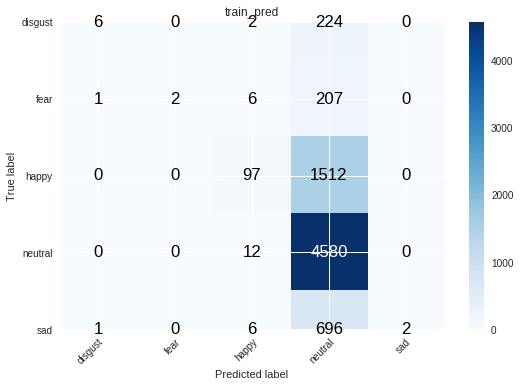

In [379]:
plot_confusion_matrix(y_true=y_train, y_pred=svm_train_p, classes=np.array(classes), title='train_pred')

Confusion matrix, without normalization
[[  0   0   1  27   0]
 [  0   0   2  23   0]
 [  0   0   3 178   0]
 [  0   0   2 515   0]
 [  1   0   3  75   0]]


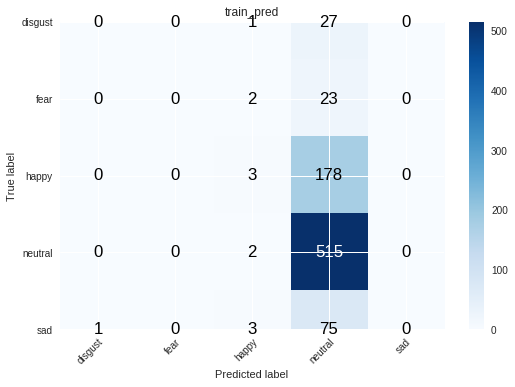

In [380]:
plot_confusion_matrix(y_true=y_test, y_pred=svm_test_p, classes=np.array(classes), title='train_pred')

## 1. Deep Neural Network Classifier

In [0]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [0]:
model = MLPClassifier(alpha=0.2, activation='relu', shuffle=True,  batch_size=512, epsilon=1e-08, hidden_layer_sizes=(1000,), learning_rate='adaptive', max_iter=1000, )

In [302]:
model.fit(x_train, y_train)

MLPClassifier(activation='relu', alpha=0.2, batch_size=512, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(1000,), learning_rate='adaptive',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [195]:
# hidden layers = 300
print('training_acc = {}'.format(accuracy_score(y_true=y_train, y_pred=model.predict(x_train))))
print('val_acc = {}'.format(accuracy_score(y_true=y_test, y_pred=model.predict(x_test))))

training_acc = 0.6520261082404134


In [200]:
# hidden layers = 500
print('training_acc = {}'.format(accuracy_score(y_true=y_train, y_pred=model.predict(x_train))))
print('val_acc = {}'.format(accuracy_score(y_true=y_test, y_pred=model.predict(x_test))))

training_acc = 0.6525700299156921
val_acc = 0.6048192771084338


In [205]:
# hidden layers = 700
print('training_acc = {}'.format(accuracy_score(y_true=y_train, y_pred=model.predict(x_train))))
print('val_acc = {}'.format(accuracy_score(y_true=y_test, y_pred=model.predict(x_test))))

training_acc = 0.6362523796573294
val_acc = 0.6180722891566265


In [229]:
# hidden layers = 1000 with tanh activation
print('training_acc = {}'.format(accuracy_score(y_true=y_train, y_pred=model.predict(x_train))))
print('val_acc = {}'.format(accuracy_score(y_true=y_test, y_pred=model.predict(x_test))))

training_acc = 0.6244220832200164
val_acc = 0.6228915662650603


In [0]:
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

In [305]:
# hidden layers = 1000 with relu activation
print('training_acc = {}'.format(accuracy_score(y_true=y_train, y_pred=train_pred)))
print('val_acc = {}'.format(accuracy_score(y_true=y_test, y_pred=test_pred)))

training_acc = 0.6373402230078868
val_acc = 0.6240963855421687


Confusion matrix, without normalization
[[   6    0    2  224    0]
 [   1    2    6  207    0]
 [   0    0   97 1512    0]
 [   0    0   12 4580    0]
 [   1    0    6  696    2]]


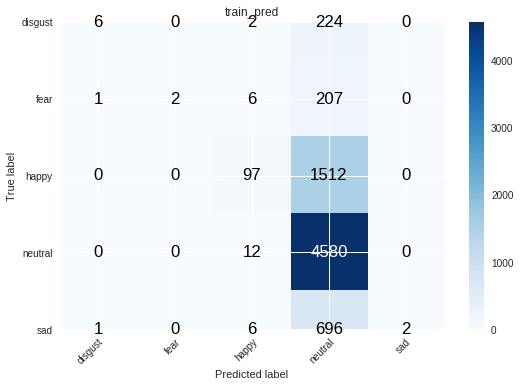

In [378]:
plt.style.use('seaborn')
plot_confusion_matrix(y_true=y_train, y_pred=train_pred, classes=np.array(classes), title='train_pred')

Confusion matrix, without normalization
[[  0   0   1  27   0]
 [  0   0   2  23   0]
 [  0   0   3 178   0]
 [  0   0   2 515   0]
 [  1   0   3  75   0]]


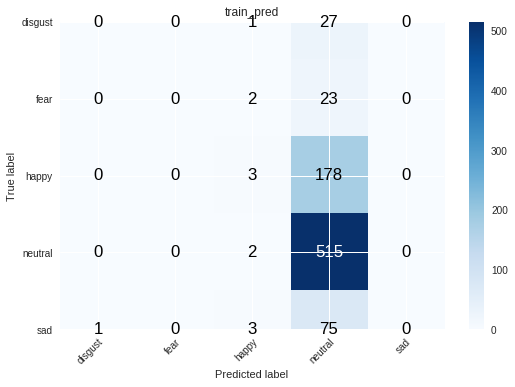

In [325]:
plot_confusion_matrix(y_true=y_test, y_pred=test_pred, classes=np.array(classes), title='train_pred')

### 2. Classification using Convolutional(1D Conv) Neural Networks 

In [0]:
from keras.models import *
from keras.layers import *
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [0]:
# one hot vector notation of the target values
y_train_cat = keras.utils.np_utils.to_categorical(y_train, num_classes=5)
y_test_cat = keras.utils.np_utils.to_categorical(y_test, num_classes=5)

In [0]:
# we have to rehsape the train and test data as well
x_train_ = x_train.reshape(-1, x_train.shape[1], 1)
x_test_ = x_test.reshape(-1, x_test.shape[1], 1)

In [364]:
# check the shape of the training and validation data
print(x_train_.shape, y_train_cat.shape)
print(x_test_.shape, y_test_cat.shape)

(7354, 160, 1) (7354, 5)
(830, 160, 1) (830, 5)


In [0]:
# checkpoints
es = EarlyStopping(monitor='val_acc', min_delta=0.01, patience=5, verbose=1)
mcp = ModelCheckpoint('model.h5', monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True)

In [0]:
# model architecutre
model = Sequential()
model.add(Conv1D(filters=62, kernel_size=2, activation='relu', input_shape=(160, 1)))
model.add(Conv1D(filters=32, kernel_size=4, activation='relu'))
model.add(Conv1D(filters=32, kernel_size=6, activation='relu'))
model.add(Conv1D(filters=16, kernel_size=7, activation='relu'))
model.add(Conv1D(filters=12, kernel_size=11, activation='relu'))
model.add(Conv1D(filters=24, kernel_size=13, activation='relu'))
model.add(Conv1D(filters=24, kernel_size=13, activation='relu'))
model.add(Conv1D(filters=24, kernel_size=17, activation='relu'))
model.add(Conv1D(filters=24, kernel_size=23, activation='relu'))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))


In [369]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_50 (Conv1D)           (None, 159, 62)           186       
_________________________________________________________________
conv1d_51 (Conv1D)           (None, 156, 32)           7968      
_________________________________________________________________
conv1d_52 (Conv1D)           (None, 151, 32)           6176      
_________________________________________________________________
conv1d_53 (Conv1D)           (None, 145, 16)           3600      
_________________________________________________________________
conv1d_54 (Conv1D)           (None, 135, 12)           2124      
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 123, 24)           3768      
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 111, 24)         

In [0]:
# compile the model
model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [375]:
model.fit(x_train_, y_train_cat, batch_size=256, epochs=100, validation_data=(x_test_, y_test_cat), callbacks=[es, mcp])

Train on 7354 samples, validate on 830 samples
Epoch 1/100
7354/7354 [==============================] - 2s 288us/step - loss: 6.0536 - acc: 0.6244 - val_loss: 6.0783 - val_acc: 0.6229

Epoch 00001: val_acc did not improve from 0.62289
Epoch 2/100
7354/7354 [==============================] - 1s 111us/step - loss: 6.0536 - acc: 0.6244 - val_loss: 6.0783 - val_acc: 0.6229

Epoch 00002: val_acc did not improve from 0.62289
Epoch 3/100
7354/7354 [==============================] - 1s 114us/step - loss: 6.0536 - acc: 0.6244 - val_loss: 6.0783 - val_acc: 0.6229

Epoch 00003: val_acc did not improve from 0.62289
Epoch 4/100
7354/7354 [==============================] - 1s 112us/step - loss: 6.0536 - acc: 0.6244 - val_loss: 6.0783 - val_acc: 0.6229

Epoch 00004: val_acc did not improve from 0.62289
Epoch 5/100
7354/7354 [==============================] - 1s 114us/step - loss: 6.0536 - acc: 0.6244 - val_loss: 6.0783 - val_acc: 0.6229

Epoch 00005: val_acc did not improve from 0.62289
Epoch 6/100
7

In [0]:
preds = model.predict(x_test_)

In [377]:
preds[:5]

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

#### So far we have used 3 different models(SVM, ANN, CNN(1D Conv)) but all the three models gave ~60% accuracy and all are extremely biased towards Neutral class, primarily this is because of;
- Data Imabalance
- Incorrect Features

#### In order to overcome this we will extract different features(text features) and downsample the dataset







In [29]:
# !sudo apt-get install -qq python python-dev python-pip build-essential swig libpulse-dev
!sudo pip install pocketsphinx

     |████████████████████████████████| 29.1MB 31.5MB/s 
  Created wheel for pocketsphinx: filename=pocketsphinx-0.1.15-cp36-cp36m-linux_x86_64.whl size=30122999 sha256=21fc62a85def9950f8a68d769f519522f25e61ac451dd2796164c957dcbfec2a
  Stored in directory: /root/.cache/pip/wheels/52/fd/52/2f62c9a0036940cc0c89e58ee0b9d00fcf78243aeaf416265f
Successfully built pocketsphinx


In [0]:
# !pip install SpeechRecognition
import speech_recognition as sr

In [0]:
r = sr.Recognizer()

In [83]:
file = 'meld/train/disgust/MEL_dia1000_utt0_negative_DIS.wav'
file_audio = sr.AudioFile(file)
ipd.Audio(file)

In [0]:
with file_audio as source:
  audio = r.record(source)

In [87]:
r.recognize_sphinx(audio)

'would you look at the dock at at at hit a'

In [0]:
a = r.recognize_google(audio)

In [141]:
a

'would you look at this dump'

In [85]:
!curl -X POST -u "apikey:IUsZZBiWve_v7Jd0fGezFwNzODFnNKhZZ9FdhY-GPnZR" \
--header "Content-Type: audio/wav" \
--data-binary @meld/train/disgust/MEL_dia1000_utt0_negative_DIS.wav \
"https://gateway-lon.watsonplatform.net/speech-to-text/api/v1/recognize?max_alternatives=3"


{
   "results": [
      {
         "alternatives": [
            {
               "confidence": 0.66, 
               "transcript": "would you look at this and don "
            }, 
            {
               "transcript": "would you look at this and dot "
            }, 
            {
               "transcript": "would you look at this dot "
            }
         ], 
         "final": true
      }
   ], 
   "result_index": 0
}

In [89]:
!pip install --upgrade "ibm-watson>=4.0.1"

     |████████████████████████████████| 307kB 5.0MB/s 
     |████████████████████████████████| 204kB 41.0MB/s 
  Created wheel for ibm-watson: filename=ibm_watson-4.0.1-cp36-none-any.whl size=296379 sha256=87c705f3de64813b3967a28a35e4f1736764a142e13354e5155985cdcc167787
  Stored in directory: /root/.cache/pip/wheels/40/73/8a/809e738908cd1b0d34a383219c49ede9f9fba487584ad3377f
  Created wheel for ibm-cloud-sdk-core: filename=ibm_cloud_sdk_core-1.0.0-cp36-none-any.whl size=36085 sha256=815bfe691e5c714be4a7e78cd80769952ced7eeb363476d7c3b80e7651548fec
  Stored in directory: /root/.cache/pip/wheels/12/e5/b5/90c69cc81edf5b95cbec373c83c3530266fdae8266037380df
Successfully built ibm-watson ibm-cloud-sdk-core


In [0]:
import json
from os.path import join, dirname
from ibm_watson import SpeechToTextV1
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator

In [0]:
authenticator = IAMAuthenticator('IUsZZBiWve_v7Jd0fGezFwNzODFnNKhZZ9FdhY-GPnZR')
speech_to_text = SpeechToTextV1(authenticator=authenticator)

speech_to_text.set_service_url('https://gateway-lon.watsonplatform.net/speech-to-text/api')


with open('meld/train/disgust/MEL_dia1000_utt0_negative_DIS.wav', 'rb') as audio_file:
    speech_recognition_results = speech_to_text.recognize(audio=audio_file, content_type='audio/wav',word_alternatives_threshold=0.9, timestamps=False).get_result()


In [118]:
speech_recognition_results['results'][0]['alternatives'][0]['transcript']

'would you look at this and don '

In [0]:
def extract_text_feature(file):
    
  file_audio = sr.AudioFile(file)
  with file_audio as source:
    audio = r.record(source)
    
  try:
    text = r.recognize_google(audio)
  except Exception:
    with open('meld/train/disgust/MEL_dia1000_utt0_negative_DIS.wav', 'rb') as audio_file:
      speech_recognition_results = speech_to_text.recognize(audio=audio_file, content_type='audio/wav',word_alternatives_threshold=0.9, timestamps=False).get_result()
      text = speech_recognition_results['results'][0]['alternatives'][0]['transcript']
  except:
    text = r.recognize_sphinx(audio)
  
  return text
   

  

In [0]:
np.random.seed(42)


#DataFlair - Load the data and extract features for each sound file
def load_data(path):
  f = []
  x = []
  y = []
  
  for cls in tqdm(classes):
    i = 0


    files = np.array(os.listdir(path/cls))
    
    # downsampling we will take only less than 500 data points
    if files.shape[0] > 500:
      files = files[np.random.permutation(500)]
      
    for file in files:
      feature = extract_text_feature(str(path/cls/file))
      f.append(str(path/cls/file))
      x.append(feature)
      y.append(cls)
      
      if i%100==0:
        print('%d of class '%i+cls+" have been processed")
      i+=1

  return x, y, f


In [215]:
x_val, y_val, val_files = load_data(v_path)





  0%|          | 0/5 [00:00<?, ?it/s]

0 of class happy have been processed
100 of class happy have been processed






 20%|██        | 1/5 [07:05<28:21, 425.32s/it]

0 of class fear have been processed






 40%|████      | 2/5 [08:03<15:45, 315.07s/it]

0 of class disgust have been processed






 60%|██████    | 3/5 [08:52<07:50, 235.41s/it]

0 of class sad have been processed






 80%|████████  | 4/5 [11:17<03:28, 208.09s/it]

0 of class neutral have been processed
100 of class neutral have been processed
200 of class neutral have been processed
300 of class neutral have been processed
400 of class neutral have been processed






100%|██████████| 5/5 [27:28<00:00, 437.20s/it]





In [0]:
d = {'audio_files': val_files, 'text': x_val, 'emotion':y_val}

In [0]:
val_df = pd.DataFrame(data=d)

In [0]:
val_df.to_csv('val_text_feature.csv', index=False)

In [221]:
x_train, y_train, train_files = load_data(t_path)





  0%|          | 0/5 [00:00<?, ?it/s]

0 of class happy have been processed
100 of class happy have been processed
200 of class happy have been processed
300 of class happy have been processed
400 of class happy have been processed






 20%|██        | 1/5 [18:56<1:15:44, 1136.08s/it]

0 of class fear have been processed
100 of class fear have been processed
200 of class fear have been processed






 40%|████      | 2/5 [26:26<46:30, 930.30s/it]   

0 of class disgust have been processed
100 of class disgust have been processed
200 of class disgust have been processed






 60%|██████    | 3/5 [35:56<27:24, 822.21s/it]

0 of class sad have been processed
100 of class sad have been processed
200 of class sad have been processed
300 of class sad have been processed
400 of class sad have been processed






 80%|████████  | 4/5 [51:22<14:13, 853.53s/it]

0 of class neutral have been processed
100 of class neutral have been processed
200 of class neutral have been processed
300 of class neutral have been processed
400 of class neutral have been processed






100%|██████████| 5/5 [1:08:28<00:00, 905.28s/it]





In [0]:
d = {'audio_files': train_files, 'text': x_train, 'emotion':y_train}

In [0]:
train_df = pd.DataFrame(data=d)

In [0]:
train_df.to_csv('train_text_feature.csv', index=False)

## Text Classification Model- BERT 

In [0]:
# !pip install ktrain

In [0]:
import ktrain
from ktrain import text
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder

In [0]:
train_df = shuffle(train_df)
val_df = shuffle(val_df)


In [0]:
lb = LabelEncoder()

In [0]:
train_df['emotion_code'] = lb.fit_transform(train_df.emotion)
val_df['emotion_code'] = lb.transform(val_df.emotion)

In [262]:
(x_train,  y_train), (x_test, y_test), preproc = text.texts_from_df(train_df=train_df, text_column='text', label_columns=['emotion_code'], val_df=val_df, preprocess_mode='bert', )

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


preprocessing test...
language: en


In [263]:
model = text.text_classifier('bert', (x_train, y_train) , preproc=preproc)

Is Multi-Label? False
maxlen is 400
done.


In [0]:
learner = ktrain.get_learner(model, train_data=(x_train, y_train), val_data=(x_test, y_test), batch_size=6)

In [265]:
learner.lr_find()

simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
1948/1948 [==============================] - 413s 212ms/step - loss: 1.5942 - acc: 0.2700
Epoch 2/1024
1948/1948 [==============================] - 396s 203ms/step - loss: 1.5246 - acc: 0.3024
Epoch 3/1024
1948/1948 [==============================] - 395s 203ms/step - loss: 1.6197 - acc: 0.2716
Epoch 4/1024
1926/1948 [============================>.] - ETA: 4s - loss: 2.6345 - acc: 0.2300

done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


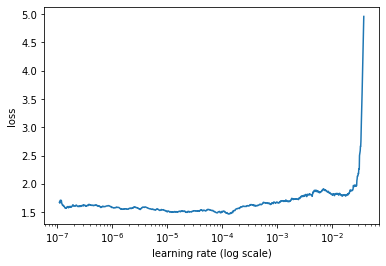

In [266]:
learner.lr_plot()

In [269]:
learner.fit_onecycle(lr=2e-5, epochs=1)



begin training using onecycle policy with max lr of 2e-05...
Train on 1948 samples, validate on 813 samples
Epoch 1/1
1948/1948 [==============================] - 448s 230ms/step - loss: 1.5275 - acc: 0.3085 - val_loss: 1.3672 - val_acc: 0.3825


In [271]:
keras.preprocessing.utils.np_utils.to_categorical(train_df.emotion_code, num_classes=5)

array([[0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

###  emotion of an utterance in a conversation depends upon the following;
1. the speaker.

2. the context given by the preceding utterances.

3. the emotion behind the preceding utterances.

4. Pitch, Freq and Power of the utternce

In [0]:
import pickle

In [273]:
y_test

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [284]:
from google.colab import files
uploaded = files.upload()

Saving lb.pkl to lb.pkl


In [0]:
with open('true.pkl', 'rb') as fp:
  y_true = pickle.load(fp)
with open('predict.pkl', 'rb') as fp:
  y_pred = pickle.load(fp)
with open('lb.pkl', 'rb') as fp:
  targets = pickle.load(fp)

In [282]:
from plot_confusion_matrix import plot_confusion_matrix


Confusion matrix

Example of confusion matrix usage to evaluate the quality
of the output of a classifier on the iris data set. The
diagonal elements represent the number of points for which
the predicted label is equal to the true label, while
off-diagonal elements are those that are mislabeled by the
classifier. The higher the diagonal values of the confusion
matrix the better, indicating many correct predictions.

The figures show the confusion matrix with and without
normalization by class support size (number of elements
in each class). This kind of normalization can be
interesting in case of class imbalance to have a more
visual interpretation of which class is being misclassified.

Here the results are not as good as they could be as our
choice for the regularization parameter C was not the best.
In real life applications this parameter is usually chosen
using :ref:`grid_search`.




Confusion matrix, without normalization


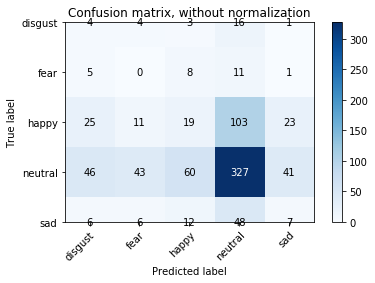

In [286]:
plot_confusion_matrix(y_true=y_true, y_pred=y_pred, classes=targets)

# Multimodal Architecture

In [0]:
from keras.models import *
from keras.activations import *
from keras.layers import *
from keras.applications import ResNet50
from keras.optimizers import *

In [17]:
# cnn model
cnn = ResNet50(input_shape=(256, 256, 3), include_top=False, weights='imagenet', classes=5)













94658560/94653016 [==============================] - 4s 0us/step


In [19]:
cnn.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [0]:
layer_1 = Flatten()(cnn.output)
layer_2 = Dense(32)(layer_1)

In [0]:
cnn = Model(inputs=cnn.input, outputs=layer_2)

In [26]:
cnn.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [0]:
def create_dnn():
  dnn = Sequential()
  dnn.add(Dense(input_shape=(160, ), units=256, activation='relu'))
  dnn.add(Dense(units=128, activation='relu'))
  dnn.add(Dense(units=64, activation='relu'))
  dnn.add(Dense(units=32, activation=None))
  return dnn

In [22]:
dnn = create_dnn()

In [0]:
model = Model(inputs=[cnn.input, dnn.input], outputs=[cnn.output, dnn.output])

In [28]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [0]:
fusion_layer = Concatenate([cnn.input, dnn.input])

In [35]:
dense_1 = Dense(16)(fusion_layer.output)
output_layer = Dense(5, activation='softmax')(dense_1)

AttributeError: ignored

In [0]:
model = Model(inputs=[cnn.input, dnn.input], outputs=[cnn.output, dnn.output])

In [0]:
first_input = Input(shape=(10, ))
first_dense_1 = Dense(13, )(first_input)
first_dense_2 = Dense(17, )(first_dense_1)


second_input = Input(shape=(20, ))
second_dense_1 = Dense(25, )(second_input)
second_dense_2 = Dense(29, )(second_dense_1)



third_input = Input(shape=(30, ))
third_dense_1 = Dense(11, )(third_input)
third_dense_2 = Dense(23, )(third_dense_1)


merge_three = concatenate([first_dense_2, second_dense_2, third_dense_2])


model = Model(inputs=[first_input, second_input, third_input], outputs=merge_three)
ada_grad = Adagrad(lr=0.1, epsilon=1e-08, decay=0.0)
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

In [70]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           (None, 10)           0                                            
__________________________________________________________________________________________________
input_19 (InputLayer)           (None, 20)           0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           (None, 30)           0                                            
__________________________________________________________________________________________________
dense_33 (Dense)                (None, 13)           143         input_18[0][0]                   
____________________________________________________________________________________________

In [0]:
from keras.utils import plot_model

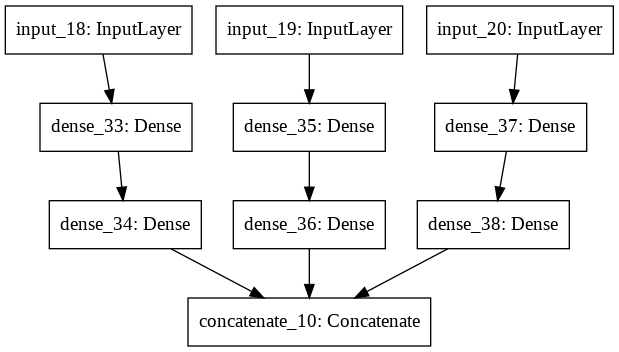

In [72]:
plot_model(model, to_file='model.png')

In [0]:
output = Dense(5, activation='softmax')(model.output)

In [0]:
model = Model(inputs=model.input, outputs=output)

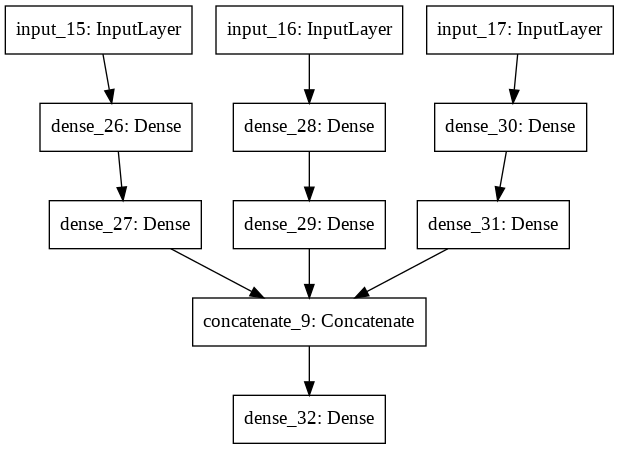

In [66]:
plot_model(model, to_file='model.png')

In [67]:
model.output

<tf.Tensor 'dense_32/Softmax:0' shape=(?, 5) dtype=float32>

In [68]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 10)           0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           (None, 20)           0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           (None, 30)           0                                            
__________________________________________________________________________________________________
dense_26 (Dense)                (None, 13)           143         input_15[0][0]                   
____________________________________________________________________________________________